In [2]:
%load_ext Cython

In [5]:
%%cython
import random
import sys
import re
import time
import copy
import numpy as np
cimport numpy as np
import bisect
import matplotlib.pyplot as plt
sys.path.append('/usr/local/lib/python3.6/dist-packages')

from datetime import datetime
from joblib import Parallel,delayed
from itertools import zip_longest

cdef int set_l = 0
cdef int y1 = 0
cdef int y2 = 0

cdef int o_length = 0
cdef int sumInc = 0
cdef int alpha = 5
cdef int Bgn = [0] * alpha

class Individual(object):
    def __init__(self,int size):
        self.root = np.arange(size)
        np.random.shuffle(self.root)
        self.change = True
        self.cost = np.zeros(size,float)
        self.total_cost = 0

cpdef int levy(float m,float t,int move):
    global set_l,y1,y2
    while(1):
        if(set_l == 0):
            while(1):
                u1 = np.random.rand()
                u2 = np.random.rand()
                if(u1 != 0 and u2 != 0):
                    break
            r = np.sqrt(-2 * np.log(u1))
            t = (np.pi * u2) / 2

            y1 = r * np.cos(t)
            y2 = r * np.sin(t)

            set_l = 1
            y = y1
        elif(set_l == 1):
            y = y2
            set_l = 0

        x = m + (t / np.square(y))
        if(x <= move and x >= 1):
            return x

cdef int calc_root(root,float dist):
    cdef int total_cost = 0
    for i in range(len(root)-1):
        total_cost += dist[root[i]][root[i+1]]
    total_cost += dist[root[i+1]][root[0]]

    return total_cost

cdef int calc_half(root,dist,s_node,e_node):
    cdef int total_cost = 0
    total_cost += dist[s_node][root[0]]
    for i in range(len(root)-1):
        total_cost += dist[root[i]][root[i+1]]
    total_cost += dist[root[i+1]][e_node]

    return total_cost

cdef calc_divided_root(root,dist,half_root):
    total_cost = 0
    for i in range(len(root)-1):
        total_cost += dist[root[i]][root[i+1]]
    total_cost += dist[root[i+1]][root[0]] #+ half_root

    return int(total_cost)

"""def calc_divided_root(root,dist,s_node,e_node,half_root):
    total_cost = 0
    for i in range(len(root)-1):
        if(root[i+1] < (len(root) - 1) or root[i] < (len(root) - 1)):
            total_cost += dist[root[i]][root[i+1]]     
        elif(root[i+1] == len(root)-1):
            total_cost += dist[root[i]][s_node] + half_root
        elif(root[i] == len(root) - 1):
            total_cost += dist[e_node][root[i+1]]

    if(root[i+1] == len(root) - 1):
        total_cost += dist[e_node][root[0]]
    else:
        total_cost += dist[i+1][root[0]]

    return int(total_cost)
    """

cdef calc_ind(ind,dist):
    for i in range(len(ind.root) - 1):
        ind.cost[i] = dist[ind.root[i]][ind.root[i + 1]]

    ind.cost[i + 1] = dist[ind.root[i + 1]][ind.root[0]]
    ind.total_cost = int(np.sum(ind.cost))
    ind.change = False

cdef calc_pop(pop,dist,w):
    for i,ind in enumerate(pop):
        if(ind.change):
            calc_ind(ind,dist)
            w[i] = ind.total_cost

cdef roulette_choice1(pop,w):
    if(max(w) == min(w)):
        return pop
    new_pop = []
    tot = []
    tmp = np.zeros(len(pop),float)

    for t,fit in enumerate(w):
        tmp[t] = (max(w) - fit) / (max(w) - min(w))

    #elite = w.argsort()[0:5]
    elite = [np.argmin(w)] * 3
    for x in elite:
        new_pop.append(copy.deepcopy(pop[x]))
    
    tot = np.cumsum(tmp)

    for j in range(len(pop) - 3):
        r = random.random() * max(tot)
        i = bisect.bisect_right(tot, r)

        new_pop.append(copy.deepcopy(pop[i]))

    return new_pop


cdef cross(pop,size,p_c):
    offspring = copy.deepcopy(pop)
    cross_num = int(len(pop) * p_c) + 2
    a = np.arange(len(pop))
    np.random.shuffle(a)
    for k in range(0, cross_num, 2):
        c1 = offspring[a[k]]
        c2 = offspring[a[k + 1]]
        while(1):
            r1 = random.randint(0,size - 1)
            r2 = random.randint(0,size - 1)
            if(r1 != r2):
                if(r2 < r1):
                    r1, r2 = r2, r1
                break

        e1 = copy.deepcopy(c1.root[r1:r2])
        e2 = copy.deepcopy(c2.root[r1:r2])
        child1 = np.arange(0)
        child2 = np.arange(0)

        for i in range(size):
            if( c2.root[i] not in e1):
                child1 = np.append(child1,c2.root[i])
            if( c1.root[i] not in e2):
                child2 = np.append(child2,c1.root[i])

        child1 = np.insert(child1, r1, e1)
        child2 = np.insert(child2, r1, e2)

        offspring[a[k]].root = child1
        offspring[a[k + 1]].root = child2

        offspring[a[k]].change = True
        offspring[a[k + 1]].change = True

    return offspring

cdef mutate(pop,size,p_m):
    for mutant in pop:
        r = random.random()
        if(r < p_m):
            while(1):
                r1 = random.randint(0,size - 1)
                r2 = random.randint(0,size - 1)
                if(r1 != r2):
                    break

            mutant.root[r1],mutant.root[r2] = mutant.root[r2],mutant.root[r1]

    return pop

cdef mutate_l(pop, size, p_m,move):
    for mutant in pop:
        r = random.random()
        if(r < p_m):
            for i in range(levy(0,0.5,10)):
                while(1):
                    r1 = random.randint(0,size - 1)
                    walk = levy(0,0.5,move)
                    if(r % 2 == 0):
                        r2 = r1 + walk
                    else:
                        r2 = r1 - walk
                    
                    if(r2 >= 0 and r2 <= size):
                        break
                    
                mutant.root[r1],mutant.root[r2] = mutant.root[r2],mutant.root[r1]

    return pop

cdef create_pop(num,size):
    pop = []
    for i in range(num):
        ind = Individual(size)
        pop.append(ind)
    
    return pop

cdef init_cost(co):
    c = np.zeros((len(co),len(co)))
    for i in range(len(co)):
        for j in range(len(co)):
            c[i][j] = np.linalg.norm(co[j] - co[i])

    return c

cdef LK(ind,size,dist):
    global alpha
    global o_length
    global Bgn
    global sumInc
    i = 0
    restricted = np.zeros(size,dtype = int)   
    l_root = ind.root.tolist()
    while(1):
        if(i >= size):
            break
        i += 1
        Bgn[0] = (Bgn[0] + 1) % size
        calc_ind(ind,dist)
        o_length = ind.total_cost
        sumInc = 0
        if(i%100 == 0):
            print("i0 = {0}; i = {1}: {2},\r".format(Bgn[0],i,o_length))

        copy_root = copy.deepcopy(np.insert(ind.root,len(ind.root),ind.root).tolist())
        pathin = copy.deepcopy(copy_root[Bgn[0]:(Bgn[0]+size)])

        if(improvedPath(pathin, size, 1, restricted, l_root, dist)):
            i = 0
        ind.root = np.array(l_root)

cdef divided_LK(root,o_size,dist,half,co):
    global alpha
    global o_length
    global Bgn
    global sumInc
    if(half):
        divided_root = root[0:int(o_size/2)]
        s_node = root[int(o_size/2)]
        e_node = root[len(root)-1]
        half_root = calc_half(root[int(o_size/2):len(root)],dist,s_node,e_node)
    elif(not half):
        divided_root = root[int(o_size/2):len(root)]
        s_node = root[0]
        e_node = root[int(o_size/2)-1]
        half_root = calc_root(root[0:int(o_size/2)],dist)
    
    divided_root = np.insert(divided_root,len(divided_root),o_size)
    size = len(divided_root)

    s_node = e_node

    tmp1 = np.zeros(o_size)
    tmp2 = np.zeros(o_size)
    for x in range(o_size):
        tmp1[x] = np.linalg.norm(co[s_node] - co[x])
        tmp2[x] = np.linalg.norm(co[x] - co[e_node])
    tmp2 = np.append(tmp2,0)
    div_dist = np.append(dist,tmp1.reshape((len(tmp1),1)),axis = 1)
    div_dist = np.append(div_dist,tmp2.reshape(1,len(tmp2)),axis = 0)

    i = 0
    restricted = np.zeros(o_size + 1,dtype = int)  
    l_root = divided_root.tolist()
    while(1):
        if(i >= size):
            break
        i += 1
        Bgn[0] = (Bgn[0] + 1) % (size)
        
        o_length = calc_divided_root(divided_root,div_dist,half_root)
        sumInc = 0
        if(i%100 == 0):
            print("i0 = {0}; i = {1}: {2}".format(Bgn[0],i,o_length),end="")

        copy_root = copy.deepcopy(np.insert(divided_root,size,divided_root).tolist())
        pathin = copy.deepcopy(copy_root[Bgn[0]:(Bgn[0]+size)])

        if(improvedPath(pathin, size, 1, restricted, l_root, div_dist)):
            i = 0
        divided_root = np.array(l_root)

    a = np.insert(divided_root,np.argmax(divided_root),root[int(o_size/2):o_size])

    if(half):
        root = copy.deepcopy(np.insert(divided_root,np.argmax(divided_root),root[int(o_size/2):o_size]))
        root = np.delete(root,np.argmax(root))
    elif(not half):
        root = copy.deepcopy(np.insert(divided_root,np.argmax(divided_root),root[0:int(o_size/2)]))
        root = np.delete(root,np.argmax(root))

    return root

cdef improvedPath(path, n, depth, restricted, pathout, dist):
    global alpha
    global o_length
    global Bgn
    global sumInc
    gmin = int((o_length * (-1)) / n / 4 if n >= 10000 else (o_length * (-1)) / n / 2 )
    if(depth < alpha):
        for j in range(n):
            i = (j + Bgn[depth]) % (n-1)
            nid = path[i]
            #ここ以下を修正
            if(not restricted[nid]):
                g = int(dist[path[i]][path[i+1]] - dist[path[n-1]][path[i]])
                if(g > gmin):
                    sumInc += int(dist[path[i+1]][path[0]] - dist[path[n-1]][path[0]] - g )
                    path = Reverse(path,i+1,n-1)
                    sumInc = int(sumInc)
                    if(sumInc < 0):
                        pathout[:] = path[:]
                        print("\r{0}#{1}\t\t\t".format(depth,(o_length + sumInc)),end="")
                        return 1
                    restricted[nid] = 1
                    fimp = improvedPath(path, n, depth+1, restricted, pathout, dist)
                    restricted[nid] = 0
                    if(fimp):
                        return 1
            Bgn[depth] = (Bgn[depth] + 1) % (n-1)
    else:
        i = 0
        g = -2147483648
        for j in range(n-1):
            h = int(dist[path[j]][path[j+1]] - dist[path[n-1]][path[j]])
            if(h > g):
                g = h
                i = j
        if(g > 0):
            nid = path[i]
            sumInc += int(dist[path[i+1]][path[0]] - dist[path[n-1]][path[0]] - g)
            path = Reverse(path,i+1,n-1)
            sumInc = int(sumInc)
            if(sumInc < 0):
                pathout[:] = path[:]
                print("\r{0}${1}".format(depth,o_length + sumInc),end = "")
                return 1
            restricted[nid] = 1
            fimp = improvedPath(path, n, depth+1, restricted, pathout, dist)
            restricted[nid] = 0
            if(fimp):
                return 1
    return 0

cdef Reverse(path, b, e):
    while(b < e):
        tmp = path[b]
        path[b] = path[e]
        path[e] = tmp
        b += 1
        e -= 1
    return path

cpdef main():
    start = time.time()
    start_p_m = 0.3       #突然変異率
    p_c = 0.8       #交叉率
    NGEN = 10000    #世代数
    ind_num = 50   #集団の大きさ

    
    m_f = not False #False ⇒ levy  True ⇒ GA
    half = True #False ⇒ 後半  True ⇒ 前半 

    tsp_f = "st70"

    input_f = r"C:\Users\imada\Desktop\Research\tsp\\" + tsp_f +".txt" 
    tsp_data = open(input_f,"r")
    lines = tsp_data.readlines()
    tsp_data.close()

    size = len(lines)    #個体の大きさ

    co = np.empty((0,2), float)
    plot_data = np.zeros(NGEN + 1,float)
    plot_x = np.arange(NGEN + 1)

    for i,line in enumerate(lines):
        x = float(line.split()[1])
        y = float(line.split()[2])
        co = np.append(co,np.array([[x,y]]), axis=0)   
        print("{0} {1}".format(co[i][0],co[i][1]))

    dist = init_cost(co)
        
    pop = create_pop(ind_num,size)
    w = np.zeros(len(pop),int)
    calc_pop(pop,dist,w)
    
    p_m = start_p_m       #突然変異率
    p_ml = start_p_m 
    move = (size * 0.3)       #移動範囲
    e_count = 0
    mutate_count = 0
    c_score = min(w)
    prev_score = min(w)
    m = np.argmin(w)
    

    for g in range(NGEN):
        g_start = time.time()

        #if(g == 60000):
            #m_f = not m_f
        if(g % 2000 == 0):
            p_m -= 0.02
            p_ml -= 0.02
            #if(g <= 60000):
             #   p_m -= 0.05
            #else:
             #   p_ml -= 0.05
        
            
        print("-------第{0}世代-------".format(g))

        print("Max:{0}\nMin:{1}\nave:{2}\nBest Score:{3}\nBest root:{4}\ne_count:{5}".format(max(w),min(w),(sum(w) / ind_num),prev_score,pop[np.argmin(w)].root,e_count))
        plot_data[g] = min(w)
        c_score = min(w)

        pop = roulette_choice1(pop,w)
        pop = cross(pop,size,p_c)
        if(m_f):
            pop = mutate(pop,size,p_m)
            mutate_count += 1
            if(mutate_count == 200):
                m_f = not m_f
                mutate_count = 0
        elif(not m_f):
            pop = mutate_l(pop,size,p_ml,move)
        
        calc_pop(pop,dist,w)

        if(prev_score <= c_score):
            e_count += 1
            if(e_count % 150 == 0):
                m = np.argmin(w)
                print(min(w))
                pop[m].root = divided_LK(pop[m].root,size,dist,half,co)
                half = not half
                calc_ind(pop[m],dist)    
                w[m] = pop[m].total_cost
                c_score = w[m]
                print()
                if(prev_score > c_score):
                    prev_score = c_score
                    e_count = 0
                elif(e_count % 50 == 0):
                    m_f = not m_f           
        else:
            prev_score = c_score
            e_count = 0

        
        g_end = time.time()
        print("m_f:{0}".format(m_f))
        print("remaining time{0}".format((g_end - g_start) * (NGEN - g) / 3600))

    print("-------第{0}世代-------".format(g + 1))

    calc_pop(pop,dist,w)

    print("Max:{0}\nMin:{1}\nBest root:{2}".format(max(w),min(w),pop[np.argmin(w)].root))
    plot_data[g + 1] = min(w)
    min_2 = str(prev_score)
    plt.plot(plot_x,plot_data)
        
    title = min_2
    plt.title(title)
    
    output_f = r"C:\Users\imada\Desktop\Research\tsp\LK\\divided_output\\" + tsp_f + "d_{0}_{1}_{2}_{3}_{4}_{5}.png".format(NGEN,p_c,start_p_m,ind_num,move,m_f)
    plt.savefig(output_f)
    elapsed_time = (time.time() - start) / 3600 
    print("elapsed_time:{0}".format(elapsed_time) + "[h]")

    plt.show()



if __name__ == '__main__':
    main()


64.0 96.0
80.0 39.0
69.0 23.0
72.0 42.0
48.0 67.0
58.0 43.0
81.0 34.0
79.0 17.0
30.0 23.0
42.0 67.0
7.0 76.0
29.0 51.0
78.0 92.0
64.0 8.0
95.0 57.0
57.0 91.0
40.0 35.0
68.0 40.0
92.0 34.0
62.0 1.0
28.0 43.0
76.0 73.0
67.0 88.0
93.0 54.0
6.0 8.0
87.0 18.0
30.0 9.0
77.0 13.0
78.0 94.0
55.0 3.0
82.0 88.0
73.0 28.0
20.0 55.0
27.0 43.0
95.0 86.0
67.0 99.0
48.0 83.0
75.0 81.0
8.0 19.0
20.0 18.0
54.0 38.0
63.0 36.0
44.0 33.0
52.0 18.0
12.0 13.0
25.0 5.0
58.0 85.0
5.0 67.0
90.0 9.0
41.0 76.0
25.0 76.0
37.0 64.0
56.0 63.0
10.0 55.0
98.0 7.0
16.0 74.0
89.0 60.0
48.0 82.0
81.0 76.0
29.0 60.0
17.0 22.0
5.0 45.0
79.0 70.0
9.0 100.0
17.0 82.0
74.0 67.0
10.0 68.0
48.0 19.0
83.0 86.0
84.0 94.0
-------第0世代-------
Max:4020
Min:3219
ave:3669.02
Best Score:3219
Best root:[10 59 67 44 28 34 30  4 17  3 35 41 40 63  2 20 11  0 57 58 18 23 16 21
 12 52 61 66 31 19 27 55 45 42 62  5 38 29 47 53 49 15 14 48 54 56 50 22
  7 43 46 25  8 51 24  9 39 32  1 13  6 69 37 68 33 64 26 36 65 60]
e_count:0
m_f:True
remai

m_f:True
remaining time0.086515873670578
-------第26世代-------
Max:3133
Min:2499
ave:2791.64
Best Score:2483
Best root:[47 17 39 37 11 55 64  3 45  2 57 58 23 30 12 52 61 66 38 33 21 16  4  5
 22  0 42 25 31 19 27 62 67 29  7 43 26 13 10 59 18 34 65 60 48 69 68  1
 40 51 32 35 46 53 49 15 14 41  6 54 56 50 36 63 20  8 24 44 28  9]
e_count:3
m_f:True
remaining time0.07848281568951077
-------第27世代-------
Max:3170
Min:2545
ave:2826.12
Best Score:2483
Best root:[ 9 41  1 17 40 39 11 55  2 64 63 57 58 23 30 12 52 61 66 38 16  4 33 22
  0 42 31 25 60 45  5 19 27 62 67 29  7 43 26 13 10 59 18 65 34 21 35 69
 68 46 53 49 15 14  6 48 54 56 50 36 37  3 32 20  8 47 24 44 28 51]
e_count:4
m_f:True
remaining time0.043333145247565374
-------第28世代-------
Max:3109
Min:2551
ave:2797.3
Best Score:2483
Best root:[ 9 41  1 17 40 39 11 55  2 64 63 57 58 23 30 12 52 61 66 38 33 16  4  5
 22 42 25 31 19 27 62 67 29  7 43  0 60 45 26 13 10 59 18 65 34 21 35 69
 68 46 53 49 15 14  6 48 54 56 50 36 37  3 32 20  8

m_f:True
remaining time0.06330851674079895
-------第54世代-------
Max:3054
Min:2413
ave:2667.82
Best Score:2323
Best root:[ 9 17 57 58 68 30 12 51 64 55 61 10 63 66 38 33  3 39 16 22 42 25 31  5
 43 60 45 13  0 62  1 41 23 67 29  7 40 19 27 18  2 28 32 20 26  8 21 52
 59 65 34 35 69 46 47 53 49 15 56 50 36 14  6 48 54 37  4 11 24 44]
e_count:5
m_f:True
remaining time0.06330478694703844
-------第55世代-------
Max:3048
Min:2447
ave:2657.0
Best Score:2323
Best root:[ 9 17 51 64 57 58 68 30 12 55 61 10 63 66 38 33  3 39 16 34 42 25 31  5
 43 60 45 13  0 62  1 41 23 67 29  7 40 19 27 18  2 28 32 20 26  8 21 52
 59 65 22 35 69 46 47 53 49 15 56 50 36 14  6 48 54 37  4 11 24 44]
e_count:6
m_f:True
remaining time0.06343739330768586
-------第56世代-------
Max:3048
Min:2409
ave:2645.44
Best Score:2323
Best root:[ 9 17 51 64 57 58 68 30 12 55 61 10 63 66 38 33  3 39 16 34 42 25 31  5
 13  1 41 23  0 62  7 43 60 45 67 29 40 19 27 18  2 28 32 20 26  8 21 52
 59 65 22 35 69 46 47 53 49 15 56 50 36 14  6 48 5

m_f:True
remaining time0.06319317287868924
-------第81世代-------
Max:2981
Min:2374
ave:2585.28
Best Score:2168
Best root:[64 57 58 68 30 51 61 55 10 63 66 38 33 39 42  1 53 16 11 31  9 23 17  3
 50 13 37 22  0 62 48 29 43 60 45  7 54 40 67 26 19 25 27 18  2 28 32 20
  8 56 21 52 59  5 41  6 65 34 69 35 46 47  4 12 15 49 36 14 24 44]
e_count:19
m_f:True
remaining time0.06321702043215434
-------第82世代-------
Max:2934
Min:2296
ave:2580.48
Best Score:2168
Best root:[64 57 58 68 30 51 61 55 10 63 66 38 33 39 42  1 16 11 31 23  3 13 37 22
  0 48 43 54 29  7 62 28  5 17 60 45 67 26 19 25 27 18  2 32 20  8 53  9
 50 40 56 21 52 59 41  6 65 34 69 35 46 47  4 12 15 49 36 14 24 44]
e_count:20
m_f:True
remaining time0.06044796466827393
-------第83世代-------
Max:2952
Min:2296
ave:2552.86
Best Score:2168
Best root:[64 57 58 68 30 51 61 55 10 63 66 38 33 39 42  1 16 11 23 28 31 13 37  3
 22  0 62 48 29 43 60 45  7 54 40 67 26 19 25 27 18  5 17  2 32 20  8 53
  9 50 56 21 52 59 41  6 65 34 69 35 46 47  4 1

m_f:True
remaining time0.06571474115053813
-------第107世代-------
Max:2942
Min:2192
ave:2597.98
Best Score:2168
Best root:[57 58 68 51 61 64 10 63 55 66 38 33 39 42 16 31  3 22 12 30  0 41 34 23
  1 37 62 48 29  7 54 17 43 60 45 67 40 26 27 25 18  2 35 28  4 50 11 13
 19  5 32 20  8 53  9 21 56 52 69 46 59 47 49 15 36 65  6 14 24 44]
e_count:45
m_f:True
remaining time0.06311159120665656
-------第108世代-------
Max:2860
Min:2192
ave:2552.6
Best Score:2168
Best root:[57 58 68 51 61 64 10 63 55 66 38 33 39 42 16 31  3 22 12 30  0 41 34 23
  1 37 62 48 29  7 54 17 43 60 45 67 40 26 27 25 18  2 35 28  4 50 11 13
 19  5 32 20  8 53  9 21 56 52 69 46 59 47 49 15 36 65  6 14 24 44]
e_count:46
m_f:True
remaining time0.06028556982676188
-------第109世代-------
Max:2860
Min:2192
ave:2512.84
Best Score:2168
Best root:[57 58 68 51 61 64 10 63 55 66 38 33 39 42 16 31  3 22 12 30  0 41 34 23
  1 37 62 48 29  7 54 17 43 60 45 67 40 26 27 25 18  2 35 28  4 50 11 13
 19  5 32 20  8 53  9 21 56 52 69 46 59 47 49

m_f:True
remaining time0.06014387951956855
-------第133世代-------
Max:2640
Min:2094
ave:2292.58
Best Score:2061
Best root:[57 58 68 51 61 64 10 63 55 66 38 33 42 16 31  3 22 12 30  0 52 34 23  1
 37 62 54 48 39 29  7 17 43 60 45 26 40  6 27 18 25  2 35 28  4 50 11 13
 19 41 67  5 32 20  8 53  9 21 56 69 46 59 47 49 15 36 65 14 24 44]
e_count:4
m_f:True
remaining time0.06285881539185842
-------第134世代-------
Max:2650
Min:2114
ave:2305.9
Best Score:2061
Best root:[57 58 68 51 61 64 10 63 55 66 38 33 42 16 31  3 22 12 30  0 52 34 23  1
 37 62 54 48 39 29  7 17 43 60 45 26 40 27 18 67 25  2  6 41 35 28  4 50
 11 13 19  5 32 20  8 53  9 46 21 69 14 56 59 47 49 15 36 65 24 44]
e_count:5
m_f:True
remaining time0.06287400696012709
-------第135世代-------
Max:2568
Min:2134
ave:2298.5
Best Score:2061
Best root:[57 58 68 51 61 10 63 55 66 38 33 42 16 31  3 22 12 30  0 52 34 23  1 37
 62 54 48 29  7 17 43 60 45 13 19 39 26 40  6 27 67 64 18 25  2 41 35 28
  4 50 11  5 32 20  8 53  9 46 21 69 14 56 59 47

m_f:True
remaining time0.06543037096659342
-------第161世代-------
Max:3047
Min:2069
ave:2461.48
Best Score:2061
Best root:[57 10 63 66 42 16  0 12 30 22 56 34 23  1 65 37 62 54 48  7 14 38 41 67
  3  5 61 64 44 45 24 13 29 43 60 39 26 40  6 19 27 25 18 31 33 11 69 68
 58 21 17 59  9 35 28  4 50 53 51 32 20  8 55 46  2 52 47 49 15 36]
e_count:32
m_f:True
remaining time0.06534552819199033
-------第162世代-------
Max:2721
Min:2080
ave:2404.74
Best Score:2061
Best root:[57 10 63 66 42 16  0 12 30 22 56 34 23  1 65 37 62 54 48  7 14 38 41 67
  3  5 61 64 44 45 24 13 29 43 60 39 26 40  6 19 27 25 18 31 33 69 68 58
 21 17 59  9 35 28  4 50 53 51 55 11 32 20  8 46  2 52 47 49 15 36]
e_count:33
m_f:True
remaining time0.06268775012758043
-------第163世代-------
Max:2701
Min:2078
ave:2364.5
Best Score:2061
Best root:[57 10 63 66 38 65 16 42 22 12 30  0 52 34 23  1 37 62 54 48  7 67 41 58
 21  3  5 61 64 44 45 24 13 29 43 60 39 26 40  6 17 19 27 18  2 25 31 33
  9 35 28  4 50 68 11 51 53 59 47 32 20  8 55

m_f:True
remaining time0.06531176858478123
-------第189世代-------
Max:2668
Min:1964
ave:2306.58
Best Score:1886
Best root:[57 10 63 66 16  0 12 56 14 23  1 65 37 62 34 54 48  7 67 41 42 61 64 45
 38 24 13 29 43 60 20 39 44 26 40 59 46  2 31 52 19 27 25 18  6 69 68 58
 21 17  3  9 30 22 33 55 50 35 28  4 53 47 11 51  8  5 32 49 15 36]
e_count:2
m_f:True
remaining time0.05972240136729346
-------第190世代-------
Max:2580
Min:1964
ave:2295.2
Best Score:1886
Best root:[57 10 63 66 16  0 12 56 14 23  1 65 37 62 34 54 48  7 67 41 42 61 64 45
 38 24 13 29 43 60 20 39 44 26 40 59 46  2 31 52 19 27 25 18  6 69 68 58
 21 17  3  9 30 22 33 55 50 35 28  4 53 47 11 51  8  5 32 49 15 36]
e_count:3
m_f:True
remaining time0.06257885098457336
-------第191世代-------
Max:2624
Min:2003
ave:2227.86
Best Score:1886
Best root:[10 63 66 16  0 56 14 23  1 65 37 62 34 54 48  7 31 20 67 41 42 61 64 38
 24 45 13 29 43 60 39 44  8 25 30 22  9 12 57  5 26 40 59 46  6  2 19 27
 18 52 69 68 58 21 17  3 33 55 50 35 28  4 53 4

m_f:False
remaining time0.06506611704826355
-------第215世代-------
Max:2484
Min:1849
ave:2012.42
Best Score:1829
Best root:[10 66 63  0 12 56 14 23  1 65 37 62 31 54 48  7 41 61 64 57 67 45 38 24
 13 29 43 60  2 42 16 39 44 26 40  5 46 52 22 55 59 20 19 27 25 18  6 69
 68 58 21 17  3  9 47 53 33 30 34 35 28 50 49 11 51 32  8  4 15 36]
e_count:19
m_f:False
remaining time0.06770215464962853
-------第216世代-------
Max:2400
Min:1849
ave:1993.58
Best Score:1829
Best root:[10 66 63  0 12 56 14 23  1 65 37 62 31 54 48  7 41 61 64 57 67 45 38 24
 13 29 43 60  2 42 16 39 44 26 40  5 46 52 22 55 59 20 19 27 25 18  6 69
 68 58 21 17  3  9 47 53 33 30 34 35 28 50 49 11 51 32  8  4 15 36]
e_count:20
m_f:False
remaining time0.0651195600297716
-------第217世代-------
Max:2358
Min:1848
ave:1989.26
Best Score:1829
Best root:[10 66 63  0 12 56 14 23  1 65 37 62 31 54 48  7 41 61 64 57 67 45 38 24
 13 29 43 60  2 42 16 39 44 26 40  5 46 52 22 55 59 20 19 27 25 18  6 58
 68 69 21 17  3  9 47 53 33 30 34 35 28 50

m_f:False
remaining time0.06752937078475953
-------第242世代-------
Max:2601
Min:1736
ave:1943.42
Best Score:1736
Best root:[10 66 63  0 12 56 14 23  1 65 37 62 31 54 48  7 41 61 64 57 67 38 24 45
 29 13  2 60 43 16 42 39 44 26 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 68 21 17  3  9 47 53 33 30 34 35 28 15 49 50 32 51 11  8  4 36]
e_count:5
m_f:False
remaining time0.06224843091434903
-------第243世代-------
Max:2302
Min:1736
ave:1933.04
Best Score:1736
Best root:[10 66 63  0 12 56 14 23  1 65 37 62 31 54 48  7 41 61 64 57 67 38 24 45
 29 13  2 60 43 16 42 39 44 26 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 68 21 17  3  9 47 53 33 30 34 35 28 15 49 50 32 51 11  8  4 36]
e_count:6
m_f:False
remaining time0.06215546349684398
-------第244世代-------
Max:2487
Min:1736
ave:1970.4
Best Score:1736
Best root:[10 66 63  0 12 56 14 23  1 65 37 62 31 54 48  7 41 61 64 57 67 38 24 45
 29 13  2 60 43 16 42 39 44 26 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 68 21 17  3  9 47 53 33 30 34 35 28 15 4

m_f:False
remaining time0.06740312417348227
-------第269世代-------
Max:2446
Min:1661
ave:1941.84
Best Score:1651
Best root:[10 66 63  0 12 56 14 23 65 37 62  1 31 54 48  7 41 61 64 57 24 38 45 13
 67 29 43  2 40 16 39 44 26 60 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 68 21 17  3  9 47 53 33 30 34 28 35 15 49 50 51 32 11  8  4 36]
e_count:11
m_f:False
remaining time0.06471396128336589
-------第270世代-------
Max:2361
Min:1633
ave:1909.6
Best Score:1651
Best root:[10 66 63  0 12 56 14 23 65 37 62  1 31 54 48  7 41 61 64 57 24 38 45 29
 13  2 67 43 40 16 39 44 26 60 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 68 21 17  3  9 47 53 33 30 34 28 35 15 49 50 51 32 11  8  4 36]
e_count:12
m_f:False
remaining time0.06469506753815545
-------第271世代-------
Max:2276
Min:1637
ave:1878.68
Best Score:1633
Best root:[10 66 63  0 12 56 14 23 65 37 62  1 31 54 48  7 41 61 64 57 60 24 38 45
 29 13 40  2 67 43 16 39 44 26 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 68 21 17  3  9 47 53 33 30 34 28 35 15

m_f:False
remaining time0.061859556039174396
-------第296世代-------
Max:2316
Min:1656
ave:1899.24
Best Score:1629
Best root:[10 66 23  0 12 14 63 65 37 62 56  1 54 48  7 31 41 61 64 57 24 38 29 45
 13 40  2 43 67 60 16 39 44 26 42  5 52 22 46 55 59 20 19 27 25 18 53 58
 69 68 21 17  3  9 47 35 33 30 34 28  6 15 49 50 51 32 11  8  4 36]
e_count:22
m_f:False
remaining time0.06450484063890245
-------第297世代-------
Max:2397
Min:1656
ave:1915.12
Best Score:1629
Best root:[10 66 63  0 12 14 23 65 56 37 62  1 54 48  7 31 41 61 64 57 40 60 24 38
 45 29 13  2 43 16 67 42 39 44 26  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 68 21 17  3  9 47 53 33 30 34 28 35 15 49 50 11  8 32 51  4 36]
e_count:23
m_f:False
remaining time0.0671309432056215
-------第298世代-------
Max:2397
Min:1670
ave:1882.3
Best Score:1629
Best root:[10 66 63  0 12 14 23 56 65 37 62  1 54 48  7 31 41 61 64 57 60 24 38 45
 29 13 40  2 43 16 67 39 44 26 42  5 46 22 52 55 59 20 19 27 25 18  6 58
 69 68 21 17  3  9 47 53 33 50 35 34 30 28

m_f:False
remaining time0.06435444553693136
-------第323世代-------
Max:2360
Min:1606
ave:1790.4
Best Score:1616
Best root:[10 66 63  0 12 14 23 56 65 37 62  1 54 48  7 31 41 61 64 57 60 38 24 45
 29 13 40  2 43 26 39 44 67 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 68 21 17  3  9 47 53 33 30 34 28 35 15 49 50 11  8 32 51  4 36]
e_count:16
m_f:False
remaining time0.06434330979983012
-------第324世代-------
Max:2360
Min:1618
ave:1792.16
Best Score:1606
Best root:[10 66 63  0 12 14 23 56 65 37 62  1 54 48  7 31 41 61 64 57 60 24 38 45
 29 13 40  2 43 26 39 44 67 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 68 21 17  3  9 47 53 33 30 34 28 35 15 49 50 11  8 32 51  4 36]
e_count:0
m_f:False
remaining time0.06164651446872287
-------第325世代-------
Max:2070
Min:1618
ave:1803.52
Best Score:1606
Best root:[10 66 63  0 12 14 23 56 65 37 62  1 54 48  7 31 41 61 64 57 60 24 38 45
 29 13 40  2 43 26 39 44 67 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 68 21 17  3  9 47 53 33 30 34 28 35 15 

m_f:False
remaining time0.06678704500198364
-------第349世代-------
Max:2261
Min:1617
ave:1817.18
Best Score:1593
Best root:[10 66 63  0 12 14 23 56 65 37 62  1 54 48  7 31 41 61 64 57 60 24 38 45
 29 13  2 40 43 26 39 44 67 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 68 21 17  3  9 47 53 33 30 28 34 35 15 49 50 11  8 32 51  4 36]
e_count:2
m_f:False
remaining time0.06684148490428925
-------第350世代-------
Max:2352
Min:1606
ave:1842.94
Best Score:1593
Best root:[10 66 63  0 12 14 23 56 65 37 62  1 54 48  7 31 41 61 64 57 60 24 38 45
 29 13  2 40 43 26 39 44 67 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 68 21 17  3 33 47 53  9 30 28 34 35 15 49 50 11  8 32 51  4 36]
e_count:3
m_f:False
remaining time0.06154094139734904
-------第351世代-------
Max:2494
Min:1606
ave:1859.68
Best Score:1593
Best root:[10 66 63  0 12 14 23 56 65 37 62  1 54 48  7 31 41 61 64 57 60 24 38 45
 29 13  2 40 43 26 39 44 67 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 68 21 17  3 33 47 53  9 30 28 34 35 15 

m_f:False
remaining time0.06399746596813202
-------第374世代-------
Max:2108
Min:1593
ave:1829.58
Best Score:1590
Best root:[10 66 63  0 12 14 23 56 65 37 62  1 54 48  7 31 41 61 64 57 60 24 38 45
 29 13  2 40 43 26 39 44 67 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 68 21 17  3 33 47 53  9 30 34 28 35 15 49 50 11  8 32 51  4 36]
e_count:7
m_f:False
remaining time0.061348998414145574
-------第375世代-------
Max:2415
Min:1590
ave:1817.38
Best Score:1590
Best root:[10 66 63  0 12 14 23 56 65 37 62  1 54 48  7 31 41 61 64 57 60 24 38 45
 29 13  2 40 43 26 44 39 67 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 68 21 17  3 33 47 53  9 30 34 28 35 15 49 50 11  8 32 51  4 36]
e_count:8
m_f:False
remaining time0.06399373213450114
-------第376世代-------
Max:2264
Min:1590
ave:1848.12
Best Score:1590
Best root:[10 66 63  0 12 14 23 56 65 37 62  1 54 48  7 31 41 61 64 57 60 24 38 45
 29 13  2 40 43 26 44 39 67 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 68 21 17  3 33 47 53  9 30 34 28 35 15

m_f:False
remaining time0.06908098856608073
-------第401世代-------
Max:2097
Min:1591
ave:1742.64
Best Score:1545
Best root:[66 10 63  0 12 14 23 56 65 37 62  1 54 48  7 31 41 57 64 61 24 60 38 29
 13  2 40 45 43 26 39 44 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 69 21  3 17 33 47 53  9 30 34 28 35 15 49 50  8 11 32 51  4 36]
e_count:2
m_f:False
remaining time0.06920856455961863
-------第402世代-------
Max:2166
Min:1549
ave:1798.72
Best Score:1545
Best root:[10 66 63  0 12 14 23 56 65 37 62  1 54 48  7 31 41 57 64 61 24 60 38 45
 29 13  2 40 43 26 44 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 69 21  3 17 33 47 53  9 49 30 34 28 35 15 50  8 11 32 51  4 36]
e_count:3
m_f:False
remaining time0.06116291933589511
-------第403世代-------
Max:2241
Min:1550
ave:1800.64
Best Score:1545
Best root:[66 10 63  0 12 14 23 56 65 37 62  1 54 48  7 31 41 57 64 61 24 60 38 45
 29 13  2 40 43 26 39 44 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 69 21  3 17 33 47 53 49 30 34 28 35 15 

m_f:False
remaining time0.06100043773651123
-------第428世代-------
Max:2502
Min:1552
ave:1775.5
Best Score:1530
Best root:[66 10 63  0 12 14 23 56 65 37 62  1 54 48 31  7 41 57 64 16 13 38 24 29
 45 60  2 40 42 39 44 67 43 61 26  5 52 22 46 55 59 47 19 27 25 18  6 69
 68 58 21  3 17 33 20 50  9 53 30 34 28 35 15 49  8 11 32 51  4 36]
e_count:23
m_f:False
remaining time0.060919895966847736
-------第429世代-------
Max:2339
Min:1543
ave:1864.16
Best Score:1530
Best root:[66 10 63  0 12 14 23 56 65 37 62  1 54 48  7 31 41 57 64 61 60 38 24 45
 29 13  2 40 43 26 44 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 69 21  3 17 33 47 53  9 30 28 34 35 15 50 49  8 11 32 51  4 36]
e_count:24
m_f:False
remaining time0.06370252562893762
-------第430世代-------
Max:2423
Min:1543
ave:1867.4
Best Score:1530
Best root:[66 10 63  0 12 14 23 56 65 37 62  1 54 48  7 31 41 57 64 61 60 38 24 45
 29 13  2 40 43 26 44 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 69 21  3 17 33 47 53  9 30 28 34 35 15

m_f:False
remaining time0.06611300508181255
-------第455世代-------
Max:2492
Min:1538
ave:1764.42
Best Score:1530
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 60 38 24 45
 29 13  2 40 43 26 44 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 69 21  3 17 33 47 53  9 30 28 34 35 15 50 49  4  8 11 32 51 36]
e_count:50
m_f:False
remaining time0.05818156765566932
-------第456世代-------
Max:2305
Min:1538
ave:1790.76
Best Score:1530
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 60 38 24 45
 29 13  2 40 43 26 44 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 69 21  3 17 33 47 53  9 30 28 34 35 15 50 49  4  8 11 32 51 36]
e_count:51
m_f:False
remaining time0.06080806096394857
-------第457世代-------
Max:2305
Min:1538
ave:1719.68
Best Score:1530
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 60 38 24 45
 29 13  2 40 43 26 44 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 69 21  3 17 33 47 53  9 30 28 34 35 1

m_f:False
remaining time0.06330828547477722
-------第479世代-------
Max:2302
Min:1528
ave:1783.04
Best Score:1527
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 69 30 21  3 17 33 47 53  9 28 34 35 15 50 49  4 11  8 32 51 36]
e_count:9
m_f:False
remaining time0.07121757302019331
-------第480世代-------
Max:2206
Min:1528
ave:1768.94
Best Score:1527
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 69 30 21  3 17 33 47 53  9 28 34 35 15 50 49  4 11  8 32 51 36]
e_count:10
m_f:False
remaining time0.06329687966240777
-------第481世代-------
Max:2167
Min:1527
ave:1785.08
Best Score:1527
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 69 30 21  3 17 33 47 53  9 28 34 35 15

m_f:False
remaining time0.06576923423343235
-------第505世代-------
Max:2434
Min:1527
ave:1758.28
Best Score:1522
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 69 30 21  3 17 33 47 53  9 28 34 35 15 50 49  4  8 11 32 51 36]
e_count:19
m_f:False
remaining time0.06319354176521301
-------第506世代-------
Max:2085
Min:1527
ave:1729.28
Best Score:1522
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 69 30 21  3 17 33 47 53  9 28 34 35 15 50 49  4  8 11 32 51 36]
e_count:20
m_f:False
remaining time0.06312715384695265
-------第507世代-------
Max:2022
Min:1527
ave:1741.86
Best Score:1522
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 69 30 21  3 17 33 47 53  9 28 34 35 1

m_f:False
remaining time0.0682599796851476
-------第532世代-------
Max:2276
Min:1541
ave:1766.84
Best Score:1518
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 69 30 21  3 17 33 53 47  9 28 34 35 15 50 49  4  8 11 51 32 36]
e_count:12
m_f:False
remaining time0.05771409511566162
-------第533世代-------
Max:2357
Min:1553
ave:1761.66
Best Score:1518
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 16 42  5 52 22 46 55 59 20 27 19 25 18  6 58
 68 30 69 21  3 17 33 53 47  9 28 34 35 15 50 51 49  4  8 11 32 36]
e_count:13
m_f:False
remaining time0.06550317505995433
-------第534世代-------
Max:2256
Min:1553
ave:1766.22
Best Score:1518
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 16 42  5 52 22 46 55 59 20 27 19 25 18  6 58
 68 30 69 21  3 17 33 53 47  9 28 34 35 15

m_f:False
remaining time0.0653446211417516
-------第558世代-------
Max:2129
Min:1472
ave:1706.16
Best Score:1467
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 60 44 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21  3 17 33 53 47  9 28 34 35 15 36 50 51 49  4  8 11 32]
e_count:0
m_f:False
remaining time0.06021383775605096
-------第559世代-------
Max:2285
Min:1467
ave:1719.74
Best Score:1467
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21  3 17 33 53 47  9 28 34 35 15 36 50 51 49  4  8 11 32]
e_count:1
m_f:False
remaining time0.06015681505203247
-------第560世代-------
Max:2235
Min:1467
ave:1699.0
Best Score:1467
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21  3 17 33 53 47  9 28 34 35 15 36

m_f:False
remaining time0.06256215691566468
-------第584世代-------
Max:2469
Min:1458
ave:1730.92
Best Score:1458
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21  3 17 33 53 47  9 28 34 35 15 36 49 50  4 51  8 11 32]
e_count:11
m_f:False
remaining time0.057458854781256785
-------第585世代-------
Max:2282
Min:1458
ave:1754.08
Best Score:1458
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21  3 17 33 53 47  9 28 34 35 15 36 49 50  4 51  8 11 32]
e_count:12
m_f:False
remaining time0.06520261698298985
-------第586世代-------
Max:2314
Min:1458
ave:1746.68
Best Score:1458
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21  3 17 33 53 47  9 28 34 35 

m_f:False
remaining time0.06243875026702881
-------第611世代-------
Max:2197
Min:1458
ave:1725.02
Best Score:1457
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 16 42  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21  3 17 33 53 47  9 28 34 35 15 36 49 50  4 51  8 11 32]
e_count:17
m_f:False
remaining time0.0624265044927597
-------第612世代-------
Max:2086
Min:1457
ave:1716.0
Best Score:1457
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21  3 17 33 53 47  9 28 34 35 15 36 49 50  4 51  8 11 32]
e_count:18
m_f:False
remaining time0.05721213897069295
-------第613世代-------
Max:2106
Min:1457
ave:1668.18
Best Score:1457
Best root:[66 10 63  0 12 23 14 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21  3 17 33 53 47  9 28 34 35 15 

m_f:False
remaining time0.0596661811404758
-------第637世代-------
Max:1999
Min:1485
ave:1670.42
Best Score:1441
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2  5 43 26 44 60 39 67 42 16 40 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21  3 17 33 53 47  9 15 34 35 28 36 49 50 51  4  8 11 32]
e_count:13
m_f:False
remaining time0.06484745701154072
-------第638世代-------
Max:2308
Min:1485
ave:1665.84
Best Score:1441
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 45 24 29
 13  2  5 43 26 44 60 39 67 42 16 40 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21  3 17 33 53 47  9 32 34 35 28 36 49 50 51  4  8 11 15]
e_count:14
m_f:False
remaining time0.06485541158252292
-------第639世代-------
Max:2407
Min:1496
ave:1673.72
Best Score:1441
Best root:[66 10 63  0 12 23 62 56 14 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21  3 17 33 53 47  9 28 34 35 15

m_f:False
remaining time0.09488193723890516
-------第664世代-------
Max:2110
Min:1445
ave:1646.34
Best Score:1441
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21  3 17 33 53 47  9  4 15 34 28 35 36 49 50 51  8 11 32]
e_count:40
m_f:False
remaining time0.04475370724995931
-------第665世代-------
Max:1882
Min:1445
ave:1636.32
Best Score:1441
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21  3 17 33 53 47  9  4 15 34 28 35 36 49 50 51  8 11 32]
e_count:41
m_f:False
remaining time0.04050783779886034
-------第666世代-------
Max:2200
Min:1451
ave:1632.88
Best Score:1441
Best root:[66 10 63 12 14 23 56 62 37  0 57 41 38 48  7 31  1 65 64 61 54 24 45 29
 13  2 40 43 26 44 60 39 42 67 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21 17 33  3 53 47  9  4 15 50 3

m_f:False
remaining time0.059346354736222164
-------第690世代-------
Max:2144
Min:1427
ave:1669.96
Best Score:1427
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21  3 17 33 53 47 50  9  4 15 28 34 35 36 49 51 11  8 32]
e_count:7
m_f:False
remaining time0.061894459194607204
-------第691世代-------
Max:2203
Min:1436
ave:1702.96
Best Score:1427
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21  3 17 33 53 47 50  4  9 15 28 34 35 36 49 51 11  8 32]
e_count:8
m_f:False
remaining time0.06448640366395314
-------第692世代-------
Max:2240
Min:1427
ave:1738.08
Best Score:1427
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 40 43 26 44 60 39 67 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 68 30 69 21  3 17 33 53 47 50  9  4 15 2

-------第716世代-------
Max:2394
Min:1440
ave:1826.64
Best Score:1401
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 26 67 43 44 60 39 40 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 30 69 21  3 17 33 53 47 50  9  4 15 28 35 36 49 51 11  8 32]
e_count:6
m_f:False
remaining time0.06430092361238268
-------第717世代-------
Max:2394
Min:1440
ave:1738.4
Best Score:1401
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 26 67 43 44 60 39 40 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 30 69 21  3 17 33 53 47 50  9  4 15 28 35 36 49 51 11  8 32]
e_count:7
m_f:False
remaining time0.059111328058772616
-------第718世代-------
Max:2480
Min:1440
ave:1698.76
Best Score:1401
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 26 67 43 44 60 39 40 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 30 69 21  3 17 33 53 47 50  9  4 15 28 35 36 49 51 11  8 32]
e_count:8
m_f:False

m_f:False
remaining time0.06413329256905449
-------第742世代-------
Max:2369
Min:1446
ave:1704.4
Best Score:1401
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
  2 13 26 67 43 60 44 39 40 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 30 69 21  3 17 33 53 47 50  9  4 15 28 35 36 49 51 11  8 32]
e_count:32
m_f:False
remaining time0.058989536762237546
-------第743世代-------
Max:2119
Min:1455
ave:1683.4
Best Score:1401
Best root:[66 10 63  0 12 56 23 14 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
  2 13 26 67 43 44 60 39 40  5 16 42 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 30 69 21  3 17 33 53 47 50  9  4 15 28 35 36 49 51 11  8 32]
e_count:33
m_f:False
remaining time0.058977034356859
-------第744世代-------
Max:2140
Min:1446
ave:1684.34
Best Score:1401
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
  2 13 26 67 43 44 60 39 40 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 30 69 21  3 17 33 53 47 50  9  4 15 2

m_f:False
remaining time0.061371382077534994
-------第766世代-------
Max:2150
Min:1440
ave:1646.18
Best Score:1401
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 26 67 43 44 60 39 40 42 16  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 30 69 21  3 17 33 53 47 50  9  4 15 28 35 36 49 51 11  8 32]
e_count:56
m_f:False
remaining time0.06651332259178161
-------第767世代-------
Max:2395
Min:1426
ave:1635.42
Best Score:1401
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 67 43 26 44 60 39 40 42  5 16 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 30 69 21  3 17 33 53 47 50  9  4 15 28 35 36 49 51 11  8 32]
e_count:57
m_f:False
remaining time0.06396053897009955
-------第768世代-------
Max:2332
Min:1426
ave:1688.04
Best Score:1401
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 67 43 26 44 60 39 40 42  5 16 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 30 69 21  3 17 33 53 47 50  9  4 

m_f:False
remaining time0.07962381521860759
-------第793世代-------
Max:2069
Min:1424
ave:1696.62
Best Score:1400
Best root:[66 10 63  0 12 14 23 56 62 37 65 54  1 48  7 31 41 57 64 61 38 24 13 29
 45  2 67 26 43 44 40 60 39 42 16  5 52 22 46 55 59 20 19 27 25 18 21 58
 34 68 30 69  6  3 17 33 53 47 50  9  4 15 28 35 36 49 51 11  8 32]
e_count:19
m_f:False
remaining time0.0400158154964447
-------第794世代-------
Max:2078
Min:1462
ave:1716.24
Best Score:1400
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 61 64 57 38 24 45 29
 13  2 67 43 26 44 60 39 40 42 16  5 52 22 46 55 59 20 19 27 25  6 18 58
 34 68 30 69 21  3 17 33 53 47 50  9  4 15 28 35 36 49 51 11  8 32]
e_count:20
m_f:False
remaining time0.0798942940764957
-------第795世代-------
Max:2030
Min:1403
ave:1709.5
Best Score:1400
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 67 43 26 44 60 39 40 42 16  5 52 22 46 55 59 20 19 27 25  6 18 58
 34 68 30 69 21  3 17 33 53 47 50  9  4 15 2

m_f:False
remaining time0.06098577049043444
-------第820世代-------
Max:2095
Min:1375
ave:1627.72
Best Score:1375
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 67 43 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 30 69 21  3 17 33 53 47 50  9  4 15 28 35 36 49 51 11  8 32]
e_count:14
m_f:False
remaining time0.058556985855102536
-------第821世代-------
Max:2176
Min:1375
ave:1625.42
Best Score:1375
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 67 43 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 30 69 21  3 17 33 53 47 50  9  4 15 28 35 36 49 51 11  8 32]
e_count:15
m_f:False
remaining time0.058475835257106354
-------第822世代-------
Max:1934
Min:1376
ave:1617.78
Best Score:1375
Best root:[66 10 63  0 12 23 14 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 67 43 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 30 69 21  3 17 33 53 47 50  9  4

m_f:False
remaining time0.06086704466078016
-------第847世代-------
Max:2706
Min:1376
ave:1609.12
Best Score:1375
Best root:[66 10 63  0 12 23 14 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 67 43 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 30 69 21  3 17 33 53 47 50  9  4 15 28 35 36 49 51 11  8 32]
e_count:41
m_f:False
remaining time0.06587107300758362
-------第848世代-------
Max:2130
Min:1376
ave:1613.0
Best Score:1375
Best root:[66 10 63  0 12 23 14 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 67 43 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 30 69 21  3 17 33 53 47 50  9  4 15 28 35 36 49 51 11  8 32]
e_count:42
m_f:False
remaining time0.055771488613552515
-------第849世代-------
Max:2178
Min:1376
ave:1629.04
Best Score:1375
Best root:[66 10 63  0 12 23 14 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 67 43 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 30 69 21  3 17 33 53 47 50  9  4 1

m_f:False
remaining time0.05560705165068309
-------第874世代-------
Max:2137
Min:1373
ave:1623.64
Best Score:1373
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 67 43 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 69 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:18
m_f:False
remaining time0.06321205615997315
-------第875世代-------
Max:2681
Min:1373
ave:1673.7
Best Score:1373
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 67 43 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 69 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:19
m_f:False
remaining time0.06068207323551178
-------第876世代-------
Max:1998
Min:1373
ave:1689.56
Best Score:1373
Best root:[66 10 63 12 23 14  0 56 62 37 65  1 54 48 41 31  7 57 64 61 38 24 45 29
 13  2 67 43 26 44 40 60 16 42 39  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 69 30 21  3 17 33 53 47 50  9  4 15

Max:2217
Min:1373
ave:1567.06
Best Score:1373
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 67 43 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 69 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:45
m_f:False
remaining time0.08758050620555878
-------第902世代-------
Max:2313
Min:1373
ave:1591.76
Best Score:1373
Best root:[66 10 63 14 12  0 23 56 62 37 65  1 54 48  7 41 31 57 64 61 45 24 38 16
 13 43 67  2 26 44 60 39 29 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 69 30 21  3 17 33 53 47 50  9  4 15 35 11 36 49 51 28  8 32]
e_count:46
m_f:False
remaining time0.06606935766008165
-------第903世代-------
Max:2263
Min:1373
ave:1623.94
Best Score:1373
Best root:[66 10 63  0 12 56 23 14 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 67 43 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 18 25  6 58
 34 68 69 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:47
m_f:False
remaining time0.0

m_f:False
remaining time0.07053077777226766
-------第927世代-------
Max:2208
Min:1387
ave:1693.3
Best Score:1373
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 67 43 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 69 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11 32  8]
e_count:71
m_f:False
remaining time0.07047313180234697
-------第928世代-------
Max:2343
Min:1387
ave:1649.6
Best Score:1373
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 67 43 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 69 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11 32  8]
e_count:72
m_f:False
remaining time0.06034944534301758
-------第929世代-------
Max:2343
Min:1387
ave:1655.62
Best Score:1373
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 67 43 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 69 30 21  3 17 33 53 47 50  9  4 15 

m_f:False
remaining time0.05776412645975749
-------第953世代-------
Max:1892
Min:1381
ave:1571.68
Best Score:1366
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 69 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11 32  8]
e_count:5
m_f:False
remaining time0.05747254252433777
-------第954世代-------
Max:2143
Min:1366
ave:1539.14
Best Score:1366
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 68 69 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:6
m_f:False
remaining time0.06271664010153877
-------第955世代-------
Max:2087
Min:1363
ave:1530.46
Best Score:1366
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4 15 

m_f:False
remaining time0.06496771335601807
-------第980世代-------
Max:2034
Min:1363
ave:1508.98
Best Score:1363
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:24
m_f:False
remaining time0.061430646313561335
-------第981世代-------
Max:2117
Min:1363
ave:1568.76
Best Score:1363
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:25
m_f:False
remaining time0.057468483646710714
-------第982世代-------
Max:2452
Min:1363
ave:1599.82
Best Score:1363
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4

m_f:False
remaining time0.05731436577108171
-------第1006世代-------
Max:2151
Min:1363
ave:1615.9
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:12
m_f:False
remaining time0.0647839856147766
-------第1007世代-------
Max:2172
Min:1363
ave:1634.8
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:13
m_f:False
remaining time0.05730221774843004
-------第1008世代-------
Max:2395
Min:1363
ave:1588.04
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4 1

m_f:False
remaining time0.07779697140057881
-------第1034世代-------
Max:2077
Min:1363
ave:1569.92
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:40
m_f:False
remaining time0.03890483604537116
-------第1035世代-------
Max:2232
Min:1363
ave:1586.0
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:41
m_f:False
remaining time0.08031602766778734
-------第1036世代-------
Max:2260
Min:1363
ave:1592.04
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4

m_f:False
remaining time0.07758660601245032
-------第1062世代-------
Max:2164
Min:1363
ave:1631.08
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:68
m_f:False
remaining time0.07132762829462687
-------第1063世代-------
Max:2215
Min:1363
ave:1614.6
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:69
m_f:False
remaining time0.03884173929691315
-------第1064世代-------
Max:2544
Min:1363
ave:1673.68
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4

m_f:False
remaining time0.05925395528475443
-------第1088世代-------
Max:2419
Min:1374
ave:1675.42
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42  5 40 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:94
m_f:False
remaining time0.056794359419080946
-------第1089世代-------
Max:2493
Min:1374
ave:1683.28
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42  5 40 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:95
m_f:False
remaining time0.05431229809919993
-------第1090世代-------
Max:1976
Min:1374
ave:1612.5
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42  5 40 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  

m_f:False
remaining time0.06155823018815782
-------第1113世代-------
Max:2471
Min:1363
ave:1591.0
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:119
m_f:False
remaining time0.05908404913213518
-------第1114世代-------
Max:2036
Min:1363
ave:1544.28
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:120
m_f:False
remaining time0.0566274897257487
-------第1115世代-------
Max:2265
Min:1363
ave:1570.22
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  

m_f:False
remaining time0.05648100177447001
-------第1139世代-------
Max:2200
Min:1363
ave:1590.18
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:145
m_f:False
remaining time0.061314304802152844
-------第1140世代-------
Max:2340
Min:1363
ave:1550.26
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9  4 15 35 28 36 49 51 11  8 32]
e_count:146
m_f:False
remaining time0.05160037279129028
-------第1141世代-------
Max:1922
Min:1363
ave:1547.6
Best Score:1360
Best root:[66 10 63  0 12 14 23 56 62 37 65  1 54 48  7 31 41 57 64 61 38 24 45 29
 13  2 43 67 26 44 60 39 16 42 40  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33 53 47 50  9

m_f:False
remaining time0.03832431422339545
-------第1170世代-------
Max:2294
Min:1479
ave:1835.88
Best Score:1219
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 65 62 56 14 23  1  5 52 54 48  7 31 41 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33  9 53 47 50  4  8 15 35 28 36 49 51 11 32]
e_count:26
m_f:False
remaining time0.06545763678020901
-------第1171世代-------
Max:2263
Min:1479
ave:1895.38
Best Score:1219
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 65 62 56 14 23  1  5 52 54 48  7 31 41 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33  9 53 47 50  4  8 15 35 28 36 49 51 11 32]
e_count:27
m_f:False
remaining time0.0766920804977417
-------第1172世代-------
Max:2405
Min:1479
ave:1857.04
Best Score:1219
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 65 62 56 14 23  1  5 52 54 48  7 31 41 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33  9 53 47 50  4

m_f:False
remaining time0.06097644673453437
-------第1197世代-------
Max:2195
Min:1419
ave:1653.72
Best Score:1219
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 42 16 40
 65 62 56 14 23  1  7 48 54 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33  9 53 47 50  4  8 36 15 35 28 49 51 11 32]
e_count:53
m_f:False
remaining time0.05609447764025794
-------第1198世代-------
Max:2368
Min:1418
ave:1651.04
Best Score:1219
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 42 16 40
 65 62 56 14 23  1  7 48 54 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33  9 53 47 50  4  8 15 35 28 36 49 51 11 32]
e_count:54
m_f:False
remaining time0.051208369731903076
-------第1199世代-------
Max:2272
Min:1413
ave:1638.76
Best Score:1219
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 65 62 56 14 23  1  7 48 54 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17 33  9 53 47 50 

m_f:False
remaining time0.05594677752918667
-------第1222世代-------
Max:2113
Min:1396
ave:1624.94
Best Score:1219
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 65 62 56 14 23  1  7 48 54 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17  9 33 53 47 50  4  8 15 35 28 36 49 51 11 32]
e_count:78
m_f:False
remaining time0.05835472623507182
-------第1223世代-------
Max:2093
Min:1396
ave:1616.04
Best Score:1219
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 65 62 56 14 23  1  7 48 54 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17  9 33 53 47 50  4  8 15 35 28 36 49 51 11 32]
e_count:79
m_f:False
remaining time0.05349440925651126
-------第1224世代-------
Max:1930
Min:1396
ave:1584.92
Best Score:1219
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 65 62 56 14 23  1  7 48 54 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17  9 33 53 47 50  

m_f:False
remaining time0.05813809739218818
-------第1248世代-------
Max:2276
Min:1346
ave:1548.3
Best Score:1219
Best root:[66 10 63 37 12  0 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 65 62 56 14 23  1  7 48 54 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17  9 33  8 53 47 50  4 15 35 28 36 49 51 11 32]
e_count:104
m_f:False
remaining time0.05582571877373589
-------第1249世代-------
Max:2276
Min:1346
ave:1521.42
Best Score:1219
Best root:[66 10 63 37 12  0 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 65 62 56 14 23  1  7 48 54 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17  9 33  8 53 47 50  4 15 35 28 36 49 51 11 32]
e_count:105
m_f:False
remaining time0.05576196412245433
-------第1250世代-------
Max:2003
Min:1346
ave:1547.9
Best Score:1219
Best root:[66 10 63 37 12  0 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 65 62 56 14 23  1  7 48 54 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 34 69 68 30 21  3 17  9 33  8 53 47 5

m_f:False
remaining time0.08629962682723999
-------第1274世代-------
Max:2332
Min:1348
ave:1524.04
Best Score:1219
Best root:[66 10 63 37 12  0 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 65 62 56 14 23  1 48 54  7 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 34 68 30 21  3 17  9 33  8 53 47 50  4 15 35 28 36 49 51 11 32]
e_count:130
m_f:False
remaining time0.04519757032394409
-------第1275世代-------
Max:1851
Min:1348
ave:1549.66
Best Score:1219
Best root:[66 10 63 37 12  0 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 65 62 56 14 23  1 48 54  7 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 34 68 30 21  3 17  9 33  8 53 47 50  4 15 35 28 36 49 51 11 32]
e_count:131
m_f:False
remaining time0.03791977299584283
-------第1276世代-------
Max:1887
Min:1351
ave:1572.36
Best Score:1219
Best root:[66 10 63 37 12  0 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 65 62 56 14 23  1  7 48 54 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 69 34 68 30 21  3 17  9 33  8 53 47

m_f:False
remaining time0.04909718672434489
-------第1305世代-------
Max:1862
Min:1379
ave:1559.92
Best Score:1081
Best root:[66 10 63 37 12  0 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 65 62 56 14 23  1 48 54  7 31 41  5 52 22 46 55 47 20 59 19 27 25 18  6
 58 69 34 68 30 21  3 17  9  4 33  8 32 53 50 36 15 35 28 49 51 11]
e_count:11
m_f:False
remaining time0.03780090676413642
-------第1306世代-------
Max:2130
Min:1379
ave:1576.58
Best Score:1081
Best root:[66 10 63 37 12  0 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 65 62 56 14 23  1 48 54  7 31 41  5 52 22 46 55 47 20 59 19 27 25 18  6
 58 69 34 68 30 21  3 17  9  4 33  8 32 53 50 36 15 35 28 49 51 11]
e_count:12
m_f:False
remaining time0.09221015453338623
-------第1307世代-------
Max:2448
Min:1379
ave:1644.04
Best Score:1081
Best root:[66 10 63 37 12  0 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 65 62 56 14 23  1 48 54  7 31 41  5 52 22 46 55 47 20 59 19 27 25 18  6
 58 69 34 68 30 21  3 17  9  4 33  8 3

m_f:False
remaining time0.057579014698664346
-------第1332世代-------
Max:2236
Min:1365
ave:1626.16
Best Score:1081
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 23 65 62 56 14  1 48 54  7 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 30 69 28 34 68 21  3 17  9  4 33 11  8 47 53 32 35 15 36 50 49 51]
e_count:38
m_f:False
remaining time0.05528474781248305
-------第1333世代-------
Max:2017
Min:1369
ave:1607.74
Best Score:1081
Best root:[66 10 63 37 12  0 57 64 61 38 24 45 29 13  2 67 43 26 44 60 39 16 42 40
 65 62 56 14 23  1 48 54  7 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 28 34 69 68 30 21  3 17  4  9 33  8 53 47 32 49 35 15 36 50 51 11]
e_count:39
m_f:False
remaining time0.05043444514274597
-------第1334世代-------
Max:2225
Min:1372
ave:1603.2
Best Score:1081
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 65 62 56 14 23  1 48 54  7 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 30 69 28 34 68 21  3 17  9  4 33 11  

m_f:False
remaining time0.05747307538986206
-------第1357世代-------
Max:2197
Min:1354
ave:1589.26
Best Score:1081
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 67 43 26 44 60 39 16 62 40
 42 56 65 14 23  1 48 54  7 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 28 34 69 68 30 21 17  3  9  4  8 33 53 47 36 32 49 35 15 50 51 11]
e_count:63
m_f:False
remaining time0.05747329533100128
-------第1358世代-------
Max:2128
Min:1381
ave:1620.3
Best Score:1081
Best root:[66 63 10  0 12 37 57 64 61 38 24 45 29 13  2 67 43 26 44 60 39 16 62 40
 42 56 65 14 23  1 48 54  7 19 41  5 52 22 46 55 59 20 31 27 25 18  6 58
 28 34 69 68 21 30 17  3  4  9  8 33 53 47 36 32 49 35 15 50 51 11]
e_count:64
m_f:False
remaining time0.059846995406680634
-------第1359世代-------
Max:2503
Min:1393
ave:1658.48
Best Score:1081
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 56 62 65 14 23  1 48 54  7 31  5 41 52 22 46 55 59 20 19 27 25 18  6 58
 30 69 28 34 68 21  3 17  9  4 33  8 5

m_f:False
remaining time0.05969513793786367
-------第1382世代-------
Max:2121
Min:1371
ave:1559.46
Best Score:1081
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 62 65 56 14 23  1 48 54  7 31  5 41 52 22 46 55 59 20 19 27 25 18  6 58
 30 69 28 34 68 21  3 17  4  9 33  8 53 47 32 49 35 15 36 50 51 11]
e_count:88
m_f:False
remaining time0.05491162538528442
-------第1383世代-------
Max:2121
Min:1371
ave:1583.5
Best Score:1081
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 62 65 56 14 23  1 48 54  7 31  5 41 52 22 46 55 59 20 19 27 25 18  6 58
 30 69 28 34 68 21  3 17  4  9 33  8 53 47 32 49 35 15 36 50 51 11]
e_count:89
m_f:False
remaining time0.050185718801286486
-------第1384世代-------
Max:2121
Min:1370
ave:1580.22
Best Score:1081
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 62 65 56 14 23  1 48 54  7 31  5 41 52 46 22 55 59 20 19 27 25 18  6 58
 28 69 30 34 68 21  3 17  9  4 33  8 5

-------第1408世代-------
Max:2283
Min:1358
ave:1626.5
Best Score:1081
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 13 43  2 29 67 26 44 60 39 16 42 40
 62 65 56 14 23  1 48  7 31  5 41 52 46 22 54 55 59 20 19 27 25 18  6 69
 28 30 58 34 68 21  3 17  9  4 33 15  8 53 47 32 50 35 49 36 51 11]
e_count:114
m_f:False
remaining time0.056655041376749676
-------第1409世代-------
Max:2116
Min:1414
ave:1653.86
Best Score:1081
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 62 65 56 14 23  1 48 54  7 31 41 52 22 46 55 59 20 19 27 25  5 18  6 58
 30 28 69 34 68 21  3 17  9  4 33  8 53 47 32 49 35 15 36 50 51 11]
e_count:115
m_f:False
remaining time0.03733967065811157
-------第1410世代-------
Max:2432
Min:1414
ave:1653.08
Best Score:1081
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 62 65 56 14 23  1 48 54  7 31 41 52 22 46 55 59 20 19 27 25  5 18  6 58
 30 28 69 34 68 21  3 17  9  4 33  8 53 47 32 49 35 15 36 50 51 11]
e_count:116


m_f:False
remaining time0.07434759623474545
-------第1434世代-------
Max:2357
Min:1362
ave:1568.16
Best Score:1081
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 62 65 56 14 23  1 48 54  7 31 41  5 52 46 22 55 59 20 19 27 25 18  6 58
 30 28 69 34 68 21  3 17  9  4 33  8 53 47 32 49 35 15 36 50 51 11]
e_count:140
m_f:False
remaining time0.0728514473968082
-------第1435世代-------
Max:2152
Min:1359
ave:1598.56
Best Score:1081
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 62 65 56 14 23  1 54 48  7 31 41  5 52 46 22 55 59 20 19 27 25 18  6 58
 30 28 69 34 68 21  3 17  9  4 33  8 53 47 32 49 35 15 36 50 51 11]
e_count:141
m_f:False
remaining time0.05695688823858897
-------第1436世代-------
Max:1977
Min:1362
ave:1583.72
Best Score:1081
Best root:[66 10 63  0 12 37 57 64 61 38 24 45 29 13  2 43 67 26 44 60 39 16 42 40
 62 65 56 14 23  1 48 54  7 31 41  5 52 46 22 55 59 20 19 27 25 18  6 58
 30 28 69 34 68 21  3 17  9  4 33  8 

m_f:True
remaining time0.05914105845822228
-------第1462世代-------
Max:2019
Min:1492
ave:1761.38
Best Score:1081
Best root:[29 13 43 67 61 38 24 26 44 60 45 39 16 42 40 62 37 12  0 57 64 10 66 63
 65 56 14 23  7  1 54 48  2 31 41  5 52 46 22 55 59 20 19 27 25 18  6 58
 30 28 69 34 68 21  3 17  4 47 53  8  9 51 33 32 49 35 15 36 50 11]
e_count:168
m_f:True
remaining time0.05438944657643636
-------第1463世代-------
Max:2098
Min:1479
ave:1743.1
Best Score:1081
Best root:[61 38 29 13  2 43 67 26 44 60 39 16 42 40 62 51 35 37 12  0 57 64 10 66
 63 65 56 14 23  1 48 54  7 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 30 28 69 34 68 21  3 17  4 47 53  8 45 24 33 32 49  9 15 36 50 11]
e_count:169
m_f:True
remaining time0.05439608010980818
-------第1464世代-------
Max:2199
Min:1479
ave:1792.26
Best Score:1081
Best root:[61 38 29 13  2 43 67 26 44 60 39 16 42 40 62 51 35 37 12  0 57 64 10 66
 63 65 56 14 23  1 48 54  7 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 30 28 69 34 68 21  3 17  4 47 53  8 45 

m_f:True
remaining time0.05660206973552704
-------第1488世代-------
Max:1942
Min:1492
ave:1723.38
Best Score:1081
Best root:[61 38 29 13  2 43 67 16 44 60 39 26 42 40 62 51 35 37 12  0 57 64 10 66
 63 65 56 14 23  1  7 54 48 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 30 28 69 34 68 21  3 17  4  9 47 53  8 45 24 33 32 49 15 36 50 11]
e_count:194
m_f:True
remaining time0.05187984042697483
-------第1489世代-------
Max:2014
Min:1492
ave:1718.12
Best Score:1081
Best root:[61 38 29 13  2 43 67 16 44 60 39 26 42 40 62 51 35 37 12  0 57 64 10 66
 63 65 56 14 23  1  7 54 48 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 30 28 69 34 68 21  3 17  4  9 47 53  8 45 24 33 32 49 15 36 50 11]
e_count:195
m_f:True
remaining time0.061303234696388244
-------第1490世代-------
Max:2165
Min:1492
ave:1709.32
Best Score:1081
Best root:[61 38 29 13  2 43 67 16 44 60 39 26 42 40 62 51 35 37 12  0 57 64 10 66
 63 65 56 14 23  1  7 54 48 31 41  5 52 22 46 55 59 20 19 27 25 18  6 58
 30 28 69 34 68 21  3 17  4  9 47 53  

remaining time0.058786146375868056
-------第1513世代-------
Max:2067
Min:1464
ave:1668.42
Best Score:1081
Best root:[61 38 29 13  2 43 67 16 44 60 39 26 42 40 35 37 68 62 12  0 57 64 10 66
 63 51 65 56 14 23  1 48 54  7 31 41  5 52 22 46 55 59 20 19 27 25 18  6
 58 30 28 69 34 21  3 17  4  9 47 53  8 45 24 33 32 49 15 36 50 11]
e_count:219
m_f:True
remaining time0.05408030033111572
-------第1514世代-------
Max:1962
Min:1450
ave:1618.22
Best Score:1081
Best root:[61 38 29 13  2 43 67 16 44 60 39 26 42 40 35 37 68 62 12  0 57 55 64 10
 66 63 51 65 56 14 23  1 48 54  7 31 41  5 52 22 46 59 20 19 27 25 18  6
 58 30 28 69 34 21  3 17  4  9 47 53  8 45 24 33 32 49 15 36 50 11]
e_count:220
m_f:True
remaining time0.058770608769522774
-------第1515世代-------
Max:2109
Min:1450
ave:1657.28
Best Score:1081
Best root:[61 38 29 13  2 43 67 16 44 60 39 26 42 40 35 37 68 62 12  0 57 55 64 10
 66 63 51 65 56 14 23  1 48 54  7 31 41  5 52 22 46 59 20 19 27 25 18  6
 58 30 28 69 34 21  3 17  4  9 47 53  8 45 24 

m_f:True
remaining time0.05860775695906745
-------第1539世代-------
Max:2105
Min:1492
ave:1850.82
Best Score:1081
Best root:[61 38 13 67 16 44 60 39 26 42 40 43  2 35 12 68 62 37  0 57 55 64 10 66
 63 51 65 56 14 23  1 48 54  7 31 41  5 52 22 46 59 20 29 19 27 25 18  6
 58 30 28 69 34 21  3 17  4  9 15 47 53  8 45 24 33 32 49 36 50 11]
e_count:245
m_f:True
remaining time0.05391182310051388
-------第1540世代-------
Max:2169
Min:1492
ave:1795.62
Best Score:1081
Best root:[61 38 13 67 16 44 60 39 26 42 40 43  2 35 12 68 62 37  0 57 55 64 10 66
 63 51 65 56 14 23  1 48 54  7 31 41  5 52 22 46 59 20 29 19 27 25 18  6
 58 30 28 69 34 21  3 17  4  9 15 47 53  8 45 24 33 32 49 36 50 11]
e_count:246
m_f:True
remaining time0.05156346559524536
-------第1541世代-------
Max:2128
Min:1515
ave:1813.84
Best Score:1081
Best root:[61 38 13 67 16 44 60 39 26 42 40 43  2 35 12 68 62 37  0 57 55 64 10 66
 63 51 65 56 14 23  1 48 54  7 31 41  5 50 52 22 46 59 20 29 19 27 25 18
  6 58 30 28 69 34 21  3 17  4  9 47 53

m_f:True
remaining time0.05841963787873586
-------第1566世代-------
Max:2384
Min:1657
ave:1993.12
Best Score:1081
Best root:[61 38 42 16 44 39 60 26 13 40 43  2 12 37 35 68 62  0 11 57 55 64 10 66
 63 51 56 14 23  1 48 54  7 67 31 41 65  5 52 22 46 50 59 20 29 19 27 25
 18  3 58 30 28 69 34 21  6 17  4  9 47 53  8 45 24 33 32 49 36 15]
e_count:272
m_f:True
remaining time0.051404437753889295
-------第1567世代-------
Max:2481
Min:1741
ave:2033.62
Best Score:1081
Best root:[61 38 26 16 44 60 39 42 11 13 40 43  2 12 37 35 62  0 57 55 64 10 66 63
 51 68 56 14 23  1 48 54  7 31 25 17 41 52 22 65  5 67 46 50 59 20 29 19
 27 18  3 58 30 28 69 34 21  6  4  9 47 53  8 45 24 33 32 49 36 15]
e_count:273
m_f:True
remaining time0.053733412623405453
-------第1568世代-------
Max:2716
Min:1694
ave:2063.38
Best Score:1081
Best root:[61 38 26 16 44 60 39 42 11 13 40 43  2 12 37 35 62  0 57 55 64 10 66 63
 51 68 56 14 23  1 48 54  7 31 25 17 41 65  5 52 22 46 50 59 20 29 67 19
 27 18  3 58 30 28 69 34 21  6  4  9 

m_f:True
remaining time0.05823319647047255
-------第1593世代-------
Max:2514
Min:1755
ave:2030.0
Best Score:1081
Best root:[16 61 42 39 26 60 38 44 40 43  2 12 37 35 68 62  0 11 57 55 64 10 66 63
 51 56 14 23  1 48 54  7 67 13 31 41 65 36 49  5 52 22 46 50 59 20 29 19
 27 25 18 30 28 69 34 21  6 17  3 58  4  9 47 15 53 33  8 45 24 32]
e_count:299
1666
2#454			
m_f:False
remaining time1.3045305891831716
-------第1594世代-------
Max:2374
Min:1309
ave:2008.32
Best Score:1081
Best root:[22 46 36 49  4  9 59 50 47 53 32 33 20  8 60 24 45 29 19 27 25 18  6 16
 61 38 44 39 26 42 40 43  2 12 37 35 68 62  0 11 15 57 55 64 10 66 63 51
 56 14 23  1 13 48 54  7 67 31  3 17 41  5 52 65 21 58 34 30 69 28]
e_count:300
m_f:False
remaining time0.055824389457702635
-------第1595世代-------
Max:2411
Min:1387
ave:1972.22
Best Score:1081
Best root:[22 46 36 49  4  9 59 50 47 53 32 33 20  8 60 24 45 29 19 27 25 18  6 63
 16 61 38 44 39 26 42 40 43  2 12 37 35 68 62  0 11 15 57 55 64 10 66 51
 56 14 23  1 13 48 54  7

m_f:False
remaining time0.058046751485930546
-------第1620世代-------
Max:2093
Min:1455
ave:1629.1
Best Score:1081
Best root:[36 49  4  9 59 47 53 32 33 20  8 60 24 45 19 29 27 25 18  6 22 46 50 63
 16 38 61 39 44 26 42 43  2 40 37 35 12 68 62  0 11 15 57 55 64 10 66 51
 56 14 23  1 13 48 54 31 41  7 67  3 17  5 52 65 21 58 34 30 69 28]
e_count:326
m_f:False
remaining time0.058046485318077934
-------第1621世代-------
Max:1950
Min:1435
ave:1610.2
Best Score:1081
Best root:[36 49  4  9 59 47 53 32 33 20  8 60 24 45 19 29 27 25 18  6 22 46 63 50
 16 38 61 44 39 26 42 40 43  2 37 35 12 68 62 15  0 11 57 55 64 10 66 51
 56 14 23  1 13 48 54 31 41  3 67  7 17  5 52 65 21 58 34 30 69 28]
e_count:327
m_f:False
remaining time0.05339155495166779
-------第1622世代-------
Max:2145
Min:1433
ave:1641.4
Best Score:1081
Best root:[36 49  4  9 59 47 53 32 33 20  8 60 24 45 19 29 27 25 18  6 22 46 63 50
 16 38 61 44 39 26 42 40 43  2 37 35 12 68 62 15  0 11 57 55 64 10 66 51
 56 14 23  1 13 48 54 41 31  7 67  5 

m_f:False
remaining time0.057856983343760174
-------第1647世代-------
Max:2320
Min:1413
ave:1589.64
Best Score:1081
Best root:[36 49  4  9 59 47 53 32 33 20  8 60 24 45 19 29 27 25 18  6 37 46 63 50
 16 38 61 39 44 26 42 43  2 40 22 35 12 68 62 15  0 11 57 55 64 10 66 51
 56 14 23  1 13 48 54 31 41 67  7  3 17  5 52 65 21 58 34 30 69 28]
e_count:353
m_f:False
remaining time0.05553824603557587
-------第1648世代-------
Max:2469
Min:1422
ave:1603.58
Best Score:1081
Best root:[36 49  4  9 59 47 53 32 33 20  8 60 24 45 19 29 27 25 18  6 37 46 63 50
 16 38 61 39 44 26 42 43  2 40 22 35 12 68 62 15  0 11 57 55 64 10 66 51
 56 14 23  1 13 48 54 31 41  7 67  5 17  3 52 65 21 58 34 30 69 28]
e_count:354
m_f:False
remaining time0.05321508407592773
-------第1649世代-------
Max:2469
Min:1422
ave:1604.82
Best Score:1081
Best root:[36 49  4  9 59 47 53 32 33 20  8 60 24 45 19 29 27 25 18  6 37 46 63 50
 16 38 61 39 44 26 42 43  2 40 22 35 12 68 62 15  0 11 57 55 64 10 66 51
 56 14 23  1 13 48 54 31 41  7 67  

m_f:False
remaining time0.05769566853841146
-------第1673世代-------
Max:2033
Min:1324
ave:1687.1
Best Score:1081
Best root:[36 49  4  9 59 47 53 32 33 20  8 60 24 45 19 29 27 25 18  6 46 63 50 16
 61 38 44 39 26 42 40  2  1 37 22 35 12 68 62 15  0 57 11 55 64 10 66 51
 56 14 23 43  7 48 54 13 67 31 41  3 17  5 52 65 21 58 34 30 69 28]
e_count:379
m_f:False
remaining time0.057662821279631724
-------第1674世代-------
Max:2220
Min:1324
ave:1641.86
Best Score:1081
Best root:[36 49  4  9 59 47 53 32 33 20  8 60 24 45 19 29 27 25 18  6 46 63 50 16
 61 38 44 39 26 42 40  2  1 37 22 35 12 68 62 15  0 57 11 55 64 10 66 51
 56 14 23 43  7 48 54 13 67 31 41  3 17  5 52 65 21 58 34 30 69 28]
e_count:380
m_f:False
remaining time0.055300827821095785
-------第1675世代-------
Max:2317
Min:1324
ave:1643.44
Best Score:1081
Best root:[36 49  4  9 59 47 53 32 33 20  8 60 24 45 19 29 27 25 18  6 46 63 50 16
 61 38 44 39 26 42 40  2  1 37 22 35 12 68 62 15  0 57 11 55 64 10 66 51
 56 14 23 43  7 48 54 13 67 31 41  

m_f:False
remaining time0.062096307873725894
-------第1700世代-------
Max:2371
Min:1306
ave:1595.72
Best Score:1081
Best root:[36 49  4  9 59 47 53 32 33 20  8 60 24 45 19 29 27 25 18  6 46 63 50 16
 61 38 44 39 26 42 43  2 40 37 22 35 12 68 62 15  0 57 11 55 10 66 64 51
 56 14 23  1  7 48 54 13 67 31 41  5  3 17 52 65 21 58 34 30 69 28]
e_count:406
m_f:False
remaining time0.05748079882727729
-------第1701世代-------
Max:2067
Min:1303
ave:1586.16
Best Score:1081
Best root:[36 49  4  9 59 47 53 32 33 20  8 60 24 45 19 29 27 25 18  6 46 63 50 16
 61 38 44 39 26 42 43  2 40 37 22 35 12 68 62 15  0 57 11 55 10 66 64 51
 56 14 23  1  7 48 54 13 67 31 41  5 17  3 52 65 21 58 34 30 69 28]
e_count:407
m_f:False
remaining time0.05518030477894677
-------第1702世代-------
Max:2034
Min:1303
ave:1603.54
Best Score:1081
Best root:[36 49  4  9 59 47 53 32 33 20  8 60 24 45 19 29 27 25 18  6 46 63 50 16
 61 38 44 39 26 42 43  2 40 37 22 35 12 68 62 15  0 57 11 55 10 66 64 51
 56 14 23  1  7 48 54 13 67 31 41  

m_f:False
remaining time0.06189159234364827
-------第1727世代-------
Max:2011
Min:1323
ave:1534.06
Best Score:1081
Best root:[36 49  4  9 59 47 53 33 32 20  8 60 24 45 19 29 27 25 18  6 46 63 50 61
 38 44 39 16 26 42 43  2 40 37 22 35 12 68 62 15  0 57 11 55 10 64 66 51
 56 14 23  1  7 48 54 13 67 41 31  3 17  5 52 65 21 58 34 30 69 28]
e_count:433
m_f:False
remaining time0.05271392418278588
-------第1728世代-------
Max:1954
Min:1323
ave:1509.86
Best Score:1081
Best root:[36 49  4  9 59 47 53 33 32 20  8 60 24 45 19 29 27 25 18  6 46 63 50 61
 38 44 39 16 26 42 43  2 40 37 22 35 12 68 62 15  0 57 11 55 10 64 66 51
 56 14 23  1  7 48 54 13 67 41 31  3 17  5 52 65 21 58 34 30 69 28]
e_count:434
m_f:False
remaining time0.057295105192396376
-------第1729世代-------
Max:1954
Min:1305
ave:1480.24
Best Score:1081
Best root:[36 49  4  9 59 47 53 32 20 33  8 60 24 45 19 29 27 25 18  6 46 63 50 61
 16 38 44 39 26 42 43  2 40 37 22 35 12 68 62 15  0 57 11 55 10 64 66 51
 56 14 23  1  7 48 54 13 67 41 31  

m_f:True
remaining time0.05484302838643392
-------第1751世代-------
Max:2127
Min:1313
ave:1541.44
Best Score:1081
Best root:[36 49  4  9 59 32 20 33  8 60 24 45 19 29 27 25 18  6 46 53 47 63 50 61
 38 44 39 16 26 42 43  2 40 37 22 35 12 68 62 15  0 57 11 55 10 64 66 51
 56 14 23  1  7 48 54 13 67 41 31  3 17  5 52 65 21 58 34 30 69 28]
e_count:457
m_f:True
remaining time0.05485113110807207
-------第1752世代-------
Max:2127
Min:1313
ave:1560.1
Best Score:1081
Best root:[36 49  4  9 59 32 20 33  8 60 24 45 19 29 27 25 18  6 46 53 47 63 50 61
 38 44 39 16 26 42 43  2 40 37 22 35 12 68 62 15  0 57 11 55 10 64 66 51
 56 14 23  1  7 48 54 13 67 41 31  3 17  5 52 65 21 58 34 30 69 28]
e_count:458
m_f:True
remaining time0.05255462911393907
-------第1753世代-------
Max:2029
Min:1300
ave:1592.22
Best Score:1081
Best root:[36 49  4  9 59 47 53 32 20 33  8 60 24 45 19 29 27 25 18  6 46 63 50 61
 38 44 39 16 26 42 43  2 40 37 22 35 12 68 62 15  0 57 11 55 10 64 66 51
 56 14 23  1  7 48 54 13 67 41 31  3 17 

m_f:True
remaining time0.054672800103823346
-------第1778世代-------
Max:2195
Min:1328
ave:1574.68
Best Score:1081
Best root:[36 49  4  9 59 32 20 33  8 60 24 45 19 29 27 25 18  6 46 63 47 53 50 61
 38 44 39 16 26 42 43  2 41 40 37 22 35 12 68 62 15  0 57 11 55 10 64 66
 51 56 14 23 65  1  7 48 54 13 67 31  3 17  5 52 21 58 34 30 69 28]
e_count:484
m_f:True
remaining time0.056955864429473875
-------第1779世代-------
Max:2195
Min:1328
ave:1651.42
Best Score:1081
Best root:[36 49  4  9 59 32 20 33  8 60 24 45 19 29 27 25 18  6 46 63 47 53 50 61
 38 44 39 16 26 42 43  2 41 40 37 22 35 12 68 62 15  0 57 11 55 10 64 66
 51 56 14 23 65  1  7 48 54 13 67 31  3 17  5 52 21 58 34 30 69 28]
e_count:485
m_f:True
remaining time0.05237333469920688
-------第1780世代-------
Max:2144
Min:1328
ave:1627.8
Best Score:1081
Best root:[36 49  4  9 59 32 20 33  8 60 24 45 19 29 27 25 18  6 46 63 47 53 50 61
 38 44 39 16 26 42 43  2 41 40 37 22 35 12 68 62 15  0 57 11 55 10 64 66
 51 56 14 23 65  1  7 48 54 13 67 31  

remaining time0.0522398395008511
-------第1803世代-------
Max:2153
Min:1340
ave:1690.42
Best Score:1081
Best root:[36 49  4  9 59 32 20 33  8 60 24 45 19 29 27 25 18  6 46 63 47 53 50 61
 38 44 39 16 26 42 43  2 41 40 37 22 35 12 68 62 15  0 57 11 55 10 64 66
 51 56 14 23 65  1  7 48 54 13 67 31  3 17  5 52 21 58 34 28 30 69]
e_count:509
m_f:False
remaining time0.04989968690607283
-------第1804世代-------
Max:2081
Min:1328
ave:1585.44
Best Score:1081
Best root:[36 49  4  9 59 32 20 33  8 60 24 45 19 29 27 25 18  6 46 63 47 53 50 61
 38 44 39 16 26 42 43  2 41 40 37 22 35 12 68 62 15  0 57 11 55 10 64 66
 51 56 14 23 65  1  7 48 54 13 67 31  3 17  5 52 21 58 34 30 69 28]
e_count:510
m_f:False
remaining time0.056764899889628094
-------第1805世代-------
Max:2081
Min:1337
ave:1617.66
Best Score:1081
Best root:[36  4 49  9 59 32 20 33  8 60 24 45 19 29 27 25 18  6 46 63 47 53 50 61
 38 44 39 16 26 42 43  2 41 40 37 22 35 12 68 62 15  0 57 11 55 10 64 66
 51 56 14 23 65  1  7 48 54 13 67 31  3 17  5 

m_f:False
remaining time0.05659867763519287
-------第1829世代-------
Max:2129
Min:1326
ave:1583.22
Best Score:1081
Best root:[ 4 49  9 59 32 20 33  8 60 24 45 19 29 27 25 18  6 36 46 63 47 50 53 61
 38 44 39 16 26 42 43  2 41 40 37 22 35 12 68 62 15  0 57 11 55 10 64 66
 51 56 14 23 65  1  7 48 54 13 67 31  3 17  5 52 21 58 34 30 69 28]
e_count:535
m_f:False
remaining time0.05653384930557675
-------第1830世代-------
Max:2187
Min:1326
ave:1650.22
Best Score:1081
Best root:[ 4 49  9 59 32 20 33  8 60 24 45 19 29 27 25 18  6 36 46 63 47 50 53 61
 38 44 39 16 26 42 43  2 41 40 37 22 35 12 68 62 15  0 57 11 55 10 64 66
 51 56 14 23 65  1  7 48 54 13 67 31  3 17  5 52 21 58 34 30 69 28]
e_count:536
m_f:False
remaining time0.05437776976161533
-------第1831世代-------
Max:1999
Min:1359
ave:1598.56
Best Score:1081
Best root:[ 4 49  9 59 32 20 33  8 60 24 45 19 29 27 25 18  6 36 46 63 47 50 53 61
 38 44 39 16 26 42 43  2 41 40 28 37 35 22 12 68 62 15  0 57 11 55 10 64
 66 51 56 14 23 65  1  7 48 54 13 67

m_f:False
remaining time0.05421101755566067
-------第1855世代-------
Max:2135
Min:1324
ave:1575.46
Best Score:1081
Best root:[49  9  4 59 32 20 33  8 60 24 45 19 29 27 25 18  6 36 46 63 47 50 53 61
 38 44 39 42 16 26 43  2 41 40 28 35 22 12 68 62 37 15  0 57 11 55 10 64
 66 51 56 23 14 65  1  7 48 54 13 67 31  3 17  5 52 21 58 34 69 30]
e_count:561
m_f:False
remaining time0.05415473580360412
-------第1856世代-------
Max:2076
Min:1336
ave:1566.12
Best Score:1081
Best root:[49  9  4 59 32 20 33  8 60 24 45 19 29 27 46 18  6 36 25 63 47 50 53 61
 38 44 39 42 16 26 43  2 41 40 28 35 22 12 62 68 37 15  0 57 11 55 10 64
 66 51 56 23 14 65  1  7 48 54 13 67 31  3 17  5 52 21 58 34 30 69]
e_count:562
m_f:False
remaining time0.056412302652994795
-------第1857世代-------
Max:2026
Min:1352
ave:1596.66
Best Score:1081
Best root:[49  9  4 59 32 20 33  8 60 24 45 19 29 25 27 18  6 36 46 63 47 50 53 61
 38 44 39 42 16 26 43  2 41 40 28 35 22 12 68 62 37 15  0 57 11 55 10 64
 66 51 56 65 23 14  1  7 54 48 13 6

m_f:False
remaining time0.05855468908945719
-------第1881世代-------
Max:2454
Min:1303
ave:1506.42
Best Score:1081
Best root:[ 4  9 49 59 32 20 33  8 60 24 45 19 29 27 25 18  6 46 36 63 47 50 53 61
 38 44 39 42 16 26 43  2 41 40 68 28 22 35 12 37 62 15  0 57 11 66 10 55
 64 51 56 23 14 65  1  7 48 54 13 67 31 17  3  5 52 21 58 34 69 30]
e_count:587
m_f:False
remaining time0.05618321047888862
-------第1882世代-------
Max:2454
Min:1303
ave:1524.76
Best Score:1081
Best root:[ 4  9 49 59 32 20 33  8 60 24 45 19 29 27 25 18  6 46 36 63 47 50 53 61
 38 44 39 42 16 26 43  2 41 40 68 28 22 35 12 37 62 15  0 57 11 66 10 55
 64 51 56 23 14 65  1  7 48 54 13 67 31 17  3  5 52 21 58 34 69 30]
e_count:588
m_f:False
remaining time0.05401715278625488
-------第1883世代-------
Max:1954
Min:1303
ave:1502.56
Best Score:1081
Best root:[ 4  9 49 59 32 20 33  8 60 24 45 19 29 27 25 18  6 46 36 63 47 50 53 61
 38 44 39 42 16 26 43  2 41 40 68 28 22 35 12 37 62 15  0 57 11 66 10 55
 64 51 56 23 14 65  1  7 48 54 13 67

m_f:True
remaining time0.05603882564438714
-------第1912世代-------
Max:1926
Min:1282
ave:1536.12
Best Score:1081
Best root:[49  9  4 59 32 20 33 60 24 45 19 29 27 25 18  6 46 36 63 50 47 53 61 38
 44 39 42 16  8 26 43  2 41 40 68 28 22 35 12 37 62 15  0 57 11 66 10 55
 64 51 56 23 14 65  1  7 48 54 13 67 31  3 17  5 52 21 58 34 30 69]
e_count:618
m_f:True
remaining time0.05147461255391439
-------第1913世代-------
Max:1765
Min:1282
ave:1525.86
Best Score:1081
Best root:[49  9  4 59 32 20 33 60 24 45 19 29 27 25 18  6 46 36 63 50 47 53 61 38
 44 39 42 16  8 26 43  2 41 40 68 28 22 35 12 37 62 15  0 57 11 66 10 55
 64 51 56 23 14 65  1  7 48 54 13 67 31  3 17  5 52 21 58 34 30 69]
e_count:619
m_f:True
remaining time0.05157429324256049
-------第1914世代-------
Max:1969
Min:1282
ave:1528.42
Best Score:1081
Best root:[49  9  4 59 32 20 33 60 24 45 19 29 27 25 18  6 46 36 63 50 47 53 61 38
 44 39 42 16  8 26 43  2 41 40 68 28 22 35 12 37 62 15  0 57 11 66 10 55
 64 51 56 23 14 65  1  7 48 54 13 67 31

m_f:True
remaining time0.05361487150192261
-------第1938世代-------
Max:1851
Min:1255
ave:1396.3
Best Score:1081
Best root:[49  9  4 59 32 50 31 60 24 45 43 29 27 25 18  6 46 36 63 33 47 53 61 38
 44 39 42 16  8 26 19  2 41 40 68 28 22 35 12 67 62 15  0 57 11 66 10 55
 64 51 56 23 14 65  1  7 48 54 13 37 20  3 17  5 52 21 58 34 30 69]
e_count:644
m_f:True
remaining time0.051369473801718815
-------第1939世代-------
Max:1771
Min:1255
ave:1454.86
Best Score:1081
Best root:[49  9  4 59 32 20 33 60 24 45 19 29 27 25 18  6 46 36 63 50 47 53 61 38
 44 39 42 16  8 26 43  2 41 40 68 28 22 35 12 37 62 15  0 57 11 66 10 55
 64 51 65 56 23 14  1  7 48 54 13 67 31  3 17  5 52 21 58 34 30 69]
e_count:645
m_f:True
remaining time0.04912943621476491
-------第1940世代-------
Max:1757
Min:1275
ave:1418.88
Best Score:1081
Best root:[49  9  4 59 32 33 20 60 24 45 19 29 27 25 18  6 46 36 63 50 47 53 61 38
 44 39 42 16  8 26 43  2 41 40 68 28 22 35 12 37 62 15  0 57 11 66 10 55
 64 51 65 56 23 14  1  7 48 54 13 67 31

m_f:True
remaining time0.05561098204718696
-------第1965世代-------
Max:1940
Min:1295
ave:1566.74
Best Score:1081
Best root:[49  9  4 59 32 20 33 60 24 45 19 29 27 25  6 46 36 63 50 47 53 61 38 44
 39 42 16  8 26 43 18  2 41 40 68 28 22 35 12 37 62 15  0 57 11 66 10 55
 64 51 65 56 23 14  1  7 48 54 13 67 31  3 17  5 52 21 58 34 30 69]
e_count:671
m_f:True
remaining time0.05342496070596907
-------第1966世代-------
Max:1913
Min:1295
ave:1576.08
Best Score:1081
Best root:[49  9  4 59 32 20 33 60 24 45 19 29 27 25  6 46 36 63 50 47 53 61 38 44
 39 42 16  8 26 43 18  2 41 40 68 28 22 35 12 37 62 15  0 57 11 66 10 55
 64 51 65 56 23 14  1  7 48 54 13 67 31  3 17  5 52 21 58 34 30 69]
e_count:672
m_f:True
remaining time0.0490143616994222
-------第1967世代-------
Max:2052
Min:1295
ave:1584.16
Best Score:1081
Best root:[ 9 17  4 59 32 20 33 60 24 45 19 29 27 25  6 46 36 63 50 47 53 61 38 44
 39 42 16  8 26 43 18  2 41 40 68 28 22 35 12 37 62 15  0 57 11 66 10 55
 64 51 65 56 23 14  1  7 48 54 13 67 69 

m_f:True
remaining time0.051035481161541406
-------第1992世代-------
Max:2034
Min:1438
ave:1705.28
Best Score:1081
Best root:[49  9 59 32 33 20 60 24 45 19 29 13 27 25  6 36 63 50 47 53 61 38 44 39
 42 16  8 26 43 18  2 41 40 68 28 22 46 12 35 37 62 15  0 57 11 66 10 55
 64 51 65 23 69 56 14  1  7 48 54 67  4 31  3 17  5 52 21 58 34 30]
e_count:698
m_f:True
remaining time0.04880800777011447
-------第1993世代-------
Max:2140
Min:1431
ave:1731.6
Best Score:1081
Best root:[49  9 59 32 33 20 60 24 45 19 29 13 27 25  6 36 63 50 47 53 61 38 44 39
 16  8 42 26 43 18  2 41 40 68 28 22 46 12 35 37 62 15  0 57 11 66 10 55
 64 51 65 69 56 23 14  1  7 48 54 67  4 31  3 17  5 52 21 58 34 30]
e_count:699
m_f:True
remaining time0.05323242445786794
-------第1994世代-------
Max:2224
Min:1431
ave:1773.8
Best Score:1081
Best root:[49 59 32 33 20 60 24 45 19 29 27 25  6  4  9 36 50 47 63 53 61 38 44 39
 16  8 42 26 43 18  2 41 40 68 28 22 46 12 35 37 62 15  0 57 11 66 10 55
 64 51 56 69 34  5 23 14  1  7 48 54 65 

m_f:True
remaining time0.05528692530261146
-------第2020世代-------
Max:1957
Min:1448
ave:1619.88
Best Score:1081
Best root:[49 20 59 32 33 60 24 45 19 29 27 25  6  4  9 36 63 50 47 53 61 38 44 39
 42 16  8 26 43 13  2 18 41 40 68 28 22 46 12 51 35 37 62  0 15 57 11 66
 10 55 64 65 69 56 23 14  1  7 48 54 67 31  3 17  5 52 21 58 34 30]
e_count:726
m_f:True
remaining time0.05527207056681315
-------第2021世代-------
Max:1883
Min:1371
ave:1611.5
Best Score:1081
Best root:[49 20 59 32 33 60 24 45 19 29 27 25  6  4  9 36 63 50 47 53 61 38 44 39
 42 16  8 26 43 13  2 18 41 40 68 28 22 46 12 35 37 62  0 15 57 11 66 10
 55 64 51 65 69 56 23 14  1  7 48 54 67 31  3 17  5 52 21 58 34 30]
e_count:727
m_f:True
remaining time0.0574697470664978
-------第2022世代-------
Max:1995
Min:1371
ave:1590.42
Best Score:1081
Best root:[49 20 59 32 33 60 24 45 19 29 27 25  6  4  9 36 63 50 47 53 61 38 44 39
 42 16  8 26 43 13  2 18 41 40 68 28 22 46 12 35 37 62  0 15 57 11 66 10
 55 64 51 65 69 56 23 14  1  7 48 54 67 3

4#506			
m_f:False
remaining time30.874031994144122
-------第2044世代-------
Max:2006
Min:1286
ave:1771.28
Best Score:1081
Best root:[43 29 19 13 27 25 18  6  2 41 40 16 20 33 32 59  9  4 68 46 12 36 35  0
 15 37 62 57 11 66 10 55 64 51 65 69 56 23 17 52 14 42 67  1  7 48 54 31
  3  5 21 58 34 30 28 22 49 50 63 47 53 61 38 24 44 60 39 45 26  8]
e_count:750
m_f:False
remaining time0.05775827884674072
-------第2045世代-------
Max:2200
Min:1592
ave:1842.64
Best Score:1081
Best root:[29 19 27 25  6 16 20 33 32 59  4 57 55 64 51 65 69 56 23 17 52 14 42 67
  1  7 43 13  2 18 41 40 68 28 22 46 12 36 35  0 15 37 62  9 26 11 66 10
 48 54 31  3  5 21 58 34 30 49 50 63 47 53 61 38 24 44 60 39 45  8]
e_count:751
m_f:False
remaining time0.05289251142077976
-------第2046世代-------
Max:2210
Min:1592
ave:1884.84
Best Score:1081
Best root:[49 20 59 32 33 24 45 60 19 29 27 25  6  4  9 36 63 50 47 53 61 38 44 39
 42 16 26  8 43  2 18 41 40 11 28 22 46 12  0 15 35 37 62 57 68 13 17 52
 66 51 10 55 64 65 69 56 23 

m_f:False
remaining time0.0636815059185028
-------第2075世代-------
Max:2699
Min:1828
ave:2171.84
Best Score:1081
Best root:[49 20 32 24  4 19 29 60 45 63 47 53 50 61 44 38 39 42  8 16 43  2 13 41
 40 28 22 12 57 18  9 35  0 15 37 62 66 27 26 10 25  6 46 59 33 68 36 67
 55 11 64 51 65 69 56 23  1 17 34 58 30 48  3 52 14  7 21 54 31  5]
e_count:781
m_f:False
remaining time0.06366927259498173
-------第2076世代-------
Max:2728
Min:1828
ave:2216.44
Best Score:1081
Best root:[49 20 32 24 45 60 19 29  4 63 47 53 44 61 39 50 38 42  8 16 43 13  2 40
  9 41 28 12 34 30 22 15 35 37 10 66 18  0 57 62 26 27  6 46 68 33 59 36
 51 69 56 52 55 64 65 23 67 17 25 11 58 14  3  5  7 48 54 31  1 21]
e_count:782
m_f:False
remaining time0.06366333776050144
-------第2077世代-------
Max:2579
Min:1964
ave:2202.34
Best Score:1081
Best root:[49 32 24 20 45 60 19 29  4 63 47 53 50 61 42 16 44 38  8 39 43 13  2 41
 59 18  9 12 28 34 30 35  0 15 37 62 66 10 26 27 25  6 33 40 11 46 68 36
 55 64 51 65 69 22 57 58 56 23 67 17 

m_f:False
remaining time0.05033733440770043
-------第2100世代-------
Max:2473
Min:1880
ave:2071.92
Best Score:1081
Best root:[49 20 24 45 60 19 29  4 63 47 53 50 32 61 44 38 39 42  8 16 43  2 13 41
 28 34 30 37 62 40 18 33  9 22  0 35 12 15 57 66 10 11 26 27 25  6 46 68
 36 69 55 64 51 59 17 21 58 56 23 67 65  1 14  3 54 48  7 31  5 52]
e_count:806
m_f:False
remaining time0.054716395007239446
-------第2101世代-------
Max:2681
Min:1880
ave:2101.82
Best Score:1081
Best root:[49 20 24 45 60 19 29  4 63 47 53 50 32 61 44 38 39 42  8 16 43  2 13 41
 28 34 30 37 62 40 18 33  9 22  0 35 12 15 57 66 10 11 26 27 25  6 46 68
 36 69 55 64 51 59 17 21 58 56 23 67 65  1 14  3 54 48  7 31  5 52]
e_count:807
m_f:False
remaining time0.05032825430234273
-------第2102世代-------
Max:2436
Min:1880
ave:2053.96
Best Score:1081
Best root:[49 20 24 45 19 29 60  4 63 47 53 50 32 61 44 38 39 42  8 16 43  2 13 41
 28 34 30 37 62 40 18 33  9 22  0 35 12 15 66 10 11 26 27 25  6 46 68 58
 36 55 64 57 69 51 59 17 21 56 23 6

m_f:False
remaining time0.05016740308867561
-------第2127世代-------
Max:2425
Min:1730
ave:1889.84
Best Score:1081
Best root:[49 20 24 60 45 29 19  4 63 47 53 50 32 61 44 38 39 42  8 16 43  2 13 41
 34 28 30 37 62 18 40 33  9 22  0 35 12 15 57 66 10 11 26 27 25  6 46 68
 69 36 55 64 51 59 17 56 58 21 23 67  1  3 65 14 54 48  7 31  5 52]
e_count:833
m_f:False
remaining time0.05234729634390937
-------第2128世代-------
Max:2204
Min:1726
ave:1874.58
Best Score:1081
Best root:[49 20 24 45 60 19 29  4 63 47 53 50 32 61 44 38 39 42  8 16 43  2 13 41
 28 34 30 37 62 18 40 33  9 22  0 35 12 15 57 10 66 11 26 27 25  6 69 68
 36 46 55 64 51 59  3 58 21 23 56 65 17 67  1 14 54 48  7 31  5 52]
e_count:834
m_f:False
remaining time0.050111910502115886
-------第2129世代-------
Max:2475
Min:1723
ave:1869.8
Best Score:1081
Best root:[49 20 24 45 60 19 29  4 63 47 53 50 32 61 44 38 39 42  8 16 43 13 41  2
 28 34 30 37 62 18 40 33  9 22  0 35 12 15 57 10 66 11 26 27 25  6 69 68
 36 46 55 64 51 59  3 17 21 58 65 56

m_f:False
remaining time0.05652828216552734
-------第2153世代-------
Max:2351
Min:1637
ave:1832.36
Best Score:1081
Best root:[49 20 60 24 45 29 19  4 63 47 53 50 32 61 44 38 39 42 16  8 43 13  2 41
 40 34 30 28 37 62 18 33  9 22  0 35 12 15 57 10 66 59 11 26 27 25  6 69
 68 36 46 64 55 51 17  3 21 58 65 56 23 67  1 14 54 48  7 31  5 52]
e_count:859
m_f:False
remaining time0.052117777466773985
-------第2154世代-------
Max:2433
Min:1637
ave:1829.9
Best Score:1081
Best root:[49 20 60 24 45 29 19  4 63 47 53 50 32 61 44 38 39 42 16  8 43 13  2 41
 40 34 30 28 37 62 18 33  9 22  0 35 12 15 57 10 66 59 11 26 27 25  6 69
 68 36 46 64 55 51 17  3 21 58 65 56 23 67  1 14 54 48  7 31  5 52]
e_count:860
m_f:False
remaining time0.05221246163050334
-------第2155世代-------
Max:2215
Min:1632
ave:1781.08
Best Score:1081
Best root:[49 20 60 24 45 19 29  4 63 47 53 50 32 61 38 44 39 42 16  8 43 13  2 41
 40 34 30 28 37 62 18 33  9 22  0 35 12 15 57 10 66 59 11 26 27 25  6 69
 68 36 46 64 55 51 17  3 21 58 65 56

m_f:False
remaining time0.052009667158126834
-------第2178世代-------
Max:2541
Min:1594
ave:1793.18
Best Score:1081
Best root:[49 20 60 24 45 29 19  4 63 47 53 50 32 61 38 44 39 42 16  8 43 13  2 41
 40 34 30 28 37 62 18 33  9 22  0 35 12 15 57 10 66 59 11 26 27 25  6 69
 68 36 46 64 55 51 17  3 21 58 65 56 14 23 67  1 54 48  7 31  5 52]
e_count:884
m_f:False
remaining time0.049841277201970416
-------第2179世代-------
Max:2398
Min:1594
ave:1776.18
Best Score:1081
Best root:[49 20 60 24 45 29 19  4 63 47 53 50 32 61 38 44 39 42 16  8 43 13  2 41
 40 34 30 28 37 62 18 33  9 22  0 35 12 15 57 10 66 59 11 26 27 25  6 69
 68 36 46 64 55 51 17  3 21 58 65 56 14 23 67  1 54 48  7 31  5 52]
e_count:885
m_f:False
remaining time0.05194612801074982
-------第2180世代-------
Max:2202
Min:1594
ave:1750.62
Best Score:1081
Best root:[49 20 60 24 45 29 19  4 63 47 53 50 32 61 38 44 39 42 16  8 43 13  2 41
 40 34 30 28 37 62 18 33  9 22  0 35 12 15 57 10 66 59 11 26 27 25  6 69
 68 36 46 64 55 51 17  3 21 58 65 

m_f:True
remaining time0.051900784571965536
-------第2203世代-------
Max:2015
Min:1310
ave:1618.98
Best Score:1081
Best root:[49 20 60 24 45 29 19  4 63 47 53 50 32 61 38 44 39  8 16 42 43 13  2 41
 40 34 30 28 37 62 18 33  9 22  0 35 15 46 36 57 10 66 64 55 51 59 11 26
 67 27 48 54 25  7 31  6  1  3 17  5 52 65 23 14 56 12 69 68 21 58]
e_count:909
m_f:True
remaining time0.045360953609148665
-------第2204世代-------
Max:2015
Min:1310
ave:1581.5
Best Score:1081
Best root:[49 20 60 24 45 29 19  4 63 47 53 50 32 61 38 44 39  8 16 42 43 13  2 41
 40 34 30 28 37 62 18 33  9 22  0 35 15 46 36 57 10 66 64 55 51 59 11 26
 67 27 48 54 25  7 31  6  1  3 17  5 52 65 23 14 56 12 69 68 21 58]
e_count:910
m_f:True
remaining time0.05183480978012085
-------第2205世代-------
Max:1956
Min:1310
ave:1594.66
Best Score:1081
Best root:[49 20 60 24 45 29 19  4 63 47 53 50 32 61 38 44 16 39  8 42 43 13  2 41
 40 34 30 28 37 14 18 33  9 22  0 35 12 15 57 10 66 59 11 46 36 64 55 51
 26 67 27 48 54 31 25  7  6  1  3 17  

m_f:True
remaining time0.05166858732700348
-------第2230世代-------
Max:2279
Min:1740
ave:1943.32
Best Score:1081
Best root:[49 20 60 29 19 53 50 32 61 44 38 45 16 39 47  4 63 43 68  2 40  8 42 41
 34 30 28 37 51 62 18 33  9 22 35  5 52  0 15 46 36 57 10 66 64 55 59 11
 26 24 67 27 48 54 25  7 31  6  1  3 17 65 23 14 56 58 12 69 13 21]
e_count:936
m_f:True
remaining time0.04735947847366333
-------第2231世代-------
Max:2274
Min:1781
ave:1994.7
Best Score:1081
Best root:[49 20 60 29 19  4  5 64 61 44 38 50 15 45 16 39 42 43 13  2 40 34 30 28
 37 62 18  8 33 41 53 63 51 32 47  9 22 35 52  0 46 36 57 10 66 55 59 11
 26 24 67 27 48 54 25  7 31  6  1  3 17 65 23 14 56 58 12 69 68 21]
e_count:937
m_f:True
remaining time0.05379466593265533
-------第2232世代-------
Max:2450
Min:1728
ave:2024.9
Best Score:1081
Best root:[20 60 29 19 50 32 61 44 38 45 16 39 47 63 42 43 13  2 41 40 34 30 28 37
 62 18  8 33 53 51  9 22 35  0 15 46 36 57 10 66 64 49 69 17 23 55 59 11
 26 24 67 27 48 54 25  7 31  6  1  3  4 6

m_f:False
remaining time0.05150340994199117
-------第2256世代-------
Max:3043
Min:2117
ave:2483.8
Best Score:1081
Best root:[60 19 50 32 61 39 45 44 42 38 43 13 40 30 62 37 41 18 47  4 58  5 28 33
 34  8 63  2 29 16 65 21 23 31 51 53  9 22 35  0 15 52 10 46 57 64 49 48
 66 55 20 12 59 69 11 27  7 26 24 67 54 25  6  3 17 36  1 68 14 56]
e_count:962
m_f:False
remaining time0.05143316480848524
-------第2257世代-------
Max:3043
Min:2329
ave:2558.3
Best Score:1081
Best root:[19 50 32 61 44 60 20 38 45 42  2 43 13 34 30 28 37 62 41 29 67  8 39 27
 63 18 58 33 53 51  4 16 15 64 40  5 23 35  0 46 65  9 52 21 47 49 22 57
 36 10 66 12 59 11 55 69  7 31 26 24 48 54 25  6  1 56 17  3 14 68]
e_count:963
m_f:False
remaining time0.05153010845184326
-------第2258世代-------
Max:2991
Min:2290
ave:2567.24
Best Score:1081
Best root:[19 50 32 61 44 60 20 38 45 42  2 43 13 40 34 30 37 28 62 41 29 18  8 39
 63 67 58 33 53 51  4 23 15 64  5 16 35  0 46 65  9 52 47 49 22 57 36 10
 66 59 55 24 11 12 69 21 27  7 31 26 4

m_f:False
remaining time0.05346276621023814
-------第2282世代-------
Max:2774
Min:1978
ave:2262.86
Best Score:1081
Best root:[50 32 61 44 60 38 45 42  2 13 41 29 19  8 43 58 34 30 28 37 62 67 27 18
  5 40 64 63 39 33 51 52 35  0 15 65  9 49 53 47 21  3 17  4 10 20 14 22
 46 12 69 57 36 16 23 66 55 59 11 26 24 48 54  7 31 25  6  1 56 68]
e_count:988
m_f:False
remaining time0.04917655136850145
-------第2283世代-------
Max:2632
Min:1964
ave:2279.02
Best Score:1081
Best root:[50 32 61 44 60 38 45 42  2 13 41 29 19  8 43 58 34 30 28 37 62 67 27 18
  5 40 64 63 39 33 51 52 35  0 15 65  9 49 53 47 21  3 17  4 10 20 14 12
 69 46 22 57 36 16 23 66 55 59 11 26 24 48 54  7 31 25  6  1 56 68]
e_count:989
m_f:False
remaining time0.051311591135130986
-------第2284世代-------
Max:2560
Min:1963
ave:2229.42
Best Score:1081
Best root:[50 32 61 44 60 38 45 42  2 13 41 29 19  8 43 58 34 30 28 37 62 67 27 18
  5 40 64 63 39 33 51 52 35  0 15 65 49  9 53 47 21  3 17  4 10 20 14 12
 69 46 22 57 36 16 23 66 55 59 11 2

m_f:False
remaining time0.046883036295572916
-------第2309世代-------
Max:2523
Min:1876
ave:2075.92
Best Score:1081
Best root:[50 32 61 44 60 38 45 42  2 13 29 19 41  8 43 34 30 28 37 62 67 27 18  5
 40 39 64 63 33 51 52 58 35  0 15  9 49 53 47 21 65  3 17  4 10 20 14 69
 12 22 46 57 36 23 16 11 55 59 66 26 24 48 54  7 25 31  6  1 56 68]
e_count:1015
m_f:False
remaining time0.04900502562522888
-------第2310世代-------
Max:2560
Min:1883
ave:2081.84
Best Score:1081
Best root:[50 32 61 44 60 38 45 42  2 13 29 19 41  8 43 34 30 28 37 62 67 27 18  5
 40 39 64 63 33 51 52 58 35  0 15  9 49 53 47 21 65  3 17  4 10 20 14 12
 69 22 46 57 36 23 16 11 55 59 66 26 24 48 54  7 25 31  6  1 56 68]
e_count:1016
m_f:False
remaining time0.0511300265789032
-------第2311世代-------
Max:2552
Min:1883
ave:2070.98
Best Score:1081
Best root:[50 32 61 44 60 38 45 42  2 13 29 19 41  8 43 34 30 28 37 62 67 27 18  5
 40 39 64 63 33 51 52 58 35  0 15  9 49 53 47 21 65  3 17  4 10 20 14 12
 69 22 46 57 36 23 16 11 55 59 66 

m_f:False
remaining time0.05548008177015516
-------第2337世代-------
Max:2647
Min:1757
ave:2015.56
Best Score:1081
Best root:[50 32 61 44 60 38 45 42 13 19 29  8 43  2 41 34 30 28 37 62 67 27 18  5
 40 39 63 64 33 51 52 58 35  0 15  9 49 53 10 47 21 65 14  3 17  4 20 12
 69 22 46 57 36 23 16 11 55 66 59 24 26 48 54  7 25 31  6  1 56 68]
e_count:1043
m_f:False
remaining time0.048883457051383125
-------第2338世代-------
Max:2521
Min:1757
ave:1988.04
Best Score:1081
Best root:[50 32 61 44 60 38 45 42 13 19 29  8 43  2 41 34 30 28 37 62 67 27 18  5
 40 39 63 64 33 51 52 58 35  0 15  9 49 53 10 47 21 65 14  3 17  4 20 12
 69 22 46 57 36 23 16 11 55 66 59 24 26 48 54  7 25 31  6  1 56 68]
e_count:1044
m_f:False
remaining time0.04669815540313721
-------第2339世代-------
Max:2660
Min:1764
ave:2026.82
Best Score:1081
Best root:[50 32 61 60 44 45 38 42 13 19 29  8 43  2 41 34 30 28 37 62 67 27 18  5
 40 39 63 64 33 51 52 58 35  0 15 49  9 10 53 47 21 65 14  3 17  4 20 12
 69 22 46 57 36 23 16 11 55 66 59

m_f:True
remaining time0.04655491590499878
-------第2363世代-------
Max:2076
Min:1453
ave:1707.82
Best Score:1081
Best root:[50 64 63 32 33  8 39 61 60 38 44 45 29 19 13 43 67 42 40  5 41  2 27 18
 34 30 62 37 28 51 52 58 35  0 15  9 49 53 10 47  4 21 65 23 14  3 17 20
 69 12 22 46 57 36 16 11 55 66 59 24 26 48 54  7 25 31  6  1 56 68]
e_count:1069
m_f:True
remaining time0.050772577193048264
-------第2364世代-------
Max:2112
Min:1525
ave:1746.1
Best Score:1081
Best root:[50 64 63 61 32 33  8 39 60 38 44 45 29 19 13 43 67 42 40  5 41 27 18 34
 30 28 37 62 51  4 52 58 35  0 15  9 49 53 10 47  2 21 65 14  3 17 20 12
 69 22 46 57 36 23 16 11 55 66 59 24 26 48 54  7 25 31  6  1 56 68]
e_count:1070
m_f:True
remaining time0.046545759836832686
-------第2365世代-------
Max:1988
Min:1453
ave:1707.76
Best Score:1081
Best root:[50 64 63 32 33  8 39 61 60 38 44 45 29 19 13 43 67 42 40  5 41  2 27 18
 34 30 62 37 28 51 52 58 35  0 15  9 49 53 10 47  4 21 65 23 14  3 17 20
 69 12 22 46 57 36 16 11 55 66 59 24

m_f:True
remaining time0.04849024613698324
-------第2390世代-------
Max:2007
Min:1392
ave:1670.1
Best Score:1081
Best root:[50 64 63 61 32 33  8 39 60 38 44 45 29 19 13 43 67 42 40  5 41  2 27 18
 34 30 28 62 20 51 52 58 35  0 15  9 49 53 10 47  4 21 65 23 14  3 17 37
 12 69 22 46 57 36 16 11 55 66 59 24 26 31 48 54  7 25  6  1 56 68]
e_count:1096
m_f:True
remaining time0.048490426937739056
-------第2391世代-------
Max:2016
Min:1424
ave:1682.66
Best Score:1081
Best root:[50 64 63 61 32 33  8 39 60 38 44 45 29 19 13 43 67 42 40  5 41  2 27 18
 34 30 28 62 51 52 58 35  0 37 15  9 49 53 20 10 47  4 21 65 23 14  3 17
 12 69 22 46 57 36 16 11 55 66 59 24 26 31 48 54  7 25  6  1 56 68]
e_count:1097
m_f:True
remaining time0.048489598168267145
-------第2392世代-------
Max:2191
Min:1453
ave:1684.3
Best Score:1081
Best root:[50 64 63 61 32 33  8 39 60 38 44 45 29 19 13 43 67 42 40  5 41  2 27 18
 34 30 28 62 20 51 52 58 35  0 15  9 37 49 53 10 47  4 21 65 23 14  3 17
 12 69 22 46 57 36 16 11 55 66 59 24 

m_f:True
remaining time0.048266155653529694
-------第2418世代-------
Max:2162
Min:1503
ave:1837.48
Best Score:1081
Best root:[50 64 63 61 32 33  8 39 60 38 44 45 29 19 13 67 42 40 43  5 41  2 27 34
 18 30 28 62 23 20 51 12 52 58 35  0 57  9 49 53 10 47  4 21 65 69 56 14
  3 17 37 22 59 46 15 36 16 11 55 66 24 26 31 48 54  7 25  6  1 68]
e_count:1124
m_f:True
remaining time0.04831100847986009
-------第2419世代-------
Max:2207
Min:1638
ave:1842.98
Best Score:1081
Best root:[64 50 63 61  8 33 39 32 60 38 44 45 19 29 13 43 67 42 40  5 41  2 27 18
 34 30 28 62 20 52 58 35  0 15  9 49 53 10 47 14 51  4 21 65 23  3 17 37
 69 12 22 46 57 36 16 11 55 66 59 24 26 31 48 54  1  7 25  6 56 68]
e_count:1125
m_f:True
remaining time0.04835082709789276
-------第2420世代-------
Max:2290
Min:1638
ave:1838.58
Best Score:1081
Best root:[64 50 63 61  8 33 39 32 60 38 44 45 19 29 13 43 67 42 40  5 41  2 27 18
 34 30 28 62 20 52 58 35  0 15  9 49 53 10 47 14 51  4 21 65 23  3 17 37
 69 12 22 46 57 36 16 11 55 66 59 24

m_f:True
remaining time0.054477081298828126
-------第2445世代-------
Max:2181
Min:1558
ave:1818.78
Best Score:1081
Best root:[64 63 61 32 33  8 39 60 38 44 45 19 29 13 43 67 42 40  5 41  2 27 18 34
 30 28 50 20 52 62 58 35  0 15  9 49 53 10 47 14 51  4 21 65 23  3 17  7
 37 69 12 22 46 57 36 16 11 55 59 66 24 26 31 48 54 25  6  1 56 68]
e_count:1151
m_f:True
remaining time0.04813846945762634
-------第2446世代-------
Max:2205
Min:1558
ave:1840.62
Best Score:1081
Best root:[64 63 61 32 33  8 39 60 38 44 45 19 29 13 43 67 42 40  5 41  2 27 18 34
 30 28 50 20 52 62 58 35  0 15  9 49 53 10 47 14 51  4 21 65 23  3 17  7
 37 69 12 22 46 57 36 16 11 55 59 66 24 26 31 48 54 25  6  1 56 68]
e_count:1152
m_f:True
remaining time0.050225276152292886
-------第2447世代-------
Max:2119
Min:1573
ave:1793.56
Best Score:1081
Best root:[64 63 61 32 33  8 39 60 38 44 45 19 29 13 43 67 42 40  5  2 27 18 41 34
 30 28 50 20 59 52 62 58 35  0 15  9 49 53 10 47 14 51  4 21 65 23  3 17
  7 37 69 12 22 46 57 36 16 11 55 6

remaining time0.0479860465394126
-------第2470世代-------
Max:2157
Min:1536
ave:1825.58
Best Score:1081
Best root:[64 63 61 32 33  8 39 60 38 44 45 19 29 13 43 67 42 40  5 41  2 27 18 34
 30 28 50 20 52 62 58 35  0 15  9 49 53 47 10 14 51 59  4 21 65 23  3 17
  7 37 69 12 22 46 57 36 16 11 55 66 24 26 31 48 54 25  6  1 56 68]
e_count:1176
m_f:True
remaining time0.05214874148368835
-------第2471世代-------
Max:2145
Min:1536
ave:1835.48
Best Score:1081
Best root:[64 63 61 32 33  8 39 60 38 44 45 19 29 13 43 67 42 40  5 41  2 27 18 34
 30 28 50 20 52 62 58 35  0 15  9 49 53 47 10 14 51 59  4 21 65 23  3 17
  7 37 69 12 22 46 57 36 16 11 55 66 24 26 31 48 54 25  6  1 56 68]
e_count:1177
m_f:True
remaining time0.05214779953161875
-------第2472世代-------
Max:2063
Min:1536
ave:1774.32
Best Score:1081
Best root:[64 63 61 32 33  8 39 60 38 44 45 19 29 13 43 67 42 40  5 41  2 27 18 34
 30 28 50 20 52 62 58 35  0 15  9 49 53 47 10 14 51 59  4 21 65 23  3 17
  7 37 69 12 22 46 57 36 16 11 55 66 24 26 31 4

m_f:False
remaining time0.05406588792800903
-------第2495世代-------
Max:2353
Min:1346
ave:1854.54
Best Score:1081
Best root:[64 61 32 33  8 39 60 38 44 45 19 29 13 43 42  2 67 40  5 41 27 18 34 26
 24 53 47 66 55 10 63 59 11 51  9 49 36 57 46 30 28 14  4 20 52 50 62 58
 35  0 15 22 12 69 68 37 21 65 56 23  1  6 25 54 48  7 31  3 17 16]
e_count:1201
m_f:False
remaining time0.0540566967593299
-------第2496世代-------
Max:2276
Min:1346
ave:1844.68
Best Score:1081
Best root:[64 61 32 33  8 39 60 38 44 45 19 29 13 43 42  2 67 40  5 41 27 18 34 26
 24 53 47 66 55 10 63 59 11 51  9 49 36 57 46 30 28 14  4 20 52 50 62 58
 35  0 15 22 12 69 68 37 21 65 56 23  1  6 25 54 48  7 31  3 17 16]
e_count:1202
m_f:False
remaining time0.04989432546827528
-------第2497世代-------
Max:2241
Min:1346
ave:1858.6
Best Score:1081
Best root:[64 61 32 33  8 39 60 38 44 45 19 29 13 43 42  2 67 40  5 41 27 18 34 26
 24 53 47 66 55 10 63 59 11 51  9 49 36 57 46 30 28 14  4 20 52 50 62 58
 35  0 15 22 12 69 68 37 21 65 56 23

m_f:False
remaining time0.04972859501838684
-------第2522世代-------
Max:2327
Min:1583
ave:1719.7
Best Score:1081
Best root:[64 61 33  8 39 60 38 44 19 29  5 45 13 43 67 40 42 41  2 27 18 34 30 58
 35  0 28 14  4 20 52 62 15  9 49 47 32 53 50 10 55 63 51 59 21 65  7  3
 17 37 23 69 12 22 46 57 36 16 56 68 11 66 24 26 31 48 54 25  6  1]
e_count:1228
m_f:False
remaining time0.04764834099345737
-------第2523世代-------
Max:2480
Min:1583
ave:1770.44
Best Score:1081
Best root:[64 61 33  8 39 60 38 44 45 19 29 13 43 40 42 67  5 41  2 18 27 34 30 28
 14  4 20 52 62 58  9 49 35  0 15 47 50 32 53 10 55 63 51 59 21 65  7  3
 17 23 37 12 69 22 46 57 36 16 56 68 11 66 24 26 31 48 54 25  6  1]
e_count:1229
m_f:False
remaining time0.047609287169244556
-------第2524世代-------
Max:2480
Min:1594
ave:1753.96
Best Score:1081
Best root:[64 61 33  8 39 60 38 44 45 43 29 13 19 67 42 40  5 41  2 27 18 34 30 28
 14  4 20 52 62 58 35  0 15  9 49 47 32 53 50 10 55 63 51 59 21 65  7  3
 17 23 37 69 12 22 46 57 36 16 56 

m_f:False
remaining time0.04954561471939087
-------第2549世代-------
Max:2144
Min:1556
ave:1705.68
Best Score:1081
Best root:[64 61 33  8 39 60 38 44 45 19 29 13 43 67 42 40  5 41  2 27 18 34 30 28
 14  4 20 52 62 58 35  0 15  9 49 47 53 32 10 55 63 50 51 59 21 65  7  3
 17 23 37 69 12 22 46 36 57 16 56 68 66 11 24 26 31 48 54 25  6  1]
e_count:1255
m_f:False
remaining time0.05361988219949934
-------第2550世代-------
Max:2151
Min:1556
ave:1701.64
Best Score:1081
Best root:[64 61 33  8 39 60 38 44 45 19 29 13 43 67 42 40  5 41  2 27 18 34 30 28
 14  4 20 52 62 58 35  0 15  9 49 47 53 32 10 55 63 50 51 59 21 65  7  3
 17 23 37 69 12 22 46 36 57 16 56 68 66 11 24 26 31 48 54 25  6  1]
e_count:1256
m_f:False
remaining time0.04751976331075033
-------第2551世代-------
Max:2028
Min:1556
ave:1695.54
Best Score:1081
Best root:[64 61 33  8 39 60 38 44 45 19 29 13 43 67 42 40  5 41  2 27 18 34 30 28
 14  4 20 52 62 58 35  0 15  9 49 47 53 32 10 55 63 50 51 59 21 65  7  3
 17 23 37 69 12 22 46 36 57 16 56 

m_f:False
remaining time0.047307685017585754
-------第2576世代-------
Max:2330
Min:1473
ave:1748.72
Best Score:1081
Best root:[64 61 33  8 39 60 38 44 45 19 29 13 43 67 42 40  5 41  2 27 18 34 30 28
 14  4 20 52 62 58 35  0 15 49 47 53 32 50 55 10 63 59 51  9 21 65  3  7
 17 23 37 69 12 22 46 36 57 68 56 16 11 66 24 26 31 48 54 25  6  1]
e_count:1282
m_f:False
remaining time0.05141120062934028
-------第2577世代-------
Max:2124
Min:1473
ave:1697.82
Best Score:1081
Best root:[64 61 33  8 39 60 38 44 45 19 29 13 43 67 42 40  5 41  2 27 18 34 30 28
 14  4 20 52 62 58 35  0 15 49 47 53 32 50 55 10 63 59 51  9 21 65  3  7
 17 23 37 69 12 22 46 36 57 68 56 16 11 66 24 26 31 48 54 25  6  1]
e_count:1283
m_f:False
remaining time0.04730772395928701
-------第2578世代-------
Max:2114
Min:1473
ave:1682.22
Best Score:1081
Best root:[64 61 33  8 39 60 38 44 45 19 29 13 43 67 42 40  5 41  2 27 18 34 30 28
 14  4 20 52 62 58 35  0 15 49 47 53 32 50 55 10 63 59 51  9 21 65  3  7
 17 23 37 69 12 22 46 36 57 68 56

m_f:False
remaining time0.04914374550183614
-------第2602世代-------
Max:2013
Min:1468
ave:1620.9
Best Score:1081
Best root:[64 61 33  8 39 60 38 44 45 19 29 13 43 67 42 40  5 41  2 27 18 34 30 28
 14  4 20 52 62 58 35  0 15 49 47 53 32 50 63 10 55 59 51  9 21 65  3  7
 17 23 37 69 12 22 46 36 57 68 56 16 11 66 24 26 31 48 54 25  6  1]
e_count:1308
m_f:False
remaining time0.05328747153282166
-------第2603世代-------
Max:2095
Min:1468
ave:1614.92
Best Score:1081
Best root:[64 61 33  8 39 60 38 44 45 19 29 13 43 67 42 40  5 41  2 27 18 34 30 28
 14  4 20 62 58 35  0 52 15 49 47 53 32 50 55 10 63 59 51  9 21 65  3  7
 17 23 37 69 22 12 46 36 57 68 56 16 11 66 24 26 31 54 48 25  6  1]
e_count:1309
m_f:False
remaining time0.059477300577693515
-------第2604世代-------
Max:1978
Min:1469
ave:1626.56
Best Score:1081
Best root:[64 61 33  8 39 60 38 44 45 19 29 13 43 67 42 40  5 41  2 27 18 34 30 28
 14  4 20 52 62 58 35  0 15 49 47 53 32 50 63 10 55 59 51  9 21 65  3  7
 17 23 37 69 12 22 46 36 57 68 56 

m_f:False
remaining time0.04898111542065938
-------第2627世代-------
Max:2185
Min:1452
ave:1631.26
Best Score:1081
Best root:[64 61 33  8 60 38 44 39 45 29 19 13 43 67 42 40  5 41  2 27 18 34 30 14
  4 20 52 62 58 28 35  0 15 49 10 47 53 32 50 63 55 59 51  9 21 65  3  7
 17 23 37 69 12 22 46 36 57 68 56 16 11 66 24 26 31 54 48 25  6  1]
e_count:1333
m_f:False
remaining time0.044928464823298986
-------第2628世代-------
Max:2195
Min:1452
ave:1678.72
Best Score:1081
Best root:[64 61 33  8 60 38 44 39 45 29 19 13 43 67 42 40  5 41  2 27 18 34 30 14
  4 20 52 62 58 28 35  0 15 49 10 47 53 32 50 63 55 59 51  9 21 65  3  7
 17 23 37 69 12 22 46 36 57 68 56 16 11 66 24 26 31 54 48 25  6  1]
e_count:1334
m_f:False
remaining time0.04697390635808309
-------第2629世代-------
Max:2030
Min:1452
ave:1633.42
Best Score:1081
Best root:[64 61 33  8 39 60 38 44 45 19 29 13 43 67 42 40  5 41  2 27 18 34 30 14
  4 20 52 62 58 28 35  0 15 49 47 53 32 50 10 63 55 59 51  7  3 21  9 17
 23 37 12 69 22 65 46 36 57 68 56

m_f:True
remaining time0.03186242951287164
-------第2659世代-------
Max:2424
Min:1689
ave:2035.48
Best Score:1081
Best root:[ 8 61 64 60 38 44 39 45 29 19 13 43 42 41 27  2 18 34 67 21 65 23 30 14
  4 52 62 58 28 35  0 15 49 10 53 32  9 63 47 59 50 55 20 40  5 31 54 48
  6  1 25 56  3  7 17 37 12 69 22 46 36 57 68 51 33 66 16 11 24 26]
e_count:1365
m_f:True
remaining time0.06468658526738484
-------第2660世代-------
Max:2596
Min:1715
ave:2033.98
Best Score:1081
Best root:[ 8 60 38 44 45 29 19 61 24 26 39 41  2 18 34 30 21 14  4 52 62 58 28 35
  0 15 49 10 53 32  9 64 65 23 16 11 42 63 47 59 50 55 20 40  5 31 54 48
  6  1 25 56  3  7 17 37 12 69 22 46 36 57 68 51 33 66 43 13 27 67]
e_count:1366
m_f:True
remaining time0.04880048169030084
-------第2661世代-------
Max:2580
Min:1689
ave:2057.18
Best Score:1081
Best root:[ 8 61 64 60 38 44 39 45 29 19 13 43 42 41 27  2 18 34 67 21 65 23 30 14
  4 52 62 58 28 35  0 15 49 10 53 32  9 63 47 59 50 55 20 40  5 31 54 48
  6  1 25 56  3  7 17 37 12 69 22 46 

m_f:True
remaining time0.05066412687301636
-------第2686世代-------
Max:2250
Min:1668
ave:1964.48
Best Score:1081
Best root:[ 8 61 44 60 38 39 45 29 19 43 42 41 27 13  2 18 34 30 21 68 67  7 23 14
 65 22 62 58 28 35  0 15 49 11 10 55 47 53 32 50 63  4 52  9 59 20 40  5
 31 54 48  6  1 25 56  3 17 37 12 33 46 36 64 57 69 51 16 66 24 26]
e_count:1392
m_f:True
remaining time0.046648413340250654
-------第2687世代-------
Max:2512
Min:1580
ave:1987.56
Best Score:1081
Best root:[ 8 61 44 60 38 39 45 29 19 43 42 41 27 13  2 18 34 21 30 16 67  7 23 14
 65 22 62 58 28 35  0 15 49 11 10 55 47 53 32 50 63  4 52  9 59 68 33 20
 40  5 31 54 48  6  1 25 56  3 17 37 12 69 46 36 64 57 51 66 24 26]
e_count:1393
m_f:True
remaining time0.0445657518837187
-------第2688世代-------
Max:2275
Min:1580
ave:1932.54
Best Score:1081
Best root:[ 8 61 44 60 38 39 45 29 19 43 42 41 27 13  2 18 34 21 30 16 67  7 23 14
 65 22 62 58 28 35  0 15 49 11 10 55 47 53 32 50 63  4 52  9 59 68 33 20
 40  5 31 54 48  6  1 25 56  3 17 37 

m_f:False
remaining time0.04845995657973819
-------第2712世代-------
Max:2147
Min:1433
ave:1699.7
Best Score:1081
Best root:[ 8 61 44 60 39 38 45 19 29 43 42 41 27 13  2 18 34 21 67  7 23 14 30 22
 65 62 58 68 28 35 15  0 49 11 10 55 64 47 53 32 50 63  4 52  9 59 33 20
 40 16  5 31 54 48  6 25  1 56  3 17 37 12 69 46 36 57 51 66 24 26]
e_count:1418
m_f:False
remaining time0.04846875349680583
-------第2713世代-------
Max:1955
Min:1434
ave:1646.18
Best Score:1081
Best root:[ 8 61 44 60 39 38 45 19 29 43 42 41 27 13  2 18 34 21 30 67  7 23 14 65
 22 58 62 68 28 35 15  0 49 11 10 55 64 47 53 32 50 63  4 52  9 59 33 20
 16 40  5 31 54 48  6 25  1 56  3 17 37 12 69 46 36 57 51 66 24 26]
e_count:1419
m_f:False
remaining time0.04844279905160268
-------第2714世代-------
Max:2086
Min:1421
ave:1603.1
Best Score:1081
Best root:[ 8 61 60 44 38 39 45 19 29 43 42 41 27 13  2 18 34 21 30 67  7 23 14 65
 22 58 62 68 28 35 15  0 49 11 10 55 64 47 53 32 50 63  4 52  9 59 33 20
 16 40  5 31 54 48  6 25  1 56  3 17

m_f:False
remaining time0.044261207845475936
-------第2739世代-------
Max:1786
Min:1350
ave:1537.08
Best Score:1081
Best root:[ 8 61 60 39 38 44 45 29 19 43 42 41 27 13  2 18 34 21 30 67  7 23 14 65
 62 58 22 68 28 35  0 15 49 64 10 55 11 47 53 32 50 63  4 52  9 59 33 20
 16 40  5 31 54 48 25  6  1 56  3 17 37 12 69 46 36 57 51 66 24 26]
e_count:1445
m_f:False
remaining time0.04631470925278134
-------第2740世代-------
Max:2138
Min:1350
ave:1527.86
Best Score:1081
Best root:[ 8 61 60 39 38 44 45 29 19 43 42 41 27 13  2 18 34 21 30 67  7 23 14 65
 62 58 22 68 28 35  0 15 49 64 10 55 11 47 53 32 50 63  4 52  9 59 33 20
 16 40  5 31 54 48 25  6  1 56  3 17 37 12 69 46 36 57 51 66 24 26]
e_count:1446
m_f:False
remaining time0.046259768803914386
-------第2741世代-------
Max:1962
Min:1343
ave:1551.08
Best Score:1081
Best root:[ 8 61 60 39 38 44 45 29 19 43 42 41 27 13  2 18 34 21 30 67  7 23 14 65
 62 58 22 68 28 35  0 15 49 64 10 55 53 47 11 32 50 63  4 52  9 59 33 20
 16 40  5 31 54 48 25  6  1 56  

m_f:False
remaining time0.06598686218261719
-------第2765世代-------
Max:1897
Min:1344
ave:1549.82
Best Score:1081
Best root:[ 8 61 60 39 38 44 45 29 19 43 42 41 27 13  2 67 34 21 30 18  7 23 14 65
 62 58 22 68 28 35  0 15 49 64 10 55 11 47 53 32 50 63  4 52  9 59 33 20
 16 40  5 31 54 48 25  6  1 56  3 17 37 12 69 46 36 57 51 66 24 26]
e_count:1471
m_f:False
remaining time0.046100951234499615
-------第2766世代-------
Max:1845
Min:1345
ave:1559.76
Best Score:1081
Best root:[ 8 61 60 39 38 44 45 29 19 43 42 41 27 13  2 18 34 21 30 67  7 23 14 65
 62 58 68 22 28 35  0 15 49 64 10 55 11 47 53 32 50 63  4 52  9 59 33 20
 16 40  5 31 54 48 25  6  1 56  3 17 37 12 69 46 36 57 51 66 24 26]
e_count:1472
m_f:False
remaining time0.05010072059101529
-------第2767世代-------
Max:2302
Min:1345
ave:1566.24
Best Score:1081
Best root:[ 8 61 60 39 38 44 45 29 19 43 42 41 27 13  2 18 34 21 30 67  7 23 14 65
 62 58 68 22 28 35  0 15 49 64 10 55 11 47 53 32 50 63  4 52  9 59 33 20
 16 40  5 31 54 48 25  6  1 56  3

m_f:False
remaining time0.06751430690288544
-------第2792世代-------
Max:1951
Min:1329
ave:1548.68
Best Score:1081
Best root:[ 8 61 39 60 38 44 45 29 19 43 42 41  2 18 34 30 27 13 67  7 23 14 21 65
 62 58 22 28 68 35  0 15 49 10 64 55 47 32 53 11 50 63  4 52  9 59 33 20
 16 40  5 31 54 48 25  6 56  1  3 17 37 12 69 46 36 57 51 66 24 26]
e_count:1498
m_f:False
remaining time0.04392683188120524
-------第2793世代-------
Max:1729
Min:1329
ave:1503.1
Best Score:1081
Best root:[ 8 61 39 60 38 44 45 29 19 43 42 41  2 18 34 30 27 13 67  7 23 14 21 65
 62 58 22 28 68 35  0 15 49 10 64 55 47 32 53 11 50 63  4 52  9 59 33 20
 16 40  5 31 54 48 25  6 56  1  3 17 37 12 69 46 36 57 51 66 24 26]
e_count:1499
1322
5$500			
m_f:True
remaining time0.1496967887878418
-------第2794世代-------
Max:1858
Min:1198
ave:1477.12
Best Score:1081
Best root:[56  1  6 25 54 48 31  3 17  5 40 16 26 24 33 20 11 59 32 53 47 66  8 61
 39 60 38 44 45 29 19 43 42 41  2 18 34 30 27 13 67  7 23 14 21 65 62 58
 22 28 68 35  0 15 49 6

m_f:True
remaining time0.04777185718218486
-------第2816世代-------
Max:2551
Min:1614
ave:2070.16
Best Score:1081
Best root:[56 31 54 48 25  6  1  5 41 42 44 26 24 33 30 67 13  2 18 34 65 21 11 59
 32 53 47 66  8 61 39 60 38 45 29 19 43 27  7  3 36 57 51 22  4 15 49 64
 10 63 55 50 20 16 40 17 37 12 69 58 28 68 35  0 52  9 23 14 46 62]
e_count:1522
m_f:True
remaining time0.04378009584214952
-------第2817世代-------
Max:2468
Min:1614
ave:2019.18
Best Score:1081
Best root:[56 31 54 48 25  6  1  5 41 42 44 26 24 33 30 67 13  2 18 34 65 21 11 59
 32 53 47 66  8 61 39 60 38 45 29 19 43 27  7  3 36 57 51 22  4 15 49 64
 10 63 55 50 20 16 40 17 37 12 69 58 28 68 35  0 52  9 23 14 46 62]
e_count:1523
m_f:True
remaining time0.045724893742137486
-------第2818世代-------
Max:2468
Min:1614
ave:1962.72
Best Score:1081
Best root:[56 31 54 48 25  6  1  5 41 42 44 26 24 33 30 67 13  2 18 34 65 21 11 59
 32 53 47 66  8 61 39 60 38 45 29 19 43 27  7  3 36 57 51 22  4 15 49 64
 10 63 55 50 20 16 40 17 37 12 69 58

Max:2208
Min:1508
ave:1760.16
Best Score:1081
Best root:[56 54 48 25 31  6  1  5 44 38 26 24 33 67 13 42 41  2 18 34 30 65 21 11
 59 32 53 47 66  8 61 39 60 45 29 19 43 27  7  3 36 57 51 22  4 15 62 49
 64 10 63 55 50 20 16 40 17 37 12 69 58 28 68 35  0 46 52  9 23 14]
e_count:1548
m_f:True
remaining time0.04957483927408854
-------第2843世代-------
Max:2029
Min:1501
ave:1737.84
Best Score:1081
Best root:[56 31 54 48 25  1  6  5 44 38 26 24 33 67 13 42 41  2 18 34 30 65 21 11
 59 32 53 47 66  8 61 39 60 45 29 19 43 27  7  3 17 22 57 51 36  4 15 49
 64 10 63 55 50 20 16 40 37 12 62 69 58 28 68 35  0 46 52  9 23 14]
e_count:1549
m_f:True
remaining time0.05150368611017863
-------第2844世代-------
Max:2218
Min:1501
ave:1786.68
Best Score:1081
Best root:[56 31 54 48 25  1  6  5 44 38 26 24 33 67 13 42 41  2 18 34 30 65 21 11
 59 32 53 47 66  8 61 39 60 45 29 19 43 27  7  3 17 22 57 51 36  4 15 49
 64 10 63 55 50 20 16 40 37 12 62 69 58 28 68 35  0 46 52  9 23 14]
e_count:1550
m_f:True
remaining ti

m_f:True
remaining time0.04544558657540215
-------第2869世代-------
Max:1896
Min:1410
ave:1609.56
Best Score:1081
Best root:[56 31 54 48 25  1  6  5 44 38 26 24 33 67 13 42 41  3 18 34 30 65 21 11
 59 32 53 47 61 66  8 39 60 45 29 19 43 27  7  2 17 49 57 51 36 15 22  4
 64 10 63 55 50 20 16 40 68 58 62 37 12 69 28 35  0 46 52  9 23 14]
e_count:1575
m_f:True
remaining time0.043461358348528545
-------第2870世代-------
Max:1846
Min:1415
ave:1581.96
Best Score:1081
Best root:[56 25 54 48 31  1  6  5 44 38 26 24 33 67 13 42 41  2 18 34 30 65 21 11
 59 32 53 47 61 66  8 39 60 45 29 19 43 27  7  3 17 49 57 51 36 15 22  4
 64 10 63 55 50 20 16 40 68 58 62 37 12 69 28 35  0 46 52  9 23 14]
e_count:1576
m_f:True
remaining time0.04346093005604214
-------第2871世代-------
Max:1948
Min:1391
ave:1576.28
Best Score:1081
Best root:[56 31 54 48 25  1  6  5 44 38 26 24 33 67 13 42 41  2 18 34 30 65 21 11
 59 32 53 47 66 61  8 39 60 45 29 19 43 27  7  3 17 49 57 51 36 22 15  4
 64 10 63 55 50 20 16 40 68 58 62 37

m_f:True
remaining time0.04526622772216797
-------第2897世代-------
Max:1912
Min:1397
ave:1626.06
Best Score:1081
Best root:[56 25 54 48 31  1  6  5 44 38 26 24 33 67 13 42 41  2 18 34 30 65 21 11
 32 59 53 47 66 61  8 39 60 45 29 19 43 27  7  3 17 49 57 51 36 15 22  4
 64 10 63 50 55 20 16 40 68 58 62 37 12 69 28 35  0 46 52  9 14 23]
e_count:1603
m_f:True
remaining time0.045259385373857285
-------第2898世代-------
Max:1825
Min:1397
ave:1616.1
Best Score:1081
Best root:[56 25 54 48 31  1  6  5 44 38 26 24 33 67 13 42 41  2 18 34 30 65 21 11
 32 59 53 47 66 61  8 39 60 45 29 19 43 27  7  3 17 49 57 51 36 15 22  4
 64 10 63 50 55 20 16 40 68 58 62 37 12 69 28 35  0 46 52  9 14 23]
e_count:1604
m_f:True
remaining time0.04328508218129476
-------第2899世代-------
Max:1972
Min:1410
ave:1605.64
Best Score:1081
Best root:[56 25 54 48 31  1  6  5 44 38 26 24 33 67 13 42 41  2 18 34 30 65 21 11
 59 32 53 47 66 61  8 39 60 45 29 19 43 27  7  3 17 49 57 51 36 15 22  4
 64 10 63 55 50 20 16 40 37 68 58 62 

m_f:True
remaining time0.04314630885918935
-------第2922世代-------
Max:1932
Min:1381
ave:1592.48
Best Score:1081
Best root:[56 25 54 48 31  1  6  5 44 38 26 45 33 67 13 42 41  2 18 34 30 65 21 11
 59 32 53 47 66 61  8 39 60 24 29 19 43 27  7  3 17 49 57 51 36 15 46 22
  4 64 10 63 50 55  9 20 16 40 68 58 62 37 12 69 28 35  0 52 14 23]
e_count:1628
m_f:True
remaining time0.04313787009980943
-------第2923世代-------
Max:2043
Min:1381
ave:1644.78
Best Score:1081
Best root:[56 25 54 48 31  1  6  5 44 38 26 45 33 67 13 42 41  2 18 34 30 65 21 11
 59 32 53 47 66 61  8 39 60 24 29 19 43 27  7  3 17 49 57 51 36 15 46 22
  4 64 10 63 50 55  9 20 16 40 68 58 62 37 12 69 28 35  0 52 14 23]
e_count:1629
m_f:True
remaining time0.04705425202846527
-------第2924世代-------
Max:2091
Min:1380
ave:1642.5
Best Score:1081
Best root:[56 25 54 48 31  1  6  5 44 38 26 45 33 67 13 42 41  2 18 34 30 65 21 11
 59 32 53 47 66 61  8 39 60 24 29 19 43 27  7  3 17 49 57 51 36 46 15 22
  4 64 10 63 50 55  9 20 16 40 68 58 6

m_f:False
remaining time0.044909399350484214
-------第2953世代-------
Max:2234
Min:1643
ave:2009.66
Best Score:1081
Best root:[13 48 54 25  2 31  1  6 18 14  5 56 33 42 32 38 44 45 67 26  7 27 62 37
 12 69 28 35  0 34 30 65 41 59 53 66 47 61  8 39 60 24 29 19 23  3 43 17
 21 50 49 36 68 57 15 46 22 51  4 64 10 63 55  9 20 11 16 40 58 52]
e_count:1659
m_f:False
remaining time0.04880654275417328
-------第2954世代-------
Max:2380
Min:1654
ave:1969.88
Best Score:1081
Best root:[54 25 48 31 26 13  1  6 18 14  5 27  7 33 38 44 45 67 42 41 34 30 65 59
 32 53 47 66 61  8 39 60 24 29 19 43 17  3 56 23 21 50 49 57 51 36 15 46
 22 68  2 40 62 37 12 69 28 35  0  4 58 10 64 11 63 55  9 52 20 16]
e_count:1660
m_f:False
remaining time0.04489665548006694
-------第2955世代-------
Max:2333
Min:1654
ave:1969.9
Best Score:1081
Best root:[54 25 48 31 26 13  1  6 18 14  5 27  7 33 38 44 45 67 42 41 34 30 65 59
 32 53 47 66 61  8 39 60 24 29 19 43 17  3 56 23 21 50 49 57 51 36 15 46
 22 68  2 40 62 37 12 69 28 35  0 

m_f:False
remaining time0.04862786531448364
-------第2980世代-------
Max:2441
Min:1683
ave:1882.44
Best Score:1081
Best root:[48 54 25 31  1 18 27 13  7 33 38 44 45 67 42 41 34 30 65 62 14  6  5 59
 32 53 47 66 61  8 39 60 24 29 19 43 17  3 56 23 21 50 26 49 15 46 22 68
  2 40 37 12 69 57 51 36 35  4  9 64 10 63 55 20 11 58 28  0 52 16]
e_count:1686
m_f:False
remaining time0.04472959041595459
-------第2981世代-------
Max:2242
Min:1683
ave:1861.06
Best Score:1081
Best root:[48 54 25 31  7 18 27 13  1 33 38 44 45 67 42 41 34 30 65 62 14  6  5 59
 32 53 47 66 61  8 39 60 24 29 19 43 17  3 56 23 21 50 26 49 15 46 22 68
  2 40 37 12 69 57 51 36 35  4  9 64 11 63 55 20 10 58 28  0 52 16]
e_count:1687
m_f:False
remaining time0.04277921597162882
-------第2982世代-------
Max:2391
Min:1683
ave:1890.28
Best Score:1081
Best root:[18 54 25 31  1 27 48 13  7 33 38 44 45 67 42 41 34 30 65 62 14  6  5 59
 32 53 47 66  8 39 61 60 24 29 19 43 17  3 56 21 23 50 49 15 26 46 22 12
  2 40 37 68 69 57 51 36 35  4  9 

m_f:False
remaining time0.05038468009895748
-------第3006世代-------
Max:2346
Min:1593
ave:1828.56
Best Score:1081
Best root:[48 54 25 31  1 18 27  7 13 33 38 44 45 67 42 41 34 30 65 62 14  6  5 59
 32 47 66 53 61  8 39 60 24 29 19 43 17  3 56 23 21 50 26 35 15 46 22 68
  2 40 37 12  0 57 36 49 51  4  9 64 63 10 55 11 20 58 28 69 52 16]
e_count:1712
m_f:False
remaining time0.04456485165490044
-------第3007世代-------
Max:2324
Min:1593
ave:1805.12
Best Score:1081
Best root:[48 54 25 31  1 18 27  7 13 33 38 44 45 67 42 41 34 30 65 62 14  6  5 59
 32 47 66 53 61  8 39 60 24 29 19 43 17  3 56 23 21 50 26 35 15 46 22 68
  2 40 37 12  0 57 36 49 51  4  9 64 63 10 55 11 20 58 28 69 52 16]
e_count:1713
m_f:False
remaining time0.04455847978591919
-------第3008世代-------
Max:2324
Min:1593
ave:1821.84
Best Score:1081
Best root:[48 54 25 31  1 18 27  7 13 33 38 44 45 67 42 41 34 30 65 62 14  6  5 59
 32 47 66 53 61  8 39 60 24 29 19 43 17  3 56 23 21 50 26 35 15 46 22 68
  2 40 37 12  0 57 36 49 51  4  9 

m_f:False
remaining time0.0656535976462894
-------第3031世代-------
Max:2084
Min:1470
ave:1680.08
Best Score:1081
Best root:[48 54 25 31  1 18 27  7 13 33 38 44 45 67 42 41 34 30 65 62 14  5 59 32
 66 47 53 61 60 39  8 26 24 29 19 43  2 17  6  3 56 23 21 50 35 15 46 22
 68 40 37 12  0 57 36 49 51  4  9 64 63 10 55 11 20 58 69 28 52 16]
e_count:1737
m_f:False
remaining time0.050195095539093015
-------第3032世代-------
Max:2230
Min:1470
ave:1652.42
Best Score:1081
Best root:[48 54 25 31  1 18 27  7 13 33 38 44 45 67 42 41 34 30 65 62 14  5 59 32
 66 47 53 61 60 39  8 26 24 29 19 43  2 17  6  3 56 23 21 50 35 15 46 22
 68 40 37 12  0 57 36 49 51  4  9 64 63 10 55 11 20 58 69 28 52 16]
e_count:1738
m_f:False
remaining time0.04633044507768419
-------第3033世代-------
Max:2035
Min:1470
ave:1669.78
Best Score:1081
Best root:[48 54 25 31  1 18 27  7 13 33 38 44 45 67 42 41 34 30 65 62 14  5 59 32
 66 47 53 61 60 39  8 26 24 29 19 43  2 17  6  3 56 23 21 50 35 15 46 22
 68 40 37 12  0 57 36 49 51  4  9 

m_f:False
remaining time0.050024072329203285
-------第3056世代-------
Max:1989
Min:1457
ave:1623.24
Best Score:1081
Best root:[48 54 25 31  1 18 27  7 13 33 38 44 45 67 42 41 34 30 65 62 14  5 59 32
 66 47 53 61 60 39  8 24 26 29 19 43  2 17  6  3 56 23 21 50 15 35 46 22
 68 40 37 12  0 57 36 49  4 51  9 64 63 10 55 11 20 58 69 28 52 16]
e_count:1762
m_f:False
remaining time0.05194239934285482
-------第3057世代-------
Max:2140
Min:1457
ave:1629.96
Best Score:1081
Best root:[48 54 25 31  1 18 27  7 13 33 38 44 45 67 42 41 34 30 65 62 14  5 59 32
 66 47 53 61 60 39  8 24 26 29 19 43  2 17  6  3 56 23 21 50 15 35 46 22
 68 40 37 12  0 57 36 49  4 51  9 64 63 10 55 11 20 58 69 28 52 16]
e_count:1763
m_f:False
remaining time0.05001196563243866
-------第3058世代-------
Max:2094
Min:1450
ave:1617.92
Best Score:1081
Best root:[48 54 25 31  1 18 27  7 13 33 38 44 45 67 42 41 34 30 65 62 14  5 59 32
 66 47 53 61 60 39  8 24 26 29 19 43  2 17  3  6 56 23 21 50 15 35 46 22
 68 40 37 12  0 57 36 49  4 51  9

m_f:False
remaining time0.04792741669548883
-------第3081世代-------
Max:2047
Min:1367
ave:1630.3
Best Score:1081
Best root:[48 54 25 31  1 18 27  7 13 33 44 38 45 67 42 41 65 30 34 62 14  5 59 32
 47 66 53 61 60 39  8 24 26 29 19 43  2 17  3  6 40 23 56 21 50 15 35 46
 22 68 37 12  0 57 36 49 51  4  9 64 63 10 55 11 20 16 52 58 69 28]
e_count:1787
m_f:False
remaining time0.046048632396592036
-------第3082世代-------
Max:2460
Min:1367
ave:1643.24
Best Score:1081
Best root:[48 54 25 31  1 18 27  7 13 33 44 38 45 67 42 41 65 30 34 62 14  5 59 32
 47 66 53 61 60 39  8 24 26 29 19 43  2 17  3  6 40 23 56 21 50 15 35 46
 22 68 37 12  0 57 36 49 51  4  9 64 63 10 55 11 20 16 52 58 69 28]
e_count:1788
m_f:False
remaining time0.0479163138071696
-------第3083世代-------
Max:2072
Min:1356
ave:1609.26
Best Score:1081
Best root:[25 54 48 31  1 18 27  7 13 33 38 44 45 67 42 41 65 30 34 62 14  5 59 32
 47 66 53 61 60 39  8 24 26 29 19 43  2 17  3  6 40 23 56 21 50 15 35 46
 22 68 37 12  0 57 36 49 51  4  9 6

m_f:True
remaining time0.0419887203640408
-------第3112世代-------
Max:2608
Min:1753
ave:2098.5
Best Score:1081
Best root:[48 54 25 31  2 18 52  5  7 13 33 38 44 45 67 42 41 34 30 65 62 59 32 66
 53 61 60 39  8 26 24 29  3  6 40 23 56 27 19 43 69 17 35 15 22 46 21 68
 37 12 50 47  0 57 36 49 51  4  9 64 63 10 55 11 20 16 14  1 58 28]
e_count:1818
m_f:True
remaining time0.04579532941182454
-------第3113世代-------
Max:2608
Min:1758
ave:2159.68
Best Score:1081
Best root:[ 1 18 27  7 13 33 38 44 45 67 35 42 41 23 14 34 65 62  5 59 32 47 66 53
 61 60 39  8 26 24 29 43  2 19 17 15 50  0 36 57 49  4  9 20 48 54 25 31
 40 37  3  6 56 30 69 22 46 51 64 63 55 10 11 21 68 16 52 58 12 28]
e_count:1819
m_f:True
remaining time0.04388260556591882
-------第3114世代-------
Max:2720
Min:1894
ave:2231.84
Best Score:1081
Best root:[36  1 18  4 13 33 38 44 45 67 42 41 34 30 65 62 14  5 59 32 47 66 53 61
 60 39  8 26 24 27 43  2 29 19 17 50 35 40  3  6 56 20 48 54 25 31  9 23
 21 69 15 46 22 12 37 68  0 49 57 51 64

m_f:True
remaining time0.043726480801900225
-------第3140世代-------
Max:2876
Min:1977
ave:2316.34
Best Score:1081
Best root:[31 16 33 38 20 18 48  7 13 45 42 41 14 22  5 34 30 65 62 59 32 47 66 53
 61 44 60 39  8 26 24 43 29 54 25  1  6 52 27  2 19 17 50 35  0 40  3 51
 36 11 28 49 15 46 37 23 67  4 57  9 56 21 12 69 68 58 64 63 10 55]
e_count:1846
m_f:True
remaining time0.045610532495710586
-------第3141世代-------
Max:2876
Min:1879
ave:2290.92
Best Score:1081
Best root:[33 38 20 18 48  7 13 45 42 41 14 27 34 30 65 62 59 32 47 66 53 61 44 60
 39  8 26 24 43 29 54 25  1  6 52  5 67  2 19 17 11 31 16 23 35  0 40  3
 51 36 50 28 49 15 22 46 37  4 57  9 56 21 12 69 68 58 64 63 10 55]
e_count:1847
m_f:True
remaining time0.043704649342430964
-------第3142世代-------
Max:2734
Min:1873
ave:2269.44
Best Score:1081
Best root:[33 38 20 18 48  7 13 45 42 41 14 27 34 30 65 62 59 32 47 66 53 61 44 60
 39  8 26 24 43 29 54 25  1  6 52  5 67  2 19 17 11 31 16 23 35  0 40  3
 51 36 50 28 49 15 22 46  4 57  9 

m_f:False
remaining time0.04923130174477895
-------第3166世代-------
Max:2274
Min:1679
ave:1838.48
Best Score:1081
Best root:[33 38 20 18 48  7 13 45 42 41 14 34 30 65 62 59 32 47 66 53 61 26 60 39
  8 44 24 43 29 27 54 25  1  6 52  5 67 19 31  2 17 23 35  0 40  3 51 36
 50 49 15 22 56 16 11 57 46 69 37  4  9 21 12 28 68 58 10 63 64 55]
e_count:1872
m_f:False
remaining time0.0454489795366923
-------第3167世代-------
Max:2220
Min:1679
ave:1857.32
Best Score:1081
Best root:[33 38 20 18 48  7 13 45 42 41 14 34 30 65 62 59 32 47 66 53 61 26 60 39
  8 44 24 43 29 27 54 25  1  6 52  5 67 19 31  2 17 23 35  0 40  3 51 36
 50 49 15 22 56 16 11 57 46 69 37  4  9 21 12 28 68 58 10 63 64 55]
e_count:1873
m_f:False
remaining time0.043539433280626934
-------第3168世代-------
Max:2220
Min:1679
ave:1866.0
Best Score:1081
Best root:[33 38 20 18 48  7 13 45 42 41 14 34 30 65 62 59 32 47 66 53 61 26 60 39
  8 44 24 43 29 27 54 25  1  6 52  5 67 19 31  2 17 23 35  0 40  3 51 36
 50 49 15 22 56 16 11 57 46 69 37  

m_f:False
remaining time0.02954122689035204
-------第3192世代-------
Max:2679
Min:1642
ave:1831.86
Best Score:1081
Best root:[33 38 20 18 48  7 13 45 42 41 14 34 30 62 65 59 32 47 66 53 61 26 60  8
 39 44 24 43 29 27 54 25  6 52  5 67 19 31  2 17  0 35 23  1  3 40 51 36
 50 49 15 22 56 16 11 57 46 69 37  9  4 21 12 28 68 58 10 63 64 55]
e_count:1898
m_f:False
remaining time0.04090302202436659
-------第3193世代-------
Max:2464
Min:1635
ave:1795.36
Best Score:1081
Best root:[33 38 20 18 48  7 13 45 42 41 14 34 30 62 65 59 32 47 66 53 61 26 60 39
  8 44 24 43 29 27 54 25  6 52  5 67 19  2 31 17  0 35 23  1  3 40 51 36
 50 49 15 22 56 16 11 57 46 69 37  9  4 21 12 28 68 58 10 63 64 55]
e_count:1899
m_f:False
remaining time0.05912776211897532
-------第3194世代-------
Max:2464
Min:1635
ave:1780.72
Best Score:1081
Best root:[33 38 20 18 48  7 13 45 42 41 14 34 30 62 65 59 32 47 66 53 61 26 60 39
  8 44 24 43 29 27 54 25  6 52  5 67 19  2 31 17  0 35 23  1  3 40 51 36
 50 49 15 22 56 16 11 57 46 69 37 

m_f:False
remaining time0.0372758545478185
-------第3218世代-------
Max:2649
Min:1612
ave:1849.98
Best Score:1081
Best root:[33 38 20 18 48  7 13 45 42 41 14 34 30 62 65 59 32 47 66 53 61 60  8 39
 44 24 26 43 29 25 54 27  6 52  5 67 19  2 31 17  0 35 23  1  3 40 51 36
 50 49 15 22 56 16 11 57 46 69 37  9  4 21 12 28 68 58 10 63 64 55]
e_count:1924
m_f:False
remaining time0.06471726854642232
-------第3219世代-------
Max:2160
Min:1613
ave:1837.74
Best Score:1081
Best root:[33 38 20 18 48  7 13 45 42 41 14 34 30 62 65 59 32 47 66 53 61 60  8 39
 44 24 26 43 29 25 54 27  6 52  5 67 19  2 31 17  0 35 23  1  3 40 51 36
 50 49 15 22 56 16 11 57 46 69 37  4  9 21 12 28 68 58 10 63 64 55]
e_count:1925
m_f:False
remaining time0.029498786793814766
-------第3220世代-------
Max:2152
Min:1613
ave:1839.08
Best Score:1081
Best root:[33 38 20 18 48  7 13 45 42 41 14 34 30 62 65 59 32 47 66 53 61 60  8 39
 44 24 26 43 29 25 54 27  6 52  5 67 19  2 31 17  0 35 23  1  3 40 51 36
 50 49 15 22 56 16 11 57 46 69 37 

m_f:False
remaining time0.04493101570341322
-------第3243世代-------
Max:2229
Min:1594
ave:1716.7
Best Score:1081
Best root:[38 33 20 18 48  7 13 45 42 41 14 34 30 62 65 59 32 47 66 53 61  8 39 60
 44 24 26 29 43 27 54 25  6 52  5 67 19  2 31 17 35  0 23  1  3 40 51 36
 50 49 15 22  9 16 11 57 46 69 37 56  4 21 28 12 68 58 10 63 64 55]
e_count:1949
1594
4#483			
m_f:True
remaining time0.8005742392937343
-------第3244世代-------
Max:2153
Min:1298
ave:1707.48
Best Score:1081
Best root:[32 59 67 19  2 31 17 35  0 23  1  3 40 51 36 50 49 15 22  9 16 11 57 46
 69 37 56  4 21 28 12 68 58 10 63 64 55 66 47 53 61 38 24 44 60 39 45 26
  8 43 29 13 27  7 48 54 25  6 18 14 34 30 62 65 52  5 41 42 20 33]
e_count:1950
m_f:True
remaining time0.05989103714625041
-------第3245世代-------
Max:2061
Min:1545
ave:1724.82
Best Score:1081
Best root:[38 33 59 53 47 66 32 61 60 44 24 67 19  2 31 17  0 35 23  3  1 40 51 36
 50 15 49 22 16 11 57 46 56 69 37  9  4 21 28 12 68 58 10 63 64 39 45 26
  8 43 29 13 27  7 48 54

m_f:True
remaining time0.04289140939712524
-------第3269世代-------
Max:2554
Min:1674
ave:2130.94
Best Score:1081
Best root:[33 20 59 53 47 66 32 61 38 24 44 60 17 57 16  4 46 56 42 31  5 67 19  2
  7 48 18 14 34  0 23 35  1 41  3 22 36 11  9 39 45 26  8 43 29 13 27 54
 25  6 40 51 21 37 69 28 12 68 58 10 63 64 50 49 15 30 62 65 52 55]
e_count:1975
m_f:True
remaining time0.04475284172428979
-------第3270世代-------
Max:2707
Min:1752
ave:2109.66
Best Score:1081
Best root:[33 20 59 53 47 66 32 61 38 24 44 60 17 57 16  4 46 56 42 31  5 67 19  2
  7 48 18 14 34  0 23 35  1 41 30  3 22 36 11  9 39 45 26  8 43 29 13 27
 54 25  6 40 51 21 37 69 28 12 68 58 10 63 64 50 49 15 62 65 52 55]
e_count:1976
m_f:True
remaining time0.04101960923936632
-------第3271世代-------
Max:2510
Min:1752
ave:2102.78
Best Score:1081
Best root:[33 20 59 53 47 66 32 61 38 24 44 60 17 57 16  4 46 56 42 31  5 67 19  2
  7 48 18 14 34  0 23 35  1 41 30  3 22 36 11  9 39 45 26  8 43 29 13 27
 54 25  6 40 51 21 37 69 28 12 68 58 

m_f:True
remaining time0.042674091458320615
-------第3296世代-------
Max:2844
Min:1980
ave:2315.5
Best Score:1081
Best root:[33 20 59 53 66 32 61 38 24 44 17 57 16  4 46 56 42 47 31  5 60 67 19  2
  7 48 18 65 15 23 14 34  0 35  1 41 30 22  3  9 63 36 11 39 45 26  8 43
 29 13 54 25  6 40 51 21 58 37 69 28 12 68 27 64 10 50 49 62 52 55]
e_count:2002
m_f:True
remaining time0.04276407241821289
-------第3297世代-------
Max:2628
Min:1904
ave:2319.46
Best Score:1081
Best root:[33 20 59 53 47 32 66 61 38 24 44 17 57 16  4 46 56 42 31  5 60 67 19  2
  7 48 18 65 15 23 14 34  0 35  1 41 30 22  3  9 63 36 11 39 45 26  8 43
 29 13 54 25  6 40 51 21 58 37 69 28 12 68 27 64 10 50 49 62 52 55]
e_count:2003
m_f:True
remaining time0.04085371143288082
-------第3298世代-------
Max:2594
Min:1918
ave:2331.24
Best Score:1081
Best root:[33 20 59 53 47 32 66 61 38 24 44 17 57 16  4 46 56 42 31 19 60 67  5  2
  7 48 18 65 15 23 14 34  0 35  1 41 30 22  3  9 63 36 11 39 45 26  8 43
 29 13 54 25  6 40 51 21 58 37 69 28 

-------第3323世代-------
Max:2416
Min:1883
ave:2127.02
Best Score:1081
Best root:[33 59 53 32 47 61 20 38 24 44 17 46 56 16 60  5 42 31 19 67  2  7 48 18
 65 15 35 57  4 14 34  0 23  1 41 30 22  3  9 36 63 51 66 11 39 45 26  8
 43 29 13 54 25  6 40 21 58 37 69 28 12 68 27 64 10 50 49 62 52 55]
e_count:2029
m_f:True
remaining time0.042548506789737275
-------第3324世代-------
Max:2523
Min:1891
ave:2139.2
Best Score:1081
Best root:[33 59 53 32 47 61 20 38 24 44 17 42 60 16 46  5 31 56 19 67  2  7 48 18
 65 15 35 57  4 14 34  0 23  1 41 30 22  3  9 36 63 51 66 11 39 45 26  8
 43 29 13 54 25  6 40 21 58 37 69 28 12 68 27 64 10 50 49 62 52 55]
e_count:2030
m_f:True
remaining time0.0388392620616489
-------第3325世代-------
Max:2633
Min:1892
ave:2174.5
Best Score:1081
Best root:[33 59 32 38 24 44 47 61 17 46 56 60 29 53 42 16  5 31 19 67  2  7 48 18
 65 15 35 57  4 14 23 54 62 34  0  1 41 30 22  3 13 63 36 66 11 39 45 26
  8 43 20  9 25  6 40 51 21 58 37 69 28 12 68 27 64 10 50 49 52 55]
e_count:2031
m

m_f:True
remaining time0.040536339282989504
-------第3350世代-------
Max:2260
Min:1724
ave:1946.88
Best Score:1081
Best root:[33 20 59 32 61 53 38 24 44 17 46 62 56 42 16 60  5 31 19 67  2  7 48 18
 65 15 35  0 57  4  1 41 14 34 68 30 22 23  3  9 47 27 51 36 63 66 11 39
 45 26  8 43 29 13 54 25  6 40 21 58 69 28 12 37 64 10 50 49 52 55]
e_count:2056
m_f:True
remaining time0.04053332739406162
-------第3351世代-------
Max:2376
Min:1724
ave:1972.36
Best Score:1081
Best root:[33 20 59 53 32 61 38 24 44 17 46 62 56 42 16 60  5 69 19 67  2 31  7 48
 18 65 15 35  0 22  4 23  1 41 14 34 68 36 30 57  3  9 47 27 51 63 66 11
 39 45 26  8 43 29 13 54 25  6 40 21 58 28 12 37 64 10 50 49 52 55]
e_count:2057
m_f:True
remaining time0.0442050008641349
-------第3352世代-------
Max:2481
Min:1772
ave:2025.16
Best Score:1081
Best root:[20 59 32 61 53 38 24 44 46 33 17 62 42 60 31 19 67  2  7 56 22 18 65 15
 48 16  5 35  0 57  4  1 41 14 34 68 30  3  9 47 27 23 51 49 36 63 66 11
 39 45 26  8 43 29 13 54 25  6 40 50 

m_f:True
remaining time0.042208137512207033
-------第3377世代-------
Max:2460
Min:1743
ave:2107.56
Best Score:1081
Best root:[33 59 20 53 32 61 38 24 44 17 46 30 56 42 16 60 19 67  2 27 31  7 48 18
 65 22 15 35  0 57  4  1 41  5 55 69 34 68 62  3  9 47 14 23 51 49 36 63
 66 11 39 45 26  8 43 29 13 54 25  6 40 21 58 28 37 12 64 10 50 52]
e_count:2083
m_f:True
remaining time0.04220001101493835
-------第3378世代-------
Max:2559
Min:1743
ave:2071.02
Best Score:1081
Best root:[33 59 20 53 32 61 38 24 44 17 46 30 56 42 16 60 19 67  2 27 31  7 48 18
 65 22 15 35  0 57  4  1 41  5 55 69 34 68 62  3  9 47 14 23 51 49 36 63
 66 11 39 45 26  8 43 29 13 54 25  6 40 21 58 28 37 12 64 10 50 52]
e_count:2084
m_f:True
remaining time0.04219451639387343
-------第3379世代-------
Max:2791
Min:1743
ave:2097.74
Best Score:1081
Best root:[33 59 20 53 32 61 38 24 44 17 46 30 56 42 16 60 19 67  2 27 31  7 48 18
 65 22 15 35  0 57  4  1 41  5 55 69 34 68 62  3  9 47 14 23 51 49 36 63
 66 11 39 45 26  8 43 29 13 54 25  6

m_f:False
remaining time0.04387336254119873
-------第3403世代-------
Max:2803
Min:1781
ave:2147.04
Best Score:1081
Best root:[24 42 44 17 46 18 22 62 52 36 30 56 20  1 41  5 27 31  7 54 48 65 35 15
  0 23 14 34 68 69 12 37 57  4 16 60 19 49  9 51 50 33 59 61 32 38 55 47
 21  3 11 39 45 26  8 43 29 13  2 25  6 40 64 58 28 63 53 66 67 10]
e_count:2109
m_f:False
remaining time0.04203172445297241
-------第3404世代-------
Max:2602
Min:1878
ave:2211.4
Best Score:1081
Best root:[39 67 43  2 16 60 45 26 29 14 34 68 69 28 12 37 58 41  5 27 31  7 54 48
 18 65 22 15 35  0 62 21 52 36 49 46 17 44 30 56 20  1 13 40 25  6  3 23
  9 51 50 33 59 42 19 57  4 32 61 38 24 53  8 55 47 66 63 11 64 10]
e_count:2110
m_f:False
remaining time0.04568822145462036
-------第3405世代-------
Max:2584
Min:1900
ave:2228.08
Best Score:1081
Best root:[66 44 17 52 36 60 45 26 29 14 34 68 69 28 12 37 58 41  5 27 31  7 54 48
 18 65 22 15 35  0 62 56 46 30 20 57  4  1 23 16 49  9 51 50 33 59 42 19
 67 32 55 47 21  3 11 39  8 43 13  

m_f:False
remaining time0.04368437157736884
-------第3429世代-------
Max:2623
Min:2092
ave:2352.7
Best Score:1081
Best root:[60 37 30 34 28 12 58 14 21 20 45 41 43 51 52 36 35 22  0 39 26 29 25  6
  5 27 31 54 48 62 56  3 17 44 42  2 18  7  1 23 65 40 13 16 67 68 69 15
 57  4 24 19 49  9 46  8 38 59 32 50 33 66 11 10 53 55 47 63 64 61]
e_count:2135
m_f:False
remaining time0.041870421436097885
-------第3430世代-------
Max:2715
Min:2044
ave:2342.02
Best Score:1081
Best root:[60 37 30 34 28 12 58 14 21 20 45 41 43 51 52 36 35 22  0 39 26 29 25  6
  5 27 31 54 48 62 56  3 17 44 42  2 18  7  1 23 65 40 13 16 67 68 69 15
 57  4 19 49  9 46  8 59 50 11 32 33 66 10 38 24 53 55 47 63 64 61]
e_count:2136
m_f:False
remaining time0.04186970591545105
-------第3431世代-------
Max:2672
Min:2044
ave:2336.42
Best Score:1081
Best root:[60 37 30 34 28 12 58 14 21 20 45 41 43 51 52 36 35 22  0 39 26 29 25  6
  5 27 31 54 48 62 56  3 17 44 42  2 18  7  1 23 65 40 13 16 67 68 69 15
 57  4 19 49  9 46  8 59 50 11 32 

m_f:False
remaining time0.047106333176294965
-------第3455世代-------
Max:2349
Min:1919
ave:2055.3
Best Score:1081
Best root:[60 37 28 12 30 34 58 14 21 20 43 45 51 52 36 22  0 35 26 39 27 25  6 31
 54 48 29 41 62 56  3 17 44  5 42  2 18  7  1 23 65 40 13 16 67 68 69 15
 57  4  9 49 50 19 46 59 32 24 38  8 11 33 66 47 53 55 10 63 64 61]
e_count:2161
m_f:False
remaining time0.0435616844230228
-------第3456世代-------
Max:2507
Min:1870
ave:2046.68
Best Score:1081
Best root:[60 37 28 12 30 34 58 14 21 20 41 43 51 52 36 35 22  0 45 26 39 29  6 25
 27 31 54 48 62 56  3 17  5 44 42  2 18  7  1 23 65 40 13 16 67 68 69 15
 57  4  9 49 50 19 46 59 32 24 38  8 11 33 66 47 53 55 10 63 64 61]
e_count:2162
m_f:False
remaining time0.0416884093814426
-------第3457世代-------
Max:2260
Min:1865
ave:2022.44
Best Score:1081
Best root:[60 37 28 12 30 34 58 14 21 20 43 41 51 52  0 35 22 36 45 26 39 29 25 27
  6 31 54 48 62 56  3 17 44  5 42  2 18  7  1 23 65 40 13 16 67 68 69 15
 57 50 49  4  9 19 46 59 32 24 38  8

m_f:False
remaining time0.04514882465203603
-------第3482世代-------
Max:2360
Min:1703
ave:1894.6
Best Score:1081
Best root:[60 37 28 12 30 34 58 14 21 43 41 20 51 52 36 35 22  0 45 26 39 29  6 25
 27 31 54 48 62 56  3 17  5 42 44  2 18  7  1 23 65 40 13 19 67 16 68 69
 15  4 57  9 50 49 46 59 24 38  8 32 11 33 53 47 66 55 10 63 64 61]
e_count:2188
m_f:False
remaining time0.04153313703007168
-------第3483世代-------
Max:2366
Min:1699
ave:1898.08
Best Score:1081
Best root:[60 37 28 12 30 34 58 14 21 20 43 41 51 52 36 35 22  0 45 26 39 29  6 25
 27 48 54 31 62 56  3 17  5 44 42  2 18  7  1 23 65 40 13 19 67 16 68 69
 15  4 57  9 50 49 46 59 24 38  8 32 11 33 53 47 66 55 10 63 64 61]
e_count:2189
m_f:False
remaining time0.03971834480762482
-------第3484世代-------
Max:2250
Min:1700
ave:1911.56
Best Score:1081
Best root:[60 37 28 12 30 34 58 14 21 20 43 41 51 52 36 35 22  0 45 26 39 29  6 25
 27 48 54 31 62 56  3 17  5 44 42  2 18  7  1 23 65 40 13 19 67 16 68 69
 15  4 57  9 46 50 49 59 24 38  8 3

m_f:False
remaining time0.04136961301167806
-------第3509世代-------
Max:2205
Min:1618
ave:1801.54
Best Score:1081
Best root:[60 37 28 12 30 34 58 14 21 20 43 41 51 52  0 35 22 36 39 26 45 29 25  6
 27 48 54 31 62 56  3 17  5 44 42  2 18  7  1 23 65 40 13 19 67 16 68 69
 15  4 57  9 50 49 46 59 32  8 38 24 11 33 53 47 66 55 10 63 64 61]
e_count:2215
m_f:False
remaining time0.043160577019055686
-------第3510世代-------
Max:2224
Min:1618
ave:1777.7
Best Score:1081
Best root:[60 37 28 12 30 34 58 14 21 20 43 41 51 52 35  0 22 36 39 26 45 29  6 25
 27 48 54 31 62 44  3 17  5 56 42  2 18  7  1 23 65 40 13 19 67 16 68 69
 15  4 57 50  9 49 46 59 32  8 38 24 11 33 53 47 66 55 10 63 64 61]
e_count:2216
m_f:False
remaining time0.04134913153118557
-------第3511世代-------
Max:2101
Min:1618
ave:1781.46
Best Score:1081
Best root:[60 37 28 12 30 34 58 14 21 20 43 41 51 35 62  0 22 52 36 45 39 26 29  6
 25 27 48 54 31 56  5 17  3 44 42  7 18  2  1 23 65 40 13 19 67 16 68 69
 15 57  4  9 50 49 46 59 32  8 38 

Max:2113
Min:1568
ave:1713.76
Best Score:1081
Best root:[60 37 28 12 30 34 58 14 21 20 43 41 52 35  0 22 36 51 39 26 45 29  6 25
 48 27 54 31 62 56  3 17  5 42 44  2  7 18  1 23 65 40 13 19 67 16 68 69
 15 57  4  9 46 49 50 59 32  8 24 38 11 33 53 47 66 55 10 63 64 61]
e_count:2241
m_f:False
remaining time0.0429401695728302
-------第3536世代-------
Max:2211
Min:1561
ave:1674.08
Best Score:1081
Best root:[60 37 28 12 30 34 58 14 21 20 43 41 52 35  0 22 36 51 39 26 45 29  6 25
 48 54 27 31 62 56  3 17  5 42 44  2  7 18  1 65 23 40 13 19 67 16 68 69
 15 57  4  9 46 49 50 59 32  8 24 38 11 33 53 47 66 55 10 63 64 61]
e_count:2242
m_f:False
remaining time0.039442422654893665
-------第3537世代-------
Max:2037
Min:1545
ave:1661.0
Best Score:1081
Best root:[60 37 28 12 30 34 58 14 21 20 43 41 52 35  0 22 36 51 39 26 45 29  6 25
 48 54 27 31 62 56  3 17  5 42 44  2  7 18  1 23 65 40 13 19 67 16 68 69
 15 57  4  9 46 49 50 59 32  8 24 38 11 33 53 47 66 55 10 63 64 61]
e_count:2243
m_f:False
remaining 

m_f:True
remaining time0.04101572063234117
-------第3564世代-------
Max:2434
Min:1370
ave:1825.72
Best Score:1081
Best root:[ 2  7 18  1 62 65 68 69 15 40  4 57  9 49 11 33 53 32 38 24 52  0 35 28
 12 30 34 29 13 19 67 16  8 20 22 46 50 59 47 66 55 10 63 64 61 51 36 58
 37 21 56 14 23  6 25 54 48 27 31  3 17 41  5 42 43 26 45 44 39 60]
e_count:2270
m_f:True
remaining time0.039226815435621475
-------第3565世代-------
Max:2434
Min:1370
ave:1754.48
Best Score:1081
Best root:[ 2  7 18  1 62 65 68 69 15 40  4 57  9 49 11 33 53 32 38 24 52  0 35 28
 12 30 34 29 13 19 67 16  8 20 22 46 50 59 47 66 55 10 63 64 61 51 36 58
 37 21 56 14 23  6 25 54 48 27 31  3 17 41  5 42 43 26 45 44 39 60]
e_count:2271
m_f:True
remaining time0.03921773731708526
-------第3566世代-------
Max:2227
Min:1370
ave:1702.62
Best Score:1081
Best root:[ 2  7 18  1 62 65 68 69 15 40  4 57  9 49 11 33 53 32 38 24 52  0 35 28
 12 30 34 29 13 19 67 16  8 20 22 46 50 59 47 66 55 10 63 64 61 51 36 58
 37 21 56 14 23  6 25 54 48 27 31  3

m_f:True
remaining time0.04083136081695557
-------第3593世代-------
Max:2055
Min:1311
ave:1610.86
Best Score:1081
Best root:[ 2  7 18  1 62 65 68 69 15 40  4 57 36 49 11 33 53 32 29 13 19 67  8 38
 24 20 52  0 35 28 12 30 22 46 16 59 47 66 50 55 10 63 64 61 51  9 21 37
 58 34 56 14 23  6 25 31 54 48 27  3 17 41  5 42 43 26 45 44 39 60]
e_count:2299
m_f:False
remaining time0.040824988881746925
-------第3594世代-------
Max:2013
Min:1313
ave:1593.24
Best Score:1081
Best root:[ 2  7 18  1 62 65 68 69 15 40  4 57  9 49 11 33 53 16 29 13 19 67  8 38
 24 20 52  0 35 28 12 30 22 46 32 59 47 66 50 55 10 63 64 61 51 36 21 37
 58 34 56 14 23  6 25 31 54 48 27  3 17 41  5 42 43 26 45 44 39 60]
e_count:2300
m_f:False
remaining time0.03904184699058533
-------第3595世代-------
Max:2319
Min:1376
ave:1659.56
Best Score:1081
Best root:[ 2  7 18  1 62 65 68 69 15 40  4 57 49 11 33 53 32 29 13 19 67  8 38 24
 20 52  0 35 28 12 30 22 46 16 59 47 66 50 55 10 63  9 64 61 51 36 21 37
 58 34 56 14 23  6 25 31 54 48 27 

m_f:False
remaining time0.045918537378311156
-------第3620世代-------
Max:2248
Min:1363
ave:1676.92
Best Score:1081
Best root:[ 2  7 18  1 62 65 68 69 40  4 15 57 49 11 33 53 32 29 13 19 67  8 38 24
 20 52  0 35 28 12 30 22 46 16 59  9 47 66 50 55 63 10 64 61 51 36 21 37
 58 34 56 14 23  6 25 31 54 48 27  3 17 41  5 42 43 26 45 44 39 60]
e_count:2326
m_f:False
remaining time0.03892183833652073
-------第3621世代-------
Max:2213
Min:1363
ave:1615.62
Best Score:1081
Best root:[ 2  7 18  1 62 65 68 69 40  4 15 57 49 11 33 53 32 29 13 19 67  8 38 24
 20 52  0 35 28 12 30 22 46 16 59  9 47 66 50 55 63 10 64 61 51 36 21 37
 58 34 56 14 23  6 25 31 54 48 27  3 17 41  5 42 43 26 45 44 39 60]
e_count:2327
m_f:False
remaining time0.04065629137886895
-------第3622世代-------
Max:2213
Min:1359
ave:1601.26
Best Score:1081
Best root:[ 2  7 18  1 62 65 68 69 15 40  4 57 49 11 33 53 32 29 13 19 67  8 38 24
 20 52  0 35 28 12 30 22 46 16 59  9 47 66 50 10 55 63 64 61 51 36 21 37
 58 34 56 14 23  6 25 31 54 48 27

m_f:False
remaining time0.0404876971244812
-------第3647世代-------
Max:2042
Min:1342
ave:1497.26
Best Score:1081
Best root:[ 2  7 18  1 62 68 69 65 40  4 15 57 49 11 33 53 32 19 13 29 67  8 38 24
 20 52  0 35 28 12 30 22 46 16 59  9 47 66 50 55 63 64 10 61 51 36 21 37
 58 34 56 14 23  6 25 31 54 48 27  3  5 41 17 42 43 26 45 44 39 60]
e_count:2353
m_f:False
remaining time0.04047417249944475
-------第3648世代-------
Max:1932
Min:1342
ave:1513.9
Best Score:1081
Best root:[ 2  7 18  1 62 68 69 65 40  4 15 57 49 11 33 53 32 19 13 29 67  8 38 24
 20 52  0 35 28 12 30 22 46 16 59  9 47 66 50 55 63 64 10 61 51 36 21 37
 58 34 56 14 23  6 25 31 54 48 27  3  5 41 17 42 43 26 45 44 39 60]
e_count:2354
m_f:False
remaining time0.04047831853230794
-------第3649世代-------
Max:2078
Min:1343
ave:1498.48
Best Score:1081
Best root:[ 2  7 18  1 62 68 69 65 40  4 15 57 49 11 33 53 32 13 29 19 67  8 38 24
 20 52  0 35 28 12 30 22 46 16 59  9 47 66 50 55 63 64 10 61 51 36 21 37
 58 34 56 14 23  6 25 31 54 48 27  3

m_f:False
remaining time0.03856311745113797
-------第3673世代-------
Max:2041
Min:1317
ave:1538.5
Best Score:1081
Best root:[ 2  7 18  1 62 68 69 65 40  4 15 57 49 33 32 53 11 19 13 29 67  8 38 24
 20 52  0 35 28 12 30 22 46 16 59  9 47 66 10 55 63 64 50 61 51 36 21 37
 58 34 56 14 23  6 31 25 54 48 27  3 17 41  5 42 43 26 45 44 39 60]
e_count:2379
m_f:False
remaining time0.04031523406505585
-------第3674世代-------
Max:2041
Min:1320
ave:1530.52
Best Score:1081
Best root:[ 2  7 18  1 62 68 69 65 40  4 15 57 49 33 32 53 11 19 13 29 67  8 38 24
 20 52  0 35 28 12 30 22 46 16 59  9 47 10 66 55 63 64 50 61 51 36 21 37
 58 34 56 14 23  6 31 25 54 48 27  3 17 41  5 42 43 26 45 44 39 60]
e_count:2380
m_f:False
remaining time0.04029294186168247
-------第3675世代-------
Max:1862
Min:1316
ave:1482.16
Best Score:1081
Best root:[ 2  7 18  1 62 68 69 65 40  4 15 57 49 33 32 53 11 19 13 29 67  8 38 24
 20 52  0 35 28 12 30 22 46 16 59  9 10 47 66 55 63 64 50 61 51 36 21 37
 58 34 56 14 23  6 31 25 54 48 27  

m_f:True
remaining time0.038382798698213365
-------第3703世代-------
Max:2102
Min:1384
ave:1674.12
Best Score:1081
Best root:[ 2  7 18  1 68 69 40 65  4 15 57 49 33 32 53 11 19 13 29 67  8 38 24 20
 52  0 35 28 30 12 22 46  9 59 16 47 66 55 64 50 63 10 61 51 62 36 21 37
 58 34 56 14 23  6 31 25 54 48 27  3 17 41  5 42 43 26 45 44 39 60]
e_count:2409
m_f:True
remaining time0.03664267758528392
-------第3704世代-------
Max:2130
Min:1412
ave:1680.64
Best Score:1081
Best root:[ 2  7 18  1 68 69 40 65  4 15 57 49 33 32 53 11 19 13 29 67  8 38 24 20
 52  0 35 28 30 12 22 46  9 59 16 47 66 55 64 50 63 10 61 51 62 36 21 37
 58 34 56 14 23  5  3  6 31 25 54 48 27 17 41 42 43 26 45 44 39 60]
e_count:2410
m_f:True
remaining time0.040116870138380264
-------第3705世代-------
Max:1880
Min:1371
ave:1619.0
Best Score:1081
Best root:[ 2  7 18  1 68 69 40 65  4 15 57 49 33 32 53 11 19 13 29 67  8 38 24 20
 52  0 35 28 30 12 22 46  9 59 16 47 66 55 64 50 63 10 61 51 36 21 37 56
 62 58 34 23 14  6 31 25 54 48 27  3

m_f:True
remaining time0.03996851603190104
-------第3729世代-------
Max:2169
Min:1430
ave:1775.86
Best Score:1081
Best root:[ 2  7 18 68 65 69 57 49 15 32 53 33 11 19 13 29  1 41  5 40 67  8 60 38
 24 20 52  0 35 28 30 12 22 46  9 59 47 66 16  4 55 64 50 63 10 61 51 36
 21 37 56 62 58 34 14 23  3  6 31 25 54 48 27 17 42 43 26 45 44 39]
e_count:2435
m_f:True
remaining time0.04168361140622033
-------第3730世代-------
Max:2165
Min:1409
ave:1766.2
Best Score:1081
Best root:[ 2  7 18 68 69 65 57 49 15 32 53 33 11 19 13 29  1 41  5 40 67  8 60 38
 24 20 52  0 35 28 30 12 22 46  9 59 47 66 16  4 55 64 50 63 10 61 51 36
 21 37 56 62 58 34 14 23  3  6 31 25 54 48 27 17 42 43 26 45 44 39]
e_count:2436
m_f:True
remaining time0.03995867768923442
-------第3731世代-------
Max:2102
Min:1460
ave:1732.28
Best Score:1081
Best root:[ 2  7 18 68 69 65 57 49 15 32 53 33 11 19 13  1 29 40 41  5 67  8 60 38
 24 20 52  0 35 28 30 12 22 46  9 59 47 66 16  4 55 64 50 63 10 61 51 36
 21 37 56 62 58 34 14 23  3  6 31 25 5

m_f:True
remaining time0.039791908197932775
-------第3756世代-------
Max:2133
Min:1468
ave:1779.02
Best Score:1081
Best root:[ 2  7 18 68 65 57 49 15 32 53 33 11 19 13 29 41 40  5 67  8 60 38 24 20
 52  0 35 28 12 30 37 22 46  9 59 47 66 16 36  4 55 64 50 63 10 61 51 21
 56 58 62 69 34 14 23  3 48  1  6 31 25 54 27 17 42 43 26 45 44 39]
e_count:2462
m_f:True
remaining time0.038010692331526014
-------第3757世代-------
Max:2196
Min:1468
ave:1778.94
Best Score:1081
Best root:[ 2  7 18 68 65 57 49 15 32 53 33 11 19 13 29 41 40  5 67  8 60 38 24 20
 52  0 35 28 12 30 37 22 46  9 59 47 66 16 36  4 55 64 50 63 10 61 51 21
 56 58 62 69 34 14 23  3 48  1  6 31 25 54 27 17 42 43 26 45 44 39]
e_count:2463
m_f:True
remaining time0.03982340455055237
-------第3758世代-------
Max:2201
Min:1468
ave:1835.36
Best Score:1081
Best root:[ 2  7 18 68 65 57 49 15 32 53 33 11 19 13 29 41 40  5 67  8 60 38 24 20
 52  0 35 28 12 30 37 22 46  9 59 47 66 16 36  4 55 64 50 63 10 61 51 21
 56 58 62 69 34 14 23  3 48  1  6 3

m_f:True
remaining time0.03789038406478034
-------第3784世代-------
Max:2039
Min:1447
ave:1712.94
Best Score:1081
Best root:[ 2  7 18 68 65 57 49 16 32 53 33 11 19 13 29 41 40  5 67  8 60 38 24 61
 52  0 15 28 30 37 22 35 12 46  9 59 47 66 36  4 55 64 50 63 10 20 51 21
 56 58 62 69 34 14 23  3  6  1 54 48 31 25 27 17 42 43 26 45 44 39]
e_count:2490
m_f:True
remaining time0.03960753758748373
-------第3785世代-------
Max:2143
Min:1447
ave:1702.1
Best Score:1081
Best root:[ 2  7 18 68 65 57 49 16 32 53 33 11 19 13 29 41 40  5 67  8 60 38 24 61
 52  0 15 28 30 37 22 35 12 46  9 59 47 66 36  4 55 64 50 63 10 20 51 21
 56 58 62 69 34 14 23  3  6  1 54 48 31 25 27 17 42 43 26 45 44 39]
e_count:2491
m_f:True
remaining time0.03787901798884074
-------第3786世代-------
Max:2214
Min:1447
ave:1736.68
Best Score:1081
Best root:[ 2  7 18 68 65 57 49 16 32 53 33 11 19 13 29 41 40  5 67  8 60 38 24 61
 52  0 15 28 30 37 22 35 12 46  9 59 47 66 36  4 55 64 50 63 10 20 51 21
 56 58 62 69 34 14 23  3  6  1 54 48 3

m_f:True
remaining time0.037720143993695575
-------第3812世代-------
Max:2129
Min:1546
ave:1800.06
Best Score:1081
Best root:[ 2  7 18 65 57 49 32 53 33 11 16 39 19 13 29 41 40 48  5 67  8 60 38 24
 61 52  0 15 68 28 30 37 22 35 12 59 47 66  9 46 36  4 55 64 50 63 10 20
 51 21 56 58 62 69 34 14 23  3  1 54  6 31 25 27 42 17 43 26 45 44]
e_count:2518
m_f:True
remaining time0.03942912525600857
-------第3813世代-------
Max:2129
Min:1546
ave:1814.04
Best Score:1081
Best root:[ 2  7 18 65 57 49 32 53 33 11 16 39 19 13 29 41 40 48  5 67  8 60 38 24
 61 52  0 15 68 28 30 37 22 35 12 59 47 66  9 46 36  4 55 64 50 63 10 20
 51 21 56 58 62 69 34 14 23  3  1 54  6 31 25 27 42 17 43 26 45 44]
e_count:2519
m_f:True
remaining time0.04285153150558472
-------第3814世代-------
Max:2129
Min:1530
ave:1788.78
Best Score:1081
Best root:[ 2  7 18 65 57 49 32 53 33 11 16 39 19 13 29 41 40 48  5 67  8 60 38 24
 61 52  0 15 68 28 30 37 22 35 12 46 59 47 66  9 36  4 55 64 50 63 10 20
 51 21 56 58 62 69 34 14 23  3  1 54

m_f:True
remaining time0.039257084793514675
-------第3840世代-------
Max:2084
Min:1527
ave:1707.62
Best Score:1081
Best root:[ 2  7 18 65 57 49 32 53 33 11 16 39 19 13 29 41 40  5 48 67  8 60 38 24
 61 52  0 15 68 28 37 30 22 35 12 46 59 47 66  9 36  4 55 64 50 63 10 20
 51 69 14 23 21 56 34 58 62  3  1 17 42  6 31 25 54 27 43 26 45 44]
e_count:2546
m_f:True
remaining time0.03583730591668023
-------第3841世代-------
Max:2005
Min:1517
ave:1699.9
Best Score:1081
Best root:[ 2  7 18 65 57 49 32 53 33 11 16 39 19 13 29 41 40  5 48 67  8 60 38 24
 61 52  0 15 68 28 30 37 22 35 12 46 59 47 66  9 36  4 55 64 50 63 10 20
 51 69 14 23 21 56 34 58 62  3  1 17 42  6 31 25 54 27 43 26 45 44]
e_count:2547
m_f:True
remaining time0.03924434105555216
-------第3842世代-------
Max:2046
Min:1517
ave:1711.6
Best Score:1081
Best root:[ 2  7 18 65 57 49 32 53 33 11 16 39 19 13 29 41 40  5 48 67  8 60 38 24
 61 52  0 15 68  4 37 30 22 35 12 46 59 47 66  9 36 28 55 64 50  3 42 63
 10 20 51 21 56 58 62 69 34 14 23  1 1

m_f:False
remaining time0.039063492483562896
-------第3870世代-------
Max:2336
Min:1672
ave:1915.46
Best Score:1081
Best root:[18 48  2  7 13 19 29 67 16  8 39 60 59 47 66 12 30 28 46  9 36 50 55 64
 51 63 10  4 20 26 45 24 38 32 33 11 49 57 15 62  3 58 17 42  6 31 25 54
 27 43 44 61 53 56 69 14 41  5 22 21 37 65 68  0 35 34  1 23 52 40]
e_count:2576
m_f:False
remaining time0.04076221121682061
-------第3871世代-------
Max:2463
Min:1672
ave:1963.34
Best Score:1081
Best root:[18 48  2  7 13 19 29 67 16  8 39 60 59 47 66 12 30 28 46  9 36 50 55 64
 51 63 10  4 20 26 45 24 38 32 33 11 49 57 15 62  3 58 17 42  6 31 25 54
 27 43 44 61 53 56 69 14 41  5 22 21 37 65 68  0 35 34  1 23 52 40]
e_count:2577
m_f:False
remaining time0.03904628455638885
-------第3872世代-------
Max:2463
Min:1672
ave:1928.3
Best Score:1081
Best root:[18 48  2  7 13 19 29 67 16  8 39 60 59 66 47 12 30 28 46  9 36 50 55 64
 51 63 10  4 20 26 45 24 38 32 33 11 49 57 15 62  3 58 17 42  6 31 25 54
 27 43 44 61 53 56 69 14  1 65 21 

m_f:False
remaining time0.03889429251352946
-------第3897世代-------
Max:1973
Min:1516
ave:1689.02
Best Score:1081
Best root:[18 48  2  7 13 19 29 67 16  8 39 60 59 66 47 36 12 30 28 46  9 51 50 55
 64 63 10  4 20 26 45 24 38 32 33 11 49 57 15 62 58  3 17 42  6 31 25 54
 27 43 44 61 53 65 69 14  1 56 21 41  5 22 68 37  0 35 34 23 52 40]
e_count:2603
m_f:False
remaining time0.03888751639260186
-------第3898世代-------
Max:2116
Min:1516
ave:1687.94
Best Score:1081
Best root:[18 48  2  7 13 19 29 67 16  8 39 60 59 66 47 36 12 30 28 46  9 51 50 55
 64 63 10  4 20 26 45 24 38 32 33 11 49 57 15 62 58  3 17 42  6 31 25 54
 27 43 44 61 53 65 69 14  1 56 21 41  5 22 68 37  0 35 34 23 52 40]
e_count:2604
m_f:False
remaining time0.03719111680984497
-------第3899世代-------
Max:2072
Min:1513
ave:1684.14
Best Score:1081
Best root:[18 48  2  7 13 19 29 67 16  8 39 60 59 66 47 36 12 30 28 46  9 51 50 55
 64 10 63  4 20 26 45 24 38 32 33 11 49 57 15 62 58  3 17 42  6 31 25 54
 27 43 44 61 53 65 69 56 14  1 21 

m_f:False
remaining time0.03871507353252835
-------第3925世代-------
Max:2287
Min:1539
ave:1760.66
Best Score:1081
Best root:[18 48  7  2 13 19 29 67 16  8 39 66 59 60 47 36 12 30 28 46  9 51 50 55
 64 63 10  4 20 26 45 38 24 32 33 11 49 57 15 62 58  3 17 42  6 31 25 54
 27 43 44 61 53 65 69  1 14 56 21 41  5 22 34 37 35  0 68 23 52 40]
e_count:2631
m_f:False
remaining time0.04203477501869202
-------第3926世代-------
Max:2401
Min:1552
ave:1781.46
Best Score:1081
Best root:[18  2 48  7 13 19 29 67 16  8 39 60 59 66 47 36 12 30 28 46  9 51 50 55
 64 10 63  4 20 26 45 38 24 32 33 11 49 57 15 62 58  3 17 42  6 31 25 54
 27 43 44 61 53 65  1 69 14 56 21 41  5 22 68 37 35  0 34 23 52 40]
e_count:2632
m_f:False
remaining time0.040426840517255994
-------第3927世代-------
Max:2599
Min:1585
ave:1780.74
Best Score:1081
Best root:[18 48  7 13 29 19  2 67 16  8 60 59 66 47 39 12 36 30 28 46  9 51 50 55
 64 10 63  4 20 26 45 24 38 32 33 11 49 57 15 62 58  3 42 17  6 31 25 54
 27 43 44 61 53 65 69 14  1 56 21

m_f:False
remaining time0.04021958536571926
-------第3952世代-------
Max:2344
Min:1532
ave:1707.68
Best Score:1081
Best root:[18 48  7  2 19 13 29 67 16  8 39 60 59 66 47 36 12 30 28 46  9 51 50 55
 64 63 10 32 20 26 45 24 38  4 33 11 49 57 15 62 58  3 17 42  6 31 25 54
 27 43 44 61 53 68 69 14  1 56 65 21 41  5 22 34 37 35  0 23 52 40]
e_count:2658
m_f:False
remaining time0.04021293640136719
-------第3953世代-------
Max:2357
Min:1532
ave:1700.04
Best Score:1081
Best root:[18 48  7  2 19 13 29 67 16  8 39 60 59 66 47 36 12 30 28 46  9 51 50 55
 64 63 10 32 20 26 45 24 38  4 33 11 49 57 15 62 58  3 17 42  6 31 25 54
 27 43 44 61 53 68 69 14  1 56 65 21 41  5 22 34 37 35  0 23 52 40]
e_count:2659
m_f:False
remaining time0.040205086006058585
-------第3954世代-------
Max:2292
Min:1524
ave:1668.04
Best Score:1081
Best root:[18 48  7  2 19 13 29 67 16  8 39 60 59 66 47 36 12 30 28 46  9 51 50 55
 64 63 10  4 20 26 45 24 38 32 33 11 49 57 15 62 58  3 17 42  6 31 25 54
 27 43 44 61 53 68 69 14  1 56 65

m_f:False
remaining time0.038381755749384565
-------第3978世代-------
Max:2086
Min:1514
ave:1654.7
Best Score:1081
Best root:[18 48  7  2 19 13 29 67 16  8 39 60 59 66 47 36 30 12 28 46  9 51 50 55
 64 63 10  4 20 45 26 24 38 33 32 11 49 57 15 62 58  3 17 42  6 31 25 54
 27 43 44 61 53 68 69 14 56  1 65 21 41  5 22 37 34 35  0 23 52 40]
e_count:2684
m_f:False
remaining time0.038376180860731336
-------第3979世代-------
Max:2190
Min:1510
ave:1653.44
Best Score:1081
Best root:[18 48  7  2 19 13 29 67 16  8 39 60 59 66 47 36 12 30 28 46  9 51 50 55
 64 63 10  4 20 26 45 24 38 33 32 11 49 57 15 62 58  3 17 42  6 31 25 54
 27 43 44 61 53 68 69 14  1 56 65 21 41  5 22 37 34 23 35  0 52 40]
e_count:2685
m_f:False
remaining time0.03836422562599182
-------第3980世代-------
Max:2173
Min:1503
ave:1638.12
Best Score:1081
Best root:[18 48  7  2 13 19 29 67 16  8 39 60 59 66 47 36 12 30 28 46  9 51 50 55
 64 63 10  4 20 26 45 24 38 33 32 11 49 57 15 62 58  3 17 42  6 31 25 54
 27 43 44 61 53 68 69 14 56  1 65

m_f:True
remaining time0.03821249544620514
-------第4004世代-------
Max:2114
Min:1415
ave:1790.96
Best Score:1081
Best root:[41 27 43 44 61 53 29 19  8 39 16 60 59 66 47 36 12 30 28 46  9 51 50 55
 64 63 10  4 20 26 45 24 38 33 32 11 49 57 15 62 58  3 17 18 48  7  2 67
 13 42  6 31 25 54 52 22  0 35 69 34 68 37 21 65 56 14 23  1  5 40]
e_count:2710
m_f:True
remaining time0.03650296423170302
-------第4005世代-------
Max:2311
Min:1415
ave:1814.96
Best Score:1081
Best root:[41 27 43 44 61 53 29 19  8 39 16 60 59 66 47 36 12 30 28 46  9 51 50 55
 64 63 10  4 20 26 45 24 38 33 32 11 49 57 15 62 58  3 17 18 48  7  2 67
 13 42  6 31 25 54 52 22  0 35 69 34 68 37 21 65 56 14 23  1  5 40]
e_count:2711
m_f:True
remaining time0.03824104302459293
-------第4006世代-------
Max:2311
Min:1415
ave:1834.94
Best Score:1081
Best root:[41 29 19  8 39 16 60 59 66 20 36 12 30 28 46  9 51 50 55 64 63 10  4 47
 45 26 24 38 33 32 18 48  7  2 67 13 42 11 49 57 15 62 58  3 17  6 31 25
 54 27 43 44 61 53 68 69 14 52 22  0 

m_f:True
remaining time0.036382240056991574
-------第4031世代-------
Max:2582
Min:1780
ave:2154.64
Best Score:1081
Best root:[19 29  8 39 66 59 16 47 36 12 30 28 46  9 60 18 48  7 67 51 50 55 64 63
 10  4 20 26 45 24 38 33 32 11 15 21 49 62 57 58  1  3 17  2  6 31 25 54
 27 42 43 13 44 61 53 68 69 14 52 22  0 35 34 37 65 56 23 40 41  5]
e_count:2737
m_f:True
remaining time0.03803803437285953
-------第4032世代-------
Max:2582
Min:1790
ave:2126.74
Best Score:1081
Best root:[19 29  8 39 16 59 66 47 36 30 28 46  9 60 18 48  7 67 51 12 58 55 64 63
  4 10 20 26 45 24 38 33 32 11 50 21 49 57 15 62  3 17  2  6  1 31 25 54
 27 42 43 13 44 61 53 68 69 14 52 22  0 35 34 37 65 56 23 40 41  5]
e_count:2738
m_f:True
remaining time0.036369656456841364
-------第4033世代-------
Max:2476
Min:1821
ave:2072.06
Best Score:1081
Best root:[19 29  8 39 66 47 36 30 28 46  9 60 18 48  7 67 51 12 50 55 64 63 10  4
 16 59 20 26 45 24 38 33 32 11 15 21 49 62 57 58  1  3 17  2  6 31 25 54
 27 42 43 13 44 61 53 68 69 14 52 2

m_f:False
remaining time0.03786329428354899
-------第4058世代-------
Max:1953
Min:1638
ave:1752.54
Best Score:1081
Best root:[19 29  8 39 16 59 66 47 36 30 12 28 46  9 60 18 48  7 67 51 55 64 63 10
  4 20 26 45 24 38 33 32 11 50 49 15 21 62 57 58  1  3 17  2  6 31 54 25
 27 42 43 13 44 61 53 68 69 14 52 22  0 35 34 37 65 56 23 40 41  5]
e_count:2764
m_f:False
remaining time0.03782701545291477
-------第4059世代-------
Max:2219
Min:1631
ave:1754.46
Best Score:1081
Best root:[19 29  8 39 16 59 66 47 36 12 30 28 46  9 60 18 48  7 67 51 55 64 10 63
  4 20 26 45 24 38 33 11 32 50 49 15 21 62 57 58  1  3 17  6  2 31 25 54
 27 42 43 13 44 61 53 68 69 14 52 22  0 35 34 37 65 56 23 41 40  5]
e_count:2765
m_f:False
remaining time0.042833290100097655
-------第4060世代-------
Max:2163
Min:1631
ave:1760.18
Best Score:1081
Best root:[19 29  8 39 16 59 66 47 36 12 30 28 46  9 60 18 48  7 67 51 55 64 63 10
  4 20 32 26 45 24 38 33 11 50 49 15 21 62 57 58  1  3 17 31  2  6 25 54
 27 42 43 13 44 61 53 68 69 14 52

m_f:False
remaining time0.037699605690108405
-------第4084世代-------
Max:2450
Min:1603
ave:1802.42
Best Score:1081
Best root:[19 29  8 39 16 59 66 47 36 12 30 28 46  9 60 18 48  7 67 51 55 64 10 63
 50 20 26 45 24 38 33 11 32  4 49 15 21 62 58 57  1  3 17 31  2  6 25 54
 27 42 43 13 44 61 53 68 69 14 52 22  0 35 34 37 65 56 23 40  5 41]
e_count:2790
m_f:False
remaining time0.03769715229670207
-------第4085世代-------
Max:2281
Min:1603
ave:1820.8
Best Score:1081
Best root:[19 29  8 39 16 59 66 47 36 12 30 28 46  9 60 18 48  7 67 51 55 64 10 63
 50 20 26 45 24 38 33 11 32  4 49 15 21 62 58 57  1  3 17 31  2  6 25 54
 27 42 43 13 44 61 53 68 69 14 52 22  0 35 34 37 65 56 23 40  5 41]
e_count:2791
m_f:False
remaining time0.03768764634927114
-------第4086世代-------
Max:2280
Min:1603
ave:1811.66
Best Score:1081
Best root:[19 29  8 39 16 59 66 47 36 12 30 28 46  9 60 18 48  7 67 51 55 64 10 63
 50 20 26 45 24 38 33 11 32  4 49 15 21 62 58 57  1  3 17 31  2  6 25 54
 27 42 43 13 44 61 53 68 69 14 52 

m_f:False
remaining time0.03917724205387963
-------第4110世代-------
Max:2392
Min:1561
ave:1896.56
Best Score:1081
Best root:[19 29  8 59 16 66 47 36 12 30 28 46  9 18 48 39 60  7 67 51 55 64 63 10
 50 20 26 45 24 38 33 11 32  4 15 21 62 58 57 49  1  3 17 31  2  6 25 54
 27 42 43 13 44 22 61 53 68 69 14 52  5  0 56 35 34 37 65 23 41 40]
e_count:2816
m_f:False
remaining time0.040790200895733306
-------第4111世代-------
Max:2289
Min:1642
ave:1906.48
Best Score:1081
Best root:[19 29  8 16 59 47 66 36 12 30 28 46  9 39 60 18 48  7 67 51 55 64 10 50
 63 20 26 45 24 38 11 33 32  4 49 57 15 21 62 58  1  3 17 31  2  6 25 54
 27 42 43 13 44 61 53 68 69 14 52 22  0 35 23 37 65 56 34 41  5 40]
e_count:2817
m_f:False
remaining time0.03589329183101654
-------第4112世代-------
Max:2485
Min:1576
ave:1884.3
Best Score:1081
Best root:[19 29  8 16 59 47 66 36 12 30 28 46  9 39 60 18 48  7 67 51 55 64 10 50
 63 20 26 45 24 38 11 33 32  4 49 57 15 21 62 58  1  3 17 31  2  6 25 54
 27 42 43 13 44 61 53 68 69 14 52 

m_f:False
remaining time0.037369457880655925
-------第4136世代-------
Max:2063
Min:1533
ave:1666.5
Best Score:1081
Best root:[19 29  8 16 59 47 66 36 30 12 28 46  9 39 60 18 48  7 67 55 64 10 63 50
 51 20 26 45 24 38 33 11 32  4 49 57 15 21 62 58  1  3 17 31  6  2 25 54
 27 42 43 13 44 61 53 34 68 69 14 52  0 35 22 37 65 56 23 40  5 41]
e_count:2842
m_f:False
remaining time0.03736658149295383
-------第4137世代-------
Max:2110
Min:1527
ave:1680.9
Best Score:1081
Best root:[19 29  8 16 59 47 66 36 12 30 28 46  9 39 60 18 48  7 67 51 55 64 10 63
 50 20 26 45 24 38 33 11 32  4 49 57 15 21 62 58  1  3 17 31  6  2 54 25
 27 42 43 13 44 61 53 68 34 69 14 52  0 35 22 37 65 56 23  5 40 41]
e_count:2843
m_f:False
remaining time0.038980548249350655
-------第4138世代-------
Max:2034
Min:1527
ave:1684.14
Best Score:1081
Best root:[19 29  8 16 59 47 66 36 12 30 28 46  9 39 60 18 48  7 67 51 55 64 10 63
 50 20 26 45 24 38 33 11 32  4 49 57 15 21 62 58  1  3 17 31  6  2 54 25
 27 42 43 13 44 61 53 68 34 69 14 

m_f:True
remaining time0.038822916150093076
-------第4162世代-------
Max:2016
Min:1506
ave:1638.46
Best Score:1081
Best root:[19 29  8 16 59 47 66 36 12 30 28 46  9 60 39 18 48  7 67 55 64 10 63 50
 51 20 26 45 24 38 33 11 32  4 49 57 15 21 62 58  1  3 17 31  6  2 25 54
 27 42 43 13 44 61 53 68 69 34 14 52  0 35 22 37 65 56 23  5 40 41]
e_count:2868
m_f:True
remaining time0.03554146488507589
-------第4163世代-------
Max:1935
Min:1506
ave:1646.3
Best Score:1081
Best root:[19 29  8 16 59 47 66 36 12 30 28 46  9 60 39 18 48  7 67 55 64 10 63 50
 51 20 26 45 24 38 33 11 32  4 49 57 15 21 62 58  1  3 17 31  6  2 25 54
 27 42 43 13 44 61 53 68 69 34 14 52  0 35 22 37 65 56 23  5 40 41]
e_count:2869
m_f:True
remaining time0.03723396215173933
-------第4164世代-------
Max:2145
Min:1506
ave:1657.1
Best Score:1081
Best root:[19 29  8 16 59 47 66 36 12 30 28 46  9 60 39 18 48  7 67 55 64 10 63 50
 51 20 26 45 24 38 33 11 32  4 49 57 15 21 62 58  1  3 17 31  6  2 25 54
 27 42 43 13 44 61 53 68 69 34 14 52  

m_f:True
remaining time0.0370340723461575
-------第4189世代-------
Max:2118
Min:1571
ave:1775.88
Best Score:1081
Best root:[19 29  8 16 59 47 66 36 12 30 28 46  9 39 60 18 48 67 55 64 10 63 50 51
 20 26 45 24 38 33 11 32  4 49 57 15 21 62 58  1  3 17 31  6  2 25 54 27
 42 43 13 41  7 44 61 53 68 69 34 14 52  0 35 22 37 65 56 23  5 40]
e_count:2895
m_f:True
remaining time0.03540749311447144
-------第4190世代-------
Max:2118
Min:1562
ave:1782.32
Best Score:1081
Best root:[19 29  8 16 59 47 66 36 12 30 28 46  9 39 60 18 48 67 55 64 10 63 50 51
 20 26 45 24 38 33 11 32  4 49 57 15 21 62 58  1  3 17  6 31  2 25 54 27
 42 43 13 41  7 44 61 53 68 69 34 14 52  0 35 22 37 65 56 23  5 40]
e_count:2896
m_f:True
remaining time0.03702825440300835
-------第4191世代-------
Max:2172
Min:1571
ave:1766.06
Best Score:1081
Best root:[19 29  8 16 59 47 66 36 12 30 28 46  9 39 22 18 48 67 55 64 10 63 50 51
 20 26 45 24 38 33 11 32  4 49 57 15 21 62 58  1  3 17  6 31  2 25 54 27
 42 43 13 41  7 44 61 53 68 69 34 14 5

m_f:True
remaining time0.046660056114196775
-------第4217世代-------
Max:1949
Min:1464
ave:1648.08
Best Score:1081
Best root:[19 29 16 59 47 66 36 12 30 28 46  9 39 60 18 48 67 55 64 10 63 50 51 20
 26 45 24 38 33 11 32  4 49 57 15 21 62 58  1  3 41 17  6 31  2 25 54 27
  7 13 43 42  8 44 61 53 68 69 34 14 52  0 35 22 37 65 56 23  5 40]
e_count:2923
m_f:True
remaining time0.025125869909922282
-------第4218世代-------
Max:2012
Min:1464
ave:1681.16
Best Score:1081
Best root:[19 29 16 59 47 66 36 12 30 28 46  9 39 60 18 48 67 55 64 10 63 50 51 20
 26 45 24 38 33 11 32  4 49 57 15 21 62 58  1  3 41 17  6 31  2 25 54 27
  7 13 43 42  8 44 61 53 68 69 34 14 52  0 35 22 37 65 56 23  5 40]
e_count:2924
m_f:True
remaining time0.0501879088083903
-------第4219世代-------
Max:2056
Min:1464
ave:1695.5
Best Score:1081
Best root:[19 29 39 59 47 66 36 12 30 21 46  9 16 60  1 48 67 55 63 64 10 50 51 20
 26 45 24 57 33 11 32  4 49 38 15 28 62 58 18  3 17 41  6 31  2  7 25 54
 27 42 43 13  8 44 61 53 68 69 34 14 

m_f:True
remaining time0.055359793106714884
-------第4244世代-------
Max:2059
Min:1470
ave:1734.7
Best Score:1081
Best root:[19 29 16 47 66 36 12 30 28 46  9 59 39 60 43 55 64 63 10 50 51 20 67 26
 45 24 38 33 11 32  4 49 57 15 21 62 58  1 41 17  3  6 31  2 48 25 54 27
  7 18 13 42 40  8 44 61 53 68 69 34 14 52  0 35 22 65 37 56 23  5]
e_count:2950
m_f:True
remaining time0.03667685906092326
-------第4245世代-------
Max:2069
Min:1470
ave:1734.7
Best Score:1081
Best root:[19 29 16 47 66 36 12 30 28 46  9 59 39 60 43 55 64 63 10 50 51 20 67 26
 45 24 38 33 11 32  4 49 57 15 21 62 58  1 41 17  3  6 31  2 48 25 54 27
  7 18 13 42 40  8 44 61 53 68 69 34 14 52  0 35 22 65 37 56 23  5]
e_count:2951
m_f:True
remaining time0.03507809009816912
-------第4246世代-------
Max:2134
Min:1470
ave:1732.46
Best Score:1081
Best root:[19 29 16 47 66 36 12 30 28 46  9 59 39 60 43 55 64 63 10 50 51 20 67 26
 45 24 38 33 11 32  4 49 57 15 21 62 58  1 41 17  3  6 31  2 48 25 54 27
  7 18 13 42 40  8 44 61 53 68 69 34 1

m_f:True
remaining time0.034921155373255415
-------第4271世代-------
Max:1925
Min:1404
ave:1622.84
Best Score:1081
Best root:[19 29 47 66 36 12 30 28 46  9 59 38 60 32 55 64 63 10 50 51 20 43 67 26
 45 24 39 33 16 11  4 49 57 15 21 62 58  1 41 17  3  6 31  2 48 25 54 27
  7 18 13 42 40  8 44 61 53 52 65 68 69 34 14  0 35 22 37 56 23  5]
e_count:2977
m_f:True
remaining time0.03650443739361233
-------第4272世代-------
Max:1947
Min:1404
ave:1628.4
Best Score:1081
Best root:[19 29 47 66 36 12 30 28 46  9 59 38 60 32 55 64 63 10 50 51 20 43 67 26
 45 24 39 33 16 11  4 49 57 15 21 62 58  1 41 17  3  6 31  2 48 25 54 27
  7 18 13 42 40  8 44 61 53 52 65 68 69 34 14  0 35 22 37 56 23  5]
e_count:2978
m_f:True
remaining time0.03808526780870226
-------第4273世代-------
Max:1947
Min:1393
ave:1631.68
Best Score:1081
Best root:[19 29 47 66 36 12 30 28 46  9 59 38 60 55 64 63 10 50 51 20 16 43 67 26
 45 24 39 33 11 32  4 49 57 15 21 62 58  1 41 17  3  6 31  2 48 25 54 27
  7 18 13 42 40  8 44 61 53 52 65 68 

m_f:False
remaining time0.05058595061302185
-------第4295世代-------
Max:1995
Min:1207
ave:1671.78
Best Score:1081
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 52 65 19 29 47 66 36 12 30 28 46  9 59 38 60 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 20 33 11  4 49 57 15 21 37  0 35 69 34 22 68 58 62]
e_count:3001
m_f:False
remaining time0.04267180628246731
-------第4296世代-------
Max:2309
Min:1207
ave:1641.84
Best Score:1081
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 52 65 19 29 47 66 36 12 30 28 46  9 59 38 60 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 20 33 11  4 49 57 15 21 37  0 35 69 34 22 68 58 62]
e_count:3002
m_f:False
remaining time0.039505111376444496
-------第4297世代-------
Max:2000
Min:1207
ave:1603.88
Best Score:1081
Best root:[19 29 37 25 27  7 13 42 40 59 38 55 64 63 32 60 10 50 51 16 43 26 45 24
 20 39 33 11  4 49 57 15 21 62 58 41 17  3 53 52  1  6 31  2 14 23 18 54
 48  8 44 61 47 66 36 12 30 28 46

m_f:False
remaining time0.0393347528245714
-------第4321世代-------
Max:1759
Min:1130
ave:1389.42
Best Score:1081
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 12 30 28 46 52 65  9 59 19 29 38 60 32 55 63 10 64 50 51 16 43
 67 26 45 24 39 20 33 11  4 49 57 15 21 37  0 35 69 22 34 68 58 62]
e_count:3027
m_f:False
remaining time0.036187724471092225
-------第4322世代-------
Max:1932
Min:1129
ave:1380.3
Best Score:1081
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 12 30 28 46 52 65  9 59 19 29 38 60 32 55 63 10 64 50 51 16 43
 67 26 45 24 39 20 33 11  4 49 57 15 21 37  0 35 69 34 22 68 58 62]
e_count:3028
m_f:False
remaining time0.036181352270974056
-------第4323世代-------
Max:1907
Min:1129
ave:1385.0
Best Score:1081
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 12 30 28 46 52 65  9 59 19 29 38 60 32 55 63 10 64 50 51 16 43
 67 26 45 24 39 20 33 11  4 49 57 1

m_f:False
remaining time0.03915301561355591
-------第4348世代-------
Max:1656
Min:1102
ave:1244.56
Best Score:1081
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 12 30 28 46  9 59 52 65 19 29 38 60 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 20 33 11  4 49 57 15 21 37  0 35 22 69 34 68 58 62]
e_count:3054
m_f:False
remaining time0.036014552116394045
-------第4349世代-------
Max:1626
Min:1102
ave:1246.88
Best Score:1081
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 12 30 28 46  9 59 52 65 19 29 38 60 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 20 33 11  4 49 57 15 21 37  0 35 22 69 34 68 58 62]
e_count:3055
m_f:False
remaining time0.036005934609307184
-------第4350世代-------
Max:1602
Min:1102
ave:1244.56
Best Score:1081
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 12 30 28 46  9 59 52 65 19 29 38 60 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 20 33 11  4 49 5

m_f:False
remaining time0.035849289496739704
-------第4374世代-------
Max:1642
Min:1102
ave:1238.92
Best Score:1081
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 12 30 28 46  9 59 52 65 19 29 38 60 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 37  0 35 22 69 34 68 58 62]
e_count:3080
m_f:False
remaining time0.03740968161159092
-------第4375世代-------
Max:1554
Min:1102
ave:1224.98
Best Score:1081
Best root:[14 18 23 56 54 48 25  7 27  2 13 31  6  1  3 17 41  5 40 42  8 44 12 53
 36 66 47 61 30 28 46  9 59 52 65 19 29 38 60 32 55 64 63 10 50 51 16 43
 67 26 45 24 69 20 33  4 11 49 57 15 37 21  0 35 39 34 22 68 58 62]
e_count:3081
m_f:False
remaining time0.03895573318004608
-------第4376世代-------
Max:1797
Min:1102
ave:1283.88
Best Score:1081
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 12 30 28 46  9 59 52 65 19 29 38 60 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57

m_f:False
remaining time0.03567579057481554
-------第4401世代-------
Max:1629
Min:1089
ave:1237.2
Best Score:1081
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 12 30 28 46  9 59 52 65 19 29 60 38 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 37 22  0 35 69 34 68 58 62]
e_count:3107
m_f:False
remaining time0.037231259478463063
-------第4402世代-------
Max:1787
Min:1089
ave:1230.66
Best Score:1081
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 12 30 28 46  9 59 52 65 19 29 60 38 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 37 22  0 35 69 34 68 58 62]
e_count:3108
m_f:False
remaining time0.03721608281135559
-------第4403世代-------
Max:2318
Min:1089
ave:1287.48
Best Score:1081
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 12 30 28 46  9 59 52 65 19 29 60 38 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 

m_f:False
remaining time0.03861453904045953
-------第4425世代-------
Max:1538
Min:1087
ave:1228.02
Best Score:1081
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 37 22  0 35 69 34 68 58 62]
e_count:3131
m_f:False
remaining time0.03706834548049503
-------第4426世代-------
Max:1687
Min:1087
ave:1247.9
Best Score:1081
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 37 22  0 35 69 34 68 58 62]
e_count:3132
m_f:False
remaining time0.0355193817615509
-------第4427世代-------
Max:1740
Min:1087
ave:1217.92
Best Score:1081
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15

m_f:False
remaining time0.03378979206085205
-------第4457世代-------
Max:1844
Min:1087
ave:1305.86
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 37 22  0 35 69 34 68 58 62]
e_count:7
m_f:False
remaining time0.03681629697481791
-------第4458世代-------
Max:2026
Min:1087
ave:1309.74
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 37 22  0 35 69 34 68 58 62]
e_count:8
m_f:False
remaining time0.03688599771923489
-------第4459世代-------
Max:1567
Min:1087
ave:1265.88
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 

m_f:False
remaining time0.03515595316886902
-------第4483世代-------
Max:1901
Min:1087
ave:1254.28
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 66 53
 47 61 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 37 22  0 35 69 34 68 58 62]
e_count:33
m_f:False
remaining time0.036681970953941344
-------第4484世代-------
Max:2031
Min:1087
ave:1307.36
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 37 22  0 35 69 34 68 58 62]
e_count:34
m_f:False
remaining time0.036678975158267554
-------第4485世代-------
Max:2031
Min:1087
ave:1331.02
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15

m_f:False
remaining time0.03650982691182031
-------第4510世代-------
Max:1522
Min:1087
ave:1229.2
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 37 22  0 35 69 34 68 58 62]
e_count:60
m_f:False
remaining time0.03345885276794434
-------第4511世代-------
Max:1703
Min:1087
ave:1197.06
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 37 22  0 35 69 34 68 58 62]
e_count:61
m_f:False
remaining time0.03497664292653402
-------第4512世代-------
Max:1482
Min:1087
ave:1176.2
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 64 63 10 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 

m_f:False
remaining time0.047428384357028536
-------第4537世代-------
Max:1995
Min:1082
ave:1249.38
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46 59  9 52 65 19 29 60 38 32 55 10 63 64 50 51 16 67
 43 26 45 24 39 33 20 11  4 49 57 15 21 37 22  0 35 69 34 68 58 62]
e_count:87
m_f:False
remaining time0.01913018524646759
-------第4538世代-------
Max:1608
Min:1081
ave:1250.44
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46 59  9 52 65 19 29 60 38 32 55 10 63 64 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 37 22  0 35 69 34 68 58 62]
e_count:88
m_f:False
remaining time0.04744140969382392
-------第4539世代-------
Max:1728
Min:1081
ave:1248.08
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46 59  9 52 65 19 29 60 38 32 55 10 63 64 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 

m_f:False
remaining time0.04318312737676833
-------第4563世代-------
Max:1618
Min:1080
ave:1277.44
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 10 63 64 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 37 22  0 35 69 34 68 58 62]
e_count:113
m_f:False
remaining time0.03317617257436117
-------第4564世代-------
Max:1589
Min:1080
ave:1255.92
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 10 63 64 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 37 22  0 35 69 34 68 58 62]
e_count:114
m_f:False
remaining time0.03463063955307007
-------第4565世代-------
Max:1859
Min:1080
ave:1260.7
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 10 63 64 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 

m_f:False
remaining time0.034479258126682705
-------第4590世代-------
Max:1648
Min:1080
ave:1224.74
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 10 63 64 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 37 22  0 35 69 34 68 58 62]
e_count:140
m_f:False
remaining time0.03447181118859185
-------第4591世代-------
Max:1579
Min:1080
ave:1198.94
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 10 63 64 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15 21 37 22  0 35 69 34 68 58 62]
e_count:141
m_f:False
remaining time0.03446436464786529
-------第4592世代-------
Max:1689
Min:1080
ave:1223.0
Best Score:1075
Best root:[56 14 23 18 54 48 25  7 27 13  2 31  6  1  3 17 41  5 40 42  8 44 61 53
 47 66 36 30 12 28 46  9 59 52 65 19 29 60 38 32 55 10 63 64 50 51 16 43
 67 26 45 24 39 33 20 11  4 49 57 15

m_f:False
remaining time0.035803603132565816
-------第4616世代-------
Max:1956
Min:1306
ave:1595.98
Best Score:942
Best root:[14 23 18 54 48 25  7 27 13  2 31  6  3 17  1 41 40  5 42  8 44 61 53 47
 66 36 30 12 28  9 46 22 55 63 64 68 16 43 67 26 45 24 39 33 20 11  4 59
 52 65 19 29 60 38 32 10 50 51 49 57 15  0 35 69 34 37 58 56 62 21]
e_count:16
m_f:False
remaining time0.03576165411207411
-------第4617世代-------
Max:2021
Min:1245
ave:1596.8
Best Score:942
Best root:[56 14 23 54 48 25  7 27 13  1  2 31  6 18  3 17 41 40  5 42  8 44 61 53
 47 66 36 30 12 28  9 46 59 52 65 19 29 60 38 32 55 63 64 16 43 67 26 45
 24 39 33 20 11 51 10 50  4 49 57 15 21 37 22  0 35 69 34 68 58 62]
e_count:17
m_f:False
remaining time0.03429870122008853
-------第4618世代-------
Max:2005
Min:1245
ave:1575.32
Best Score:942
Best root:[14 56 23 54 48  7 27 18 25 13  2 31  6 17  1 41 40 42  8 44  3 61 53 47
 66 36 30 12 28 46  9 59 52  5 65 19 29 67 38 32 55 63 64 43 16 60 26 45
 24 39 33 11 20  4 10 50 51 49 57 15 21 6

m_f:False
remaining time0.023162593444188435
-------第4643世代-------
Max:2129
Min:1349
ave:1623.5
Best Score:942
Best root:[56 14 23 54 48 25  7 27  6  2  1 13  3 17 41  5 40 42  8 44 61 53 47 66
 36 30 12 28 46 68  9 55 63 64 16 18 31 43 67 26 45 24 39 33 20 11 59  4
 22 52 65 19 29 60 38 32 10 50 49 51 57 15 21 37  0 35 69 34 58 62]
e_count:43
m_f:False
remaining time0.046529054178131954
-------第4644世代-------
Max:2031
Min:1349
ave:1601.62
Best Score:942
Best root:[56 14 23 54 48 25  7 27  6  2  1 13  3 17 41  5 40 42  8 44 61 53 47 66
 36 30 12 28 46 68  9 55 63 64 16 18 31 43 67 26 45 24 39 33 20 11 59  4
 22 52 65 19 29 60 38 32 10 50 49 51 57 15 21 37  0 35 69 34 58 62]
e_count:44
m_f:False
remaining time0.0232440447807312
-------第4645世代-------
Max:1829
Min:1305
ave:1544.4
Best Score:942
Best root:[56 14 23 54 48 25  7 27  2 13  1  6  3 17 41 40  5 42  8 44 61 53 47 66
 36 30 12 28 46 68  9 55 63 64 16 18 31 43 67 26 45 24 39 33 20 11 59  4
 22 52 65 29 19 60 38 32 10 50 51 49 57 15

m_f:False
remaining time0.04625011603037516
-------第4669世代-------
Max:1968
Min:1253
ave:1530.32
Best Score:942
Best root:[56 14 23 54 48 25  7 27  2 13  1  6  3 17 41 40  5 42  8 44 61 53 47 66
 36 68 30 12 28 46  9 55 64 63 18 31 43 67 16 26 45 24 39 33 20 11 59  4
 22 65 52 19 29 60 38 32 10 50 51 49 57 15 21 37  0 35 69 34 58 62]
e_count:69
m_f:False
remaining time0.040142361919085184
-------第4670世代-------
Max:1988
Min:1253
ave:1507.3
Best Score:942
Best root:[56 14 23 54 48 25  7 27  2 13  1  6  3 17 41 40  5 42  8 44 61 53 47 66
 36 68 30 12 28 46  9 55 64 63 18 31 43 67 16 26 45 24 39 33 20 11 59  4
 22 65 52 19 29 60 38 32 10 50 51 49 57 15 21 37  0 35 69 34 58 62]
e_count:70
m_f:False
remaining time0.030328362517886693
-------第4671世代-------
Max:2068
Min:1253
ave:1515.9
Best Score:942
Best root:[56 14 23 54 48 25  7 27  2 13  1  6  3 17 41 40  5 42  8 44 61 53 47 66
 36 68 30 12 28 46  9 55 64 63 18 31 43 67 16 26 45 24 39 33 20 11 59  4
 22 65 52 19 29 60 38 32 10 50 51 49 57 1

m_f:False
remaining time0.033799602919154695
-------第4696世代-------
Max:1935
Min:1273
ave:1470.46
Best Score:942
Best root:[14 56 23 54 48 25  7 27  2 13  1  6  3 17 41 40  5 42  8 44 61 53 47 66
 36 68 30 12 28 46  9 55 64 63 18 31 43 16 67 26 45 24 39 33 20 11 59  4
 22 65 52 19 29 60 38 32 10 50 51 49 57 15 21 37  0 35 69 34 58 62]
e_count:96
m_f:False
remaining time0.033760212262471515
-------第4697世代-------
Max:1918
Min:1294
ave:1493.62
Best Score:942
Best root:[14 56 23 54 48 25  7 27  2 13  1  6  3 17 41 40  5 42 44  8 61 53 47 66
 36 68 30 12 28 46  9 55 64 63 18 31 43 16 67 26 45 24 39 33 20 11 59  4
 22 65 52 19 29 60 38 32 10 50 51 49 57 15 21 37  0 35 69 34 58 62]
e_count:97
m_f:False
remaining time0.035295280747943455
-------第4698世代-------
Max:2120
Min:1284
ave:1504.96
Best Score:942
Best root:[14 56 23 54 48 25  7 27  2 13  1  6  3 17 41 40  5 42 44  8 61 53 47 66
 36 68 30 12 28 46  9 55 64 63 18 31 43 67 16 26 45 24 39 33 20 11 59  4
 22 65 52 19 29 60 38 32 10 50 51 49 5

m_f:False
remaining time0.035056530634562176
-------第4722世代-------
Max:2049
Min:1256
ave:1442.0
Best Score:942
Best root:[14 56 23 54 48 25  7 27  2 13  1  6  3 17 41  5 40 42  8 44 61 53 47 66
 36 68 30 12 28 46  9 55 64 63 18 31 43 67 16 26 45 24 39 33 20 11 59  4
 22 65 52 19 29 60 38 32 10 50 51 49 57 15 21 37  0 35 69 34 58 62]
e_count:122
m_f:False
remaining time0.03366777658462525
-------第4723世代-------
Max:1810
Min:1256
ave:1440.32
Best Score:942
Best root:[14 56 23 54 48 25  7 27  2 13  1  6  3 17 41  5 40 42  8 44 61 53 47 66
 36 68 30 12 28 46  9 55 64 63 18 31 43 67 16 26 45 24 39 33 20 11 59  4
 22 65 52 19 29 60 38 32 10 50 51 49 57 15 21 37  0 35 69 34 58 62]
e_count:123
m_f:False
remaining time0.03216421723365784
-------第4724世代-------
Max:1847
Min:1256
ave:1418.22
Best Score:942
Best root:[14 56 23 54 48 25  7 27  2 13  1  6  3 17 41  5 40 42  8 44 61 53 47 66
 36 68 30 12 28 46  9 55 64 63 18 31 43 67 16 26 45 24 39 33 20 11 59  4
 22 65 52 19 29 60 38 32 10 50 51 49 57

m_f:False
remaining time0.034940965837902495
-------第4747世代-------
Max:1853
Min:1242
ave:1440.36
Best Score:942
Best root:[56 14 23 54 48 25  7 27  2 13  1  6  3 17 41  5 40 42  8 44 61 53 47 66
 36 30 68 12 28 46  9 55 64 63 18 31 43 67 16 26 45 24 39 33 20 11 59  4
 52 22 65 19 29 60 38 32 10 50 51 49 57 15 21 37  0 35 69 34 58 62]
e_count:147
m_f:False
remaining time0.03347316722075144
-------第4748世代-------
Max:1806
Min:1248
ave:1388.94
Best Score:942
Best root:[56 14 23 54 48 25  7 27  2 13  1  6  3 17 41  5 40 42  8 44 61 53 47 66
 36 30 68 12 28 46  9 55 64 63 18 31 43 67 16 26 45 24 39 33 20 11 59  4
 22 65 52 19 29 60 38 32 10 50 51 49 57 15 21 37  0 35 69 34 58 62]
e_count:148
m_f:False
remaining time0.033469577630360924
-------第4749世代-------
Max:1918
Min:1248
ave:1394.34
Best Score:942
Best root:[56 14 23 48 54 25  7  2 27 13  1  6  3 17  5 41 40 42  8 44 61 53 47 66
 36 30 68 12 28 46  9 55 64 63 18 31 43 45 16 26 67 24 39 33 20 11 59  4
 22 65 52 38 29 60 19 32 10 50 51 49 

m_f:True
remaining time0.04536567131678263
-------第4773世代-------
Max:2023
Min:1368
ave:1631.48
Best Score:942
Best root:[54 48 25  7 27 13  2  6  1  3 56 14 23 17 41  5 40 44 61 53 47 66 42  8
 36 30 68 12 28 46  9 55 64 63 18 31 43 67 16 26 45 24 39 33 20 11 59  4
 22 65 52 19 29 60 38 32 10 50 51 49 57 15 21 37  0 35 69 34 58 62]
e_count:173
m_f:True
remaining time0.021021205517980788
-------第4774世代-------
Max:1949
Min:1368
ave:1653.66
Best Score:942
Best root:[54 48 25  7 27 13  2  6  1  3 56 14 23 17 41  5 40 44 61 53 47 66 42  8
 36 30 68 12 28 46  9 55 64 63 18 31 43 67 16 26 45 24 39 33 20 11 59  4
 22 65 52 19 29 60 38 32 10 50 51 49 57 15 21 37  0 35 69 34 58 62]
e_count:174
m_f:True
remaining time0.045390541156133016
-------第4775世代-------
Max:1957
Min:1368
ave:1680.86
Best Score:942
Best root:[54 48 25  7 27 13  2  6  1  3 56 14 23 17 41  5 40 44 61 53 47 66 42  8
 36 30 68 12 28 46  9 55 64 63 18 31 43 67 16 26 45 24 39 33 20 11 59  4
 22 65 52 19 29 60 38 32 10 50 51 49 57 

m_f:True
remaining time0.022572957277297974
-------第4799世代-------
Max:1979
Min:1375
ave:1602.54
Best Score:942
Best root:[54 48 25  7 27 13  2  1  6  3 56 14 23 17 41  5 40 44 61 53 47 66 42  8
 36 30 68 12 28 46  9 55 64 63 18 31 43 67 16 26 45 24 39 20 33 11 59  4
 22 65 52 19 29 60 38 32 10 50 51 49 57 15 21 37  0 35 69 34 58 62]
e_count:199
m_f:False
remaining time0.02884516073597802
-------第4800世代-------
Max:1900
Min:1368
ave:1559.26
Best Score:942
Best root:[54 48 25  7 27 13  2  6  1  3 56 14 23 17 41  5 40 44 61 53 47 66 42  8
 36 30 68 12 28 46  9 55 64 63 18 31 43 67 16 26 45 24 39 20 33 11 59  4
 22 65 52 19 29 60 38 32 10 50 51 49 57 15 21 37  0 35 69 34 58 62]
e_count:200
m_f:False
remaining time0.04516885015699598
-------第4801世代-------
Max:1922
Min:1368
ave:1567.74
Best Score:942
Best root:[54 48 25  7 27 13  2  6  1  3 56 14 23 17 41  5 40 44 61 53 47 66 42  8
 36 30 68 12 28 46  9 55 64 63 18 31 43 67 16 26 45 24 39 20 33 11 59  4
 22 65 52 19 29 60 38 32 10 50 51 49 57

m_f:False
remaining time0.034420659873220655
-------第4824世代-------
Max:1902
Min:1403
ave:1579.52
Best Score:942
Best root:[54 48 25  7 27 13  2  1  6  3 56 14 23 17 41  5 40 44 61 53 47 66 42  8
 36 30 68 12 28 46  9 55 64 63 51 18 31 67 16 26 45 24 39 43 20 33 11 59
  4 22 65 52 19 29 60 38 32 10 50 49 57 15 21 37  0 35 69 34 58 62]
e_count:224
m_f:False
remaining time0.03440784083472358
-------第4825世代-------
Max:1963
Min:1372
ave:1561.22
Best Score:942
Best root:[54 48 25  7 27 13  2  1  3  6 56 14 23 17 41  5 40 44 61 53 47 66 42  8
 30 68 12 28 36 46 55 63 64  9 18 31 43 67 16 26 45 24 39 20 33 11 59 51
  4 22 65 52 19 29 60 38 32 10 50 49 57 37 21 15  0 35 69 34 58 62]
e_count:225
m_f:False
remaining time0.03437960147857666
-------第4826世代-------
Max:1856
Min:1372
ave:1555.9
Best Score:942
Best root:[54 48 25  7 27 13  2  1  3  6 56 14 23 17 41  5 40 44 61 53 47 66 42  8
 30 68 12 28 36 46 55 63 64  9 18 31 43 67 16 26 45 24 39 20 33 11 59 51
  4 22 65 52 19 29 60 38 32 10 50 49 57

m_f:False
remaining time0.034205330742730036
-------第4851世代-------
Max:1887
Min:1338
ave:1464.2
Best Score:942
Best root:[54 48 25  7 27 13  2  6  1 56 14 23 17  3 41  5 40 42 61 53  8 44 47 66
 36 30 68 12 28 46 64 55 63  9 18 31 43 67 16 26 45 24 39 20 33 11 59 51
  4 22 65 52 19 29 60 38 32 10 50 49 57 37 21 15  0 35 69 34 58 62]
e_count:251
m_f:False
remaining time0.03427098194758097
-------第4852世代-------
Max:2193
Min:1338
ave:1468.0
Best Score:942
Best root:[54 48 25  7 27 13  2  6  1 56 14 23 17  3 41  5 40 42 61 53  8 44 47 66
 36 30 68 12 28 46 64 55 63  9 18 31 43 67 16 26 45 24 39 20 33 11 59 51
  4 22 65 52 19 29 60 38 32 10 50 49 57 37 21 15  0 35 69 34 58 62]
e_count:252
m_f:False
remaining time0.03422886848449707
-------第4853世代-------
Max:1991
Min:1338
ave:1469.64
Best Score:942
Best root:[54 48 25  7 27 13  2  6  1 56 14 23 17  3 41  5 40 42 61 53  8 44 47 66
 36 30 68 12 28 46 64 55 63  9 18 31 43 67 16 26 45 24 39 20 33 11 59 51
  4 22 65 52 19 29 60 38 32 10 50 49 57 

m_f:False
remaining time0.03264308479097154
-------第4878世代-------
Max:1866
Min:1330
ave:1436.66
Best Score:942
Best root:[54 48 25  7 27 13  2  6  1 56 14 23 17  3 41  5 40 42 61 53  8 44 47 66
 36 68 30 12 28 46 55 64 63  9 18 31 43 67 16 26 45 24 39 20 33 11 59 51
  4 22 65 52 19 29 60 38 32 10 50 49 57 37 21 15  0 35 69 34 58 62]
e_count:278
m_f:False
remaining time0.03547493868403965
-------第4879世代-------
Max:1973
Min:1330
ave:1457.66
Best Score:942
Best root:[54 48 25 13  6 27  2  7  1 56 14 64 17  3 41  5 40 42 23 53  8 44 47 66
 36 30 68 12 28 46 55 61 63  9 18 31 43 67 16 26 45 24 39 20 33 11 59 51
  4 22 65 52 19 29 60 38 32 10 50 57 49 21 37 15  0 35 69 34 58 62]
e_count:279
m_f:False
remaining time0.0340490072965622
-------第4880世代-------
Max:1834
Min:1328
ave:1491.34
Best Score:942
Best root:[54 48 25  7 27 13  2  6  1 56 14 23 17  3 41  5 40 42 61 53  8 44 47 66
 36 68 30 12 28 46 55 64 63  9 18 31 43 67 16 26 45 24 39 20 33 11 59 51
  4 22 65 52 19 29 60 38 32 10 50 49 57 

m_f:True
remaining time0.044205098417070175
-------第4909世代-------
Max:2169
Min:1415
ave:1742.46
Best Score:942
Best root:[60 38 29 23  3 17 41  5 42 54 48 27  7  6 56 14 40 61 53  8 44 47 58 66
 36 68 30 12 28 46 55 64 63  9 18 31 43 67 13  2 25  1 16 26 45 39 24 20
 65 62 21 37 34 22 52  4 51 59 11 19 69 35  0 15 57 49 50 10 32 33]
e_count:309
m_f:True
remaining time0.032491108179092405
-------第4910世代-------
Max:2108
Min:1421
ave:1798.82
Best Score:942
Best root:[60 38 29 19 54  6 56 14 23  3 17 41  5 40 42 61 53 48 27  7  8 44 47 66
 36 68 30 12 28 46 55 64 63  9 18 31 43 67 13  2 25  1 16 26 45 39 24 20
 58 65 62 21 37 34 69 35  0 22 15 57 49 52  4 51 50 10 32 59 11 33]
e_count:310
m_f:True
remaining time0.02212336394521925
-------第4911世代-------
Max:2177
Min:1481
ave:1825.4
Best Score:942
Best root:[60 38 29 19 54  6 56 23  3 17 14 41  5 40 42 61 53 48 27  7  8 44 47 66
 36 68 30 12 28 46 55 64 63  9 18 31 43 67 13  2 25  1 16 26 45 39 24 20
 58 65 62 21 37 34 69 35  0 22 15 57 49 5

m_f:True
remaining time0.03227351639005873
-------第4936世代-------
Max:2126
Min:1437
ave:1791.6
Best Score:942
Best root:[60 38 29 19 54 48 27  7  6 56 23 14 17  3  5 41 40 61 33 42 44  8 47 66
 36 68 30 12 28 46 55 64 63  9 31 18 67 13  2 25 43  1 16 26 45 39 24 20
 51  4 22 52 65 62 21 37 58 34 69 35  0 15 57 49 10 53 50 59 11 32]
e_count:336
m_f:True
remaining time0.03082804838816325
-------第4937世代-------
Max:2117
Min:1437
ave:1766.22
Best Score:942
Best root:[60 38 29 19 54 48 27  7  6 56 23 14 17  3  5 41 40 61 33 42 44  8 47 66
 36 68 30 12 28 46 55 64 63  9 31 18 67 13  2 25 43  1 16 26 45 39 24 20
 51  4 22 52 65 62 21 37 58 34 69 35  0 15 57 49 10 53 50 59 11 32]
e_count:337
m_f:True
remaining time0.03366370651457045
-------第4938世代-------
Max:2067
Min:1430
ave:1758.5
Best Score:942
Best root:[60 38 29 19 54 48 27  7  6 56 23 14 17  5 41 40 61 33 42 44  8 47 66 36
 68 30 12 28 46 55 64 63  9 31 18 67 13  2 25 43  1  3 16 26 45 39 24 20
 51  4 22 52 65 62 21 37 58 34 69 35  0 15 5

m_f:True
remaining time0.030692123307122125
-------第4963世代-------
Max:2147
Min:1493
ave:1805.6
Best Score:942
Best root:[60 38 29 19 54 48 27  7  6 56 22 23 14 17  3 41 40 42 44  8 33 47 66 61
 36  5 43 68 30 12 28 46 55 64 63  9 31  2  1 18 67 13 25 16 26 45 39 24
 20 51 57  4 52 65 62 21 37 58 34 69 35  0 15 49 10 53 50 59 11 32]
e_count:363
m_f:True
remaining time0.03210144221782684
-------第4964世代-------
Max:2138
Min:1540
ave:1812.04
Best Score:942
Best root:[60 38 29 19 54 48 27 56 23 14 17  3 41 40 42 44  8 47 66 61 33  5 36 68
 30 12 28  6  7 43  2 46 55 64 63  9  1 18 31 67 13 25 16 26 45 39 24 20
 11 51  4 22 52 50 65 62 21 37 58 34 69 35  0 15 57 49 10 53 59 32]
e_count:364
m_f:True
remaining time0.030698949760860867
-------第4965世代-------
Max:2422
Min:1540
ave:1819.88
Best Score:942
Best root:[38 29 19 54 48 27 56 23 14 17  3 41 66 42 44  8 60  7  6 22 33 47 40 61
 36  5 43 68 30 12 28 46 55 64 63  9 31  2  1 18 67 13 25 16 26 45 39 24
 20 51 57  4 52 65 62 21 49 58 34 69 35  

m_f:True
remaining time0.03193746699227227
-------第4989世代-------
Max:2078
Min:1514
ave:1746.76
Best Score:942
Best root:[60 38 29 19 54 48 27 56 23 14 17  3 41 40 42 44  8 47 66 61 33  5 36 68
 30 12 28  6  7  2 46 55 64 63  9  1 18 31 43 16 67 13 25 26 45 39 24 20
 50 11 51  4 57 22 52 65 62 21 37 58 34 69 35  0 15 49 10 53 59 32]
e_count:389
m_f:True
remaining time0.030540578696462845
-------第4990世代-------
Max:2223
Min:1514
ave:1734.32
Best Score:942
Best root:[60 38 29 19 54 48 27 56 23 14 17  3 41 40 42 44  8 47 66 61 33  5 36 68
 30 12 28  6  7  2 46 55 64 63  9  1 18 31 43 16 67 13 25 26 45 39 24 20
 50 11 51  4 57 22 52 65 62 21 37 58 34 69 35  0 15 49 10 53 59 32]
e_count:390
m_f:True
remaining time0.030500640471776325
-------第4991世代-------
Max:2036
Min:1542
ave:1787.76
Best Score:942
Best root:[60 38 29 19 54 48 27 56 23 14 17  3 41 40 42 44  8 47 66 61 33  5 62 68
 30 12 28  6  7  2 46 55 64 63  9 43 18  1 31 67 13 25 16 26 45 39 24 20
 50 11 51  4 57 22 52 36 65 21 37 58 34 

m_f:True
remaining time0.02164311468601227
-------第5018世代-------
Max:2210
Min:1488
ave:1775.7
Best Score:942
Best root:[60 38 29 19 54 48 27 56 14  3 40 42 44  8 47 66 61 33 36 68 30 12 28 23
 41 17 25  6  7  2  5 59 55 64 63  9  1 18 31 46 11 16 67 13 43 26 45 39
 24 20 50 51  4 52 57 22 37 65 21 62 58 34 69 35  0 15 49 10 53 32]
e_count:418
m_f:True
remaining time0.03364777300092909
-------第5019世代-------
Max:2327
Min:1488
ave:1830.68
Best Score:942
Best root:[60 38 29 19 54 48 27 56 14  3 40 42 44  8 47 66 61 33 36 68 30 12 28 23
 41 17 25  6  7  2  5 59 55 64 63  9  1 18 31 46 11 16 67 13 43 26 45 39
 24 20 50 51  4 52 57 22 37 65 21 62 58 34 69 35  0 15 49 10 53 32]
e_count:419
m_f:True
remaining time0.04326324787404802
-------第5020世代-------
Max:2327
Min:1523
ave:1810.16
Best Score:942
Best root:[60 38 29 19 48 27 56 25 14 17  3 40 42 44  8 47 66 61 33 36 23 68 30 12
 28  6 37 54  7  2  5 59 55 64 63  9  1 18 31 46 11 16 67 13 43 26 45 39
 24 41 50 51 52  4 57 20 22 65 21 62 58 34 

m_f:True
remaining time0.04197478691736857
-------第5045世代-------
Max:2144
Min:1522
ave:1756.86
Best Score:942
Best root:[60 38 29 19 48 27 54 56  3 14 40 42  8 44 47 66 61 33 36 68 30 12 28 23
 17 25  6  7  2  5 59 20 55 64 63 41 31  1 18 11 32 22 16 67 13 43 26 45
  9 39 24 50 52  4 57 46 65 21 51 62 37 58 34 69 35  0 15 49 10 53]
e_count:445
m_f:True
remaining time0.021538892057206896
-------第5046世代-------
Max:2194
Min:1522
ave:1749.82
Best Score:942
Best root:[60 38 29 19 48 54 27 56 14  3 40 42  8 44 47 66 61 33 36 68 30 12 28 23
 17 25  6  7  2  5 59 20 55 64 63 41 31  1 18  9 46 11 16 67 13 43 26 45
 39 24 50 32 51  4 52 57 22 37 65 21 62 58 34 69 35  0 15 49 10 53]
e_count:446
m_f:True
remaining time0.04298969242307875
-------第5047世代-------
Max:2083
Min:1522
ave:1737.64
Best Score:942
Best root:[60 38 29 19 48 27 54  0  3 40  8 42 44 47 66 61 33 51 36 68 30 12 28 23
 17 25  6  7 56 14  2  5 59 20 55 64 63  1 18 31 50 11 16 67 13  9 41 46
 43 26 45 39 24 32  4 52 57 22 37 65 21 6

m_f:False
remaining time0.03277743524975247
-------第5071世代-------
Max:2530
Min:1594
ave:1885.14
Best Score:942
Best root:[ 5 40 42 33  8 60 44 20 38 61 46  9 11 53 47 66 55 36 59 28 12 30 68 56
 14 23  6 25 54 48  7 27 19 29  2  3 16 67 13 43 39 26 24 49 10 32 64 63
  1 18 31 41 45 50 51  4 52 17 62 34 57 22 37 65 58 21 69 15  0 35]
e_count:471
m_f:False
remaining time0.03140563646952311
-------第5072世代-------
Max:2530
Min:1589
ave:1883.28
Best Score:942
Best root:[ 5 40 42 33  8 60 44 20 38 61 46  9 11 53 47 66 55 36 59 28 12 30 68 56
 14 23  6 25 54 48  7 27 19 29  2  3 16 67 13 43 39 26 24 49 50 10 32 64
 63  1 18 31 41 45 52 51  4 17 62 34 57 22 37 65 58 21 69 15  0 35]
e_count:472
m_f:False
remaining time0.031400243971082896
-------第5073世代-------
Max:2400
Min:1583
ave:1881.94
Best Score:942
Best root:[40  5 42 20 33  8 60 44 38 61  9 46 11 47 53 66 55 36 59 28 12 30 68 56
 14 23  6 67 54  7 48 27 19 29  2 25 13 43  3 16 39 26 24 49 10 63 64 32
  1 18 31 41 45 50 51  4 52 57 22 62 3

m_f:False
remaining time0.029880872037675647
-------第5100世代-------
Max:2259
Min:1486
ave:1679.8
Best Score:942
Best root:[40  5 42 20 33  8 60 44 38 36 46  9 11 53 47 66 55 61 59 28 12 30 68 56
 14 23  6 25  7 27 54 48 19 29  3 16 67  2 13 43 39 24 26 49 10 63 64 32
  1 18 31 41 45 50 51  4 52 57 22 62 34 37 65 58 21 69  0 15 35 17]
e_count:500
m_f:False
remaining time0.03121858835220337
-------第5101世代-------
Max:2259
Min:1486
ave:1690.1
Best Score:942
Best root:[44  5 42 20 33  8 60 40 38 36 46  9 11 53 47 66 55 61 59 28 12 30 68 56
 14  6 23 25  7 27 54 48 19 29  3 67 43 16  2 13 26 39 24 49 10 63 64 32
  1 18 31 41 50 45 51  4 52 57 22 62 21 65 58 34 37 69  0 15 35 17]
e_count:501
m_f:False
remaining time0.031217408378918964
-------第5102世代-------
Max:2135
Min:1524
ave:1732.22
Best Score:942
Best root:[40  5 42 20 33  8 60 44 38 61 46  9 11 53 47 66 55 36 59 28 12 30 68 56
 14 23  6 48  7 25 54 27 19 29  3 67 43 16  2 13 26 39 24 49 10 63 64 32
  1 18 31 41 45 50 51  4 52 57 22 62 34

m_f:False
remaining time0.03241402407487234
-------第5126世代-------
Max:2056
Min:1408
ave:1531.84
Best Score:942
Best root:[40  5 42 20 33  8 60 44 38 61 46  9 11 53 47 66 55 59 36 28 12 30 68 56
 14 23  6 25  7 27 54 48 19 29  3 16 67 43  2 13 26 39 24 49 10 63 64 50
 32  1 18 31 41 45 51  4 52 57 22 62 34 37 65 21 58 69  0 15 35 17]
e_count:526
m_f:False
remaining time0.028348585102293225
-------第5127世代-------
Max:1969
Min:1408
ave:1541.04
Best Score:942
Best root:[40  5 42 20 33  8 60 44 38 61 46  9 11 53 47 66 55 59 36 28 12 30 68 56
 14 23  6 25  7 27 54 48 19 29  3 16 67 43  2 13 26 39 24 49 10 63 64 50
 32  1 18 31 41 45 51  4 52 57 22 62 34 37 65 21 58 69  0 15 35 17]
e_count:527
m_f:False
remaining time0.032406212356355456
-------第5128世代-------
Max:1820
Min:1408
ave:1520.66
Best Score:942
Best root:[40  5 42 20 33  8 60 44 38 61 46  9 11 53 47 66 55 59 36 28 12 30 68 56
 14 23  6 25  7 27 54 48 19 29  3 16 67 43  2 13 26 39 24 49 10 63 64 50
 32  1 18 31 41 45 51  4 52 57 22 62 

m_f:False
remaining time0.04309374173482259
-------第5153世代-------
Max:2426
Min:1399
ave:1597.82
Best Score:942
Best root:[40  5 42 20 33  8 60 44 38 61 11  9 46 53 47 66 55 59 36 28 12 30 68 56
 14 23  6 25  7 27 54 48 19 29  3 16 67 43  2 13 26 39 24 49 50 10 63 64
 32  1 18 31 41 45 51  4 52 57 22 62 34 37 65 21 58 69  0 15 35 17]
e_count:553
m_f:False
remaining time0.02771228618092007
-------第5154世代-------
Max:2426
Min:1400
ave:1589.28
Best Score:942
Best root:[40  5 42 20 33  8 60 44 38 61 11  9 46 53 47 66 55 59 36 12 28 30 68 56
 14 23  6 25  7 27 54 48 19 29  3 16 67 43  2 13 26 39 24 49 50 10 63 64
 32  1 18 31 41 45 51  4 52 57 22 62 34 37 65 21 58 69  0 15 35 17]
e_count:554
m_f:False
remaining time0.021033948924806384
-------第5155世代-------
Max:1905
Min:1400
ave:1590.0
Best Score:942
Best root:[40  5 42 20 33  8 60 44 38 61 11  9 46 53 47 66 55 59 36 12 28 30 68 56
 14 23  6 25  7 27 54 48 19 29  3 16 67 43  2 13 26 39 24 49 50 10 63 64
 32  1 18 31 41 45 51  4 52 57 22 62 34

m_f:False
remaining time0.04878472586472829
-------第5180世代-------
Max:1797
Min:1388
ave:1480.24
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 46 53 47 66 55 59 36 12 28 30 68 56
 14 23  6 25  7 27 54 48 19 29 43 16 67  3  2 13 26 39 24 49 50 10 64 63
 32  1 18 31 41 45 51  4 52 57 22 62 34 37 65 21 58 69  0 15 35 17]
e_count:580
m_f:False
remaining time0.030718473593393962
-------第5181世代-------
Max:2006
Min:1381
ave:1522.7
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 46 53 47 66 55 59 36 12 28 30 68 56
 14 23  6 25  7 27 54 48 19 29 43 16 67  3  2 13 26 39 24 49 50 10 63 64
 32  1 18 31 41 45 51  4 52 57 22 62 34 37 65 21 58 69  0 15 35 17]
e_count:581
m_f:False
remaining time0.030706036620669896
-------第5182世代-------
Max:1800
Min:1381
ave:1502.92
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 46 53 47 66 55 59 36 12 28 30 68 56
 14 23  6 25  7 27 54 48 19 29 43 16 67  3  2 13 26 39 24 49 50 10 63 64
 32  1 18 31 41 45 51  4 52 57 22 62 3

m_f:True
remaining time0.03189063429832459
-------第5204世代-------
Max:2027
Min:1117
ave:1518.94
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 46 53 47 66 55 57 15 22  0 35 69 34
 58 37 21 62 65 18  1  3 17 41 31  2 13 59 36 12 28 30 68 56 14 23  6 25
  7 27 54 48 19 29 43 67 26 45 24 39 16 32 10 63 64 50 51  4 52 49]
e_count:604
m_f:True
remaining time0.031887480152977835
-------第5205世代-------
Max:1966
Min:1094
ave:1499.28
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11 46  9 53 47 66 55 57 15 22  0 35 69 34
 58 37 21 62 65 18  1  3 17 41 31  2 13 59 36 12 28 30 68 56 14 23  6 25
  7 27 54 48 19 29 43 67 26 45 24 39 16 32 10 63 64 50 51 49  4 52]
e_count:605
m_f:True
remaining time0.034539446234703064
-------第5206世代-------
Max:1958
Min:1117
ave:1514.26
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 46 53 47 66 55 57 15 22  0 35 69 34
 58 37 21 62 65 18  1  3 17 41 31  2 13 59 36 12 28 30 68 56 14 23  6 25
  7 27 54 48 19 29 43 67 26 45 24 39 16 

m_f:True
remaining time0.03038333727253808
-------第5232世代-------
Max:1642
Min:1116
ave:1307.76
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 46 53 47 66 55 57 15 22  0 35 69 58
 37 21 62 65 18  1  3 17 41 31  2 13 59 36 12 28 30 68 34 56 14 23  6 25
  7 27 54 48 19 29 43 67 26 45 24 39 16 32 10 63 64 50 51  4 52 49]
e_count:632
m_f:True
remaining time0.02906461715698242
-------第5233世代-------
Max:1649
Min:1116
ave:1349.56
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 46 53 47 66 55 57 15 22  0 35 69 58
 37 21 62 65 18  1  3 17 41 31  2 13 59 36 12 28 30 68 34 56 14 23  6 25
  7 27 54 48 19 29 43 67 26 45 24 39 16 32 10 63 64 50 51  4 52 49]
e_count:633
m_f:True
remaining time0.030376909375190733
-------第5234世代-------
Max:1649
Min:1116
ave:1326.98
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 46 53 47 66 55 57 15 22  0 35 69 58
 37 21 62 65 18  1  3 17 41 31  2 13 59 36 12 28 30 68 34 56 14 23  6 25
  7 27 54 48 19 29 43 67 26 45 24 39 16 3

m_f:False
remaining time0.03153603792190552
-------第5258世代-------
Max:1660
Min:1091
ave:1260.8
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 46 53 47 66 55 57 15 22  0 35 69 58
 37 21 62 65 18  1  3 17 41 31  2 13 59 36 12 28 30 68 34 56 14 23  6 25
  7 27 54 48 19 29 43 67 26 45 24 39 16 32 10 63 64 50 49 51  4 52]
e_count:658
m_f:False
remaining time0.031527818706300524
-------第5259世代-------
Max:1791
Min:1091
ave:1249.56
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 46 53 47 66 55 57 15 22  0 35 69 58
 37 21 62 65 18  1  3 17 41 31  2 13 59 36 12 28 30 68 34 56 14 23  6 25
  7 27 54 48 19 29 43 67 26 45 24 39 16 32 10 63 64 50 49 51  4 52]
e_count:659
m_f:False
remaining time0.031522426009178164
-------第5260世代-------
Max:1559
Min:1090
ave:1210.94
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 46 53 47 66 55 57 15 22  0 35 69 58
 37 21 62 65 18  1  3 17 41 31  2 13 59 36 12 28 30 68 34 56 14 23  6 25
  7 27 48 54 19 29 43 67 26 45 24 39 1

m_f:False
remaining time0.035331521100468104
-------第5286世代-------
Max:1768
Min:1091
ave:1280.78
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 46 53 47 66 55 57 15 22  0 35 69 58
 37 21 62 65 18  1  3 17 41 31  2 13 59 36 12 28 30 68 34 56 14 23  6 25
  7 27 48 54 19 29 43 67 26 45 24 39 16 32 10 63 64 50 51 49  4 52]
e_count:686
m_f:False
remaining time0.04094168040487502
-------第5287世代-------
Max:1969
Min:1090
ave:1287.12
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 46 53 47 66 55 57 15 22  0 35 69 58
 37 21 62 65 18  1  3 17 41 31  2 13 59 36 12 28 30 68 34 56 14 23  6 25
  7 27 48 54 19 29 43 67 26 45 24 39 16 32 10 63 64 50 49 51  4 52]
e_count:687
m_f:False
remaining time0.020447613795598348
-------第5288世代-------
Max:1969
Min:1090
ave:1309.18
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 46 53 47 66 55 57 15 22  0 35 69 58
 37 21 62 65 18  1  3 17 41 31  2 13 59 36 12 28 30 68 34 56 14 23  6 25
  7 27 48 54 19 29 43 67 26 45 24 39 

m_f:False
remaining time0.02856981489393446
-------第5313世代-------
Max:2373
Min:1065
ave:1333.42
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 53 47 66 55 46 57 15 22  0 35 69 58
 37 21 62 65 18  1  3 17 41 31  2 13 59 36 12 28 30 68 34 56 14 23  6 25
  7 27 48 54 19 29 43 67 26 45 24 39 16 32 10 63 64 50 49 51  4 52]
e_count:713
m_f:False
remaining time0.031164627141422697
-------第5314世代-------
Max:2301
Min:1061
ave:1376.94
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 53 47 66 55 57 46 15 22  0 35 69 58
 37 21 62 65 18  1  3 17 41 13 31  2 59 36 12 28 30 68 34 56 14 23  6 25
  7 27 48 54 19 29 43 67 26 45 24 39 16 32 10 63 64 50 49 51  4 52]
e_count:714
m_f:False
remaining time0.029857026338577272
-------第5315世代-------
Max:1877
Min:1067
ave:1361.0
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 53 47 66 55 57 46 15 22  0 35 69 58
 37 21 62 65 18  1  3 17 41 13 31  2 59 36 12 28 30 68 34 56 14 23  6  7
 25 27 48 54 19 29 43 67 26 45 24 39 1

m_f:False
remaining time0.030990205473370024
-------第5340世代-------
Max:1536
Min:1090
ave:1172.74
Best Score:942
Best root:[ 5 40 42 20 47  8 60 44 38 61 11  9 53 33 66 22 46 55 15  0 57 35 69 58
 21 62 65  1 18 23  3 17 41 31  2 13 59 36 12 37 28 30 68 34 56 14  6 25
  7 19 48 54 27 29 43 67 26 45 24 39 16 10 63 32 64 50 49 51  4 52]
e_count:740
m_f:False
remaining time0.02969105773501926
-------第5341世代-------
Max:1796
Min:1090
ave:1253.16
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 53 47 66 55 46 22 57  0 15 35 69 58
 37 21 62 65 18  1  3 17 41 31  2 13 59 36 12 28 30 68 34 56 14 23  6 25
  7 27 48 54 19 29 43 67 26 45 24 39 16 32 10 63 64 50 49 51  4 52]
e_count:741
m_f:False
remaining time0.02968622903029124
-------第5342世代-------
Max:1652
Min:1090
ave:1196.68
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 11  9 53 47 66 55 46 22 57  0 15 35 69 58
 37 21 62 65 18  1  3 17 41 31  2 13 59 36 12 28 30 68 34 56 14 23  6 25
  7 27 48 54 19 29 43 67 26 45 24 39 1

m_f:True
remaining time0.0281923864947425
-------第5370世代-------
Max:1758
Min:1184
ave:1410.94
Best Score:942
Best root:[ 5 40 60 20 33  8 42 44 38 61 53 47 66 11  9 55 57 22 46  0 15 35 69 58
 37 21 62 65 18  1  3 17 41 31  2 13 59 36 30 28 12 68 34 56 14 23  6 27
 19 25 48 54  7 29 43 67 26 45 24 39 16 32 10 63 64 50 49 51  4 52]
e_count:770
m_f:True
remaining time0.028250078360239666
-------第5371世代-------
Max:1772
Min:1138
ave:1406.58
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 53 47 66 11  9 55 57 22 46  0 15 35 69 58
 37 21 62 65 18  1  3 17 41 31  2 13 59 36 30 28 12 68 34 56 14 23  6 27
 19 25 54  7 48 29 43 67 26 45 24 39 16 32 10 63 64 50 49 51  4 52]
e_count:771
m_f:True
remaining time0.02949507494767507
-------第5372世代-------
Max:1844
Min:1138
ave:1431.22
Best Score:942
Best root:[ 5 40 42 20 33  8 60 44 38 61 53 47 66 11  9 55 57 22 46  0 15 35 69 58
 37 21 62 65 18  1  3 17 41 31  2 13 59 36 30 28 12 68 34 56 14 23  6 27
 19 25 54  7 48 29 43 67 26 45 24 39 16 32

m_f:True
remaining time0.02693058556980557
-------第5398世代-------
Max:2015
Min:1313
ave:1547.62
Best Score:942
Best root:[ 5 42 20 60 38 44 61 53 47 66 11  9 55 57 46  4 21 62 22  0 15 35 69 58
 37 65  1 18 40  3 17 41 31  2 13 33 59 36 12 28 30 68 34 56 14 23  6 27
 25 51 19 48 54  7 29 43 67  8 26 45 24 39 16 32 10 63 64 50 49 52]
e_count:798
m_f:True
remaining time0.026558086474736533
-------第5399世代-------
Max:1880
Min:1313
ave:1483.86
Best Score:942
Best root:[ 5 42 20 60 38 44 61 53 47 66 11  9 55 57 46  4 21 62 22  0 15 35 69 58
 37 65  1 18 40  3 17 41 31  2 13 33 59 36 12 28 30 68 34 56 14 23  6 27
 25 51 19 48 54  7 29 43 67  8 26 45 24 39 16 32 10 63 64 50 49 52]
e_count:799
m_f:True
remaining time0.019966266221470304
-------第5400世代-------
Max:1927
Min:1302
ave:1498.7
Best Score:942
Best root:[ 5 42 20 60 38 44 61 53 47 66 11  9 55 57 46  4 21 62 22  0 15 35 69 58
 37 65  1 18 40  3 17 41 31  2 13 33 59 36 12 28 51 30 68 34 56 14 23  6
 27 25 19 48 54  7 29 43 67  8 26 45 24 3

m_f:True
remaining time0.04384803348117405
-------第5425世代-------
Max:2062
Min:1360
ave:1615.82
Best Score:942
Best root:[42 20 60 38 44 61 53 47 66  9 55 57 46  4 21 22  0 15 35 69 58 37 62 65
  1 31 40  3 17 41 18  2 67 13 33 11 59 36 12 28 51 30 68 34 56 14 23  6
 27 25 54 48 19  7 29  5 43  8 26 45 24 39 16 32 10 63 64 50 49 52]
e_count:825
m_f:True
remaining time0.019876768191655476
-------第5426世代-------
Max:2003
Min:1337
ave:1623.16
Best Score:942
Best root:[42 20 60 38 44 61 53 47 66  9 55 57 46  4 21 22  0 15 35 69 58 37 62 65
  1 18 40  3 17 41 31  2 13 33 11 59 36 51 67 12 28 30 68 34 56 14 23  6
 27 25 54 48 19  7 29  5 43  8 26 45 24 39 16 32 10 63 64 50 49 52]
e_count:826
m_f:True
remaining time0.03970122602250841
-------第5427世代-------
Max:2039
Min:1295
ave:1606.2
Best Score:942
Best root:[42 20 60 38 44 61 53 47 66  9 55 57 46  4 21 22  0 15 35 69 58 37 62 65
  1 18 40  3 17 41 31  2 13 33 11 59 36 51 67  5 12 28 30 68 34 56 14 23
  6 27 25 54 48 19  7 43 29  8 26 45 24 39

m_f:True
remaining time0.02773121992746989
-------第5451世代-------
Max:2107
Min:1381
ave:1726.7
Best Score:942
Best root:[42 20 60 38 44 61 47 55 53 66  9 57 46 32  4 21 22  0 15 35 69 58 30 62
 65  1 18 40  3 17 41 31  2 13 33 11 59 51 67  5 12 28 37 68 34 56 14 23
  6 27 25 54 48 19  7 29 43  8 26 45 24 39 16 10 36 63 64 50 49 52]
e_count:851
m_f:True
remaining time0.03150634441110823
-------第5452世代-------
Max:2026
Min:1359
ave:1713.94
Best Score:942
Best root:[42 20 60 38 44 61 47 55 53 66  9 57 46 32  4 21 22  0 15 35 69 58 30 62
 65  1 18 40  3 17 41 31  2 13 33 11 59 51 67  5 12 28 37 68 34 56 14 23
  6 27 25 54 48 19  7 29 43  8 26 45 24 39 16 36 64 10 63 50 49 52]
e_count:852
m_f:True
remaining time0.02771872917811076
-------第5453世代-------
Max:2304
Min:1422
ave:1737.1
Best Score:942
Best root:[42 20 60 38 44 61 53 47 55 66 57 46 32  4 21 22  0 15  9 35 69 58 30 62
 65  1 18 40  3 17 31 41  2 13 33 11 59 51 67  5 12 28 37 68 34 56 14 23
  6 27 25 54 48 19  7 29 43  8 26 45 24 39 1

m_f:True
remaining time0.028846234877904255
-------第5479世代-------
Max:2160
Min:1363
ave:1703.86
Best Score:942
Best root:[20 42 60 44 38 61 47 55 66  9 57 46 32 53  4 21 22  0 15 35 69 58 30 62
 65  1 18 40  3 17 41 31  2 67 13 33 11 59 51  5 12 28 37 68 34 36 52 56
 14 23  6 27 25 54 48 19  7 29 43  8 26 45 24 39 16 10 64 63 50 49]
e_count:879
m_f:True
remaining time0.027552974422772724
-------第5480世代-------
Max:2129
Min:1363
ave:1674.36
Best Score:942
Best root:[20 42 60 44 38 61 47 55 66  9 57 46 32 53  4 21 22  0 15 35 69 58 30 62
 65  1 18 40  3 17 41 31  2 67 13 33 11 59 51  5 12 28 37 68 34 36 52 56
 14 23  6 27 25 54 48 19  7 29 43  8 26 45 24 39 16 10 64 63 50 49]
e_count:880
m_f:True
remaining time0.02754867606692844
-------第5481世代-------
Max:2163
Min:1389
ave:1680.46
Best Score:942
Best root:[20 42 60 44 38 61 47 55 66  9 57 46 32 53  4 21 22  0 15 35 69 58 30 62
 65  1 18 40  3 17 41 31  2 67 13 59 51 33 11  5 12 28 37 68 34 36 52 56
 14 23  6 27 25 54 48 19  7 29 43  8 26 

m_f:False
remaining time0.02861784815788269
-------第5510世代-------
Max:2006
Min:1340
ave:1571.08
Best Score:942
Best root:[20 42 60 44 38 61 47 55 66  4 57 46 32 53  9 21 22  0 15 35 69 58 30 62
 65 18  1 41  3 17 40 31  2 13 67 33 11 59 51  5 28 12 37 68 34 36 52 56
 14 23  6 27 25 54 48 19  7 29 43  8 26 45 24 39 16 10 64 63 50 49]
e_count:910
m_f:False
remaining time0.028607015477286446
-------第5511世代-------
Max:2015
Min:1340
ave:1560.66
Best Score:942
Best root:[20 42 60 44 38 61 47 55 66  4 57 46 32 53  9 21 22  0 15 35 69 58 30 62
 65 18  1 41  3 17 40 31  2 13 67 33 11 59 51  5 28 12 37 68 34 36 52 56
 14 23  6 27 25 54 48 19  7 29 43  8 26 45 24 39 16 10 64 63 50 49]
e_count:911
m_f:False
remaining time0.028608373867140876
-------第5512世代-------
Max:1875
Min:1340
ave:1543.16
Best Score:942
Best root:[20 42 60 44 38 61 47 55 66  4 57 46 32 53  9 21 22  0 15 35 69 58 30 62
 65 18  1 41  3 17 40 31  2 13 67 33 11 59 51  5 28 12 37 68 34 36 52 56
 14 23  6 27 25 54 48 19  7 29 43  8 

m_f:False
remaining time0.04141104698181152
-------第5537世代-------
Max:2116
Min:1306
ave:1524.06
Best Score:942
Best root:[20 42 60 44 38 61 47 55 66  4 57 46 32 53  9 21 22  0 15 35 69 30 62 65
 58 18  1  3 41 17 40 31  2 13 67 33 11 59 51  5 37 12 28 34 68 36 52 56
 14 23  6 27 25 54 48 19 29  7 43  8 26 45 24 39 16 10 64 63 50 49]
e_count:937
m_f:False
remaining time0.025401231778992547
-------第5538世代-------
Max:2116
Min:1306
ave:1552.42
Best Score:942
Best root:[20 42 60 44 38 61 47 55 66  4 57 46 32 53  9 21 22  0 15 35 69 30 62 65
 58 18  1  3 41 17 40 31  2 13 67 33 11 59 51  5 37 12 28 34 68 36 52 56
 14 23  6 27 25 54 48 19 29  7 43  8 26 45 24 39 16 10 64 63 50 49]
e_count:938
m_f:False
remaining time0.019362477858861287
-------第5539世代-------
Max:2049
Min:1306
ave:1535.28
Best Score:942
Best root:[20 42 60 44 38 61 47 55 66  4 57 46 32 53  9 21 22  0 15 35 69 30 62 65
 58 18  1  3 41 17 40 31  2 13 67 33 11 59 51  5 37 12 28 34 68 36 52 56
 14 23  6 27 25 54 48 19 29  7 43  8 

m_f:False
remaining time0.02950869162877401
-------第5563世代-------
Max:1955
Min:1291
ave:1445.38
Best Score:942
Best root:[20 42 60 38 44 61 47 55 66 57 46  4 32 53  9 21 22 35 15  0 69 30 58 62
 65 18  1  3 41 40 17 31  2 13 67 33 11 59 51  5 37 12 28 34 68 36 52 56
 14 23  6 27 25 54 48 19 29  7 43  8 26 45 24 39 16 49 64 63 50 10]
e_count:963
m_f:False
remaining time0.02830371856689453
-------第5564世代-------
Max:2096
Min:1291
ave:1476.28
Best Score:942
Best root:[20 42 60 38 44 61 47 55 66 57 46  4 32 53  9 21 22 35 15  0 69 30 58 62
 65 18  1  3 41 40 17 31  2 13 67 33 11 59 51  5 37 12 28 34 68 36 52 56
 14 23  6 27 25 54 48 19 29  7 43  8 26 45 24 39 16 49 64 63 50 10]
e_count:964
m_f:False
remaining time0.02703817844390869
-------第5565世代-------
Max:1856
Min:1291
ave:1422.22
Best Score:942
Best root:[20 42 60 38 44 61 47 55 66 57 46  4 32 53  9 21 22 35 15  0 69 30 58 62
 65 18  1  3 41 40 17 31  2 13 67 33 11 59 51  5 37 12 28 34 68 36 52 56
 14 23  6 27 25 54 48 19 29  7 43  8 26

m_f:False
remaining time0.029332893159654407
-------第5589世代-------
Max:1906
Min:1277
ave:1453.1
Best Score:942
Best root:[20 42 60 44 38 61 47 55 66  4 57 46 32 53  9 21 22  0 15 35 69 30 58 62
 65 18  1  3 41 40 17 31  2 13 67 33 11 59 51  5 37 12 28 34 68 36 52 56
 14 23  6 27 25 54 48 19 29  7 43  8 26 45 24 39 16 10 63 64 50 49]
e_count:989
m_f:False
remaining time0.02807710117763943
-------第5590世代-------
Max:1914
Min:1277
ave:1454.8
Best Score:942
Best root:[20 42 60 44 38 61 47 55 66  4 57 46 32 53  9 21 22  0 15 35 69 30 58 62
 65 18  1  3 41 40 17 31  2 13 67 33 11 59 51  5 37 12 28 34 68 36 52 56
 14 23  6 27 25 54 48 19 29  7 43  8 26 45 24 39 16 10 63 64 50 49]
e_count:990
m_f:False
remaining time0.028130316734313966
-------第5591世代-------
Max:1756
Min:1277
ave:1441.06
Best Score:942
Best root:[20 42 60 44 38 61 47 55 66  4 57 46 32 53  9 21 22  0 15 35 69 30 58 62
 65 18  1  3 41 40 17 31  2 13 67 33 11 59 51  5 37 12 28 34 68 36 52 56
 14 23  6 27 25 54 48 19 29  7 43  8 26

m_f:False
remaining time0.030369900663693748
-------第5616世代-------
Max:1943
Min:1261
ave:1404.82
Best Score:942
Best root:[20 42 60 44 38 61 47 66 55  4 57 46 32 53  9 21 22  0 15 35 69 30 58 62
 65 18  1  3 41 40 31 17  2 13 67 33 11 59 51  5 37 28 12 34 68 36 52 56
 14 23  6 27 25 54 48  7 19 29 43  8 16 26 45 24 39 10 63 64 50 49]
e_count:1016
m_f:False
remaining time0.027933983272976345
-------第5617世代-------
Max:1915
Min:1253
ave:1348.76
Best Score:942
Best root:[20 42 60 44 38 61 47 55 66  4 46 57 32 53  9 21 22  0 15 35 30 69 58 62
 65 18  1  3 17 41 40 31  2 13 67 33 11 59 51  5 37 12 28 34 68 36 52 56
 14 23  6 27 25 54 48  7 19 29 43  8 16 26 45 24 39 10 63 64 50 49]
e_count:1017
m_f:False
remaining time0.026713683009147643
-------第5618世代-------
Max:1915
Min:1251
ave:1400.86
Best Score:942
Best root:[20 42 60 44 38 61 47 66 55  4 57 46 32 53  9 21 22  0 15 35 69 30 58 65
 62 18  1  3 41 40 17 31  2 13 67 33 11 59 51  5 37 12 28 34 68 36 52 56
 14 23  6 27 25 54 48  7 19 29 43 

Max:1893
Min:1225
ave:1382.32
Best Score:942
Best root:[20 42 60 44 38 61 47 66 55  4 57 46 32 53  9 21 22  0 15 35 69 30 58 62
 65 18  1  3 41 40 17 31  2 13 67 33 11 59 51  5 36 12 28 34 68 37 52 56
 14 23  6 27 25 54 48  7 19 29 43 16  8 26 45 24 39 10 63 64 50 49]
e_count:1041
m_f:False
remaining time0.028976773222287495
-------第5642世代-------
Max:1893
Min:1225
ave:1394.66
Best Score:942
Best root:[20 42 60 44 38 61 47 66 55  4 57 46 32 53  9 21 22 15 35  0 69 30 58 62
 65 18  1  3 41 40 17 31  2 13 67 33 11 59 51  5 36 12 28 34 68 37 52 56
 14 23  6 27 25 54 48  7 19 29 43 16  8 26 45 24 39 10 63 64 50 49]
e_count:1042
m_f:False
remaining time0.030190983745786878
-------第5643世代-------
Max:2049
Min:1219
ave:1376.74
Best Score:942
Best root:[20 42 60 44 38 61 47 66 55  4 57 46 32 53  9 21 22  0 15 35 69 30 58 62
 65 18  1  3 17 41 40 31  2 13 67 33 11 59 51  5 36 12 28 34 68 37 52 56
 14 23  6 27 25 54 48  7 19 29 43 16  8 26 45 24 39 10 63 64 50 49]
e_count:1043
m_f:False
remaining 

m_f:True
remaining time0.028783653378486634
-------第5672世代-------
Max:2150
Min:1449
ave:1754.84
Best Score:942
Best root:[42 60 38 66 55 47 57 46 32 53  9 21 22  0 64 61 15 35 69 30 58 62 17 41
 20 67 56 65 18  1  3  4 40 29 31  2 13 33 11 59 51 36 12 28 34 68 37 52
 44  5 14 23  6 27 25 54 48  7 19 43 16  8 26 45 24 39 10 63 50 49]
e_count:1072
m_f:True
remaining time0.026377606921725805
-------第5673世代-------
Max:2142
Min:1526
ave:1767.92
Best Score:942
Best root:[42 60 38 61 66 55 57 46 32 43  4 47  9 21 22  0 35 69 30 58 62 65 18  1
  3 50 15 20 41 31 40  2 13 33 11 59 51 29 44  5 36 67 12 28 34 68 37 52
 56 14 23  6 27 25 54 48  7 17 53 16 19  8 26 45 24 39 10 63 64 49]
e_count:1073
m_f:True
remaining time0.025174526572227476
-------第5674世代-------
Max:2187
Min:1526
ave:1858.86
Best Score:942
Best root:[20 42 61 47 66 55 57 46 22 21 32 53  9  0 15 69 30  4 31 58 62 65 18  1
  3 17 41 40  2 13 38 60 33 11 44 67 49 51  5 36 12 28 34  6 68 35 37 52
 56 14 23 59 29 45 27 25 54 48  7 19 

m_f:True
remaining time0.027413489818572997
-------第5699世代-------
Max:2285
Min:1654
ave:1875.08
Best Score:942
Best root:[61 47 66 57 32 53 55  4 44 38 60 21 22  0 49 15 35 69 30 46 58 62  9 65
 18  1  3 17 41 40 31  2 20 59 11 33 51  8 42  5 36 12 28 34 68 37 52 56
 14 23  6 27 25 54 13 67 48 26 24 39  7 45 29 19 43 16 10 63 50 64]
e_count:1099
m_f:False
remaining time0.0274048388004303
-------第5700世代-------
Max:2162
Min:1615
ave:1870.48
Best Score:942
Best root:[61 47 66 57 32 53 55  4 44 38 60 21 22  0 49 15 35 69 30 46 58 62  9 65
 18  1  3 17 41 40 31  2 20 59 11 33 51  8 42  5 36 12 28 56 34 68 37 52
 14 23  6 27 25 54 48 13 67 26 24 39  7 45 29 19 43 16 10 63 50 64]
e_count:1100
m_f:False
remaining time0.027397897508409288
-------第5701世代-------
Max:2209
Min:1604
ave:1815.72
Best Score:942
Best root:[61 47 66 57 32 53 55  4 44 38 60 21 22  0 49 15 35 69 30 46 62 58  9 65
 18  1  3 17 41 40 31  2 20 59 11 33 51  8 42  5 36 12 28 34 68 37 52 56
 14 23  6 27 25 54 48 13 67 26 24 39 

m_f:False
remaining time0.028430405192905003
-------第5725世代-------
Max:1948
Min:1438
ave:1571.02
Best Score:942
Best root:[47 66 53 32 57  4 44 38 60 21 22 15  0 35 69 30 58 49 46 55  9 61 62 65
 18  1  3 41 17 40 31  2 51 33 20 59 11  8 42  5 36 12 28 34 68 37 52 56
 23 14  6  7 27 25 54 48 13 67 26 24 39 45 29 19 43 16 50 63 64 10]
e_count:1125
m_f:False
remaining time0.030792638659477234
-------第5726世代-------
Max:2170
Min:1430
ave:1586.58
Best Score:942
Best root:[47 66 53 32 57  4 44 38 60 21 22 15  0 35 69 30 58 49 46 55  9 61 62 65
 18  1  3 17 40 31 41  2 20 33 11 59 51  8 42  5 36 12 28 34 68 37 52 56
 23 14  6  7 27 25 54 48 13 67 26 24 39 45 29 19 43 16 50 63 64 10]
e_count:1126
m_f:False
remaining time0.02841908891995748
-------第5727世代-------
Max:2245
Min:1436
ave:1608.22
Best Score:942
Best root:[47 66 53 32 57  4 44 38 60 21 22 15  0 35 69 30 58 62 65 18  1 49 46 55
  9 61  3 41 17 40 31  2 51 33 20 59 11  8 42  5 36 12 28 34 68 37 52 56
 14 23  6 27  7 25 54 48 13 67 26 2

m_f:False
remaining time0.029436035288704768
-------第5751世代-------
Max:2189
Min:1356
ave:1511.94
Best Score:942
Best root:[47 66 53 32 57  4 44 38 60 21 22 15  0 35 69 30 58 62 65 49 46  9 55 61
 18  1  3 41 17 40 31  2 20 33 11 51 59  8 42  5 36 12 28 34 68 37 52 56
 14 23  6  7 27 25 54 48 13 67 26 39 24 45 29 19 43 16 50 63 64 10]
e_count:1151
m_f:False
remaining time0.027074352701505024
-------第5752世代-------
Max:2154
Min:1355
ave:1551.74
Best Score:942
Best root:[47 66 53 32 57  4 44 38 60 21 22 15  0 35 69 30 58 62 65 49 46  9 55 61
 18  1  3 40 17 41 31  2 20 33 11 51 59  8 42  5 36 12 28 34 68 37 52 56
 14 23  6  7 27 25 54 48 13 67 26 39 24 45 29 19 43 16 50 63 64 10]
e_count:1152
m_f:False
remaining time0.02821385383605957
-------第5753世代-------
Max:1959
Min:1353
ave:1542.92
Best Score:942
Best root:[47 66 53 32 57  4 44 38 60 21 22 15  0 35 69 30 58 62 65 49 46  9 55 61
  3  1 18 41 17 40 31  2 20 33 11 51 59  8 42  5 36 12 28 34 68 37 52 56
 14 23  6  7 27 25 54 48 13 67 26 3

m_f:False
remaining time0.03664400219917297
-------第5778世代-------
Max:1943
Min:1328
ave:1562.2
Best Score:942
Best root:[47 66 53 32 57  4 44 38 60 21 22 15  0 35 69 30 58 62 65 46 49  9 55 61
 20  3  1 41 17 40  2 31 18  5 33 11 51 59  8 42 36 12 28 34 68 37 52 56
 14 23  6  7 27 25 54 48 13 67 26 39 24 45 29 19 43 16 50 64 63 10]
e_count:1178
m_f:False
remaining time0.032969611485799154
-------第5779世代-------
Max:2041
Min:1382
ave:1596.04
Best Score:942
Best root:[47 66  4 32 57 53 44 38 60 21 22 15  0 35 69 30 58 62 65 46 49  9 55 61
 20  3  1 41 17 40  2 31 18  5 33 11 51 59  8 42 36 12 28 34 68 37 52 56
 14 23  6  7 27 25 54 48 13 67 26 39 24 45 29 19 43 16 50 64 63 10]
e_count:1179
m_f:False
remaining time0.01834099888801575
-------第5780世代-------
Max:2300
Min:1382
ave:1601.36
Best Score:942
Best root:[47 66  4 32 57 53 44 38 60 21 22 15  0 35 69 30 58 62 65 46 49  9 55 61
 20  3  1 41 17 40  2 31 18  5 33 11 51 59  8 42 36 12 28 34 68 37 52 56
 14 23  6  7 27 25 54 48 13 67 26 39 

m_f:True
remaining time0.026754921674728392
-------第5802世代-------
Max:2083
Min:1227
ave:1578.46
Best Score:942
Best root:[34 14 23  6 25 54 48  7 27 13 19 29 43 67 26 45 24 39  8 42 16 47 66 53
 32 57  4 44 38 60 21 22 15  0 35 69 30 58 62 65 46 49  9 55 61 20  3 56
  1 41 17 40  2 31 18  5 33 11 59 51 50 64 10 63 36 52 37 28 12 68]
e_count:1202
m_f:True
remaining time0.029075042671627468
-------第5803世代-------
Max:1961
Min:1227
ave:1633.96
Best Score:942
Best root:[53  4 57 66 44 60 38 48  7 27 13 19 29 43 67 26 45 24 39  8 42 16 47 21
 22 15  0 35 65 32 69 30 58 62 46 49  9 55 61 20  1 41 17 40  2 31 18  5
 33 11 51 59 36 12 28 34 68 37 52 56  3 14 23  6 25 54 63 50 64 10]
e_count:1203
m_f:True
remaining time0.02674301207065582
-------第5804世代-------
Max:2067
Min:1328
ave:1697.22
Best Score:942
Best root:[47 66 53 32 57  4 44 38 60 21 22 15  0 35 69 30 58 62 65 46 49  9 55 61
 20  3  1 41 17 40  2 31 18  5 33 11 51 59  8 42 36 12 28 34 68 37 52 56
 14 23  6  7 27 25 54 48 13 67 26 39 2

m_f:True
remaining time0.026586476696862114
-------第5829世代-------
Max:1998
Min:1331
ave:1584.2
Best Score:942
Best root:[47 66 53 32 57  4 38 44 60 22 15  0 35 69 30 21 58 62 65 46 49  9 55 61
 20  3  1 41 17 40  2 31 18 33 11 51 59  8 42  5 36 12 28 34 68 37 52 56
 14 23  6  7 27 25 54 48 13 67 26 39 24 45 29 19 43 16 50 64 63 10]
e_count:1229
m_f:True
remaining time0.026571264598104688
-------第5830世代-------
Max:1983
Min:1331
ave:1574.2
Best Score:942
Best root:[47 66 53 32 57  4 38 44 60 22 15  0 35 69 30 21 58 62 65 46 49  9 55 61
 20  3  1 41 17 40  2 31 18 33  6 51 59  8 42  5 36 12 28 34 68 37 52 56
 14 23 11  7 27 25 54 48 13 67 26 39 24 45 29 19 43 16 50 64 63 10]
e_count:1230
m_f:True
remaining time0.026570141315460205
-------第5831世代-------
Max:1983
Min:1331
ave:1571.9
Best Score:942
Best root:[47 66 53 32 57  4 38 44 60 22 15  0 35 69 30 21 58 62 65 46 49  9 55 61
 20  3  1 41 17 40  2 31 18 33  6 51 59  8 42  5 36 12 28 34 68 37 52 56
 14 23 11  7 27 25 54 48 13 67 26 39 24 

m_f:True
remaining time0.027559133701854283
-------第5856世代-------
Max:1980
Min:1318
ave:1571.06
Best Score:942
Best root:[47 66 57  4 38 44 60 15  0 35 22 69 30 21 58 62 65 46 49  9 55 32 53 61
 20  3  1 41 17 40  2 31 18 33 11 59 51  8 16 42  5 36 12 28 34 68 37 52
 56 14 23  6  7 27 25 54 48 13 67 26 39 24 45 29 19 43 50 64 63 10]
e_count:1256
m_f:True
remaining time0.0263989872402615
-------第5857世代-------
Max:1841
Min:1318
ave:1548.52
Best Score:942
Best root:[47 66 57  4 38 44 60 15  0 35 22 69 30 21 58 62 65 46 49  9 55 32 53 61
 20  3  1 41 17 40  2 31 18 33 11 59 51  8 16 42  5 36 12 28 34 68 37 52
 56 14 23  6  7 27 25 54 48 13 67 26 39 24 45 29 19 43 50 64 63 10]
e_count:1257
m_f:True
remaining time0.026404140790303548
-------第5858世代-------
Max:2040
Min:1318
ave:1593.1
Best Score:942
Best root:[47 66 57  4 38 44 60 15  0 35 22 69 30 21 58 62 65 46 49  9 28 32 53 61
 20  3  1 41 17 18 29 40  2 31 33 11 51 59  8 42  5 16 36 12 55 34 68 37
 52 56 14 23 25 54  6  7 27 48 13 67 26 

m_f:True
remaining time0.0273760716120402
-------第5883世代-------
Max:1689
Min:1299
ave:1394.22
Best Score:942
Best root:[47 66 57  4 38 44 60 15  0 35 22 69 30 21 58 62 65 52 49  9 55 32 53 61
 20  3  1 18 41 17 40  2 31 33 11 59 51  8 16 42  5 36 12 28 34 68 37 46
 56 14 23  6  7 27 25 54 48 13 67 26 39 24 45 29 19 43 50 64 63 10]
e_count:1283
m_f:True
remaining time0.026233529912100897
-------第5884世代-------
Max:1601
Min:1299
ave:1385.96
Best Score:942
Best root:[47 66 57  4 38 44 60 15  0 35 22 69 30 21 58 62 65 52 49  9 55 32 53 61
 20  3  1 18 41 17 40  2 31 33 11 59 51  8 16 42  5 36 12 28 34 68 37 46
 56 14 23  6  7 27 25 54 48 13 67 26 39 24 45 29 19 43 50 64 63 10]
e_count:1284
m_f:True
remaining time0.027366592089335125
-------第5885世代-------
Max:1565
Min:1299
ave:1379.82
Best Score:942
Best root:[47 66 57  4 38 44 60 15  0 35 22 69 30 21 58 62 65 49  9 55 32 53 61 20
  3  1 18 41 17 46 64  2 31 33 11 59 51  8 16 42  5 36 12 28 34 68 37 52
 56 14 23  6  7 27 25 54 48 13 67 26 39

m_f:True
remaining time0.02606650319364336
-------第5910世代-------
Max:2169
Min:1475
ave:1738.82
Best Score:942
Best root:[47 66 61 44 38 15  0 35 22 69 30 21 58 62 65 52 49  9 55 32 53 60 20  3
  1 18 41 17 40  2 31 57 50 51 11 59  8 16 42  5 33 36 12 28 34 68 37 46
  4 26 19 56 14 23  6  7 27 25 54 48 67 39 24 45 13 29 43 64 63 10]
e_count:1310
m_f:True
remaining time0.024922477536731297
-------第5911世代-------
Max:2152
Min:1448
ave:1730.54
Best Score:942
Best root:[47 66 38 44 60 15  0 35 22 69 30 21 58 62 65 52 49  9 55 32 53 61 20  3
  1 18 41 17 40  2 31 57 50 51 11 59  8 16 42  5 33 36 12 28 34 68 37 46
  4 26 19 56 14 23  6  7 27 25 54 48 67 39 24 45 13 29 43 64 63 10]
e_count:1311
m_f:True
remaining time0.02492748697598775
-------第5912世代-------
Max:2128
Min:1401
ave:1703.68
Best Score:942
Best root:[47 66 57 38 44 60 15  0 35 22 69 30 21 62 65 52 49  9 55 32 53 61 20  3
  1 18 41 17 40  2 31 33 11 59  8 16 42  5 51 36 12 28 34 68 37 58 46  4
 19 56 14 23  6  7 27 25 54 48 13 67 26

m_f:True
remaining time0.03525941027535333
-------第5938世代-------
Max:2015
Min:1506
ave:1732.7
Best Score:942
Best root:[47 66 44 24 38 15  0 35 22 69 34 21 30 65 52 49  9 55 53 61 20 62  3  1
 18 41 17 40  2 31 33 11 59 64  8 16 42 57  4 46  5 32 50 51 12 28 36 68
 37 58 56 14 23  6  7 27 25 54 48 13 67 26 39 60 45 19 29 43 63 10]
e_count:1338
m_f:True
remaining time0.02898643414179484
-------第5939世代-------
Max:2077
Min:1529
ave:1747.1
Best Score:942
Best root:[47 66 44 24 38 15  0 35 22 69 34 21 30 65 52 49  9 55 53 61 20 62  3  1
 41 18 17 40  2 31 33 11 59 64  8 16 42 57  4 46  5 32 50 51 12 28 36 68
 37 58 56 14 23  6  7 27 25 54 48 13 67 26 39 60 45 19 29 43 63 10]
e_count:1339
m_f:True
remaining time0.01765330089463128
-------第5940世代-------
Max:2143
Min:1547
ave:1779.84
Best Score:942
Best root:[47 66 44 24 38 15  0 35 22 69 34 21 30 65 52 49  9 55 53 61 20 62  3  1
 18 41 17  8  2 31 33 11 59 64 40 16 42 57  4 46  5 32 50 51 12 28 36 68
 37 58 56 14 23  6  7 27 25 54 48 13 67 26

m_f:False
remaining time0.025690841674804687
-------第5969世代-------
Max:2084
Min:1323
ave:1728.4
Best Score:942
Best root:[24 44  8 16 42 41 31 18  1  3 52 65 62 21 30 69 35  0 22 15 49  9 59 55
 11 20 33 40  2 32 17  5 46  4 50 51 68 58 57 36 28 12 34 37 56 14 23  6
  7 27 25 48 54 13 67 29 26 39 60 45 19 43 64 63 10 66 47 53 38 61]
e_count:1369
m_f:False
remaining time0.02680384404129452
-------第5970世代-------
Max:2165
Min:1349
ave:1704.12
Best Score:942
Best root:[24 44  8 16 42 41 31 18  1  3 52 65 62 21 30 69 35  0 22 15 49  9 59 55
 11 20 33 40  2 32 17  5 46  4 50 51 68 58 57 36 28 12 34 37 56 14 23  6
  7 27 25 48 54 13 67 29 39 26 60 45 19 43 64 63 10 66 47 53 38 61]
e_count:1370
m_f:False
remaining time0.026793458064397178
-------第5971世代-------
Max:2322
Min:1380
ave:1720.78
Best Score:942
Best root:[24 44  8 16 42 41 31 18  1  3 52 65 62 21 30 69 35  0 22 15 49  9 59 55
 11 20 33 40  2 32 17  5 46  4 50 51 68 58 57 36 28 12 34 37 56 14 23  6
  7 27 25 54 13 19 48 67 29 39 26 60

m_f:False
remaining time0.02663124097718133
-------第5995世代-------
Max:2169
Min:1379
ave:1584.1
Best Score:942
Best root:[24 44  8 16 42 41 31 18  1  3 65 62 21 69 30 35  0 22 52 49 59  9 33 55
 11 20  2 40 17  5 46  4 51 32 50 15 68 58 57 36 28 12 34 37 56 14 23  6
  7 25 54 27 13 19 67 48 29 39 26 45 60 43 64 63 10 66 47 53 38 61]
e_count:1395
m_f:False
remaining time0.025522518157958984
-------第5996世代-------
Max:2130
Min:1367
ave:1571.1
Best Score:942
Best root:[24 44  8 16 42 41 31 18  1  3 65 62 21 69 30 35  0 22 52 49 59  9 33 55
 11 20  2 40 17  5 46  4 51 32 50 15 68 58 57 36 28 12 34 37 56 14 23  6
  7 25 54 27 13 19 48 67 29 39 26 45 60 43 64 63 10 66 47 53 38 61]
e_count:1396
m_f:False
remaining time0.02440373871061537
-------第5997世代-------
Max:1923
Min:1381
ave:1563.9
Best Score:942
Best root:[24 44  8 16 42 41 31 18  1  3 65 62 21 69 30 35  0 22 52 49 59  9 33 55
 11 20  2 40 17  5 46  4 51 32 50 15 68 58 57 36 28 12 34 37 56 14 23  7
 25  6 27 13 48 54 19 67 29 39 26 45 60

m_f:False
remaining time0.026462087366316053
-------第6021世代-------
Max:1849
Min:1203
ave:1405.8
Best Score:942
Best root:[24 44  8 16 42 41 31 18  1  3 62 65 21 69 30 35  0 22 15 52 49  9 55 59
 11 33 20  2 17 40  5 46  4 51 32 50 57 36 68 58 28 12 34 37 56 14 23  6
 13 27 25 48 54  7 19 67 29 39 26 45 60 43 64 63 10 66 47 53 61 38]
e_count:1421
m_f:False
remaining time0.025353403157658046
-------第6022世代-------
Max:1890
Min:1197
ave:1402.06
Best Score:942
Best root:[24 44  8 16 42 41 31 18  1  3 65 62 21 69 30 35  0 22 15 52 49  9 55 59
 11 33 20  2 17 40  5 46  4 51 32 50 57 36 68 34 28 12 58 37 14 56 23  6
 25 27 13 48 54  7 19 67 29 39 26 45 60 43 64 63 10 66 47 53 61 38]
e_count:1422
m_f:False
remaining time0.02755133867263794
-------第6023世代-------
Max:2380
Min:1197
ave:1373.0
Best Score:942
Best root:[24 44  8 16 42 41 31 18  1  3 65 62 21 69 30 35  0 22 15 52 49  9 55 59
 11 33 20  2 17 40  5 46  4 51 32 50 57 36 68 34 28 12 58 37 14 56 23  6
 25 27 13 48 54  7 19 67 29 39 26 45 

m_f:False
remaining time0.039705250263214115
-------第6047世代-------
Max:1862
Min:1159
ave:1356.9
Best Score:942
Best root:[24 44  8 16 42 41 31 18  1  3 65 62 21 69 30 35  0 22 15 52 49  9 55 59
 11 33 20  2 17 40  5  4 51 32 50 46 57 36 68 58 28 12 37 34 56 14 23  6
 13  7 25 48 54 27 19 67 29 39 60 26 45 43 64 63 10 66 47 53 61 38]
e_count:1447
m_f:False
remaining time0.022530760102801854
-------第6048世代-------
Max:1663
Min:1159
ave:1320.08
Best Score:942
Best root:[24 44  8 16 42 41 31 18  1  3 65 62 69 21 30 35  0 22 15 52 49  9 55 59
 11 33 20  2 17 40  5  4 51 32 50 46 57 36 68 58 28 12 37 34 56 14 23  6
 13 27 25 48 54  7 19 67 60 39 26 45 29 43 64 10 63 66 47 53 61 38]
e_count:1448
m_f:False
remaining time0.01714911354912652
-------第6049世代-------
Max:1814
Min:1162
ave:1333.32
Best Score:942
Best root:[24 44  8 16 42 41 31 18  1  3 65 62 21 69 30 35  0 22 15 52 49  9 55 59
 11 33 20  2 17 40  5  4 51 32 50 46 57 36 68 58 28 12 37 34 56 14 23  6
 13 27 25 48 54  7 19 67 29 60 39 26

m_f:False
remaining time0.027197076082229613
-------第6074世代-------
Max:1677
Min:1145
ave:1284.64
Best Score:942
Best root:[24 44  8 16 42 41 31 18  1  3 65 62 21 69 30 35  0 22 15 52 49  9 55 59
 11 33 20  2 17 40  5  4 51 32 50 46 57 36 68 58 37 12 28 34 56 14 23  6
 13  7 27 25 48 54 19 67 29 26 39 60 45 43 64 63 10 66 47 53 61 38]
e_count:1474
m_f:False
remaining time0.025018817716174657
-------第6075世代-------
Max:1677
Min:1136
ave:1272.7
Best Score:942
Best root:[24 44  8 16 42 41 31 18  1  3 65 62 21 69 30 35  0 22 15 52 49  9 55 59
 11 33 20  2 17 40  5  4 51 32 50 46 57 36 68 58 37 12 28 34 56 14 23  6
 13 27  7 25 48 54 19 67 29 45 60 39 26 43 64 63 10 66 47 53 61 38]
e_count:1475
m_f:False
remaining time0.025006726384162903
-------第6076世代-------
Max:1640
Min:1136
ave:1279.82
Best Score:942
Best root:[24 44  8 16 42 41 31 18  1  3 65 62 21 69 30 35  0 22 15 52 49  9 55 59
 11 33 20  2 17 40  5  4 51 32 50 46 57 36 68 58 37 12 28 34 56 14 23  6
 13 27  7 25 48 54 19 67 29 45 60 3

m_f:True
remaining time0.02376935879389445
-------第6101世代-------
Max:1628
Min:1006
ave:1218.84
Best Score:942
Best root:[58 56 14 23  6 25 54 48  7 27 13 19 29 43 67 26 45 39 60 38 61 53 47 66
 10 63 64 24 44  8 16 42 41 31 18  1  3 65 62 21 69 30 35  0 22 15 52  9
 49 55 59 11 33 20 17  2 40  5  4 51 32 50 57 36 46 37 28 12 68 34]
e_count:1501
m_f:True
remaining time0.02483591232034895
-------第6102世代-------
Max:1784
Min:1084
ave:1274.94
Best Score:942
Best root:[58 56 14 23  6 25 48  7 27 13 19 43 67 26 45 39 60 38 61 53 47 66 10 63
 64 24 44  8 16 42 41 31 18  1  3 65 62 21 69 30 35  0 22 15 52  9 49 55
 59 11 33 20 17 54 29  2 40  5  4 51 32 50 57 36 46 37 28 12 68 34]
e_count:1502
m_f:True
remaining time0.024842192067040338
-------第6103世代-------
Max:1659
Min:1084
ave:1302.98
Best Score:942
Best root:[58 56 14 23  6 25 48  7 27 13 19 43 67 26 45 39 60 38 61 53 47 66 10 63
 64 24 44  8 16 42 41 31 18  1  3 65 62 21 69 30 35  0 22 15 52  9 49 55
 59 11 33 20 17 54 29  2 40  5  4 51 32

m_f:True
remaining time0.024645977020263672
-------第6129世代-------
Max:2193
Min:1328
ave:1703.14
Best Score:942
Best root:[43 45 26 39 60 38 61 53 47 66 10 63 64 24 44  8 16 42 41 31 18  1  3 65
 62  6 21 69 35 58 28 12 68 34 14 56 23 33 20 17  2 40  5 67 25 54 48  7
 27 13 19 29 49  4 51 32 50 46 36 57 37  0 22 30 15 52  9 55 59 11]
e_count:1529
m_f:True
remaining time0.023613890674379138
-------第6130世代-------
Max:2369
Min:1285
ave:1625.22
Best Score:942
Best root:[43 45 26 39 60 38 61 53 47 66 10 63 64 24 44  8 16 42 41 31 18  1  3 65
 62 21 69 35 58 28 12 68 34 14 56 23 33 20  6 17  2 40  5 67 25 54 48  7
 27 13 19 29 49  4 51 32 50 46 36 57 37  0 22 30 15 52  9 55 59 11]
e_count:1530
m_f:True
remaining time0.023592668771743774
-------第6131世代-------
Max:2386
Min:1285
ave:1648.24
Best Score:942
Best root:[43 45 26 39 60 38 61 53 47 66 10 63 64 24 44  8 16 42 41 31 18  1  3 65
 62 21 69 35 58 28 12 68 34 14 56 23 33 20  6 17  2 40  5 67 25 54 48  7
 27 13 19 29 49  4 51 32 50 46 36 57 

m_f:False
remaining time0.0333637277285258
-------第6157世代-------
Max:2024
Min:1257
ave:1513.72
Best Score:942
Best root:[43 45 26 39 60 38 61 53 47 66 10 63 64 24 44  8 16 42 41 31 18  1  3 65
 62 21 69 30 35 58 28 12 68 34 56 14 23 33 20  6 17  2 40  5 67 25 54 48
  7 27 13 19 29 49  4 51 32 50 46 36 57 37  0 22 15 52  9 55 59 11]
e_count:1557
m_f:False
remaining time0.0273875093460083
-------第6158世代-------
Max:1954
Min:1257
ave:1493.12
Best Score:942
Best root:[43 45 26 39 60 38 61 53 47 66 10 63 64 24 44  8 16 42 41 31 18  1  3 65
 62 21 69 30 35 58 28 12 68 34 56 14 23 33 20  6 17  2 40  5 67 25 54 48
  7 27 13 19 29 49  4 51 32 50 46 36 57 37  0 22 15 52  9 55 59 11]
e_count:1558
m_f:False
remaining time0.021996822622087266
-------第6159世代-------
Max:1781
Min:1257
ave:1466.12
Best Score:942
Best root:[43 45 26 39 60 38 53 66 47 61 10 63 64 24  8 44 16 42 41 31 18  1  3 65
 62 21 69 35 58 56 17 28 12 30 68 34 14 23 33 20  6  2 40  5 67 25 54 48
  7 27 13 19 29 49  4 51 32 52 50 46 3

m_f:False
remaining time0.0341389274597168
-------第6185世代-------
Max:1821
Min:1219
ave:1388.38
Best Score:942
Best root:[43 45 26 39 60 38 61 53 47 66 10 63 64 24 44  8 16 42 41 31 18  1  3 65
 62 21 30 69 37 58 28 35 12 68 34 14 56 23 33 20 17  2 67  5 40  6 25 54
 48  7 27 19 13 29 49  4 51 32 50 46 36 57  0 22 15 52  9 55 59 11]
e_count:1585
m_f:False
remaining time0.02197361985842387
-------第6186世代-------
Max:1670
Min:1219
ave:1356.1
Best Score:942
Best root:[43 45 26 39 60 38 61 53 47 66 10 63 64 24 44  8 16 42 41 31 18  1  3 65
 62 21 30 69 37 58 28 35 12 68 34 14 56 23 33 20 17  2 67  5 40  6 25 54
 48  7 27 19 13 29 49  4 51 32 50 46 36 57  0 22 15 52  9 55 59 11]
e_count:1586
m_f:False
remaining time0.016552556488249038
-------第6187世代-------
Max:1722
Min:1220
ave:1350.14
Best Score:942
Best root:[43 26 45 39 60 38 61 53 47 66 10 63 64 24 44  8 16 42 41 31 18  1  3 65
 62 21 30 69 37 58 28 35 12 68 34 56 14 23 33 20 17  2 67  5 40  6 25 54
 48  7 27 19 13 29 49  4 51 32 50 52 4

m_f:False
remaining time0.025193678736686705
-------第6212世代-------
Max:1709
Min:1189
ave:1334.18
Best Score:942
Best root:[43 26 45 39 60 38 61 53 47 66 10 63 64 24 44  8 16 42 41 31 18  1  3 65
 62 21 69 30 37 58 28 35 12 68 34 56 14 23 20 33 17  2 67  5 40  6 25 54
 48  7 27 19 13 29 49  4 51 32 50 57 36 46  0 22 15 52  9 55 59 11]
e_count:1612
m_f:False
remaining time0.011705061064826118
-------第6213世代-------
Max:1826
Min:1189
ave:1326.46
Best Score:942
Best root:[43 26 45 39 60 38 61 53 66 47 10 63 64 24 44  8 16 42 41 31 18  1  3 65
 62 21 69 30 37 58 28 35 12 68 34 56 14 23 20 33 17  2 67  5 40  6 25 54
 48  7 27 19 13 29 49  4 51 32 50 57 36 46  0 22 15 52  9 55 59 11]
e_count:1613
m_f:False
remaining time0.032897842592663235
-------第6214世代-------
Max:1954
Min:1189
ave:1330.94
Best Score:942
Best root:[43 26 45 39 60 38 61 53 66 47 10 63 64 24 44  8 16 42 41 31 18  1  3 65
 62 21 69 30 37 58 28 35 12 68 34 56 14 23 20 33 17  2 67  5 40  6 25 54
 48  7 27 19 13 29 49  4 51 32 50 

m_f:False
remaining time0.023965595563252767
-------第6240世代-------
Max:1651
Min:1140
ave:1278.36
Best Score:942
Best root:[43 26 45 39 60 38 61 53 47 66 10 63 64 24 44  8 16 42 41 31 18  1  3 65
 62 21 58 30 69 37 35 28 12 68 34 56 14 23 33 20 67  2 17  5 40  6 25 54
 48  7 27 13 19 29 49  4 51 32 50 57 36 46  0 22 15 52  9 55 59 11]
e_count:1640
m_f:False
remaining time0.022916348775227864
-------第6241世代-------
Max:1768
Min:1140
ave:1280.52
Best Score:942
Best root:[43 26 45 39 60 38 61 53 47 66 10 63 64 24 44  8 16 42 41 31 18  1  3 65
 62 21 58 30 69 37 35 28 12 68 34 56 14 23 33 20 67  2 17  5 40  6 25 54
 48  7 27 13 19 29 49  4 51 32 50 57 36 46  0 22 15 52  9 55 59 11]
e_count:1641
m_f:False
remaining time0.023971771399180095
-------第6242世代-------
Max:1644
Min:1137
ave:1275.7
Best Score:942
Best root:[26 45 39 60 38 61 53 47 66 10 63 64 24 44  8 16 42 43 41 31 18  1  3 65
 62 21 58 30 69 37 35 28 12 68 34 56 14 23 33 20 67  2 17  5 40  6 25 54
 48  7 27 13 19 29 49  4 51 32 50 5

m_f:True
remaining time0.02274025758107503
-------第6269世代-------
Max:1932
Min:1164
ave:1411.72
Best Score:942
Best root:[26 45 39 60 38 61 53 47 66 64 63 10 24 44  8 16 42 41 43 18 31  1  3 65
 62 21 58 30 68 37 35 28 69 12 34 56 14 23 33 20 67  2 17  5 40  6 25 54
 48  7 27 13 19 29 49  4 51 32 55 57 36 46  0 22 15 52  9 50 59 11]
e_count:1669
m_f:True
remaining time0.023775914112726847
-------第6270世代-------
Max:1932
Min:1164
ave:1476.54
Best Score:942
Best root:[26 45 39 60 38 61 53 47 66 64 63 10 24 44  8 16 42 41 43 18 31  1  3 65
 62 21 58 30 68 37 35 28 69 12 34 56 14 23 33 20 67  2 17  5 40  6 25 54
 48  7 27 13 19 29 49  4 51 32 55 57 36 46  0 22 15 52  9 50 59 11]
e_count:1670
m_f:True
remaining time0.022728812032275728
-------第6271世代-------
Max:1932
Min:1164
ave:1402.38
Best Score:942
Best root:[26 45 39 60 38 61 53 47 66 64 63 10 24 44  8 16 42 41 43 18 31  1  3 65
 62 21 58 30 68 37 35 28 69 12 34 56 14 23 33 20 67  2 17  5 40  6 25 54
 48  7 27 13 19 29 49  4 51 32 55 57 3

m_f:True
remaining time0.03213683287302653
-------第6297世代-------
Max:1837
Min:1248
ave:1529.46
Best Score:942
Best root:[26 45 39 60 38 61 53 47 66 64 63 10 24 44  8 16 42 41  1 18 31 43  3 65
 62 21 58 30 68 37 35 28 69 12 34 56 14 23 33 20 67  2 17  5 40  6 25 27
 48  7 54 13 19 29 49  4 36 55 51 32 57 46  0 22 15 52  9 50 59 11]
e_count:1697
m_f:True
remaining time0.00881907562414805
-------第6298世代-------
Max:2134
Min:1248
ave:1490.02
Best Score:942
Best root:[26 45 39 60 38 61 53 47 66 64 63 10 24 44  8 16 42 41  1 18 31 43  3 65
 62 21 58 30 68 37 35 28 69 12 34 56 14 23 33 20 67  2 17  5 40  6 25 27
 48  7 54 13 19 29 49  4 36 55 51 32 57 46  0 22 15 52  9 50 59 11]
e_count:1698
m_f:True
remaining time0.03215429504712423
-------第6299世代-------
Max:2140
Min:1197
ave:1529.72
Best Score:942
Best root:[26 45 39 60 38 61 53 47 66 64 63 10 24 44  8 16 42 41  1 18 31 43  3 65
 62 21 58 30 68 37 35 28 69 12 34 56 14 23 33 20 67  2 17  5 40  6 25 27
 48 54  7 13 19 29 49 50 59 51  4 32 55 

m_f:True
remaining time0.02241706450780233
-------第6323世代-------
Max:1818
Min:1227
ave:1451.44
Best Score:942
Best root:[26 45 60 39 38 61 53 47 66 64 63 10 24 44  8 16 42 41  1 18 31 43  3 65
 62 21 58 30 68 37 35 28 69 12 34 56 14 23 11 33 20 67  2 17  5 40  6 25
  7 27 48 54 13 19 29  0 49  4  9 51 32 55 57 36 46 22 15 52 50 59]
e_count:1723
m_f:True
remaining time0.024449459513028463
-------第6324世代-------
Max:1818
Min:1227
ave:1433.38
Best Score:942
Best root:[26 45 60 39 38 61 53 47 66 64 63 10 24 44  8 16 42 41  1 18 31 43  3 65
 62 21 58 30 68 37 35 28 69 12 34 56 14 23 11 33 20 67  2 17  5 40  6 25
  7 27 48 54 13 19 29  0 49  4  9 51 32 55 57 36 46 22 15 52 50 59]
e_count:1724
m_f:True
remaining time0.023428833219740125
-------第6325世代-------
Max:1641
Min:1230
ave:1392.28
Best Score:942
Best root:[26 45 60 39 38 61 53 47 66 64 63 10 24 44  8 16 42 41  1 18 31 43  3 65
 62 21 58 30 68 37 35 28 69 12 34 56 23 14 11 33 20 67  2 17  5 40  6 25
  7 27 48 54 13 19 29  0 49  4 51 32 5

Max:1604
Min:1201
ave:1356.52
Best Score:942
Best root:[26 45 60 39 38 61 53 47 66 64 63 10 24 44  8 16 42 41  1 18 31 43  3 65
 62 21 58 30 68 37 35 28 12 69 34 56 14 23 11 33 20 67  2 17  5 40  6 25
  7 27 48 54 13 19 29 22  0 49  4  9 51 32 59 57 36 46 15 52 50 55]
e_count:1750
m_f:True
remaining time0.024264852205912273
-------第6351世代-------
Max:1657
Min:1201
ave:1340.4
Best Score:942
Best root:[26 45 60 39 38 61 53 47 66 64 63 10 24 44  8 16 42 41  1 18 31 43  3 65
 62 21 58 30 68 37 35 28 12 69 34 56 14 23 11 33 20 67  2 17  5 40  6 25
  7 27 48 54 13 19 29 22  0 49  4  9 51 32 59 57 36 46 15 52 50 55]
e_count:1751
m_f:True
remaining time0.02325022492143843
-------第6352世代-------
Max:1842
Min:1201
ave:1352.2
Best Score:942
Best root:[26 45 60 39 38 61 53 47 66 64 63 10 24 44  8 16 42 41  1 18 31 43  3 65
 62 21 58 30 68 37 35 28 12 69 34 56 14 23 11 33 20 67  2 17  5 40  6 25
  7 27 48 54 13 19 29  0 22 49  4  9 51 32 59 57 55 52 36 46 15 50]
e_count:1752
m_f:True
remaining time0.

m_f:True
remaining time0.024088717963960435
-------第6378世代-------
Max:1686
Min:1211
ave:1385.28
Best Score:942
Best root:[26 18 60 39 38 61 56 47 66 64 63 10 24 44  8 16 42 41  1 45 31 43  3 65
 62 21 58 30 68 37 35 28 12 69 34 53 14 23 11 59 33 46 67  2 17  5 40  6
 25  7 27 48 54 13 19 29 20 57  0 22 52 49  4  9 51 32 36 15 50 55]
e_count:1778
m_f:True
remaining time0.02307842969894409
-------第6379世代-------
Max:1855
Min:1211
ave:1429.26
Best Score:942
Best root:[26 45 60 39 38 61 53 47 66 64 63 10 24 44  8 16 42  1 18 31 43 41  3 65
 62 21 58 30 68 37 35 28 12 69 34 56 14 23 11 33 20 67  2 17  5 40  6 25
  7 27 48 54 13 19 29  0 22 52 49  4  9 51 32 59 50 36 46 15 57 55]
e_count:1779
m_f:True
remaining time0.02206941505273183
-------第6380世代-------
Max:1837
Min:1211
ave:1388.0
Best Score:942
Best root:[26 45 60 39 38 61 53 47 66 64 63 10 24 44  8 16 42  1 18 31 43 41  3 65
 62 21 58 30 68 37 35 28 12 69 34 56 14 23 11 33 20 67  2 17  5 40  6 25
  7 27 48 54 13 19 29  0 22 52 49  4  9 

m_f:False
remaining time0.02691593931780921
-------第6402世代-------
Max:1764
Min:1141
ave:1402.72
Best Score:942
Best root:[50 55 32 33 20 11 59 51  9  4 52 17  5 40 67 29 19 13  2 27  7 54 48 25
  6 23 14 56 26 45 60 39 38 61 53 47 66 64 63 10 24 44  8 16 42  1 18 31
 43 41  3 65 62 21 58 30 68 37 35 28 12 69 34 22  0 15 49 57 36 46]
e_count:1802
m_f:False
remaining time0.014318374925189548
-------第6403世代-------
Max:1913
Min:1050
ave:1387.94
Best Score:942
Best root:[50 55 32 33 20 11 59 51  9  4 52 17  5 40 67 29 19 13  2 27 43 41  7 54
 48 25  6 23 14 56 26 45 60 39 38 61 53 47 66 64 63 10 24 44  8 16 42  1
 18 31  3 65 62 21 58 30 68 37 35 28 12 69 34 22  0 15 49 57 36 46]
e_count:1803
m_f:False
remaining time0.03124420702457428
-------第6404世代-------
Max:1935
Min:1043
ave:1407.3
Best Score:942
Best root:[50 55 32 33 20 11 59 51  9  4 52 17  5 40 67 29 19 13  2 27 43 41  7 54
 48 25  6 23 14 56 26 45 60 39 38 61 53 47 66 64 63 10 24 44  8 16 42 31
  1 18  3 65 62 21 58 30 68 37 35 28 

m_f:False
remaining time0.01815914207034641
-------第6429世代-------
Max:1907
Min:1257
ave:1501.52
Best Score:942
Best root:[50 32 11 33 20 55 51  9 17 67  2 26 44  8 16 42  1 18 31 43  4 52 40  5
 19 29 13 27  7 54 48 25  6 14 23 56 45 38 60 39 24 59 61 53 47 66 64 10
 63 41  3 65 62 21 58 30 68 37 35 28 12 34 69  0 22 15 46 57 36 49]
e_count:1829
m_f:False
remaining time0.015515450305408901
-------第6430世代-------
Max:2149
Min:1257
ave:1501.06
Best Score:942
Best root:[50 32 11 33 20 55 51  9 17 67  2 26 44  8 16 42  1 18 31 43  4 52 40  5
 19 29 13 27  7 54 48 25  6 14 23 56 45 38 60 39 24 59 61 53 47 66 64 10
 63 41  3 65 62 21 58 30 68 37 35 28 12 34 69  0 22 15 46 57 36 49]
e_count:1830
m_f:False
remaining time0.030993839104970295
-------第6431世代-------
Max:1901
Min:1226
ave:1451.82
Best Score:942
Best root:[50 55 32 33 20 11 51  9 17 67  2 26 44  8 16 42  1 18 31 43  4 52 40  5
 19 29 13 27  7 54 48 25  6 14 23 56 45 38 60 39 24 59 61 53 47 66 64 10
 63 41  3 65 62 21 58 30 68 37 35 2

m_f:False
remaining time0.02259981393814087
-------第6455世代-------
Max:1846
Min:1219
ave:1400.32
Best Score:942
Best root:[50 55 32 33 20 11 51  9 17 67  2 26 44  8 16 42  1 18 31 43 40 52  4  5
 19 29 13 27  7 54 48 25  6 14 23 56 45 38 60 39 24 59 61 53 47 66 10 64
 63 41  3 65 62 21 58 30 68 37 69 35 28 12 34  0 22 46 15 57 36 49]
e_count:1855
m_f:False
remaining time0.024547716644075183
-------第6456世代-------
Max:1877
Min:1228
ave:1411.22
Best Score:942
Best root:[50 55 32 33 20 11 51  9 17 67  2 26 44  8 16 42  1 18 31 43 40 52  4  5
 19 29 13 27  7 54 48 25  6 14 23 56 45 38 60 39 24 59 61 53 47 66 10 64
 63  3 41 65 58 21 62 30 68 37 35 28 12 34 69  0 22 46 15 57 36 49]
e_count:1856
m_f:False
remaining time0.02061832110087077
-------第6457世代-------
Max:1720
Min:1268
ave:1396.04
Best Score:942
Best root:[50 32 33 20 55 11 51  9 17 67  2 26 44  8 16 42 43 18 31  1 40 52  4  5
 19 29 13 27  7 54 48 25  6 14 23 56 45 38 60 39 24 59 61 53 47 66 64 10
 63 41  3 65 62 21 58 30 68 37 35 28

m_f:False
remaining time0.024365878105163573
-------第6483世代-------
Max:1833
Min:1156
ave:1264.36
Best Score:942
Best root:[50 55 32 33 20 11 51  9 17  2 67 26 44  8 16 42 43  1 31 18  4 52  5 40
 19 29 13 27  7 54 48 25  6 14 23 56 59 45 38 60 39 24 61 53 66 47 10 64
 63 41  3 65 62 21 58 30 68 37 35 28 12 34 69 22  0 46 15 57 36 49]
e_count:1883
m_f:False
remaining time0.022407533990012274
-------第6484世代-------
Max:1902
Min:1156
ave:1284.26
Best Score:942
Best root:[50 32 55 33 20 11 51  9 17  2 67 26 44  8 16 42 43  1 31 18  4 52  5 40
 19 29 13 27  7 54 48 25  6 14 23 56 59 45 38 39 60 24 61 53 66 47 10 64
 63 41  3 65 62 21 58 30 68 37 35 28 12 34 69  0 22 15 46 57 36 49]
e_count:1884
m_f:False
remaining time0.02240279277165731
-------第6485世代-------
Max:1902
Min:1156
ave:1290.22
Best Score:942
Best root:[50 55 32 33 20 11 51  1 17  2 67 26 44 43  8 42  9 16 31 18  4 52  5 40
 19 29 13 27  7 54 48 25  6 14 23 56 59 45 38 39 60 41 61 53 24 47 10 64
 66 63  3 65 62 21 58 30 68 37 35 2

m_f:False
remaining time0.022244888212945728
-------第6510世代-------
Max:1996
Min:1119
ave:1314.8
Best Score:942
Best root:[50 55 32 33 20 11 51  9 17  2 67 26 44  8 16 42 43 31  1 18  4 52  5 40
 19 29 13 27  7 54 48 25  6 14 23 56 59 39 45 38 24 60 61 53 66 47 10 64
 63 41  3 65 62 21 58 30 68 37 35 28 12 34 69 22  0 15 46 57 36 49]
e_count:1910
m_f:False
remaining time0.02320419218805101
-------第6511世代-------
Max:1800
Min:1123
ave:1316.74
Best Score:942
Best root:[50 55 32 33 20 11 51  9 17  2 67 26 44  8 16 42 43 31  1 18  4 52  5 40
 19 29 13 27 25 54 48  7  6 14 23 56 59 39 45 38 24 60 61 53 66 47 10 64
 63 41  3 65 62 21 58 68 30 37 35 28 12 34 69 22  0 15 46 57 36 49]
e_count:1911
m_f:False
remaining time0.025130421717961628
-------第6512世代-------
Max:1882
Min:1118
ave:1322.34
Best Score:942
Best root:[50 55 32 33 20 11 51  9 17  2 67 26 44  8 16 42 43 31  1 18  4 52  5 40
 19 29 13 27  7 54 48 25  6 14 23 56 59 39 45 38 24 60 61 53 66 47 10 64
 63 41  3 65 62 21 58 68 30 37 35 28

m_f:False
remaining time0.02495654688941108
-------第6537世代-------
Max:1719
Min:1116
ave:1252.9
Best Score:942
Best root:[50 55 32 33 20 11 51  9 17  2 67 26 44  8 16 42 43 31  1 18  4 52  5 40
 19 29 13 27  7 54 48 25  6 14 23 56 59 39 45 38 24 60 61 53 66 47 10 64
 63 41  3 65 62 21 58 68 30 37 35  0 12 34 69 28 22 15 46 57 36 49]
e_count:1937
m_f:False
remaining time0.021125695374276904
-------第6538世代-------
Max:1915
Min:1116
ave:1238.92
Best Score:942
Best root:[50 55 32 33 20 11 51  9 17  2 67 26 44  8 16 42 43 31  1 18  4 52  5 40
 19 29 13 27  7 54 48 25  6 14 23 56 59 39 45 38 24 60 61 53 66 47 10 64
 63 41  3 65 62 21 58 68 30 37 35  0 12 34 69 28 22 15 46 57 36 49]
e_count:1938
m_f:False
remaining time0.022065371672312418
-------第6539世代-------
Max:1977
Min:1116
ave:1214.58
Best Score:942
Best root:[50 55 32 33 20 11 51  9 17  2 67 26 44  8 16 42 43 31  1 18  4 52  5 40
 19 29 13 27  7 54 48 25  6 14 23 56 59 39 45 38 24 60 61 53 66 47 10 64
 63 41  3 65 62 21 58 68 30 37 35  0

m_f:True
remaining time0.022822200457255047
-------第6569世代-------
Max:1720
Min:1143
ave:1466.1
Best Score:942
Best root:[50 55 32 33 20 11 51  9 17  2 67 26 44  8 16 42 43  6 31  1 18  4 52  5
 40 19 29 13 27  7 54 48 25 14 23 56 59 39 45 38 24 60 61 53 66 47 10 64
 63 41  3 65 62 21 58 68 30 37 35  0 34 12 69 28 22 15 46 57 36 49]
e_count:1969
m_f:True
remaining time0.021834842562675476
-------第6570世代-------
Max:1779
Min:1127
ave:1465.28
Best Score:942
Best root:[50 55 32 33 20 11 51  9 17  2 67 26 44  8 16 42 43 31  1 18  4 52  5 40
 19 29 13 27  7 54 48 25  6 14 23 56 59 39 45 38 24 60 61 53 66 47 10 64
 63 41  3 65 62 21 58 68 30 37 35  0 34 12 69 28 22 15 46 57 36 49]
e_count:1970
m_f:True
remaining time0.020929833915498523
-------第6571世代-------
Max:1747
Min:1127
ave:1423.48
Best Score:942
Best root:[50 55 32 33 20 11 51  9 17 28 67 44  8 16 42 43 31  1 18  4 52  5 40 26
 29 13 27  7 54 19 48 25 62 14 23 56 59 39 45 38 24 60 61 53 66 47 10 64
 63 41  3 65 35 58  6 21 68 30 37  0 3

m_f:True
remaining time0.021690292888217503
-------第6597世代-------
Max:1918
Min:1134
ave:1435.86
Best Score:942
Best root:[50 55 32 20 33 11 51  9 17  2 67 26 44  8 16 42 43 31  1 18  4 52  5 40
 19 29 13 27  7 54 48 25  6 14 23 56 59 39 45 38 24 60 61 53 66 47 10 64
 63 41  3 65 62 21 58 68 30 37 15 35  0 28 34 12 69 22 46 57 36 49]
e_count:1997
m_f:True
remaining time0.020742768314149646
-------第6598世代-------
Max:1750
Min:1134
ave:1477.38
Best Score:942
Best root:[50 55 32 33 20 11 51  9 17  2 67 26 44  8 16 42 43 31  1 18  4 52  5 40
 19 29 13 27  7 54 48 25  6 14 23 56 59 39 45 38 24 60 61 53 66 47 10 64
 63 41  3 65 62 21 58 68 30 37 15 35  0 34 12 69 28 22 46 57 36 49]
e_count:1998
m_f:True
remaining time0.02167574644088745
-------第6599世代-------
Max:1899
Min:1134
ave:1460.1
Best Score:942
Best root:[50 55 32 20 33 11 51  9 17  2 67 26 44  8 16 42 43 31  1 18  4 52  5 40
 19 29 13 27  7 54 48 25  6 14 23 56 59 39 45 38 24 60 61 53 66 47 10 64
 63 41  3 65 62 21 58 68 30 37 15 35  0

m_f:False
remaining time0.020578191545274523
-------第6625世代-------
Max:1679
Min:1140
ave:1293.5
Best Score:942
Best root:[50 55 32 20 33 11 51  9 17  2 67 26 44  8 16 42 43 31  1 18  4 52  5 40
 19 29 13 27  7 54 25 48  6 14 23 56 59 39 45 24 38 60 61 53 66 47 10 64
 63 41  3 65 62 21 58 68 30 37 15 35  0 28 34 12 69 22 46 57 36 49]
e_count:2025
m_f:False
remaining time0.022438913583755493
-------第6626世代-------
Max:1500
Min:1140
ave:1251.7
Best Score:942
Best root:[50 55 32 20 33 11 51  9 17  2 67 26 44  8 16 42 43 31  1 18  4 52  5 40
 19 29 13 27  7 54 25 48  6 14 23 56 59 39 45 24 38 60 61 53 66 47 10 64
 63 41  3 65 62 21 58 68 30 37 15 35  0 28 34 12 69 22 46 57 36 49]
e_count:2026
m_f:False
remaining time0.021497121784422132
-------第6627世代-------
Max:1600
Min:1140
ave:1245.3
Best Score:942
Best root:[50 55 32 20 33 11 51  9 17  2 67 26 44  8 16 42 43 31  1 18  4 52  5 40
 19 29 13 27  7 54 25 48  6 14 23 56 59 39 45 24 38 60 61 53 66 47 10 64
 63 41  3 65 62 21 58 68 30 37 15 35 

m_f:False
remaining time0.02319603939851125
-------第6652世代-------
Max:1866
Min:1122
ave:1338.4
Best Score:942
Best root:[50 55 32 20 33 11 51  9 17  2 67 26 44  8 16 42 43 31 18  1  4 52  5 40
 19 29 13 27  7 54 25 48  6 14 23 56 59 39 45 24 38 60 61 53 66 47 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 35 28 34 12 69 22 46 57 36 49]
e_count:2052
m_f:False
remaining time0.022235898971557616
-------第6653世代-------
Max:2027
Min:1122
ave:1315.84
Best Score:942
Best root:[50 55 32 20 33 11 51  9 17  2 67 26 44  8 16 42 43 31 18  1  4 52  5 40
 19 29 13 27  7 54 25 48  6 14 23 56 59 39 45 24 38 60 61 53 66 47 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 35 28 34 12 69 22 46 57 36 49]
e_count:2053
m_f:False
remaining time0.0222773583067788
-------第6654世代-------
Max:1967
Min:1122
ave:1334.24
Best Score:942
Best root:[50 55 20 33 11 32 51  9 17  2 67 26 44  8 16 42 43 31 18  1  4 52 29 19
  5 40 13 27  7 54 25 48  6 14 23 56 59 39 45 24 38 60 61 53 66  3 47 10
 64 63 41 65 62 21 58 68 30 37 15 35  

m_f:False
remaining time0.02208785957760281
-------第6679世代-------
Max:1579
Min:1096
ave:1249.36
Best Score:942
Best root:[50 55 32 20 33 11 51  9 17  2 67 26 44  8 16 42 43 31 18  1  4 52  5 40
 19 29 13 27  7 54 48 25  6 14 23 56 59 39 45 24 38 60 61 53 66 47 10 63
 64 41  3 65 21 62 58 68 30 37 15  0 35 28 12 34 69 22 46 36 57 49]
e_count:2079
m_f:False
remaining time0.02208099067211151
-------第6680世代-------
Max:1895
Min:1096
ave:1291.02
Best Score:942
Best root:[50 55 32 20 33 17 51  2 11  9 67 26 44  8 16 42 43 40 18  1  4 52  5 31
 19 29 13 27  7 54 48 25  6 14 23 56 59 39 45 24 60 38 61 53 66 47 10 63
 64 41  3 65 62 58 21 28 68 30 37 15  0 35 12 34 69 22 46 57 36 49]
e_count:2080
m_f:False
remaining time0.022074781523810493
-------第6681世代-------
Max:1639
Min:1095
ave:1277.8
Best Score:942
Best root:[50 55 32 20 33 11 51  9 17  2 67 26 44  8 16 42 43 31 18  1  4 52  5 40
 19 29 13 27  7 54 48 25  6 14 23 56 59 39 45 24 38 60 61 53 47 66 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 

m_f:True
remaining time0.020069435238838196
-------第6708世代-------
Max:1386
Min:1084
ave:1194.16
Best Score:942
Best root:[50 55 32 20 33 11 51  9 17  2 67 26 44  8 16 42 43 31 18  1 52  4  5 40
 29 19 13 27  7 48 54 25  6 14 23 56 59 39 45 24 38 60 61 53 66 47 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 35 28 12 34 69 22 46 36 57 49]
e_count:2108
m_f:True
remaining time0.020060724417368572
-------第6709世代-------
Max:1687
Min:1084
ave:1231.98
Best Score:942
Best root:[50 55 32 20 33 11 51  9 17  2 67 26 44  8 16 42 43 31 18  1 52  4  5 40
 29 19 13 27  7 48 54 25  6 14 23 56 59 39 45 24 38 60 61 53 66 47 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 35 28 12 34 69 22 46 36 57 49]
e_count:2109
m_f:True
remaining time0.020062259038289388
-------第6710世代-------
Max:1502
Min:1084
ave:1211.66
Best Score:942
Best root:[50 55 32 20 33 11 51  9 17  2 67 26 44  8 16 42 43 31 18  1 52  4  5 40
 29 19 13 27  7 48 54 25  6 14 23 56 59 39 45 24 38 60 61 53 66 47 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 

m_f:True
remaining time0.02081559777259827
-------第6734世代-------
Max:1517
Min:1084
ave:1256.74
Best Score:942
Best root:[50 55 32 20 33 11 51  9 17  2 67 26 44  8 16 42 43 31 18  1 52  4  5 40
 29 19 13 27  7 48 54 25  6 14 23 56 59 39 45 24 38 60 61 53 66 47 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 35 28 12 34 69 22 46 36 57 49]
e_count:2134
m_f:True
remaining time0.019903151326709324
-------第6735世代-------
Max:1679
Min:1084
ave:1256.32
Best Score:942
Best root:[50 55 32 20 33 11 51  9 17  2 67 26 44  8 16 42 43 31 18  1 52  4  5 40
 29 19 13 27  7 48 54 25  6 14 23 56 59 39 45 24 38 60 61 53 66 47 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 35 28 12 34 69 22 46 36 57 49]
e_count:2135
m_f:True
remaining time0.019904409183396234
-------第6736世代-------
Max:1679
Min:1084
ave:1290.6
Best Score:942
Best root:[50 55 32 20 33 11 51  9 17  2 67 26 44  8 16 42 43 31 18  1 52  4  5 40
 29 19 13 27  7 48 54 25  6 14 23 56 59 39 45 24 38 60 61 53 66 47 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 35

m_f:True
remaining time0.020634622441397774
-------第6762世代-------
Max:1452
Min:1075
ave:1202.06
Best Score:942
Best root:[50 55 32 33 20 11 51  9 17 67 26 44  8 16 42 43  2 31 18  1 52  4  5 40
 29 19 13 27  7 48 54 25  6 14 23 56 59 39 45 24 38 60 61 53 47 66 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 35 28 12 34 69 22 46 36 57 49]
e_count:2162
m_f:True
remaining time0.020614312887191774
-------第6763世代-------
Max:1425
Min:1075
ave:1193.5
Best Score:942
Best root:[50 55 32 33 20 11 51  9 17 67 26 44  8 16 42 43  2 31 18  1 52  4  5 40
 29 19 13 27  7 48 54 25  6 14 23 56 59 39 45 24 38 60 61 53 47 66 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 35 28 12 34 69 22 46 36 57 49]
e_count:2163
m_f:True
remaining time0.02154392103354136
-------第6764世代-------
Max:1467
Min:1075
ave:1212.1
Best Score:942
Best root:[50 55 32 33 20 11 51  9 17 67 26 44  8 16 42 43  2 31 18  1 52  4  5 40
 29 19 13 27  7 48 54 25  6 14 23 56 59 39 45 24 38 60 61 53 47 66 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 35 

m_f:True
remaining time0.020459433330429926
-------第6790世代-------
Max:1998
Min:1075
ave:1283.92
Best Score:942
Best root:[50 55 32 20 33 11 51  9 17 67 26 44  8 16 42 43  2 31 18  1 52  4  5 40
 29 19 13 27  7 48 54 25  6 14 23 56 59 39 45 24 38 60 61 53 47 66 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 35 28 12 34 69 22 46 36 57 49]
e_count:2190
m_f:True
remaining time0.021339136362075805
-------第6791世代-------
Max:1998
Min:1075
ave:1317.4
Best Score:942
Best root:[50 55 32 11 20 33 51  9 17 67 26 36  8 16 42 43  2 61 18  1 52  4  5 40
 29 27  7 25 19 13 48 54  6 14 23 56 59 39 45 24 38 60 31 53 47 66 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 35 28 12 34 69 22 46 44 57 49]
e_count:2191
m_f:True
remaining time0.017787593801816305
-------第6792世代-------
Max:1832
Min:1084
ave:1313.12
Best Score:942
Best root:[50 55 32 11 20 33 51  9 17 67 26 44  8 16 42 43  2 31 18  1 52  4  5 40
 29 19 13 27  7 48 54 25  6 23 56 14 59 39 45 24 38 60 61 53 47 66 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 3

m_f:True
remaining time0.019399875203768412
-------第6818世代-------
Max:1675
Min:1073
ave:1218.06
Best Score:942
Best root:[50 55 32 11 20 33 51  9 26 44  8 16 42 67 43  2 18  1 17 52  4  5 40 31
 29 19 13 27  7 48 54 25  6 14 23 56 59 39 45 24 38 60 61 53 47 66 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 35 28 12 34 69 22 46 36 57 49]
e_count:2218
m_f:True
remaining time0.022919807301627265
-------第6819世代-------
Max:1630
Min:1073
ave:1248.0
Best Score:942
Best root:[50 55 32 11 20 33 51  9 26 44  8 16 42 67 43  2 18  1 17 52  4  5 40 31
 29 19 13 27  7 48 54 25  6 14 23 56 59 39 45 24 38 60 61 53 47 66 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 35 28 12 34 69 22 46 36 57 49]
e_count:2219
m_f:True
remaining time0.020268704560067918
-------第6820世代-------
Max:1904
Min:1073
ave:1247.42
Best Score:942
Best root:[50 55 32 11 20 33 51  9 26 44  8 16 42 67 43  2 18  1 17 52  4  5 40 31
 29 19 13 27  7 48 54 25  6 14 23 56 59 39 45 24 38 60 61 53 47 66 10 63
 64 41  3 65 62 21 58 68 30 37 15  0 3

m_f:True
remaining time0.019239527649349636
-------第6844世代-------
Max:1495
Min:1083
ave:1229.76
Best Score:942
Best root:[50 55 32 11 20 33 51  9 26 44  8 16 42 67 43  2 18  1 17 52  4  5 40 31
 29 19 13 27  7 48 54 25  6 14 23 56 59 39 45 24 38 60 61 53 47 66 10 63
 64 41  3 65 62 21 58 68 30 37 15 22  0 35 28 12 34 69 46 36 57 49]
e_count:2244
m_f:True
remaining time0.019232179323832196
-------第6845世代-------
Max:1453
Min:1083
ave:1216.9
Best Score:942
Best root:[50 55 32 11 20 33 51  9 26 44  8 16 42 67 43  2  1 17 52  4  5 40 31 29
 18 19 13 27  7 48 54 25  6 14 23 56 59 39 45 24 38 60 61 53 47 66 10 63
 64 41  3 65 62 21 58 68 30 37 15 22  0 35 28 12 34 69 46 36 57 49]
e_count:2245
m_f:True
remaining time0.02010241084628635
-------第6846世代-------
Max:1544
Min:1080
ave:1211.98
Best Score:942
Best root:[50 55 32 20 33 11 51  9 26 44  8 16 42 67 43  2 18  1 17 52  4  5 40 31
 29 19 13 27  7 48 54 25  6 14 23 56 59 39 45 24 38 60 61 53 47 66 10 63
 64 41  3 65 62 21 58 68 30 37 15 22  0

m_f:False
remaining time0.020777806639671326
-------第6876世代-------
Max:1964
Min:1212
ave:1405.66
Best Score:942
Best root:[51  9 55 50  2  1 18 17 52  4  5 31  7 25 54 48 27 13 19 29 43 67 26 44
 32 11  8 16 42 20 33 40  6 14 23 56 59 39 45 24 38 60 61 47 53 66 10 63
 64 15 57 41  3 65 62 21 58 68 30 37 22 34 69  0 35 28 12 46 36 49]
e_count:2276
m_f:False
remaining time0.01990799453523424
-------第6877世代-------
Max:1861
Min:1212
ave:1424.12
Best Score:942
Best root:[51  9 55 50  2  1 18 17 52  4  5 31  7 25 54 48 27 13 19 29 43 67 26 44
 32 11  8 16 42 20 33 40  6 14 23 56 59 39 45 24 38 60 61 47 53 66 10 63
 64 15 57 41  3 65 62 21 58 68 30 37 22 34 69  0 35 28 12 46 36 49]
e_count:2277
m_f:False
remaining time0.019897899031639098
-------第6878世代-------
Max:2312
Min:1212
ave:1431.36
Best Score:942
Best root:[51  9 55 50  2  1 18 17 52  4  5 31  7 25 54 48 27 13 19 29 43 67 26 44
 32 11  8 16 42 20 33 40  6 14 23 56 59 39 45 24 38 60 61 47 53 66 10 63
 64 15 57 41  3 65 62 21 58 68 30 3

m_f:False
remaining time0.02060431957244873
-------第6902世代-------
Max:2149
Min:1190
ave:1410.38
Best Score:942
Best root:[51  9 55 50  2  1 18 17 52  4  5 31  7 25 54 48 27 13 19 29 67 43 26 44
 32 11  8 16 42 20 33 40  6 14 23 56 59 60 45 39 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 58 68 37 30 34 69 22 15 57  0 35 28 12 46 36 49]
e_count:2302
m_f:False
remaining time0.0197402552763621
-------第6903世代-------
Max:1679
Min:1199
ave:1400.82
Best Score:942
Best root:[51  9 55 50  2  1 31 52  4 18 17  5  7 25 54 48 27 13 19 29 67 43 44 32
 11 26  8 16 42 20 33  6 40 14 23 56 59 60 45 39 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 58 68 37 30 22 34 69 15 57  0 35 28 12 46 36 49]
e_count:2303
m_f:False
remaining time0.018876744508743284
-------第6904世代-------
Max:1768
Min:1205
ave:1377.86
Best Score:942
Best root:[51  9 55 50  2  1 18 17 52  4  5 31  7 25 54 48 27 13 19 29 67 43 26 44
 32 11  8 16 42 33 20 40  6 14 23 56 59 60 45 39 24 38 61 53 47 66 63 10
 64 41  3 65 62 21 58 68 37 30 34 69 

m_f:False
remaining time0.01956617918279436
-------第6930世代-------
Max:1613
Min:1175
ave:1278.46
Best Score:942
Best root:[51 55 50  9  2  1 18 17 52  4  5 31  7 25 54 48 27 13 19 29 67 43 26 44
 32 11  8 16 42 20 33 40  6 14 23 56 59 60 45 39 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 68 30 34 69 22 15 57  0 35 28 12 46 36 49]
e_count:2330
m_f:False
remaining time0.018714004755020143
-------第6931世代-------
Max:1761
Min:1175
ave:1285.3
Best Score:942
Best root:[51 55 50  9  2  1 18 17 52  4  5 31  7 25 54 48 27 13 19 29 67 43 26 44
 32 11  8 16 42 20 33 40  6 14 23 56 59 60 45 39 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 68 30 34 69 22 15 57  0 35 28 12 46 36 49]
e_count:2331
m_f:False
remaining time0.018707095980644226
-------第6932世代-------
Max:1831
Min:1173
ave:1304.66
Best Score:942
Best root:[51 55 50  9  2  1 18 52  4  5 17 31  7 25 54 48 27 13 19 29 67 43 26 44
 32 11  8 16 42 20 33 40  6 14 23 56 59 60 45 39 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 68 30 34 69

m_f:False
remaining time0.01855370044708252
-------第6957世代-------
Max:1922
Min:1157
ave:1295.92
Best Score:942
Best root:[51 55 50  9  2  1 18 52  4  5 17 31  7 25 54 48 27 13 19 29 67 43 26 44
 32 11 16 42  8 33 20 40  6 23 14 56 59 60 45 39 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 57 15  0 35 28 12 46 36 49]
e_count:2357
m_f:False
remaining time0.020227558745278252
-------第6958世代-------
Max:1922
Min:1157
ave:1254.3
Best Score:942
Best root:[51 55 50  9  2  1 18 52  4  5 17 31  7 25 54 48 27 13 19 29 67 43 26 44
 32 11 16 42  8 33 20 40  6 23 14 56 59 60 45 39 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 57 15  0 35 28 12 46 36 49]
e_count:2358
m_f:False
remaining time0.01854453206062317
-------第6959世代-------
Max:1691
Min:1157
ave:1267.84
Best Score:942
Best root:[51 55 50  9  2  1 18 52  4  5 17 31  7 25 54 48 27 13 19 29 67 43 26 44
 32 11 16 42  8 33 20 40  6 23 14 56 59 60 45 39 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 

m_f:False
remaining time0.01839462637901306
-------第6983世代-------
Max:1596
Min:1141
ave:1250.86
Best Score:942
Best root:[51 55 50  9  2  1 18 52  4  5 17 31  7 25 54 48 27 13 19 29 67 43 26 44
 32 11 16 42  8 33 20 40  6 23 14 56 59 60 45 39 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2383
m_f:False
remaining time0.019223728908432856
-------第6984世代-------
Max:1596
Min:1141
ave:1245.08
Best Score:942
Best root:[51 55 50  9  2  1 18 52  4  5 17 31  7 25 54 48 27 13 19 29 67 43 26 44
 32 11 16 42  8 33 20 40  6 23 14 56 59 60 45 39 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2384
m_f:False
remaining time0.02005307674407959
-------第6985世代-------
Max:1795
Min:1141
ave:1268.86
Best Score:942
Best root:[51 55 50  9  2  1 18 52  4  5 17 31  7 25 54 48 27 13 19 29 67 43 26 44
 32 11 16 42  8 33 20 40  6 23 14 56 59 60 45 39 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69

m_f:True
remaining time0.018208866914113362
-------第7010世代-------
Max:1729
Min:1129
ave:1243.14
Best Score:942
Best root:[51 55 50  9  2  1 18 52  4  5 17 31  7 25 54 48 27 13 19 29 67 43 26 44
 32 11 16 42  8 33 20 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2410
m_f:True
remaining time0.019052482313579984
-------第7011世代-------
Max:1729
Min:1129
ave:1231.06
Best Score:942
Best root:[51 55 50  9  2  1 18 52  4  5 17 31  7 25 54 48 27 13 19 29 67 43 26 44
 32 11 16 42  8 33 20 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2411
m_f:True
remaining time0.01823667777909173
-------第7012世代-------
Max:1597
Min:1129
ave:1238.24
Best Score:942
Best root:[51 55 50  9  2  1 18 52  4  5 17 31  7 25 54 48 27 13 19 29 67 43 26 44
 32 11 16 42  8 33 20 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 2

m_f:True
remaining time0.012859086990356445
-------第7037世代-------
Max:1582
Min:1127
ave:1248.56
Best Score:942
Best root:[51 55 50  9  2  1 18 52  4  5 17 31  7 25 54 48 27 13 19 29 67 43 26 44
 32 11  8 33 20 42 16 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2437
m_f:True
remaining time0.01970578716860877
-------第7038世代-------
Max:1557
Min:1127
ave:1260.22
Best Score:942
Best root:[51 55 50  9  2  1 18 52  4  5 17 31  7 25 54 48 27 13 19 29 67 43 26 44
 32 11  8 33 20 42 16 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2438
m_f:True
remaining time0.0257271064652337
-------第7039世代-------
Max:1734
Min:1129
ave:1300.1
Best Score:942
Best root:[51 55 50  9  2  1 18 52  4  5 17 31  7 25 54 48 27 13 19 29 67 43 26 44
 32 11 16 42  8 33 20 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 4

m_f:False
remaining time0.018708196216159396
-------第7065世代-------
Max:1684
Min:1101
ave:1247.84
Best Score:942
Best root:[51 55 50  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 67 43 26 44
 32 11  8 33 20 16 42 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2465
m_f:False
remaining time0.018697547912597656
-------第7066世代-------
Max:1650
Min:1101
ave:1257.04
Best Score:942
Best root:[51 55 50  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 67 43 26 44
 32 11  8 33 20 16 42 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2466
m_f:False
remaining time0.017889449596405028
-------第7067世代-------
Max:1642
Min:1096
ave:1242.2
Best Score:942
Best root:[51 55 50  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44
 32 11  8 33 20 16 42 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 6

m_f:False
remaining time0.020147907733917236
-------第7092世代-------
Max:1881
Min:1102
ave:1319.02
Best Score:942
Best root:[51 55 50  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44
 32 11  8 33 20 16 42 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15 35  0 28 12 36 57 49]
e_count:2492
m_f:False
remaining time0.01933499574661255
-------第7093世代-------
Max:1736
Min:1102
ave:1280.14
Best Score:942
Best root:[51 55 50  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44
 32 11  8 33 20 16 42 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15 35  0 28 12 36 57 49]
e_count:2493
m_f:False
remaining time0.019308902025222778
-------第7094世代-------
Max:1736
Min:1096
ave:1259.88
Best Score:942
Best root:[51 55 50  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44
 32 11  8 33 20 16 42 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 6

m_f:False
remaining time0.019957468509674073
-------第7119世代-------
Max:1589
Min:1086
ave:1263.58
Best Score:942
Best root:[50 55 51  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44
 32 11  8 33 20 16 42 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2519
m_f:False
remaining time0.017558279567294652
-------第7120世代-------
Max:1718
Min:1086
ave:1236.8
Best Score:942
Best root:[50 55 51  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44
 32 11  8 33 20 16 42 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2520
m_f:False
remaining time0.01835460662841797
-------第7121世代-------
Max:1779
Min:1086
ave:1232.46
Best Score:942
Best root:[50 55 51  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44
 32 11  8 33 20 16 42 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69

m_f:False
remaining time0.018192253179020353
-------第7146世代-------
Max:1878
Min:1057
ave:1197.8
Best Score:942
Best root:[50 55 51  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44
  8 11 32 33 20 16 42 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2546
m_f:False
remaining time0.017396941052542792
-------第7147世代-------
Max:1495
Min:1057
ave:1172.84
Best Score:942
Best root:[50 55 51  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44
  8 11 32 33 20 16 42 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2547
m_f:False
remaining time0.01520699918270111
-------第7148世代-------
Max:1669
Min:1057
ave:1175.62
Best Score:942
Best root:[50 55 51  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44
  8 11 32 33 20 16 42 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69

-------第7177世代-------
Max:1659
Min:1057
ave:1248.12
Best Score:942
Best root:[50 55 51  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44
  8 11 32 33 20 16 42 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2577
m_f:True
remaining time0.024499786496162416
-------第7178世代-------
Max:1659
Min:1057
ave:1250.34
Best Score:942
Best root:[50 55 51  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44
  8 11 32 33 20 16 42 40  6 23 14 56 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2578
m_f:True
remaining time0.016336563030878704
-------第7179世代-------
Max:1659
Min:1056
ave:1270.08
Best Score:942
Best root:[50 55  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44  8
 11 32 33 20 16 42 40  6 23 14 56 51 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2579


Max:1420
Min:1056
ave:1175.44
Best Score:942
Best root:[50 55  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44  8
 11 32 33 20 16 42 40  6 23 14 56 51 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2604
m_f:True
remaining time0.018590133984883628
-------第7205世代-------
Max:1546
Min:1056
ave:1192.7
Best Score:942
Best root:[50 55  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44  8
 11 32 33 20 16 42 40  6 23 14 56 51 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2605
m_f:True
remaining time0.017809188697073194
-------第7206世代-------
Max:1555
Min:1056
ave:1223.3
Best Score:942
Best root:[50 55  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44  8
 11 32 33 20 16 42 40  6 23 14 56 51 59 60 39 45 24 38 61 53 47 66 10 63
 64 41  3 65 62 21 28 49 37 58 34 68 30 69  0 22 46 15 35 12 36 57]
e_count:2606
m_f:True
remaining time0

m_f:True
remaining time0.016876428127288817
-------第7232世代-------
Max:1922
Min:1120
ave:1399.08
Best Score:942
Best root:[50 55  9 52  4 18  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44  8 11
 32  6 40 33 20 16 42 68  1 23 14 56 51 59 60 39 45 24 38 61 53 47 66 10
 63 64 41  3 65 62 21 37 58 34 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2632
m_f:True
remaining time0.016870699988471138
-------第7233世代-------
Max:1991
Min:1086
ave:1376.2
Best Score:942
Best root:[50 55  9  1 18 52  4  5 17 31  2  7 25 54 48 27 13 19 29 43 67 26 44  8
 11 32 33 20 16 42 40  6 23 14 56 51 59 60 39 45 24 38 61 53 47 64 66 10
 63 41  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 57 36 49]
e_count:2633
m_f:True
remaining time0.017626929945415922
-------第7234世代-------
Max:1928
Min:1086
ave:1393.48
Best Score:942
Best root:[50 55  9  4 18  5 17 31  2  7 25 54 48 27 13 19 29  1 43 67 26 44  8 11
 32 33 20 16 40 42 52  6 56 65 58 23 14 59 60 39 45 24 38 61 53  3 47 66
 10 63 64 41 51 62 21 37 34 28 15 68 3

m_f:True
remaining time0.017465292877621122
-------第7260世代-------
Max:1577
Min:1083
ave:1318.04
Best Score:942
Best root:[50 55  9 18  4  5 17  1 31  2 25 54 48  7 27 13 19 29 43 67 26 44  8 11
 32 33 20 16 40 42 41  6 23 14 56 52 51 59 60 39 45 24 38 61 53 47 66 10
 63 64  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2660
m_f:True
remaining time0.017458195156521267
-------第7261世代-------
Max:1627
Min:1083
ave:1330.04
Best Score:942
Best root:[50 55  9 18  4  5 17  1 31  2 25 54 48  7 27 13 19 29 43 67 26 44  8 11
 32 33 20 16 40 42 41  6 23 14 56 52 51 59 60 39 45 24 38 61 53 47 66 10
 63 64  3 65 62 21 37 58 34 68 30 69 22 46 15  0 35 28 12 36 57 49]
e_count:2661
m_f:True
remaining time0.01745345612366994
-------第7262世代-------
Max:1607
Min:1083
ave:1339.42
Best Score:942
Best root:[50 55  9 18  4  5 17  1 31  2 25 54 48  7 27 13 19 29 43 67 26 44  8 11
 32 33 20 16 40 42 41  6 23 14 56 52 51 59 60 39 45 24 38 61 53 47 66 10
 63 64  3 65 62 21 37 58 34 68 30 69 2

m_f:True
remaining time0.011773222949769763
-------第7287世代-------
Max:1940
Min:1213
ave:1472.5
Best Score:942
Best root:[50 55  5 17  1 31  2 25 54 18 48  7 27 13 19 29 43 67 45 26 24 44  8 11
 20  4  9 32 33 40 42 16 52  6 23 14 56 51 59 60 39 38 61 53 47 66 10 46
 63 64 41  3 65 62 21 12 58 37 34 68 30 69 22 15  0 35 28 36 57 49]
e_count:2687
m_f:True
remaining time0.01503034359878964
-------第7288世代-------
Max:1944
Min:1197
ave:1500.0
Best Score:942
Best root:[50 55  5 17  1 31  2 25 18 54 48  7 27 13 19 29 43 67 45 26 24 44  8 11
 20  4  9 32 33 40 42 16 52  6 23 14 56 51 59 60 39 38 61 53 47 66 10 46
 63 64 41  3 65 62 21 12 58 37 34 68 30 69 22 15  0 35 28 36 57 49]
e_count:2688
m_f:True
remaining time0.023555676142374676
-------第7289世代-------
Max:1802
Min:1187
ave:1462.66
Best Score:942
Best root:[50 55  5 17  1 31  2 25 18 54 48  7 27 13 19 29 43 67 45 26 24 44  8 11
 20  4  9 32 33 40 42 16 52  6 23 14 56 51 59 60 39 38 61 53 47 66 10 46
 63 64 41  3 65 62 21 12 58 37 34 68 30 

m_f:False
remaining time0.017836861411730447
-------第7318世代-------
Max:2092
Min:1270
ave:1598.76
Best Score:942
Best root:[57  5 25 31  1 18 54  6 23 48  7 27 13 19 43 67 29 45 26 24 44  8 20 40
 11  4 32 33  9 42 16 52 36 49 51 59 10 39 60 38 61 53 47 66 50 55 63 64
 14  2 17 46 41  3 56 62 21 68 58 37 34 65 30 69 28 12 22 35  0 15]
e_count:2718
m_f:False
remaining time0.01708597779273987
-------第7319世代-------
Max:2305
Min:1243
ave:1585.04
Best Score:942
Best root:[46 57  5 31  2 25 18 54 48 27  7 13 17  1 19 29 43 67 20  8 24 44 45 26
 40 11  4  9 42 32 33 16 52  6 23 14 36 49 51 59 10 66 47 53 61 38 60 39
 50 55 63 64 41  3 56 62 65 21 58 34 37 30 68 69 12 28 22 35  0 15]
e_count:2719
m_f:False
remaining time0.017067710955937704
-------第7320世代-------
Max:2252
Min:1243
ave:1584.06
Best Score:942
Best root:[46 57  5 31  2 25 18 54 48 27  7 13 17  1 19 29 43 67 20  8 24 44 45 26
 40 11  4  9 42 32 33 16 52  6 23 14 36 49 51 59 10 66 47 53 61 38 60 39
 50 55 63 64 41  3 56 62 65 21 58 3

m_f:False
remaining time0.01692385991414388
-------第7345世代-------
Max:1910
Min:1278
ave:1429.36
Best Score:942
Best root:[57  5  2 31 25 18 54 48  7 13 27 17  1 67 29 19 43  8 44 24 45 26 40 20
 11  4  9 42 16 33 32 52 23  6 14 36 46 49 51 59 47 10 66 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21 28 68 34 69 30 12 35 22  0 15]
e_count:2745
m_f:False
remaining time0.017653000354766846
-------第7346世代-------
Max:1867
Min:1273
ave:1444.84
Best Score:942
Best root:[57  5  2 31 25 18 54 48 27  7 17  1 67 29 13 19 43  8 24 44 45 26 40 20
 11  4  9 42 16 32 33 52 23  6 14 36 46 49 51 59 47 10 66 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21 28 68 34 69 30 12 35 22  0 15]
e_count:2746
m_f:False
remaining time0.01617746260431078
-------第7347世代-------
Max:1926
Min:1287
ave:1454.96
Best Score:942
Best root:[57  5  2 31 25 18 54 48 27  7 13 17  1 67 29 19 43  8 24 44 45 26 40 20
 11  4  9 42 16 32 33 52 23  6 14 36 46 49 51 59 47 10 66 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21

m_f:False
remaining time0.016753036446041532
-------第7372世代-------
Max:1848
Min:1197
ave:1380.8
Best Score:942
Best root:[57  5 31  2 25 18 54 48 27  7  1 17 67 43 13 29 19  8 44 24 45 26 42 20
 11  4  9 40 16 33 32 52 14 23  6 36 46 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21 30 68 34 69 28 12 35 22  0 15]
e_count:2772
m_f:False
remaining time0.017473304271698
-------第7373世代-------
Max:1786
Min:1208
ave:1369.62
Best Score:942
Best root:[57  5 31  2 25 18 54 48 27  7  1 17 67 43 13 29 19  8 44 24 45 26 40 20
 11  4  9 42 16 33 32 52 14 23  6 36 46 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21 30 68 34 69 28 12 35 22  0 15]
e_count:2773
m_f:False
remaining time0.0160111442539427
-------第7374世代-------
Max:1756
Min:1208
ave:1375.5
Best Score:942
Best root:[57  5 31  2 25 18 54 48 27  7  1 17 67 43 13 29 19  8 44 24 45 26 40 20
 11  4  9 42 16 33 32 52 14 23  6 36 46 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21 30 6

m_f:False
remaining time0.016579603089226617
-------第7399世代-------
Max:1775
Min:1171
ave:1285.62
Best Score:942
Best root:[57  5 31  2 25 18 54 48 27  7  1 17 67 43 13 19 29  8 44 24 45 26 20 11
  4  9 40 42 16 33 32 52 14 23  6 36 46 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21 68 30 34 69 28 12 35  0 22 15]
e_count:2799
m_f:False
remaining time0.016571680903434752
-------第7400世代-------
Max:1675
Min:1171
ave:1292.62
Best Score:942
Best root:[57  5 31  2 25 18 54 48 27  7  1 17 67 43 13 19 29  8 44 24 45 26 20 11
  4  9 40 42 16 33 32 52 14 23  6 36 46 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21 68 30 34 69 28 12 35  0 22 15]
e_count:2800
m_f:False
remaining time0.015848477681477863
-------第7401世代-------
Max:1706
Min:1171
ave:1307.0
Best Score:942
Best root:[57  5 31  2 25 18 54 48 27  7  1 17 67 43 13 19 29  8 44 24 45 26 20 11
  4  9 40 42 16 33 32 52 14 23  6 36 46 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 2

m_f:False
remaining time0.017121253742112055
-------第7426世代-------
Max:1645
Min:1147
ave:1264.62
Best Score:942
Best root:[57  5 31  2 25 54 48 27  7 18  1 17 67 43 13 19 29  8 44 24 45 26 20 11
  4  9 40 42 16 33 32 52 14 23  6 36 46 49 51 59 66 53 47 10 61 38 60 39
 50 55 58 63 64 41  3 56 34 62 65 21 37 68 30 69 28 12 22 35  0 15]
e_count:2826
m_f:False
remaining time0.01711392283439636
-------第7427世代-------
Max:1642
Min:1147
ave:1271.64
Best Score:942
Best root:[57  5 31  2 25 54 48 27  7 18  1 17 67 43 13 19 29  8 44 24 45 26 20 11
  4  9 40 42 16 33 32 52  6 23 14 36 46 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21 34 68 30 69 28 12 22 35  0 15]
e_count:2827
m_f:False
remaining time0.015682363708813984
-------第7428世代-------
Max:1759
Min:1147
ave:1247.6
Best Score:942
Best root:[57  5 31  2 25 54 48 27  7 18  1 17 67 43 13 19 29  8 44 24 45 26 20 11
  4  9 40 42 16 33 32 52  6 23 14 36 46 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21

m_f:True
remaining time0.016249785820643108
-------第7451世代-------
Max:1574
Min:1038
ave:1263.88
Best Score:942
Best root:[42  5 31 25 54 48 27  7 16 40 17  1  6  2 18 23 14 52  4 46 36 49 51 59
 66 10 47 53 61 38 60 39 50 55 63 64 41  3 56 58 37 62 65 21 34 68 30 69
 28 12 22 35  0 15 57  9 32 11 20 33  8 44 24 45 26 29 19 13 43 67]
e_count:2851
m_f:True
remaining time0.019066989620526633
-------第7452世代-------
Max:1811
Min:1038
ave:1254.02
Best Score:942
Best root:[57  5 31  2 25 54 48 27  7 18  1 17 67 43 13 19 29  8 44 24 45 26 32 20
 33  4  9 40 42 11 16 23  6 52 36 46 14 49 51 59 10 66 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 21 65 34 68 30 69 28 12 22 35  0 15]
e_count:2852
m_f:True
remaining time0.016229616006215412
-------第7453世代-------
Max:1694
Min:1130
ave:1312.4
Best Score:942
Best root:[57  5 31  2 25 54 48 27  7 18  1 17 67 43 13 19 29  8 44 24 45 26 20 11
  4  9 40 42 16 33 32 52  6 23 14 46 36 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21 3

m_f:True
remaining time0.016076392531394958
-------第7478世代-------
Max:1526
Min:1146
ave:1262.5
Best Score:942
Best root:[57  5 31  2 25 54 48 27  7 18  1 17 13 19 29 67 43  8 44 24 45 26 20 11
  4  9 40 42 16 33 32 52  6 23 14 46 36 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21 68 34 30 69 35 28 12 22  0 15]
e_count:2878
m_f:True
remaining time0.016764512459437053
-------第7479世代-------
Max:1770
Min:1130
ave:1265.78
Best Score:942
Best root:[57  5 31  2 25 54 48 27  7 18  1 17 67 43 13 19 29  8 44 24 45 26 20 11
  4  9 40 42 16 33 32 52  6 23 14 46 36 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21 34 68 30 69 28 12 22 35  0 15]
e_count:2879
m_f:True
remaining time0.016068824397193062
-------第7480世代-------
Max:1560
Min:1127
ave:1292.36
Best Score:942
Best root:[57  5  2 31 25 54 48 27  7 18  1 17 13 19 29 67 43  8 44 24 45 26 20 11
  4  9 40 42 16 33 32 52  6 23 14 46 36 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21 3

m_f:False
remaining time0.01662634445561303
-------第7506世代-------
Max:1525
Min:1120
ave:1248.06
Best Score:942
Best root:[57  5  2 31 25 54 48 27  7 18  1 17 13 19 29 67 43  8 44 24 45 26 20 11
  9  4 40 42 16 33 32 52  6 23 14 46 36 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21 68 30 34 69 28 12 22 35  0 15]
e_count:2906
m_f:False
remaining time0.01657855298784044
-------第7507世代-------
Max:1532
Min:1120
ave:1248.82
Best Score:942
Best root:[57  5  2 31 25 54 48 27  7 18  1 17 13 19 29 67 43  8 44 24 45 26 20 11
  9  4 40 42 16 33 32 52  6 23 14 46 36 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21 68 30 34 69 28 12 22 35  0 15]
e_count:2907
m_f:False
remaining time0.01450792968273163
-------第7508世代-------
Max:2057
Min:1120
ave:1275.12
Best Score:942
Best root:[57  5  2 31 25 54 48 27  7 18  1 17 13 19 29 67 43  8 44 24 45 26 20 11
  9  4 40 42 16 33 32 52  6 23 14 46 36 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21 

m_f:False
remaining time0.015724955399831136
-------第7533世代-------
Max:1669
Min:1114
ave:1248.1
Best Score:942
Best root:[57  5  2 31 25 54 48 27  7 18  1 17 13 19 29 43 67  8 44 24 45 26 20 11
  9  4 40 42 16 33 32 52  6 23 14 46 36 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21 68 30 34 69 28 12 22 35  0 15]
e_count:2933
m_f:False
remaining time0.01572038107448154
-------第7534世代-------
Max:1708
Min:1114
ave:1245.36
Best Score:942
Best root:[57  5  2 31 25 54 48 27  7 18  1 17 13 19 29 43 67  8 44 24 45 26 20 11
  9  4 40 42 16 33 32 52  6 23 14 46 36 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21 68 30 34 69 28 12 22 35  0 15]
e_count:2934
m_f:False
remaining time0.017076886892318725
-------第7535世代-------
Max:1409
Min:1114
ave:1231.64
Best Score:942
Best root:[57  5  2 31 25 54 48 27  7 18  1 17 13 19 29 43 67  8 44 24 45 26 20 11
  9  4 40 42 16 33 32 52  6 23 14 46 36 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 37 62 65 21

m_f:False
remaining time0.014892444213231404
-------第7558世代-------
Max:1864
Min:1113
ave:1267.28
Best Score:942
Best root:[57  5 31  2 25 54 48 27  7 18  1 17 13 19 29 67 43  8 44 24 45 26 20 11
  9  4 40 42 16 33 32 52  6 23 14 46 36 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 21 62 65 37 68 30 34 69 28 12 22 35  0 15]
e_count:2958
m_f:False
remaining time0.01623612403869629
-------第7559世代-------
Max:1943
Min:1108
ave:1256.72
Best Score:942
Best root:[57  5  2 31 25 54 48 27  7 18  1 17 13 19 29 43 67  8 44 24 45 26 20 11
  9  4 40 42 16 33 32 52  6 23 14 46 36 49 51 59 66 10 47 53 61 38 60 39
 55 50 63 64 41  3 56 58 62 21 65 37 68 30 34 69 28 12 22 35  0 15]
e_count:2959
m_f:False
remaining time0.015553408861160278
-------第7560世代-------
Max:1773
Min:1108
ave:1252.22
Best Score:942
Best root:[57  5  2 31 25 54 48 27  7 18  1 17 13 19 29 43 67  8 44 24 45 26 20 11
  9  4 40 42 16 33 32 52  6 23 14 46 36 49 51 59 66 10 47 53 61 38 60 39
 55 50 63 64 41  3 56 58 62 21 65 3

m_f:False
remaining time0.01673644463221232
-------第7584世代-------
Max:2203
Min:1106
ave:1281.16
Best Score:942
Best root:[57  5  2 31 25 54 48 27  7 18  1 17 13 19 29 43 67  8 44 24 45 26 20 11
  9  4 40 42 16 33 32 52  6 23 14 46 36 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 21 62 65 37 30 68 34 69 28 12 22 35  0 15]
e_count:2984
m_f:False
remaining time0.014727533128526475
-------第7585世代-------
Max:1650
Min:1106
ave:1293.12
Best Score:942
Best root:[57  5  2 31 25 54 48 27  7 18  1 17 13 19 29 43 67  8 44 24 45 26 20 11
  9  4 40 42 16 33 32 52  6 23 14 46 36 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 21 62 65 37 30 68 34 69 28 12 22 35  0 15]
e_count:2985
m_f:False
remaining time0.01606060763200124
-------第7586世代-------
Max:1836
Min:1106
ave:1294.12
Best Score:942
Best root:[57  5  2 31 25 54 48 27  7 18  1 17 13 19 29 43 67  8 44 24 45 26 20 11
  9  4 40 42 16 33 32 52  6 23 14 46 36 49 51 59 66 10 47 53 61 38 60 39
 50 55 63 64 41  3 56 58 21 62 65 37

m_f:True
remaining time0.014579490555657281
-------第7609世代-------
Max:1610
Min:1066
ave:1264.82
Best Score:942
Best root:[57  5  2 31 25 54 48 27  7 18 56 58 21 62 65 37 30  1 17 13 19 29 43 67
  8 44 24 45 26 20 11  9  4 40 42 16 33 32 52  6 23 14  3 41 39 60 38 61
 53 47 66 10 63 64 55 50 59 51 49 36 46 15  0 35 68 34 69 28 12 22]
e_count:3009
m_f:True
remaining time0.01457323710123698
-------第7610世代-------
Max:1757
Min:1066
ave:1290.08
Best Score:942
Best root:[57  5  2 31 25 54 48 27  7 18 56 58 21 62 65 37 30  1 17 13 19 29 43 67
  8 44 24 45 26 20 11  9  4 40 42 16 33 32 52  6 23 14  3 41 39 60 38 61
 53 47 66 10 63 64 55 50 59 51 49 36 46 15  0 35 68 34 69 28 12 22]
e_count:3010
m_f:True
remaining time0.015232249101003011
-------第7611世代-------
Max:1757
Min:1066
ave:1307.7
Best Score:942
Best root:[57  5  2 31 25 54 48 27  7 18 56 58 21 62 65 37 30  1 17 13 19 29 43 67
  8 44 24 45 26 20 11  9  4 40 42 16 33 32 52  6 23 14  3 41 39 60 38 61
 53 47 66 10 63 64 55 50 59 51 49 36 46

m_f:True
remaining time0.01506884362962511
-------第7636世代-------
Max:1888
Min:1076
ave:1413.5
Best Score:942
Best root:[57  5  2  7 25 54 48 27 31 18 56 58 21 62 65 37 30  1 17 13 19 29 43 67
  8 60 24 45 26 20 11  9  4 40 42 16 33 32 52  6 23 14  3 41 39 44 38 61
 53 47 66 10 63 64 55 50 59 51 49 36 46 15  0 35 68 34 69 28 12 22]
e_count:3036
m_f:True
remaining time0.015064820448557536
-------第7637世代-------
Max:1845
Min:1076
ave:1411.96
Best Score:942
Best root:[ 5  2 25 48 27  7 31 18 56 58 21 62 65 37 30  1 17 13 19 29 43 67  8 24
 45 26 20 11  9  4 40 42 54 23 44 16 33 32 52  6 14 57  3 41 39 60 38 61
 53 47 55 66 10 63 64 59 50 51 36 49 46 15  0 35 68 34 69 28 22 12]
e_count:3037
m_f:True
remaining time0.014400385088390774
-------第7638世代-------
Max:1845
Min:1084
ave:1455.02
Best Score:942
Best root:[ 5  2  7 25 54 48 27 31 18 56 58 21 62 65 37 30  1 17 13 19 29 43 67  8
 44 24 45 26 20  9 57  4 40 42 16 33 32 11 52  6 23 14  3 41 39 60 38 61
 53 47 66 10 63 64 55 50 59 51 49 36 46

m_f:True
remaining time0.014897894197040134
-------第7663世代-------
Max:2049
Min:1214
ave:1497.18
Best Score:942
Best root:[ 5  2 25 48  7 54 27 31 18 56 58 21 65 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9 36 57 49  4 40 42 16 44 33 32 52  6 23 14  3 41 39 60 38
 61 53 47 66 55 10 63 64 50 59 51 11 46 15  0 35 68 34 69 28 22 12]
e_count:3063
m_f:True
remaining time0.016169331272443136
-------第7664世代-------
Max:1817
Min:1214
ave:1484.8
Best Score:942
Best root:[ 5  2 25 48  7 54 27 31 18 56 58 21 65 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9 36 57 49  4 40 42 16 44 33 32 52  6 23 14  3 41 39 60 38
 61 53 47 66 55 10 63 64 50 59 51 11 46 15  0 35 68 34 69 28 22 12]
e_count:3064
m_f:True
remaining time0.015548070271809896
-------第7665世代-------
Max:2026
Min:1214
ave:1475.1
Best Score:942
Best root:[ 5  2 25 48  7 54 27 31 18 56 58 21 65 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9 36 57 49  4 40 42 16 44 33 32 52  6 23 14  3 41 39 60 38
 61 53 47 66 55 10 63 64 50 59 51 11 46

m_f:True
remaining time0.015343197186787923
-------第7691世代-------
Max:1721
Min:1137
ave:1359.7
Best Score:942
Best root:[ 5  2 25 48  7 54 27 31 18 56 58 21 65 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 36 57 49 40 42 16 33 11 32 52  6 23 14  3 41 39 44 60
 38 61 53 47 66 55 10 63 64 50 59 51 46 15  0 35 22 68 34 69 28 12]
e_count:3091
m_f:True
remaining time0.013448769715097215
-------第7692世代-------
Max:1735
Min:1137
ave:1372.0
Best Score:942
Best root:[ 5  2 25 48  7 54 27 31 18 56 58 21 65 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 36 57 49 40 42 16 33 11 32 52  6 23 14  3 41 39 44 60
 38 61 53 47 66 55 10 63 64 50 59 51 46 15  0 35 22 68 34 69 28 12]
e_count:3092
m_f:True
remaining time0.01406689034567939
-------第7693世代-------
Max:1652
Min:1137
ave:1359.12
Best Score:942
Best root:[ 5  2 25 48  7 54 27 31 18 56 58 21 65 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 36 57 49 40 42 16 33 11 32 52  6 23 14  3 41 39 44 60
 38 61 53 47 66 55 10 63 64 50 59 51 46 

-------第7718世代-------
Max:1575
Min:1137
ave:1274.04
Best Score:942
Best root:[ 5  2 25 48  7 54 27 31 18 56 58 21 65 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 36 57 49 40 42 16 33 11 32 52  6 23 14  3 41 39 44 60
 38 61 53 47 66 55 10 63 64 50 59 51 46 15  0 35 22 68 34 69 28 12]
e_count:3118
m_f:True
remaining time0.014567657444212172
-------第7719世代-------
Max:1598
Min:1137
ave:1293.04
Best Score:942
Best root:[ 5  2 25 48  7 54 27 31 18 56 58 21 65 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 36 57 49 40 42 16 33 11 32 52  6 23 14  3 41 39 44 60
 38 61 53 47 66 55 10 63 64 50 59 51 46 15  0 35 22 68 34 69 28 12]
e_count:3119
m_f:True
remaining time0.00991089920202891
-------第7720世代-------
Max:1687
Min:1137
ave:1269.28
Best Score:942
Best root:[ 5  2 25 48  7 54 27 31 18 56 58 21 65 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 36 57 49 40 42 16 33 11 32 52  6 23 14  3 41 39 44 60
 38 61 53 47 66 55 10 63 64 50 59 51 46 15  0 35 22 68 34 69 28 12]
e_count:3120
m

m_f:True
remaining time0.019590070711241827
-------第7744世代-------
Max:1675
Min:1124
ave:1281.46
Best Score:942
Best root:[ 5  2 25 48  7 54 27 31 18 56 58 21 65 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 36 57 49 52 42 16 33 32 11 40  6 23 14  3 41 39 44 60
 38 61 53 47 66 55 10 63 64 50 59 51 46 15  0 35 22 68 34 69 28 12]
e_count:3144
m_f:True
remaining time0.015308294296264648
-------第7745世代-------
Max:1515
Min:1124
ave:1280.38
Best Score:942
Best root:[ 5  2 25 48  7 54 27 31 18 56 58 21 65 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 36 57 49 52 42 16 33 32 11 40  6 23 14  3 41 39 44 60
 38 61 53 47 66 55 10 63 64 50 59 51 46 15  0 35 22 68 34 69 28 12]
e_count:3145
m_f:True
remaining time0.009800319208039178
-------第7746世代-------
Max:1598
Min:1124
ave:1284.98
Best Score:942
Best root:[ 5  2 25 48  7 54 27 31 18 56 58 21 65 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 36 57 49 52 42 16 33 32 11 40  6 23 14  3 41 39 44 60
 38 61 53 47 66 55 10 63 64 50 59 51 

m_f:False
remaining time0.013559250368012322
-------第7776世代-------
Max:1773
Min:1128
ave:1284.7
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 58 21 65 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 36 57 49 52 32 33 16 42 11 40  6 23 14  3 41 39 44 60
 38 61 53 47 66 55 10 63 64 50 59 51 46 15 22 35  0 68 34 69 12 28]
e_count:3176
m_f:False
remaining time0.014176191753811306
-------第7777世代-------
Max:1900
Min:1124
ave:1276.22
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 58 21 65 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 36 57 49 52 32 33 16 42 11 40  6 23 14  3 41 39 44 60
 38 61 53 47 66 55 10 63 64 50 59 51 46 15 22  0 35 68 34 69 12 28]
e_count:3177
m_f:False
remaining time0.015393980741500855
-------第7778世代-------
Max:1671
Min:1118
ave:1302.84
Best Score:942
Best root:[ 5  2 25 48 54  7 27 31 18 56 58 21 65 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 36 57 49 52 32 33 16 42 11 40  6 23 14  3 41 39 44 60
 38 61 53 47 66 55 10 63 64 50 59 5

m_f:False
remaining time0.014603846139378018
-------第7804世代-------
Max:1819
Min:1103
ave:1236.1
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 58 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 36 57 49 52 32 33 16 11 42 40  6 23 14  3 41 39 44 38
 60 61 53 47 66 55 10 63 64 50 59 51 46 15 22 35  0 12 28 69 34 68]
e_count:3204
m_f:False
remaining time0.013387467861175537
-------第7805世代-------
Max:1513
Min:1104
ave:1219.38
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 58 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 36 57 49 52 32 33 16 11 42 40  6 23 14  3 41 39 44 38
 60 61 53 47 66 55 10 63 64 50 59 51 46 15 22 35  0 12 28 69 68 34]
e_count:3205
m_f:False
remaining time0.013377591967582703
-------第7806世代-------
Max:1568
Min:1103
ave:1194.7
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 58 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 36 57 49 52 32 33 16 11 42 40  6 23 14  3 41 39 44 38
 60 61 53 47 66 55 10 63 64 50 59 51

m_f:False
remaining time0.014443276723225911
-------第7829世代-------
Max:1903
Min:1070
ave:1270.22
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 58 37 30 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 49 57 36 52 32 33 11 16 42 40  6 23 14  3 41 39 44 38
 60 61 53 47 66 55 10 63 64 50 59 51 46 15 22  0 35 12 28 69 34 68]
e_count:3229
m_f:False
remaining time0.013828726609547932
-------第7830世代-------
Max:1905
Min:1070
ave:1236.74
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 30 37 58 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 49 57 36 52 32 33 11 16 42 40  6 23 14  3 41 39 44 38
 60 61 53 47 66 55 10 63 64 50 59 51 46 15 22  0 35 12 28 69 68 34]
e_count:3230
m_f:False
remaining time0.0138299736711714
-------第7831世代-------
Max:2075
Min:1070
ave:1218.66
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 30 37 58 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 49 57 36 52 32 33 11 16 42 40  6 23 14  3 41 39 44 38
 60 61 53 47 66 55 10 63 64 50 59 51

m_f:False
remaining time0.01366865336894989
-------第7856世代-------
Max:1491
Min:1061
ave:1149.98
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 30 37 58 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 49 57 36 52 32 11 33 16 42 40  6 23 14  3 41 39 44 38
 60 61 53 47 66 55 10 63 64 50 59 51 46 15 22  0 35 12 28 69 68 34]
e_count:3256
m_f:False
remaining time0.013660293155246311
-------第7857世代-------
Max:1542
Min:1061
ave:1153.66
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 30 37 58 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 49 57 36 52 32 11 33 16 42 40  6 23 14  3 41 39 44 38
 60 61 53 47 66 55 10 63 64 50 59 51 46 15 22  0 35 12 28 69 68 34]
e_count:3257
m_f:False
remaining time0.013654773301548429
-------第7858世代-------
Max:1444
Min:1061
ave:1169.62
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 30 37 58 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 49 57 36 52 32 11 33 16 42 40  6 23 14  3 41 39 44 38
 60 61 53 47 66 55 10 63 64 50 59 5

m_f:False
remaining time0.014074735906389024
-------第7884世代-------
Max:1596
Min:1056
ave:1230.02
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 49 57 36 52 11 32 33 16 42 40  6 23 14  3 41 39 44 38
 60 61 53 47 66 55 10 63 64 50 59 51 46 15 22  0 35 12 28 69 68 34]
e_count:3284
m_f:False
remaining time0.012882106833987765
-------第7885世代-------
Max:1650
Min:1056
ave:1199.18
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 49 57 36 52 11 32 33 16 42 40  6 23 14  3 41 39 44 38
 60 61 53 47 66 55 10 63 64 50 59 51 46 15 22  0 35 12 28 69 68 34]
e_count:3285
m_f:False
remaining time0.01407642662525177
-------第7886世代-------
Max:1650
Min:1058
ave:1176.78
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67  8
 24 45 26 20  9  4 49 57 36 52 32 11 33 16 42 40  6 23 14  3 41 39 44 38
 60 61 53 47 66 55 10 63 64 50 59 5

m_f:True
remaining time0.013330504099527995
-------第7909世代-------
Max:1711
Min:1047
ave:1270.72
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67  8
 26 45 24 20  9  4 49 57 36 52 32 11 59 51 50 55 64 63 10 66 47 53 61 38
 44 39 60 33 16 42 40  6 23 14  3 41 46 15 22  0 35 12 69 28 68 34]
e_count:3309
m_f:True
remaining time0.013326624631881714
-------第7910世代-------
Max:1728
Min:1047
ave:1297.68
Best Score:942
Best root:[ 5  2 48 25 54  7 27 31 18 30 65 21 37 56 58 62 17  1 13 19 29 43 67  8
 24 45 26  9 49  4 57 36 52 32 11 33 16 42 59 51 50 20 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:3310
m_f:True
remaining time0.012734201219346788
-------第7911世代-------
Max:1624
Min:1090
ave:1321.56
Best Score:942
Best root:[ 5  2 48 25 54  7 27 31 18 30 65 21 37 56 58 62 17  1 13 19 29 43 67  8
 24 45 26 20  9  4 49 57 36 52 32 11 33 16 42 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 

m_f:True
remaining time0.012587075101004706
-------第7936世代-------
Max:1452
Min:1027
ave:1205.7
Best Score:942
Best root:[ 2  5 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 26  8 20  9 59  4 49 57 36 45 52 32 11 33 16 42 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 46 22  0 35 15]
e_count:3336
m_f:True
remaining time0.01257810910542806
-------第7937世代-------
Max:1480
Min:1027
ave:1226.14
Best Score:942
Best root:[12  5 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 26  8 20 45  9 32  4 49 57 36 52 11 33 16 42 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28  2 46 22  0 35 15]
e_count:3337
m_f:True
remaining time0.013145438962512546
-------第7938世代-------
Max:1504
Min:1028
ave:1252.62
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9  4 49 57 36 52 32 11 33 16 42 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 41 40  3  6 23 14 34

m_f:False
remaining time0.014114769829644097
-------第7963世代-------
Max:1496
Min:1011
ave:1168.56
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9  4 49 57 36 52 11 32 33 16 42 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:3363
m_f:False
remaining time0.012415053844451905
-------第7964世代-------
Max:1495
Min:1011
ave:1126.5
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9  4 49 57 36 52 11 32 33 16 42 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:3364
m_f:False
remaining time0.012394800980885823
-------第7965世代-------
Max:1751
Min:1011
ave:1148.92
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9  4 49 57 36 52 11 32 33 16 42 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 1

m_f:False
remaining time0.013377583026885987
-------第7989世代-------
Max:1854
Min:1007
ave:1172.58
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9  4 49 57 36 52 11 33 16 42 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:3389
m_f:False
remaining time0.012256589730580648
-------第7990世代-------
Max:1965
Min:1007
ave:1176.76
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9  4 49 57 36 52 11 33 16 42 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:3390
m_f:False
remaining time0.012807989120483398
-------第7991世代-------
Max:1615
Min:1007
ave:1208.2
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9  4 49 57 36 52 11 33 16 42 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 1

m_f:False
remaining time0.014298131399684482
-------第8016世代-------
Max:1654
Min:1002
ave:1118.84
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 57 36  4 52 11 33 16 42 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:3416
m_f:False
remaining time0.012090585496690539
-------第8017世代-------
Max:1654
Min:1002
ave:1136.38
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 57 36  4 52 11 33 16 42 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:3417
m_f:False
remaining time0.012073328495025635
-------第8018世代-------
Max:1715
Min:1002
ave:1148.96
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 57 36  4 52 11 33 16 42 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 

m_f:False
remaining time0.013011504809061686
-------第8044世代-------
Max:1578
Min:998
ave:1146.48
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 11 42 16 33 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60  3 41 40  6 23 14 34 68 69 28 12 35 22  0 15 46]
e_count:3444
m_f:False
remaining time0.012462728023529053
-------第8045世代-------
Max:1737
Min:998
ave:1137.36
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 11 42 16 33 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:3445
m_f:False
remaining time0.012457392281956144
-------第8046世代-------
Max:1589
Min:998
ave:1112.82
Best Score:942
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 11 42 16 33 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 

m_f:False
remaining time0.012316694723235237
-------第8068世代-------
Max:1542
Min:998
ave:1124.54
Best Score:897
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 11 42 16 33 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:18
m_f:False
remaining time0.013902676900227865
-------第8069世代-------
Max:1860
Min:998
ave:1156.88
Best Score:897
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 11 42 16 33 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:19
m_f:False
remaining time0.012314821349249945
-------第8070世代-------
Max:1893
Min:998
ave:1194.06
Best Score:897
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 11 42 16 33 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 6

m_f:False
remaining time0.01267191621992323
-------第8095世代-------
Max:1227
Min:998
ave:1096.1
Best Score:897
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 11 42 16 33 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:45
m_f:False
remaining time0.01319401760896047
-------第8096世代-------
Max:1533
Min:990
ave:1091.34
Best Score:897
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 11 33 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:46
m_f:False
remaining time0.011604575051201714
-------第8097世代-------
Max:1362
Min:998
ave:1096.14
Best Score:897
Best root:[ 5  2 48 54 25  7 27 31 18 56 65 21 37 30 58 62  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 11 42 16 33 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 6

m_f:False
remaining time0.011972741815778945
-------第8122世代-------
Max:1484
Min:988
ave:1077.02
Best Score:897
Best root:[ 5  2 48 54 25  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 11 33 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:72
m_f:False
remaining time0.01144349733988444
-------第8123世代-------
Max:1397
Min:988
ave:1053.78
Best Score:897
Best root:[ 5  2 48 54 25  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 11 33 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:73
m_f:False
remaining time0.01196235994497935
-------第8124世代-------
Max:1567
Min:988
ave:1041.2
Best Score:897
Best root:[ 5  2 48 54 25  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 11 33 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 6

m_f:False
remaining time0.012320285505718655
-------第8148世代-------
Max:1811
Min:988
ave:1176.9
Best Score:897
Best root:[ 5  2 48 54 25  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 11 33 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:98
m_f:False
remaining time0.012313636673821344
-------第8149世代-------
Max:1681
Min:988
ave:1152.32
Best Score:897
Best root:[ 5  2 48 54 25  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 11 33 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:99
m_f:False
remaining time0.011794329484303792
-------第8150世代-------
Max:1611
Min:988
ave:1162.16
Best Score:897
Best root:[ 5  2 48 54 25  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 11 33 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68

m_f:False
remaining time0.012149593830108642
-------第8174世代-------
Max:1387
Min:981
ave:1082.06
Best Score:897
Best root:[ 5  2 48 54 25  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 33 11 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 34 40 41  3  6 23 14 60 68 69 12 28 22 35  0 15 46]
e_count:124
m_f:False
remaining time0.011636242071787517
-------第8175世代-------
Max:1639
Min:981
ave:1108.94
Best Score:897
Best root:[ 5  2 48 54 25  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 33 11 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 12 28 22 35  0 15 46]
e_count:125
m_f:False
remaining time0.011624914076593187
-------第8176世代-------
Max:1391
Min:980
ave:1091.8
Best Score:897
Best root:[ 5  2 48 54 25  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 33 11 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 

3#436			
m_f:True
remaining time0.16789663083023496
-------第8200世代-------
Max:1687
Min:972
ave:1100.04
Best Score:897
Best root:[53 61 38 44 60 39 16  5  2 25 54 48  7 27 31 18 56 62 21 37 30 58 65  1
 17 13 19 29 43 67 24 45 26  8 20  9 49 36 57  4 52 42 40 41  3  6 23 14
 34 68 69 28 12 22 35  0 15 46 51 59 11 33 32 50 55 64 63 10 66 47]
e_count:150
m_f:True
remaining time0.0109710693359375
-------第8201世代-------
Max:1604
Min:980
ave:1103.48
Best Score:897
Best root:[ 5  2 48 54 25  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 33 11 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:151
m_f:True
remaining time0.011463111440340679
-------第8202世代-------
Max:1497
Min:979
ave:1112.28
Best Score:897
Best root:[ 5  2 25 54 48  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 33 11 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14

m_f:True
remaining time0.011780791282653809
-------第8229世代-------
Max:1487
Min:979
ave:1092.84
Best Score:897
Best root:[ 5  2 25 54 48  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 47  8 20  9 49 36 57  4 52 42 16 33 11 32 59 51 50 55 64 63 10 66 26
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:179
m_f:True
remaining time0.011775198578834533
-------第8230世代-------
Max:1470
Min:979
ave:1105.14
Best Score:897
Best root:[ 5  2 25 54 48  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 33 11 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:180
m_f:True
remaining time0.011278208096822102
-------第8231世代-------
Max:1378
Min:979
ave:1112.28
Best Score:897
Best root:[ 5  2 25 54 48  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 33 11 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68

m_f:True
remaining time0.012093247175216674
-------第8255世代-------
Max:1647
Min:979
ave:1285.4
Best Score:897
Best root:[ 5  2 25 54 48  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 33 11 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:205
m_f:True
remaining time0.010635033249855042
-------第8256世代-------
Max:1815
Min:979
ave:1307.78
Best Score:897
Best root:[ 5  2 25 54 48  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 33 11 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:206
m_f:True
remaining time0.011113001505533853
-------第8257世代-------
Max:1692
Min:1020
ave:1331.0
Best Score:897
Best root:[ 5  2 25 54 48  7 31 18 27 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 33 11 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 

m_f:True
remaining time0.010483352343241374
-------第8281世代-------
Max:1567
Min:979
ave:1179.72
Best Score:897
Best root:[ 5  2 25 54 48  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 33 11 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:231
m_f:True
remaining time0.011427065134048462
-------第8282世代-------
Max:1673
Min:979
ave:1224.48
Best Score:897
Best root:[ 5  2 25 54 48  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 33 11 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:232
m_f:True
remaining time0.010948577589458889
-------第8283世代-------
Max:1673
Min:979
ave:1255.98
Best Score:897
Best root:[ 5  2 25 54 48  7 27 31 18 56 62 21 37 30 58 65  1 17 13 19 29 43 67 24
 45 26  8 20  9 49 36 57  4 52 42 16 33 11 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 60 40 41  3  6 23 14 34 68

m_f:True
remaining time0.010775689151551988
-------第8308世代-------
Max:1745
Min:1159
ave:1425.26
Best Score:897
Best root:[ 5  2 54 48  7 27 18 56 31 62 21 37 30 60 65  1 17 13 19 29 43 67 24 45
 26  8 33 11 20  9 49 36 57 52  4 42 16 40 32 59 51 50 55 64 63 10 66 47
 53 61 38 44 39 58 25 41  3  6 23 14 34 68 69 28 12 22 35  0 15 46]
e_count:258
m_f:True
remaining time0.010781426429748536
-------第8309世代-------
Max:1732
Min:1165
ave:1423.28
Best Score:897
Best root:[ 5  2 48 54  7 27 18 56 31 62 21 37 30 15 58 65  1 17 13 19 29 43 67 24
 45 26  8 33 11 20  9 49 36 57 52  4 42 16 40 32 59 51 50 55 64 63 10 66
 47 53 61 38 44 39 60 25 41  3  6 23 14 34 68 69 28 12 22 35  0 46]
e_count:259
m_f:True
remaining time0.010317797197235955
-------第8310世代-------
Max:1777
Min:1165
ave:1437.62
Best Score:897
Best root:[ 5  2 48 54  7 27 18 56 31 62 21 37 30 15 58 65  1 17 13 19 29 43 67 24
 45 26  8 33 11 20  9 49 36 57 52  4 42 16 40 32 59 51 50 55 64 63 10 66
 47 53 61 38 44 39 60 25 41  3  6 23 14

m_f:True
remaining time0.010213694307539198
-------第8335世代-------
Max:1832
Min:1162
ave:1431.42
Best Score:897
Best root:[ 5  2 48 54  7 27 18 56 31 62 21 30 37 58 65  1 17 13 19 29 43 67 24 45
 26  8 20 33 11  9 49 36 57 52  4 42 16 40 51 15 50 32 59 55 64 63 10 66
 47 53 61 38 44 39 60 41  3 25  6 23 14 34 68 69 28 12 22 35  0 46]
e_count:285
m_f:True
remaining time0.009508460760116577
-------第8336世代-------
Max:1835
Min:1162
ave:1464.28
Best Score:897
Best root:[ 5  2 48 54  7 27 18 56 31 62 21 30 37 58 65  1 17 13 19 29 43 67 24 45
 26  8 20 33 11  9 49 36 57 52  4 42 16 40 51 15 50 32 59 55 64 63 10 66
 47 53 61 38 14 39 60 41  3 25  6 23 44 34 68 69 28 12 22 35  0 46]
e_count:286
m_f:True
remaining time0.0072208997938368056
-------第8337世代-------
Max:1937
Min:1177
ave:1462.52
Best Score:897
Best root:[ 5  2 48 54  7 27 18 56 31 62 21 30 37 58 65  1 17 13 19 29 43 67 24 45
 26  8 20 33 11  9 49 36 57 52  4 42 16 40 51 15 50 32 59 10 64 63 55 66
 47 53 61 38 44 39 60 41  3 25  6 23 1

m_f:False
remaining time0.013326526747809516
-------第8359世代-------
Max:2202
Min:1326
ave:1706.14
Best Score:897
Best root:[ 5  2 48 54  7 27 18 56 31 62 21 30 37 58 65  1 17 13 19 29 43 67 24 45
 26  8 20 33 11  9 49 36 57 46 52  4 42 40 16 51 15 39 50 32 59 66 64 63
 55 10 47 53 61 38 44 60 41  3 25  6 23 14 34 28 35 68 69 12 22  0]
e_count:309
m_f:False
remaining time0.007120548288027446
-------第8360世代-------
Max:2150
Min:1326
ave:1663.68
Best Score:897
Best root:[ 5  2 48 54  7 27 18 56 31 62 21 30 37 58 65  1 17 13 19 29 43 67 24 45
 26  8 20 33 11  9 49 36 57 46 52  4 42 40 16 51 15 39 50 32 59 66 64 63
 55 10 47 53 61 38 44 60 41  3 25  6 23 14 34 28 35 68 69 12 22  0]
e_count:310
m_f:False
remaining time0.014244474305046929
-------第8361世代-------
Max:1984
Min:1326
ave:1664.08
Best Score:897
Best root:[ 5  2 48 54  7 27 18 56 31 62 21 30 37 58 65  1 17 13 19 29 43 67 24 45
 26  8 20 33 11  9 49 36 57 46 52  4 42 40 16 51 15 39 50 32 59 66 64 63
 55 10 47 53 61 38 44 60 41  3 25  6

m_f:False
remaining time0.010737970471382141
-------第8386世代-------
Max:1961
Min:1196
ave:1315.66
Best Score:897
Best root:[ 5 54 27 18 56 62 21 30 37 58 65  1 17  2 31  7 48 13 19 29 43 67 24 45
 26  8 20 33 11  9 49 36 57  4 52 40 42 16 39 51 46 15 50 32 59 64 63 55
 66 10 47 53 61 38 44 60 41  3 25  6 23 14 34 28 35 69 68 12  0 22]
e_count:336
m_f:False
remaining time0.011179622411727905
-------第8387世代-------
Max:1520
Min:1196
ave:1288.72
Best Score:897
Best root:[ 5 54 27 18 56 62 21 30 37 58 65  1 17  2 31  7 48 13 19 29 43 67 24 45
 26  8 20 33 11  9 49 36 57  4 52 40 42 16 39 51 46 15 50 32 59 64 63 55
 66 10 47 53 61 38 44 60 41  3 25  6 23 14 34 28 35 69 68 12  0 22]
e_count:337
m_f:False
remaining time0.011170559260580274
-------第8388世代-------
Max:2480
Min:1196
ave:1346.92
Best Score:897
Best root:[ 5 54 27 18 56 62 21 30 37 58 65  1 17  2 31  7 48 13 19 29 43 67 24 45
 26  8 20 33 11  9 49 36 57  4 52 40 42 16 39 51 46 15 50 32 59 64 63 55
 66 10 47 53 61 38 44 60 41  3 25  6

m_f:False
remaining time0.011010960737864176
-------第8411世代-------
Max:1884
Min:1196
ave:1336.12
Best Score:897
Best root:[ 5 54 27 18 56 62 21 30 37 58 65  1 17  2 31  7 48 13 19 29 43 67 24 45
 26  8 20 33 11  9 49 36 57  4 52 40 42 16 39 51 46 15 50 32 59 64 63 55
 66 10 47 53 61 38 44 60 41  3 25  6 23 14 34 28 35 69 68 12  0 22]
e_count:361
m_f:False
remaining time0.01100508795844184
-------第8412世代-------
Max:1643
Min:1198
ave:1334.12
Best Score:897
Best root:[ 5 54 27  2 56 21 62 30 37 58 65 48 17 18 31  7  1 13 19 29 43 67 24 45
 26  8 20 33 11  9 49 36 57  4 52 40 42 16 39 51 46 15 50 32 59 64 63 55
 66 10 47 53 61 38 44 60 25  3 41  6 23 14 34 28 35 22 68 12  0 69]
e_count:362
m_f:False
remaining time0.01055845022201538
-------第8413世代-------
Max:1773
Min:1196
ave:1323.66
Best Score:897
Best root:[ 5 54 27 18 56 62 21 30 37 58 65  1 17  2 31  7 48 13 19 29 43 67 24 45
 26  8 20 33 11  9 49 36 57  4 52 40 42 16 39 51 46 15 50 32 59 64 63 55
 66 10 47 53 61 38 44 60 41  3 25  6 2

m_f:False
remaining time0.010391503175099692
-------第8438世代-------
Max:1834
Min:1171
ave:1298.2
Best Score:897
Best root:[ 5 27 54 18 56 62 21 30 37 58 65  1 17  2 31  7 48 13 19 29 43 67 24 45
 26  8 20 33 11  9 49 36 57  4 52 40 42 16 39 51 46 15 50 32 59 64 63 55
 66 10 47 53 61 38 44 60 41  3  6 25 23 14 34 68 35 69 28 12  0 22]
e_count:388
m_f:False
remaining time0.010386923684014214
-------第8439世代-------
Max:1594
Min:1174
ave:1332.78
Best Score:897
Best root:[ 5 27 54 18 56 62 21 30 37 58 65  1 17  2 31  7 48 13 19 29 43 67 24 45
 26  8 20 33 11  9 49 36 57  4 52 40 42 16 39 51 46 15 50 32 59 64 63 55
 66 10 47 53 61 38 44 60 41  3  6 25 23 14 34 68 35 69 28 12  0 22]
e_count:389
m_f:False
remaining time0.009946177336904737
-------第8440世代-------
Max:2069
Min:1171
ave:1356.58
Best Score:897
Best root:[ 5 27 54 18 56 62 21 30 37 58 65  1 17  2 31  7 48 13 19 29 43 67 24 45
 26  8 20 33 11  9 49 36 57  4 52 40 42 16 39 51 46 15 50 32 59 64 63 55
 66 10 47 53 61 38 44 60 41  3  6 25 

m_f:False
remaining time0.010217524170875548
-------第8464世代-------
Max:2086
Min:1134
ave:1322.32
Best Score:897
Best root:[ 5 54 18 56 62 21 30 37 58 65  1 17  2 31  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 49 36 57  4 52 40 42 16 39 51 46 15 50 32 59 64 63 55
 10 66 47 53 61 38 44 60 41  3  6 25 23 14 34 68 12 28 69 35  0 22]
e_count:414
m_f:False
remaining time0.010212504069010416
-------第8465世代-------
Max:1676
Min:1134
ave:1302.28
Best Score:897
Best root:[ 5 54 18 56 62 21 30 37 58 65  1 17  2 31  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 49 36 57  4 52 40 42 16 39 51 46 15 50 32 59 64 63 55
 10 66 47 53 61 38 44 60 41  3  6 25 23 14 34 68 12 28 69 35  0 22]
e_count:415
m_f:False
remaining time0.009357104036543105
-------第8466世代-------
Max:1725
Min:1134
ave:1319.44
Best Score:897
Best root:[ 5 54 18 56 62 21 30 37 58 65  1 17  2 31  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 49 36 57  4 52 40 42 16 39 51 46 15 50 32 59 64 63 55
 10 66 47 53 61 38 44 60 41  3  6 25

m_f:False
remaining time0.010038636128107707
-------第8491世代-------
Max:2056
Min:1133
ave:1394.22
Best Score:897
Best root:[ 5 54 18 56 62 30 37 21 65 58  1 17  2 31  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 49 36 57  4 52 40 42 16 39 51 46 15 59 32 50 64 63 55
 10 66 47 53 61 38 44 60 41  3  6 25 23 14 34 68 69 12 28 35  0 22]
e_count:441
m_f:False
remaining time0.009616249601046244
-------第8492世代-------
Max:1749
Min:1123
ave:1341.84
Best Score:897
Best root:[ 5 54 18 56 62 21 30 37 58 65  1 17  2 31  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 49 36 57  4 52 40 42 16 39 51 46 15 59 32 50 64 63 55
 10 66 47 53 61 38 44 60 41  3  6 25 23 14 34 69 68 12 28 35  0 22]
e_count:442
m_f:False
remaining time0.00919161770078871
-------第8493世代-------
Max:2067
Min:1149
ave:1357.52
Best Score:897
Best root:[ 5 54 18 56 62 21 30 37 58 65  1 17  2 31  7 48 27 13 19 43 29 67 26 45
 24  8 20 33 11  9 49 36 57  4 52 40 42 16 39 51 46 15 59 32 50 64 63 55
 10 66 47 53 61 38 44 60 41  3  6 25 

m_f:True
remaining time0.009032552639643351
-------第8519世代-------
Max:1681
Min:1022
ave:1300.12
Best Score:897
Best root:[ 5 54 18 56 62 21 30 37 58 65  1 17  2 31  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11 49  9 36 57  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 34 68 69 46 15 22 28 12 35  0]
e_count:469
m_f:True
remaining time0.008616177638371785
-------第8520世代-------
Max:1627
Min:989
ave:1309.06
Best Score:897
Best root:[ 5 54 25 56 62 21 30 37 58 65  1 17  2 31  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 49 36 57  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 18 23 14 34 68 69 46 15 22 28 12 35  0]
e_count:470
m_f:True
remaining time0.009430170059204102
-------第8521世代-------
Max:1754
Min:989
ave:1276.06
Best Score:897
Best root:[ 5 54 18 56 62 21 58 37 30 65  1 17  2 31  7 48 27 13 19 29 43 67 26 24
  8 45 20 33 55 11  9 49 36 57  4 52 59 32 51 44 50 64 63 10 66 47 53 61
 38 60 39 34 16 42 46 15 35 22 40 41  3  

m_f:True
remaining time0.009663065274556478
-------第8546世代-------
Max:1736
Min:1009
ave:1285.78
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17  2 31  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11 49  9 36 57  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 34 68 69 46 15 22 28 12 35  0]
e_count:496
m_f:True
remaining time0.008870371050304837
-------第8547世代-------
Max:1736
Min:1009
ave:1279.62
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17  2 31  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11 49  9 36 57  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 34 68 69 46 15 22 28 12 35  0]
e_count:497
m_f:True
remaining time0.009663832055197821
-------第8548世代-------
Max:1732
Min:1009
ave:1232.48
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17  2 31  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11 49  9 36 57  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 34

m_f:False
remaining time0.00949491024017334
-------第8573世代-------
Max:1647
Min:1000
ave:1164.22
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17  2 31  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3 25  6 23 14 34 68 69 22 46 15 28 12 35  0]
e_count:523
m_f:False
remaining time0.009883014692200555
-------第8574世代-------
Max:2034
Min:997
ave:1225.04
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17  2 31  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15 28 12 35  0]
e_count:524
m_f:False
remaining time0.008296292490429348
-------第8575世代-------
Max:1754
Min:997
ave:1169.44
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17  2 31  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 34

m_f:False
remaining time0.008921080165439181
-------第8601世代-------
Max:1585
Min:997
ave:1150.86
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17  2 31  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15 28 12 35  0]
e_count:551
m_f:False
remaining time0.008913966748449537
-------第8602世代-------
Max:1769
Min:997
ave:1143.32
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17  2 31  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15 28 12 35  0]
e_count:552
m_f:False
remaining time0.008908983866373697
-------第8603世代-------
Max:1602
Min:997
ave:1111.32
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17  2 31  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 34

m_f:False
remaining time0.00911957131491767
-------第8628世代-------
Max:1714
Min:991
ave:1118.76
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15 28 12 35  0]
e_count:578
m_f:False
remaining time0.008752835326724582
-------第8629世代-------
Max:1476
Min:991
ave:1118.38
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15 28 12 35  0]
e_count:579
m_f:False
remaining time0.008735832373301188
-------第8630世代-------
Max:1347
Min:991
ave:1089.34
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 66 10 63 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 

m_f:True
remaining time0.008587404621971977
-------第8653世代-------
Max:1301
Min:983
ave:1116.82
Best Score:897
Best root:[56 62 21 30  1 18 54 48 27  7  2 31 17  5 67 43 13 19 29 45 24 26  8 20
 33 11 52  4  9 49 57 36 51 59 32 55 50 64 63 10 66 47 53 61 38 44 39 60
 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15 37 58 65 12 28 35  0]
e_count:603
m_f:True
remaining time0.008585762182871501
-------第8654世代-------
Max:1456
Min:990
ave:1144.0
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15 12 28 35  0]
e_count:604
m_f:True
remaining time0.00857635736465454
-------第8655世代-------
Max:1384
Min:990
ave:1185.94
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 6

m_f:True
remaining time0.008783194422721862
-------第8680世代-------
Max:1394
Min:990
ave:1147.84
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:630
m_f:True
remaining time0.008042128880818684
-------第8681世代-------
Max:1727
Min:990
ave:1183.64
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:631
m_f:True
remaining time0.008040928178363375
-------第8682世代-------
Max:1727
Min:990
ave:1195.08
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68

m_f:True
remaining time0.00858966092268626
-------第8708世代-------
Max:1551
Min:990
ave:1085.62
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:658
m_f:True
remaining time0.008241524696350097
-------第8709世代-------
Max:1297
Min:990
ave:1106.1
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 31  2  7 48 27 13 19 29 43 67 26 17 60
 24  8 20 33 11  9 36 57 49  4 52 51 32 59 55 50 64 63 10 66 47 53 61 45
 39 38 44 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:659
m_f:True
remaining time0.00822574085659451
-------第8710世代-------
Max:1445
Min:990
ave:1106.48
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68

m_f:True
remaining time0.00876788854598999
-------第8735世代-------
Max:1643
Min:990
ave:1189.18
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:685
m_f:True
remaining time0.008061168260044521
-------第8736世代-------
Max:1643
Min:990
ave:1199.38
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:686
m_f:True
remaining time0.00804449929131402
-------第8737世代-------
Max:1518
Min:990
ave:1184.1
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68

remaining time0.007557026545206706
-------第8761世代-------
Max:1644
Min:990
ave:1205.98
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:711
m_f:True
remaining time0.007552491227785747
-------第8762世代-------
Max:1699
Min:990
ave:1252.56
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:712
m_f:True
remaining time0.008230188025368585
-------第8763世代-------
Max:1598
Min:990
ave:1219.34
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46

m_f:True
remaining time0.008064445919460721
-------第8787世代-------
Max:1593
Min:990
ave:1155.74
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:737
m_f:True
remaining time0.007729478743341234
-------第8788世代-------
Max:1557
Min:990
ave:1110.46
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:738
m_f:True
remaining time0.00839382251103719
-------第8789世代-------
Max:1424
Min:990
ave:1098.66
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 

m_f:False
remaining time0.007209882140159607
-------第8818世代-------
Max:1671
Min:990
ave:1146.04
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:768
m_f:False
remaining time0.007531783978144328
-------第8819世代-------
Max:1594
Min:990
ave:1123.68
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:769
m_f:False
remaining time0.008179754747284784
-------第8820世代-------
Max:1434
Min:990
ave:1121.68
Best Score:897
Best root:[ 1 54 18 56 62 21 30 37 58 65  5 17 31  2  7 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34

m_f:False
remaining time0.007671605613496568
-------第8847世代-------
Max:1750
Min:983
ave:1157.32
Best Score:897
Best root:[ 1 56 62 21 30 37 58 65  5 17 31  2  7 54 18 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:797
m_f:False
remaining time0.007667401300536262
-------第8848世代-------
Max:1748
Min:983
ave:1126.1
Best Score:897
Best root:[ 1 56 62 21 30 37 58 65  5 17 31  2  7 54 18 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:798
m_f:False
remaining time0.007021331787109375
-------第8849世代-------
Max:1775
Min:983
ave:1139.6
Best Score:897
Best root:[ 1 56 62 21 30 37 58 65  5 17 31  2  7 54 18 48 27 13 19 29 43 67 26 45
 24  8 20 33 11  9 36 57 49  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 6

m_f:False
remaining time0.007488374445173475
-------第8875世代-------
Max:1736
Min:960
ave:1124.02
Best Score:897
Best root:[ 1 56 62 58 30 37 21 65  5 17 31  2  7 18 54 48 27 13 19 29 43 36 26 45
 24  8 33 11 20  9 67 57 49  4 53 51 59 32 55 50 64 63 10 47 66 52 61 38
 44 39 60 16 42 40 41  3  6 25  0 23 34 69 68 28 46 14 22 15 35 12]
e_count:825
m_f:False
remaining time0.007168501615524292
-------第8876世代-------
Max:1938
Min:929
ave:1151.68
Best Score:897
Best root:[21 62 30 37 58 65 56  1  5 17 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 35 28 12  0]
e_count:826
m_f:False
remaining time0.007473063733842638
-------第8877世代-------
Max:1561
Min:911
ave:1129.16
Best Score:897
Best root:[30 37 21 62 58 65 56  1  5 17 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34

m_f:False
remaining time0.007617062992519802
-------第8901世代-------
Max:1554
Min:907
ave:1042.78
Best Score:897
Best root:[30 37 21 62 58 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:851
m_f:False
remaining time0.007309395339753892
-------第8902世代-------
Max:1348
Min:907
ave:997.42
Best Score:897
Best root:[30 37 21 62 58 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:852
m_f:False
remaining time0.007299835681915283
-------第8903世代-------
Max:1504
Min:907
ave:1006.68
Best Score:897
Best root:[30 37 21 62 58 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36  4 52 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 

m_f:False
remaining time0.00742398738861084
-------第8928世代-------
Max:1266
Min:904
ave:997.78
Best Score:897
Best root:[30 37 21 58 62 65 56  1 17  5  2 31  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:878
m_f:False
remaining time0.006525929768880208
-------第8929世代-------
Max:1597
Min:904
ave:1019.14
Best Score:897
Best root:[30 37 21 58 62 65 56  1 17  5  2 31  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15 12 28 35  0]
e_count:879
m_f:False
remaining time0.006831932067871094
-------第8930世代-------
Max:1816
Min:904
ave:1043.18
Best Score:897
Best root:[30 37 21 58 62 65 56  1 17  5  2 31  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 6

m_f:True
remaining time0.0066768654187520345
-------第8952世代-------
Max:1381
Min:901
ave:1053.14
Best Score:897
Best root:[30 37 21 58 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15 12 28 35  0]
e_count:902
m_f:True
remaining time0.006677718692355686
-------第8953世代-------
Max:1395
Min:901
ave:1077.92
Best Score:897
Best root:[30 37 21 58 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15 12 28 35  0]
e_count:903
m_f:True
remaining time0.006472687522570292
-------第8954世代-------
Max:1257
Min:901
ave:1030.88
Best Score:897
Best root:[30 37 21 58 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 6

m_f:True
remaining time0.006510493357976278
-------第8979世代-------
Max:1331
Min:902
ave:1012.38
Best Score:897
Best root:[30 37 58 62 65 56 21  1 17  5 18 31  2  7 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 35  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3 22  6 25 23 14 34 68 69 46 15 12 28 11  0]
e_count:929
m_f:True
remaining time0.007065624197324117
-------第8980世代-------
Max:1350
Min:905
ave:1028.28
Best Score:897
Best root:[30 37 21 58 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3 25  6 23 14 34 68 69 22 46 15 12 28  0 35]
e_count:930
m_f:True
remaining time0.0065062642097473145
-------第8981世代-------
Max:1344
Min:902
ave:1010.84
Best Score:897
Best root:[30 37 21 58 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 6

m_f:False
remaining time0.006340800391303168
-------第9006世代-------
Max:1536
Min:901
ave:1053.68
Best Score:897
Best root:[30 37 21 58 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15 12 28 35  0]
e_count:956
m_f:False
remaining time0.006607622305552165
-------第9007世代-------
Max:1803
Min:901
ave:1083.24
Best Score:897
Best root:[30 37 21 58 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15 12 28 35  0]
e_count:957
m_f:False
remaining time0.006046783328056336
-------第9008世代-------
Max:1506
Min:901
ave:1043.76
Best Score:897
Best root:[30 37 21 58 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34

m_f:False
remaining time0.006174790263175964
-------第9032世代-------
Max:1628
Min:900
ave:1019.08
Best Score:897
Best root:[30 37 58 62 21 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15 12 28 35  0]
e_count:982
m_f:False
remaining time0.006704169379340277
-------第9033世代-------
Max:1548
Min:900
ave:1028.62
Best Score:897
Best root:[30 37 58 62 21 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15 12 28 35  0]
e_count:983
m_f:False
remaining time0.0061624938911861845
-------第9034世代-------
Max:1409
Min:900
ave:1013.5
Best Score:897
Best root:[30 37 58 62 21 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34

m_f:False
remaining time0.006007548305723402
-------第9058世代-------
Max:1369
Min:899
ave:1005.22
Best Score:897
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15 12 28 35  0]
e_count:1008
m_f:False
remaining time0.006003673076629639
-------第9059世代-------
Max:1658
Min:899
ave:999.84
Best Score:897
Best root:[30 37 58 62 21 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 61 53 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15 12 28 35  0]
e_count:1009
m_f:False
remaining time0.005996053351296319
-------第9060世代-------
Max:1393
Min:899
ave:1004.9
Best Score:897
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34

m_f:False
remaining time0.005850226879119873
-------第9083世代-------
Max:1454
Min:919
ave:1051.6
Best Score:896
Best root:[30 37 58 62 21 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 33 45
 26 24  8 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 42 16 40 41  3  6 14 23 25 68 34 69 22 46 15 12 28 35  0]
e_count:8
m_f:False
remaining time0.00584257874223921
-------第9084世代-------
Max:1300
Min:904
ave:1056.74
Best Score:896
Best root:[30 37 58 21 62 65 56  1  5 17 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 42 16 40 41  3  6 25 23 14 34 68 69 22 46 15  0 12 28 35]
e_count:9
m_f:False
remaining time0.006043739848666721
-------第9085世代-------
Max:1396
Min:897
ave:1041.38
Best Score:896
Best root:[30 37 58 62 21 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69

m_f:False
remaining time0.006178281572129992
-------第9109世代-------
Max:1550
Min:897
ave:1061.72
Best Score:896
Best root:[30 37 58 62 21 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15  0 12 28 35]
e_count:34
m_f:False
remaining time0.005676745176315307
-------第9110世代-------
Max:1425
Min:897
ave:1066.66
Best Score:896
Best root:[30 37 58 62 21 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15  0 12 28 35]
e_count:35
m_f:False
remaining time0.005425291591220432
-------第9111世代-------
Max:1618
Min:896
ave:1081.64
Best Score:896
Best root:[30 37 58 62 21 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 57 36 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 6

m_f:False
remaining time0.005278762181599935
-------第9135世代-------
Max:1872
Min:873
ave:1057.14
Best Score:873
Best root:[30 37 58 62 21 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15  0 35 28 12]
e_count:7
m_f:False
remaining time0.005989151199658712
-------第9136世代-------
Max:1684
Min:873
ave:1063.66
Best Score:873
Best root:[30 37 58 62 21 65 56  1 17  5  2 31  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 64 50 63 10 66 47 53 61 38
 44 41 60 16 42 23 39  3  6 40 25 14 34 68 69 22 15 46  0 35 12 28]
e_count:8
m_f:False
remaining time0.0052672004699707035
-------第9137世代-------
Max:1604
Min:873
ave:1095.16
Best Score:873
Best root:[30 37 58 62 65 56  1 17 21  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 52  9 49 36 57 11  4 55 59 51 32 50 64 63 66 10 47 53 42 61
 38 44 39 60 16 40 41  3  6 25 23 14 34 69

m_f:False
remaining time0.005345164603657192
-------第9162世代-------
Max:1292
Min:882
ave:995.94
Best Score:873
Best root:[30 37 62 21 58 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15  0 35 28 12]
e_count:34
m_f:False
remaining time0.005570333666271634
-------第9163世代-------
Max:1319
Min:873
ave:1008.34
Best Score:873
Best root:[30 37 58 62 21 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15  0 35 28 12]
e_count:35
m_f:False
remaining time0.005335139036178589
-------第9164世代-------
Max:1226
Min:873
ave:956.76
Best Score:873
Best root:[30 37 58 62 21 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 

-------第9188世代-------
Max:1461
Min:872
ave:935.12
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15  0 35 28 12]
e_count:1
m_f:False
remaining time0.0051738500595092775
-------第9189世代-------
Max:1519
Min:872
ave:939.12
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15  0 35 28 12]
e_count:2
m_f:False
remaining time0.005386777917544047
-------第9190世代-------
Max:1840
Min:872
ave:942.94
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 68 69 22 46 15  0 35 28 12]
e_count:3
m_f:False
re

m_f:False
remaining time0.004790540801154243
-------第9214世代-------
Max:1679
Min:872
ave:1015.7
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15  0 35 28 12]
e_count:27
m_f:False
remaining time0.005013130108515422
-------第9215世代-------
Max:1635
Min:872
ave:1013.42
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15  0 35 28 12]
e_count:28
m_f:False
remaining time0.00543856852584415
-------第9216世代-------
Max:1459
Min:872
ave:1005.54
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 

m_f:False
remaining time0.004848135511080424
-------第9240世代-------
Max:1578
Min:872
ave:1002.78
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15  0 35 28 12]
e_count:53
m_f:False
remaining time0.0048423687616984045
-------第9241世代-------
Max:1350
Min:872
ave:982.36
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15  0 35 28 12]
e_count:54
m_f:False
remaining time0.004836600422859192
-------第9242世代-------
Max:1350
Min:872
ave:978.66
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69

m_f:False
remaining time0.004873448146714104
-------第9268世代-------
Max:1711
Min:872
ave:970.28
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15  0 35 28 12]
e_count:81
m_f:False
remaining time0.004664208094278971
-------第9269世代-------
Max:1610
Min:872
ave:981.84
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15  0 35 28 12]
e_count:82
m_f:False
remaining time0.004658465584119161
-------第9270世代-------
Max:1453
Min:872
ave:985.18
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31 54  7 18  2 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 16 60 42 40 41  3  6 25 23 14 34 69 6

m_f:False
remaining time0.0043098009294933745
-------第9294世代-------
Max:1297
Min:872
ave:1001.42
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15  0 35 28 12]
e_count:107
m_f:False
remaining time0.004692205058203803
-------第9295世代-------
Max:1465
Min:872
ave:1007.94
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15  0 35 28 12]
e_count:108
m_f:False
remaining time0.004688640435536702
-------第9296世代-------
Max:1467
Min:872
ave:994.36
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34

m_f:False
remaining time0.004704361491733127
-------第9321世代-------
Max:1288
Min:872
ave:1003.6
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15  0 35 28 12]
e_count:134
m_f:False
remaining time0.004518379171689351
-------第9322世代-------
Max:1484
Min:872
ave:974.42
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15  0 35 28 12]
e_count:135
m_f:False
remaining time0.004321429332097371
-------第9323世代-------
Max:1484
Min:872
ave:977.08
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69

m_f:True
remaining time0.004173444045914544
-------第9346世代-------
Max:1303
Min:872
ave:987.96
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15  0 35 28 12]
e_count:159
m_f:True
remaining time0.003985852003097534
-------第9347世代-------
Max:1440
Min:872
ave:993.32
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15  0 35 28 12]
e_count:160
m_f:True
remaining time0.004160787198278639
-------第9348世代-------
Max:1417
Min:872
ave:999.24
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68

m_f:True
remaining time0.004175591203901503
-------第9373世代-------
Max:1402
Min:872
ave:970.0
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15  0 35 28 12]
e_count:186
m_f:True
remaining time0.0038221704959869383
-------第9374世代-------
Max:1382
Min:872
ave:938.12
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15  0 35 28 12]
e_count:187
m_f:True
remaining time0.0038146234883202445
-------第9375世代-------
Max:1319
Min:872
ave:958.94
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 6

m_f:True
remaining time0.003829294244448344
-------第9400世代-------
Max:1178
Min:872
ave:934.34
Best Score:872
Best root:[30 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 68 22 46 15  0 35 28 12]
e_count:213
m_f:True
remaining time0.0036568244298299155
-------第9401世代-------
Max:1246
Min:871
ave:934.14
Best Score:872
Best root:[68 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 30 22 46 15  0 35 28 12]
e_count:214
m_f:True
remaining time0.0036512057648764714
-------第9402世代-------
Max:1365
Min:871
ave:948.76
Best Score:871
Best root:[68 37 58 21 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 43 67 26 45
 24  8 33 20 11  9 49 36 57 52  4 51 59 32 55 50 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 

m_f:True
remaining time0.003975558280944824
-------第9427世代-------
Max:1552
Min:941
ave:1152.02
Best Score:869
Best root:[37 58 21 62 68 65 56  1 17  5 31  2  7 18 54 48 19 13 27 29 67 43 26 45
 24  8 33 20 11  9 36 57 49 52  4 51 59 32 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 30 22 46 15  0 35 28 12]
e_count:17
m_f:True
remaining time0.003647096355756124
-------第9428世代-------
Max:1401
Min:909
ave:1154.46
Best Score:869
Best root:[37 58 21 62 68 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 67 43 26 45
 24  8 33 20 11  9 36 57 49 52  4 51 59 32 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 30 22 46 15  0 35 28 12]
e_count:18
m_f:True
remaining time0.0036486866739061144
-------第9429世代-------
Max:1500
Min:909
ave:1148.56
Best Score:869
Best root:[37 58 21 62 68 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 67 43 26 45
 24  8 33 20 11  9 36 57 49 52  4 51 59 32 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 

m_f:True
remaining time0.0036368748214509754
-------第9454世代-------
Max:1425
Min:909
ave:1070.3
Best Score:869
Best root:[37 58 21 62 68 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 67 43 26 45
 24  8 33 20 11  9 36 57 49 52  4 51 59 32 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 30 22 46 15  0 35 28 12]
e_count:44
m_f:True
remaining time0.0033277463912963867
-------第9455世代-------
Max:1425
Min:909
ave:1089.08
Best Score:869
Best root:[37 58 21 62 68 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 67 43 26 45
 24  8 33 20 11  9 36 57 49 52  4 51 59 32 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 30 22 46 15  0 35 28 12]
e_count:45
m_f:True
remaining time0.0034725964069366455
-------第9456世代-------
Max:1338
Min:909
ave:1100.96
Best Score:869
Best root:[37 58 21 62 68 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 67 43 26 45
 24  8 33 20 11  9 36 57 49 52  4 51 59 32 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69

m_f:True
remaining time0.003456703821818034
-------第9481世代-------
Max:1474
Min:925
ave:1120.5
Best Score:869
Best root:[37 58 21 68 65 56 62  1 17  5 31  2  7 18 54 48 27 13 19 29 67 43 26 45
 24  8 33 20 11  9 36 57 49 52  4 51 59 32 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 30 22 46 15  0 35 28 12]
e_count:71
m_f:True
remaining time0.003160334626833598
-------第9482世代-------
Max:1557
Min:925
ave:1160.14
Best Score:869
Best root:[37 58 21 68 65 56 62  1 17  5 31  2  7 18 54 48 27 13 19 29 67 43 26 45
 24  8 33 20 11  9 36 57 49 52  4 51 59 32 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 30 22 46 15  0 35 28 12]
e_count:72
m_f:True
remaining time0.0033041273223029244
-------第9483世代-------
Max:1536
Min:925
ave:1118.18
Best Score:869
Best root:[37 58 21 68 65 56 62  1 17  5 31  2  7 18 54 48 27 13 19 29 67 43 26 45
 24  8 33 20 11  9 36 57 49 52  4 51 59 32 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 3

m_f:True
remaining time0.0031349921226501466
-------第9509世代-------
Max:1495
Min:948
ave:1085.44
Best Score:869
Best root:[37 58 21 68 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 67 43 26 45
 24  8 33 20 11  9 51 36 57 49 52  4 59 32 50 55 63 64 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 30 46 15  0 35 28 12]
e_count:99
m_f:True
remaining time0.0031284901168611313
-------第9510世代-------
Max:1576
Min:948
ave:1070.36
Best Score:869
Best root:[37 58 21 68 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 67 43 26 45
 24  8 33 20 11  9 51 36 57 49 52  4 59 32 50 55 63 64 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 30 46 15  0 35 28 12]
e_count:100
m_f:True
remaining time0.002986406617694431
-------第9511世代-------
Max:1530
Min:949
ave:1101.56
Best Score:869
Best root:[37 58 21 68 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 67 43 26 45
 24  8 33 20 11  9 51 36 57 49 52  4 59 32 50 63 64 10 55 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 6

m_f:True
remaining time0.0029626727104187013
-------第9536世代-------
Max:1224
Min:940
ave:1030.32
Best Score:869
Best root:[37 58 21 68 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 67 43 26 45
 24  8 33 20 11 32  9 51 36 57 49 52  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 30 46 15  0 35 28 12]
e_count:126
m_f:False
remaining time0.0028275140126546223
-------第9537世代-------
Max:1267
Min:940
ave:1043.66
Best Score:869
Best root:[37 58 21 68 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 67 43 26 45
 24  8 33 20 11 32  9 51 36 57 49 52  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 30 46 15  0 35 28 12]
e_count:127
m_f:False
remaining time0.002950604624218411
-------第9538世代-------
Max:1668
Min:940
ave:1056.26
Best Score:869
Best root:[37 58 21 68 62 65 56  1 17  5 31  2  7 18 54 48 27 13 19 29 67 43 26 45
 24  8 33 20 11 32  9 51 36 57 49 52  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 3

m_f:True
remaining time0.0026803890864054362
-------第9561世代-------
Max:1432
Min:924
ave:1028.48
Best Score:869
Best root:[36 57 49  9 51 32 11 33 20  8 24 45 26 67 43 29 19 13  2 31  7 27 48 54
 18  1 17  5 56 62 65 21 58 68 52  4 59 50 55 64 63 10 66 47 53 61 38 44
 39 60 16 42 40 41  3  6 25 23 14 34 69 22 30 46 15  0 35 28 12 37]
e_count:151
m_f:True
remaining time0.0027966690063476562
-------第9562世代-------
Max:1279
Min:924
ave:1016.6
Best Score:869
Best root:[36 57 49  9 51 32 11 33 20  8 24 45 26 67 43 29 19 13  2 31  7 27 48 54
 18  1 17  5 56 62 65 21 58 68 52  4 59 50 55 64 63 10 66 47 53 61 38 44
 39 60 16 42 40 41  3  6 25 23 14 34 69 22 30 46 15  0 35 28 12 37]
e_count:152
m_f:True
remaining time0.0031556491057078044
-------第9563世代-------
Max:1375
Min:924
ave:1053.08
Best Score:869
Best root:[36 57 49  9 51 32 11 33 20  8 24 45 26 67 43 29 19 13  2 31  7 27 48 54
 18  1 17  5 56 62 65 21 58 68 52  4 59 50 55 64 63 10 66 47 53 61 38 44
 39 60 16 42 40 41  3  6 25 23 14 34 69 

m_f:True
remaining time0.0025169226858350966
-------第9588世代-------
Max:1580
Min:929
ave:1013.42
Best Score:869
Best root:[37 21 58 68 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 67 43 26 45
 24  8 33 20 11 32  9 51 36 57 49 52  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 30 46 15  0 35 28 12]
e_count:178
m_f:True
remaining time0.00262493716345893
-------第9589世代-------
Max:1580
Min:929
ave:994.34
Best Score:869
Best root:[37 21 58 68 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 67 43 26 45
 24  8 33 20 11 32  9 51 36 57 49 52  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 30 46 15  0 35 28 12]
e_count:179
m_f:True
remaining time0.002505251367886861
-------第9590世代-------
Max:1444
Min:929
ave:1056.84
Best Score:869
Best root:[37 21 58 68 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 67 43 26 45
 24  8 33 20 11 32  9 51 36 57 49 52  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 

m_f:True
remaining time0.002559366822242737
-------第9616世代-------
Max:1495
Min:917
ave:1081.54
Best Score:869
Best root:[37 58 68 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 67 43 26 45
 24  8 20 33 11 32 51 36 57 49  9 52  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 30 46 15  0 35 28 12]
e_count:206
m_f:True
remaining time0.0025537363688151044
-------第9617世代-------
Max:1363
Min:917
ave:1050.82
Best Score:869
Best root:[37 58 68 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 67 43 26 45
 24  8 20 33 11 36 32 51 57 49  9 52  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 30 46 15  0 35 28 12]
e_count:207
m_f:True
remaining time0.002331482768058777
-------第9618世代-------
Max:1375
Min:917
ave:1035.34
Best Score:869
Best root:[37 21 58 68 62 65 56  1 17  5  2 31 18 54 48  7 27 13 26 29 67 43 19 45
 24  8 20 33 11 32 51 36 57 49  9 52  4 59 50 55 64 63 10 66 47 61  6 53
 38 44 39 60 16 42 40 41  3 25 23 14 34 6

m_f:True
remaining time0.002175952394803365
-------第9644世代-------
Max:1467
Min:915
ave:1095.98
Best Score:869
Best root:[37 58 68 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 67 43 26 45
 24  8 20 33 11 32 51 36 57 49  9 52  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 12 46 15  0 35 28 30]
e_count:234
m_f:True
remaining time0.002268338203430176
-------第9645世代-------
Max:1583
Min:915
ave:1095.16
Best Score:869
Best root:[37 58 68 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 67 43 26 45
 24  8 20 33 11 32 51 36 57 49  9 52  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 12 46 15  0 35 28 30]
e_count:235
m_f:True
remaining time0.0021636211209827
-------第9646世代-------
Max:1472
Min:915
ave:1111.92
Best Score:869
Best root:[37 58 68 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 67 43 26 45
 24  8 20 33 11 32 51 36 57 49  9 52  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 2

m_f:True
remaining time0.002187400327788459
-------第9672世代-------
Max:1274
Min:926
ave:1043.68
Best Score:869
Best root:[68 37 21 58 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 67 43 26 45
 24  8 20 33 11 32 36 57 49 52  9 51  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 12 30 46 15  0 35 28]
e_count:262
m_f:True
remaining time0.0019995636410183376
-------第9673世代-------
Max:1331
Min:916
ave:1038.34
Best Score:869
Best root:[68 37 21 58 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 67 43 26 45
 24  8 20 33 11 32 51 36 57 49 52  9  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 12 30 46 15  0 35 28]
e_count:263
m_f:True
remaining time0.0021745361884435016
-------第9674世代-------
Max:1331
Min:917
ave:1037.46
Best Score:869
Best root:[68 58 37 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 67 43 26 45
 24  8 20 33 11 32 51 36 57 49 52  9  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 

m_f:True
remaining time0.002007967233657837
-------第9699世代-------
Max:1526
Min:912
ave:1181.12
Best Score:869
Best root:[12 37 21 58 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 67 43 26 45
 24  8 20 33 11 32 51 36 57 49 52  9  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 68 30 46 15  0 35 28]
e_count:289
m_f:True
remaining time0.0019174342023001777
-------第9700世代-------
Max:1526
Min:912
ave:1130.86
Best Score:869
Best root:[12 37 21 58 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 67 43 26 45
 24  8 20 33 11 32 51 36 57 49 52  9  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 68 30 46 15  0 35 28]
e_count:290
m_f:True
remaining time0.0019119977951049805
-------第9701世代-------
Max:1563
Min:912
ave:1169.66
Best Score:869
Best root:[12 37 21 58 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 67 43 26 45
 24  8 20 33 11 32 51 36 57 49 52  9  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 

m_f:False
remaining time0.0017201006412506104
-------第9731世代-------
Max:1479
Min:906
ave:1075.4
Best Score:869
Best root:[12 37 21 58 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 36 57 49 52  9  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 68 30 46 15  0 35 28]
e_count:321
m_f:False
remaining time0.0017881794770558674
-------第9732世代-------
Max:1479
Min:906
ave:1059.52
Best Score:869
Best root:[12 37 21 58 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 36 57 49 52  9  4 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 68 30 46 15  0 35 28]
e_count:322
m_f:False
remaining time0.0016337898042466906
-------第9733世代-------
Max:1530
Min:906
ave:1058.06
Best Score:869
Best root:[12 37 21 58 62 65 56  1 17  5  2 31 18 54 48 19 27 13 29  7 43 67 26 45
 24  8 20 33 11 32 51 36 63 49 52  9  4 59 53 50 64 57 10 66 47 55 61 38
 44 16 39 60 42 40 41  3 25  6 22 14 

m_f:False
remaining time0.0015483641624450685
-------第9758世代-------
Max:1516
Min:888
ave:982.22
Best Score:869
Best root:[12 37 21 58 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 68 30 46 15  0 35 28]
e_count:348
m_f:False
remaining time0.0016090493732028538
-------第9759世代-------
Max:1502
Min:888
ave:1013.42
Best Score:869
Best root:[12 37 21 58 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 22 68 30 46 15  0 35 28]
e_count:349
m_f:False
remaining time0.001668829255633884
-------第9760世代-------
Max:1426
Min:888
ave:1011.7
Best Score:869
Best root:[12 37 21 58 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34

m_f:False
remaining time0.0013699233531951904
-------第9786世代-------
Max:1210
Min:863
ave:972.48
Best Score:861
Best root:[12 37 58 21 62 65 56  1 17  5 31  2 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 30 68 22 46 15  0 35 28]
e_count:22
m_f:False
remaining time0.0013044941425323486
-------第9787世代-------
Max:1284
Min:861
ave:968.02
Best Score:861
Best root:[12 37 21 58 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 30 68 22 46 15  0 35 28]
e_count:23
m_f:False
remaining time0.0014750391244888305
-------第9788世代-------
Max:1610
Min:861
ave:993.64
Best Score:861
Best root:[12 37 21 58 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 6

m_f:False
remaining time0.001256629228591919
-------第9812世代-------
Max:1541
Min:861
ave:983.88
Best Score:861
Best root:[12 37 21 58 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 39 60 44 16 42 40 41  3  6 25 23 14 34 69 30 68 22 46 15  0 35 28]
e_count:48
m_f:False
remaining time0.001145780086517334
-------第9813世代-------
Max:1444
Min:861
ave:986.0
Best Score:861
Best root:[12 37 21 58 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 30 68 22 46 15  0 35 28]
e_count:49
m_f:False
remaining time0.0012950121694140964
-------第9814世代-------
Max:1535
Min:861
ave:1008.78
Best Score:861
Best root:[12 37 21 58 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 

m_f:False
remaining time0.0010758984088897706
-------第9839世代-------
Max:1536
Min:861
ave:965.96
Best Score:859
Best root:[12 37 21 58 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 30 68 22 46 15  0 35 28]
e_count:19
m_f:False
remaining time0.000936646196577284
-------第9840世代-------
Max:1356
Min:859
ave:973.42
Best Score:859
Best root:[12 37 58 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 30 68 22 46 15  0 35 28]
e_count:20
m_f:False
remaining time0.0009319517347547743
-------第9841世代-------
Max:1414
Min:859
ave:966.92
Best Score:859
Best root:[12 37 58 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69

m_f:False
remaining time0.0009409893883599175
-------第9865世代-------
Max:1488
Min:864
ave:953.7
Best Score:859
Best root:[12 37 58 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 30 68 28 22 46 15  0 35]
e_count:45
m_f:False
remaining time0.0008985042572021484
-------第9866世代-------
Max:1528
Min:864
ave:1001.2
Best Score:859
Best root:[12 37 58 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 30 68 28 22 46 15  0 35]
e_count:46
m_f:False
remaining time0.000853830443488227
-------第9867世代-------
Max:1441
Min:864
ave:989.18
Best Score:859
Best root:[12 37 58 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 

m_f:False
remaining time0.0007247876458697849
-------第9892世代-------
Max:1759
Min:864
ave:1000.52
Best Score:859
Best root:[12 37 58 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 39 60 16 42 40 41  3  6 25 23 14 34 69 30 68 28 22 46 15  0 35]
e_count:72
m_f:False
remaining time0.0006582498550415039
-------第9893世代-------
Max:1604
Min:864
ave:1016.9
Best Score:859
Best root:[12 37 58 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 34 69 30 68 28 22 46 15  0 35]
e_count:73
m_f:False
remaining time0.0007114320993423462
-------第9894世代-------
Max:1604
Min:864
ave:998.58
Best Score:859
Best root:[12 37 58 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 34 

m_f:False
remaining time0.0005604475736618042
-------第9920世代-------
Max:1559
Min:864
ave:1015.5
Best Score:859
Best root:[12 37 58 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 34 69 30 68 28 22 46 15  0 35]
e_count:100
m_f:False
remaining time0.000509749518500434
-------第9921世代-------
Max:1549
Min:864
ave:1033.56
Best Score:859
Best root:[12 37 58 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 34 69 30 68 28 22 46 15  0 35]
e_count:101
m_f:False
remaining time0.0005039427015516493
-------第9922世代-------
Max:1224
Min:864
ave:974.7
Best Score:859
Best root:[12 37 58 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 34 

m_f:False
remaining time0.00032912492752075196
-------第9947世代-------
Max:1267
Min:864
ave:956.18
Best Score:859
Best root:[12 37 58 21 62 65 56  1 17  5  2 31 67 54 48  7 27 13 19 29 43 18 26 45
 24  8 20 33 11 32 51 49 36 57 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 60  6 40 42 16 41  3 39 25 28 14 34 69 30 68 23 22 46 15  0 35]
e_count:127
m_f:False
remaining time0.000352026555273268
-------第9948世代-------
Max:1478
Min:864
ave:977.58
Best Score:859
Best root:[12 37 58 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 32 51 11 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 34 69 68 30 28 22 46 15 35  0]
e_count:128
m_f:False
remaining time0.00033169534471299915
-------第9949世代-------
Max:1479
Min:864
ave:995.32
Best Score:859
Best root:[12 37 58 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 36 57 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 3

m_f:True
remaining time0.00014629324277242025
-------第9979世代-------
Max:1343
Min:864
ave:994.48
Best Score:859
Best root:[12 37 58 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 34 69 30 68 28 22 46 15  0 35]
e_count:159
m_f:True
remaining time0.00013377726078033446
-------第9980世代-------
Max:1450
Min:864
ave:1015.76
Best Score:859
Best root:[12 37 58 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 34 69 30 68 28 22 46 15  0 35]
e_count:160
m_f:True
remaining time0.00012194050682915582
-------第9981世代-------
Max:1378
Min:864
ave:1007.32
Best Score:859
Best root:[12 37 58 21 62 65 56  1 17  5  2 31 18 54 48  7 27 13 19 29 43 67 26 45
 24  8 20 33 11 32 51 49 57 36 52  4  9 59 50 55 64 63 10 66 47 53 61 38
 44 60 39 16 42 40 41  3  6 25 23 14 

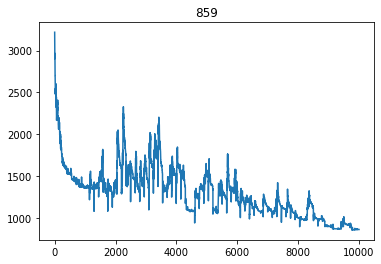

64.0 96.0
80.0 39.0
69.0 23.0
72.0 42.0
48.0 67.0
58.0 43.0
81.0 34.0
79.0 17.0
30.0 23.0
42.0 67.0
7.0 76.0
29.0 51.0
78.0 92.0
64.0 8.0
95.0 57.0
57.0 91.0
40.0 35.0
68.0 40.0
92.0 34.0
62.0 1.0
28.0 43.0
76.0 73.0
67.0 88.0
93.0 54.0
6.0 8.0
87.0 18.0
30.0 9.0
77.0 13.0
78.0 94.0
55.0 3.0
82.0 88.0
73.0 28.0
20.0 55.0
27.0 43.0
95.0 86.0
67.0 99.0
48.0 83.0
75.0 81.0
8.0 19.0
20.0 18.0
54.0 38.0
63.0 36.0
44.0 33.0
52.0 18.0
12.0 13.0
25.0 5.0
58.0 85.0
5.0 67.0
90.0 9.0
41.0 76.0
25.0 76.0
37.0 64.0
56.0 63.0
10.0 55.0
98.0 7.0
16.0 74.0
89.0 60.0
48.0 82.0
81.0 76.0
29.0 60.0
17.0 22.0
5.0 45.0
79.0 70.0
9.0 100.0
17.0 82.0
74.0 67.0
10.0 68.0
48.0 19.0
83.0 86.0
84.0 94.0
-------第0世代-------
Max:4104
Min:3308
ave:3651.24
Best Score:3308
Best root:[30 25 40 51  2 17 62 16 42  3 58 28 46 31 65 35 38 27 26 41 23 19  8 39
 36 49 53 11 45 67 48 20 12 47  6 69 15 24 50 57 33  5 13 34 37 32 10 18
 14 52 60  7 43  9 64 44  4 61 59 21 63 68 54 29 22  1 56 55 66  0]
e_count:0
m_f:True
remai

-------第24世代-------
Max:3228
Min:2587
ave:2939.48
Best Score:2563
Best root:[15 53 61 44 42 37 10 57 52 62 27 48 25 31  0 65 68 14 58 35 30  7 11  9
 24 22 12 46  4 18  5 21 49 23 56 26 13 34 40 54 41  6  3 20 47 59 63 55
 51 32 60  8 38 45 16 64 50 33 19 67 43  2  1 36 69 66 39 29 17 28]
e_count:3
m_f:True
remaining time0.0690989965862698
-------第25世代-------
Max:3296
Min:2557
ave:2879.96
Best Score:2563
Best root:[62 15 53 61 44 10 42 33 57 27 48 11  9 24 17 25 31  0 65 14 58 35 30  7
 22 12 46  4 18  5 49 23 56 37 40 54 41  6  3 20 59 32 47 63 55 51 60  8
 38 45 26 13 34 16 64 50 52 19 67 43  2  1 36 69 21 66 39 29 68 28]
e_count:4
m_f:True
remaining time0.06356005370616913
-------第26世代-------
Max:3073
Min:2557
ave:2843.32
Best Score:2557
Best root:[68 15 53 61 44 62 10 57 27 52 42 25 31  0 14 58 35 30  7  5 65 56 37 11
  9 24 22 12 46 23 26 13 34  4 18 49  3 54 41  6 40 20 59 47 63 17 55 51
 32 60  8 38 45 16 64 50 33 19 67 43 48  1 36 69  2 66 39 21 29 28]
e_count:0
m_f:True
remain

m_f:True
remaining time0.0633423305882348
-------第52世代-------
Max:3007
Min:2336
ave:2661.82
Best Score:2249
Best root:[15 53 61 66 11 42 25  7 31 35 30 58 65 57  9 24 52 22 27 48 26 13 43 12
 46 36  0 69 56 14 37  5 10 49 62 34 28 23 68  1  6  4 40 41 54 18 19 17
  3  2 60 33 16 51 20 59 32 47 63 55  8 38 45 64 50 67 21 29 44 39]
e_count:3
m_f:True
remaining time0.06062883138656616
-------第53世代-------
Max:2949
Min:2336
ave:2639.54
Best Score:2249
Best root:[15 53 61 66 11 42 25  7 31 35 30 58 65 57  9 24 52 22 27 48 26 13 43 12
 46 36  0 69 56 14 37  5 10 49 62 34 28 23 68  1  6  4 40 41 54 18 19 17
  3  2 60 33 16 51 20 59 32 47 63 55  8 38 45 64 50 67 21 29 44 39]
e_count:4
m_f:True
remaining time0.06338295704788632
-------第54世代-------
Max:3030
Min:2330
ave:2618.48
Best Score:2249
Best root:[15 53 61 66 11 42 25  7 31 35 30 58 65 57  9 24 52 22 27 48 26 13 43 12
 46 36  0 69 56 14 37  5 10 49 21 34 28 23 68  1  6  4 40 41 54 18 19 17
  3  2 60 33 16 51 20 59 32 47 63 55  8 38 45 64 5

m_f:True
remaining time0.06322431246439617
-------第79世代-------
Max:2645
Min:1904
ave:2206.98
Best Score:1894
Best root:[24 53 61 11 42 25 52 30 58 65 57  9 35 22 13 27 48 26 43 46 36  0 56 14
 37 69  5 10 49 62 64 34 68 12 28 23  1  3 51 50  6 21  4 40 41 54 18 19
 17  7  2 60 33 20 59 32 31 15 38 47 63 55 66 45 16  8 67 29 44 39]
e_count:1
m_f:True
remaining time0.06321268399556478
-------第80世代-------
Max:2645
Min:1933
ave:2258.04
Best Score:1894
Best root:[24 53 61 11 42 25 31 52 30 58 65 57 15 35 22 13 27 48 26 43 46 36  0 56
 14 37 69  5  3 49 51 62 34 68 12 28 23  1  6 29 19  4 40 41 54 18 21 17
  7  2 60 33 64  9 38 20 66 50 10 59 32 47 63 55 16  8 45 67 44 39]
e_count:2
m_f:True
remaining time0.060464096069335935
-------第81世代-------
Max:2864
Min:1933
ave:2299.72
Best Score:1894
Best root:[24 53 61 11 42 25 31 52 30 58 65 57 15 35 22 13 27 48 26 43 46 36  0 56
 14 37 69  5  3 49 51 62 34 68 12 28 23  1  6 29 19  4 40 41 54 18 21 17
  7  2 60 33 64  9 38 20 66 50 10 59 32 47 63 55

m_f:True
remaining time0.06030385295550029
-------第106世代-------
Max:2491
Min:1934
ave:2123.42
Best Score:1889
Best root:[24 53 61 11 42 52 58 30 65 57 15 35 22 31 25 13 27 48 26 43 36 46  0 56
 14 37  5  3 49 51 62 68 34 12 28 69 23  1  6 29 19 40 41 54 18 21 17  7
  2 33 60 64  9 59 47  4 38 66 44 20 16 55 50 10 63 32  8 45 67 39]
e_count:1
m_f:True
remaining time0.06304261644681294
-------第107世代-------
Max:2484
Min:1892
ave:2132.5
Best Score:1889
Best root:[24 53 61 11 42 52 58 30 65 57 15 35 22 31 25 13 27 48 26 43 36 46  0 56
 14 37  5  3 49 51 62 68 34 12 28 69 23  1  6 29 19 40 41 54 18 21 17  7
  2 33 60 64  9 59 47  4 38 66 20 32 63 55 50 10 16  8 45 44 67 39]
e_count:2
m_f:True
remaining time0.0603106646405326
-------第108世代-------
Max:2359
Min:1889
ave:2129.3
Best Score:1889
Best root:[24 53 61 11 42 52 30 58 65 57 15 35 22 31 25 13 27 48 26 43 36 46  0 56
 14 37  5  3 49 51 62 68 34 12 28 69 23  1  6 29 19 40 41 54 18 21 17  7
  2 33 60 64  9 59 47  4 38 66 20 32 63 55 50 10 

m_f:True
remaining time0.06561720848083497
-------第133世代-------
Max:2381
Min:1806
ave:2107.82
Best Score:1807
Best root:[24 53 61 11 42 52 30 58 65 57 15 35 22 31 13 27 25 48 26 43 36 46  0 56
 14 37  5 49 51 62 34 68 12 28 69 23  1  6 29 19 40 21 41  3 54 18 17  7
  2 33 60 44 20 16 64  9 59 47  4 55 66 32 63 10 50 38  8 45 67 39]
e_count:10
m_f:True
remaining time0.06286535004774729
-------第134世代-------
Max:2415
Min:1806
ave:2093.24
Best Score:1806
Best root:[24 53 61 11 42 52 30 58 65 57 15 35 22 31 13 27 25 48 26 43 36 46  0 56
 14 37  5 49 51 62 34 68 12 28 69 23  1  6 29 19 40 21 41  3 54 18 17  7
  2 33 60 44 20 16 64  9 59 47  4 55 66 32 63 10 50 38  8 45 67 39]
e_count:0
m_f:True
remaining time0.06286551276842753
-------第135世代-------
Max:2415
Min:1806
ave:2122.56
Best Score:1806
Best root:[24 53 61 11 42 52 30 58 65 57 15 35 22 31 13 27 25 48 26 43 36 46  0 56
 14 37  5 49 51 62 34 68 12 28 69 23  1  6 29 19 40 21 41  3 54 18 17  7
  2 33 60 44 20 16 64  9 59 47  4 55 66 32 63

m_f:True
remaining time0.0599732240041097
-------第161世代-------
Max:2538
Min:1837
ave:2127.42
Best Score:1786
Best root:[24 53 11 42 52 30 58 65 57 35 22 31 13 27 25 48 26 43  5 61 36 46 15 56
 14 37 51 49 62 34 68 12 28  0 69 23  1 29 19 40  6 21 41  3 54 18 17  7
  2 33 60 45 38 16  9 44 20 59 47  4 63 10 64 50 55 66 32 67  8 39]
e_count:18
m_f:True
remaining time0.04152848641077678
-------第162世代-------
Max:2516
Min:1936
ave:2152.66
Best Score:1786
Best root:[24 53 61 11 52 30 65 57 15 35 58 22 31 27 25 48 26 43 36 46  0 56 14 37
  5 51 49 62 34 68 12 28 69 23 13 42  3  1  6 29 19 21 41 40 54 18 17  7
  2 33 60 45 38 47 44 20 16 64  9 59 63  4 50 55 66 32 10  8 67 39]
e_count:19
m_f:True
remaining time0.07928520732455784
-------第163世代-------
Max:2516
Min:1936
ave:2181.88
Best Score:1786
Best root:[24 53 11 42 52 30 58 65 57 35 22 31 13 27 25 48 26 61 36 46 15 56 14 37
 51 49 62 34 68 12 28  0 16 69 23  1 29 19 40 43  5  6 21 41  3 54 18 17
  7  2 33 60 45 38  9 50 20 59 47  4 63 10 64

m_f:True
remaining time0.06252780020236968
-------第188世代-------
Max:2570
Min:1887
ave:2190.5
Best Score:1786
Best root:[24 30 58 65 35 31 25 48 26 61  4 22  9 53 57 36 46 15 27 56 14 37 51 49
 62 34 68 12 28  0 69 23 29 19 13 43  5 40  6  1 41 11 32 52 21  3 54 17
 18  7  2 42 33 60 45 38 16 44 20 59 50 64 47 63 55 66 10 67  8 39]
e_count:45
m_f:True
remaining time0.0624505975511339
-------第189世代-------
Max:2556
Min:1898
ave:2180.9
Best Score:1786
Best root:[24 30  4 53 65 35 31 27 25 48 61 26 46 15 58 22  9 57 36 56 14 37 51 49
 62 34 68 12 28  0 69 23 29 19 13 43  5 40  6  1 41 11 32 52 21  3 54 17
 18  7  2 42 33 60 45 67 16 38 44 20 59 47 63 64 55 50 10 66  8 39]
e_count:46
m_f:True
remaining time0.06258068177435133
-------第190世代-------
Max:2594
Min:1850
ave:2101.06
Best Score:1786
Best root:[24 30 58 65 35 31 25 48 26 61  4 22  9 53 57 36 46 15 27 56 14 37 51 49
 62 34 68 12 28  0 69 23 29 19 13 43  5 40  6  1 41 11 32 52 21  3 54 17
 18  7  2 42 33 60 45 67 16 38 44 20 59 50 64 4

m_f:False
remaining time0.062399828831354774
-------第215世代-------
Max:2424
Min:1692
ave:2033.58
Best Score:1752
Best root:[24 30 58 65 31 25 48 26 61  4 22  9 53 57 36 46 15 35 56 14 62 51 49 37
 21 34 68 12 28  0 69 23 29 19 43  5 40 17  6 27 13  1 41 11 32 52  3 54
 18  7  2 42 33 60 45 67 16 44 38 20 59 50 64 47 63 55 10 66  8 39]
e_count:3
m_f:False
remaining time0.06230337553554111
-------第216世代-------
Max:2403
Min:1700
ave:1986.16
Best Score:1692
Best root:[24 27 58 65 31 25 48 26 61  4 22  9 53 57 36 46 15 35 30 56 14 37 21 51
 49 62 34 68 12 28  0 69 23 29 19 13 43  5 40  6  1 32 11 41 17 52  3 54
 18  7  2 42 33 60 45 44 67 16 38 20 59 50 64 63 47 55 10 66  8 39]
e_count:0
m_f:False
remaining time0.06234625392489963
-------第217世代-------
Max:2361
Min:1666
ave:1960.66
Best Score:1692
Best root:[24 17 58 65 31 25 48 26 61  4 22  9 53 57 36 46 15 35 30 56 14 37 21 51
 49 62 34 68 12 28  0 69 23 29 19 13 43  5 40  6  1 27 41 11 32 52  3 54
 18  7  2 42 33 60 45 67 16 38 44 20 59 55

m_f:False
remaining time0.06759012420972188
-------第242世代-------
Max:2124
Min:1620
ave:1773.5
Best Score:1620
Best root:[24 65 31 25 48 26 61  4 22 46  9 53 57 36 15 35 30 14 56 58 37 21 51 49
 62 34 68 12 28  0 69 23 29 19 13 43 27  5 40 17  6  1 41 11 32 52  3 54
 18  7  2 42 33 60 45 67 16 44 38 20 59 50 47 55 64 63 10 66  8 39]
e_count:1
m_f:False
remaining time0.06218509872754415
-------第243世代-------
Max:2407
Min:1620
ave:1756.98
Best Score:1620
Best root:[24 65 31 25 48 26 61  4 22 46  9 53 57 36 15 35 30 14 56 58 37 21 51 49
 62 34 68 12 28  0 69 23 29 19 13 43 27  5 40 17  6  1 41 11 32 52  3 54
 18  7  2 42 33 60 45 67 16 44 38 20 59 50 47 55 64 63 10 66  8 39]
e_count:2
m_f:False
remaining time0.06216192530261146
-------第244世代-------
Max:2099
Min:1620
ave:1761.8
Best Score:1620
Best root:[24 65 31 25 48 26 61  4 22 46  9 53 57 36 15 35 30 14 56 58 37 21 51 49
 62 34 68 12 28  0 69 23 29 19 13 43 27  5 40 17  6  1 41 11 32 52  3 54
 18  7  2 42 33 60 45 67 16 44 38 20 59 50 47

m_f:False
remaining time0.08010333842701382
-------第268世代-------
Max:2313
Min:1602
ave:1768.06
Best Score:1602
Best root:[24 65 31 25 48 26 61 22 46  4  9 53 57 36 15 35 30 14 56 58 37 62 51 49
 21 34 68 12 28  0 69 23 13 19 29 43 27  5 17  6  1 41 40 11 32 52  3 54
 18  7  2 42 33 60 45 67 16 44 38 20 59 50 47 55 64 63 10 66  8 39]
e_count:8
m_f:False
remaining time0.04229823509852092
-------第269世代-------
Max:1996
Min:1602
ave:1752.48
Best Score:1602
Best root:[24 65 31 25 48 26 61 22 46  4  9 53 57 36 15 35 30 14 56 58 37 21 51 49
 62 34 68 12 28  0 69 23 13 19 29 43 27  5 17  6  1 41 40 11 32 52  3 54
 18  7  2 42 33 60 45 67 16 44 38 20 59 50 47 55 64 63 10 66  8 39]
e_count:9
m_f:False
remaining time0.08444793005784353
-------第270世代-------
Max:2122
Min:1605
ave:1774.38
Best Score:1602
Best root:[24 65 31 25 48 26 61 22 46  4  9 53 57 36 15 35 30 14 56 58 37 62 51 49
 21 34 68 12 28  0 69 23 13 19 29 43 27  5 17  6  1 41 40 11 32 52  3 54
 18  7  2 42 33 60 45 67 16 44 38 20 59 50 

m_f:False
remaining time0.06720440877808465
-------第295世代-------
Max:2249
Min:1585
ave:1747.92
Best Score:1585
Best root:[24 65 31 25 48 26 61 46  4  9 51 53 57 36 15 35 30 14 56 58 37 21 22 49
 62 34 68 12 28  0 69 23 13 29 19 43 27  5 17  6  1 41 40 11 32 52  3 54
 18  7  2 42 33 60 45 67 16 44 38 20 59 50 47 55 64 63 10 66  8 39]
e_count:0
m_f:False
remaining time0.06454555292924245
-------第296世代-------
Max:2089
Min:1566
ave:1729.88
Best Score:1585
Best root:[24 65 31 25 48 26 61 46  4  9 51 53 57 36 15 35 30 14 56 58 37 21 22 49
 62 34 68 12 28  0 69 23 43 29 19 13 27  5 17  6  1 41 40 11 32 52  3 54
 18  7  2 42 33 60 45 67 16 44 38 20 59 50 47 55 64 63 10 66  8 39]
e_count:1
m_f:False
remaining time0.06182876057094998
-------第297世代-------
Max:2087
Min:1585
ave:1735.52
Best Score:1566
Best root:[24 65 31 25 48 26 61 46  4  9 51 53 57 36 15 35 30 14 56 58 37 21 22 49
 62 34 68 12 28  0 69 23 13 29 19 43 27  5 17  6  1 41 40 11 32 52  3 54
 18  7  2 42 33 60 45 67 16 44 38 20 59 50 

m_f:False
remaining time0.061684179306030276
-------第321世代-------
Max:2413
Min:1574
ave:1788.36
Best Score:1565
Best root:[24 65 31 25 48 26 61 46  4  9 51 53 57 36 15 22 30 14 56 58 35 49 37 21
 62 34 68 12 28  0 69 23 13 29 19 43 27  5 17  6  1 41 40 11 32 52  3 54
 18  7  2 42 33 60 16 67 45 44 38 20 59 50 47 55 64 63 10 66  8 39]
e_count:11
m_f:False
remaining time0.058988108701176115
-------第322世代-------
Max:2413
Min:1568
ave:1788.74
Best Score:1565
Best root:[24 65 31 25 48 26 61 46  4  9 51 53 57 36 15 35 30 14 56 37 22 49 58 21
 62 34 68 12 28  0 69 23 13 29 19 43 27  5 17  6  1 41 40 11 32 52  3 54
 18  7  2 42 33 60 16 67 45 44 38 20 59 50 47 55 64 63 10 66  8 39]
e_count:12
m_f:False
remaining time0.06434739510218303
-------第323世代-------
Max:2145
Min:1568
ave:1804.9
Best Score:1565
Best root:[24 65 31 25 48 26 61 46  4  9 51 53 57 36 15 35 30 14 56 37 22 49 58 21
 62 34 68 12 28  0 69 23 13 29 19 43 27  5 17  6  1 41 40 11 32 52  3 54
 18  7  2 42 33 60 16 67 45 44 38 20 59 

m_f:False
remaining time0.06953734119733175
-------第347世代-------
Max:1879
Min:1405
ave:1587.38
Best Score:1405
Best root:[24 31 48 25 26 61 53  4  9 51 46 57 36 15 35 30 14 56 58 37 22 49 21 65
 62 34 69 12 28  0 68 23 13 29 19 43 27  5 17  1  6 41 40 11 32 52  3 18
 54  7  2 42 33 60 16 67 45 44 38 20 59 50 66 55 64 63 10 47  8 39]
e_count:1
m_f:False
remaining time0.0641869279411104
-------第348世代-------
Max:2007
Min:1405
ave:1614.82
Best Score:1405
Best root:[24 31 48 25 26 61 53  4  9 51 46 57 36 15 35 30 14 56 58 37 22 49 21 65
 62 34 69 12 28  0 68 23 13 29 19 43 27  5 17  1  6 41 40 11 32 52  3 18
 54  7  2 42 33 60 16 67 45 44 38 20 59 50 66 55 64 63 10 47  8 39]
e_count:2
m_f:False
remaining time0.06417388624615139
-------第349世代-------
Max:2026
Min:1405
ave:1623.88
Best Score:1405
Best root:[24 31 48 25 26 61 53  4 51  9 46 57 36 15 35 30 14 56 58 37 22 49 21 65
 62 34 69 12 28  0 68 23 13 29 19 43 27  5 17  1  6 41 40 11 32 52  3 18
 54  7  2 42 33 60 16 67 45 44 38 20 59 50 6

m_f:False
remaining time0.07201538801193237
-------第373世代-------
Max:2365
Min:1406
ave:1607.84
Best Score:1399
Best root:[24 31 25 48 26 61 53  4  9 51 46 57 36 15 35 30 14 56 58 37 22 49 21 65
 62 34 12 28  0 69 68 23 13 29 19 43 27  5 17  6  1 41 40 11 32 52  3 18
 54  7  2 42 38 60 16 67 45 44 33 20 59 50 66 55 64 63 10 47  8 39]
e_count:22
m_f:False
remaining time0.06399810353914896
-------第374世代-------
Max:2077
Min:1406
ave:1583.04
Best Score:1399
Best root:[24 31 25 48 26 61 53  4  9 51 46 57 36 15 35 30 14 56 58 37 22 49 62 65
 21 34 12 28  0 69 68 23 13 29 19 43 27  5 17  6  1 41 40 11 32 52  3 18
 54  7  2 42 38 60 16 67 45 44 33 20 59 50 55 66 64 63 10 47  8 39]
e_count:23
m_f:False
remaining time0.06660905043284099
-------第375世代-------
Max:2299
Min:1407
ave:1631.84
Best Score:1399
Best root:[24 31 25 48 26 61 53  4  9 51 46 57 36 15 35 30 14 56 37 22 49 65 58 21
 62 34 12 28  0 69 68 23 13 19 29 43 27  5 17  6  1 41 40 11 32 52  3 18
 54  7  2 42 38 60 16 67 45 44 33 20 59 5

m_f:False
remaining time0.06383954021665784
-------第399世代-------
Max:1912
Min:1402
ave:1558.7
Best Score:1384
Best root:[24 31 25 48 26 61 53  4 51  9 57 49 15 36 35 58 56 30 37 22 46 65 21 62
 34 12 28  0 69 68 14 23 13 29 19 43 27  5 17  6  1 41 40 32 11 52  3 18
 54  7  2 42 67 60 38 44 45 16 33 20 59 50 66 55 64 63 10 47  8 39]
e_count:4
m_f:False
remaining time0.0611782216363483
-------第400世代-------
Max:2216
Min:1379
ave:1596.58
Best Score:1384
Best root:[24 31 25 48 26 61 53  4  9 51 57 36 15 46 35 21 56 58 37 22 49 65 30 62
 34 12 28 69  0 68 14 23 13 29 19 43 27  5 17  6  1 41 40 32 11 52  3 18
 54  7  2 42 67 60 38 44 45 16 33 20 59 50 66 55 64 63 10 47  8 39]
e_count:5
m_f:False
remaining time0.06388346354166667
-------第401世代-------
Max:2216
Min:1379
ave:1597.82
Best Score:1379
Best root:[24 31 25 48 26 61 53  4  9 51 57 36 15 46 35 21 56 58 37 22 49 65 30 62
 34 12 28 69  0 68 14 23 13 29 19 43 27  5 17  6  1 41 40 32 11 52  3 18
 54  7  2 42 67 60 38 44 45 16 33 20 59 50 66

m_f:False
remaining time0.06631511946519215
-------第426世代-------
Max:2011
Min:1288
ave:1459.2
Best Score:1302
Best root:[24 31 25 48 26 61 53  4  9 51 49 57 15 36 35 30 58 37 22 46 65 21 62 68
 12 28  0 69 34 14 23 56 29 19 43 13 27  5 17  6  1 41 40 32 11 52  3 18
 54  7  2 67 42 60 38 44 45 16 33 20 59 50 55 66 64 63 10 47  8 39]
e_count:0
m_f:False
remaining time0.066319606701533
-------第427世代-------
Max:2011
Min:1315
ave:1483.9
Best Score:1288
Best root:[24 31 25 48 26 61 53  4  9 51 49 57 15 36 35 30 58 37 22 46 65 21 62 68
 12 28  0 69 34 14 23 56 29 13 27 43 19  5 17  6  1 41 40 32 11 52  3 18
 54  7  2 67 42 60 44 38 45 16 33 20 59 50 55 66 64 63 10 47  8 39]
e_count:0
m_f:False
remaining time0.06623786826928457
-------第428世代-------
Max:1912
Min:1288
ave:1480.56
Best Score:1288
Best root:[24 31 25 48 26 61 53  4  9 51 49 57 15 36 35 30 58 37 22 46 65 21 62 68
 12 28  0 69 34 14 23 56 29 19 43 13 27  5 17  6  1 41 40 32 11 52  3 18
 54  7  2 67 42 60 38 44 45 16 33 20 59 50 55 6

m_f:False
remaining time0.06613631188869476
-------第452世代-------
Max:1779
Min:1279
ave:1388.4
Best Score:1279
Best root:[24 31 25 48 26 61 53  4  9 51 49 57 15 36 35 30 58 37 22 46 21 65 62 68
 12 28  0 69 34 14 23 56 19 29 43 13 27  5 17  1  6 41 40 32 11 52  3 18
 54  7  2 67 42 60 38 44 45 16 20 33 59 50 55 66 64 63 10 47  8 39]
e_count:0
m_f:False
remaining time0.06612938589519925
-------第453世代-------
Max:1922
Min:1279
ave:1377.14
Best Score:1279
Best root:[24 31 25 48 26 61 53  4  9 51 49 57 15 36 35 30 58 37 22 46 21 65 62 68
 12 28  0 69 34 14 23 56 19 29 43 13 27  5 17  1  6 41 40 32 11 52  3 18
 54  7  2 67 42 60 38 44 45 16 20 33 59 50 55 66 64 63 10 47  8 39]
e_count:1
m_f:False
remaining time0.06617304172780779
-------第454世代-------
Max:1657
Min:1279
ave:1368.02
Best Score:1279
Best root:[24 31 25 48 26 61 53  4  9 51 49 57 15 36 35 30 58 37 22 46 21 65 62 68
 12 28  0 69 34 14 23 56 19 29 43 13 27  5 17  1  6 41 40 32 11 52  3 18
 54  7  2 67 42 60 38 44 45 16 20 33 59 50 5

m_f:False
remaining time0.06331934889157613
-------第478世代-------
Max:1910
Min:1258
ave:1528.66
Best Score:1241
Best root:[24 31 25 48 26 61 53  4  9 51 49 57 36 15 35 30 58 37 22 46 21 62 65 68
 12 28  0 69 34 14 23 56 43 29 19 13 27  5 17  1  6 41 40 32 11 52  3 18
 54  7  2 67 42 60 38 44 45 16 33 20 59 50 55 66 64 63 47 10  8 39]
e_count:5
m_f:False
remaining time0.060671675205230716
-------第479世代-------
Max:2124
Min:1235
ave:1537.38
Best Score:1241
Best root:[24 31 25 48 26 61 53  4  9 51 49 57 36 15 35 30 58 37 22 46 21 62 65 68
  0 28 12 69 34 14 23 56 43 29 19 13 27 41 17  1  6  5 40 32 11 52  3 18
 54  7  2 67 42 60 38 44 45 16 33 20 59 50 55 66 10 63 64 47  8 39]
e_count:6
m_f:False
remaining time0.06331235620710585
-------第480世代-------
Max:2191
Min:1235
ave:1511.66
Best Score:1235
Best root:[24 31 25 48 26 61 53  4  9 51 49 57 36 15 35 30 58 37 22 46 21 62 65 68
  0 28 12 69 34 14 23 56 43 29 19 13 27 41 17  1  6  5 40 32 11 52  3 18
 54  7  2 67 42 60 38 44 45 16 33 20 59 50

m_f:False
remaining time0.06833261118994818
-------第505世代-------
Max:1710
Min:1243
ave:1382.14
Best Score:1235
Best root:[24 31 25 48 26 61 53  4  9 51 49 36 57 15 35 30 22 37 58 21 65 62 46 68
 12 28  0 69 34 14 23 56 43 29 19 13 27 41 17  1  6  5 40 32 11 52  3 18
 54  7  2 67 42 60 38 44 45 16 33 20 59 50 55 66 64 63 10 47  8 39]
e_count:25
m_f:False
remaining time0.06582833528518676
-------第506世代-------
Max:1790
Min:1243
ave:1382.4
Best Score:1235
Best root:[24 26 25 48 31 61 53  4  9 49 57 36 15 35 30 58 22 37 51 21 65 62 46 68
 28 12  0 56 69 34 14 23 43 29 19 13 27 41 17  1  6  5 40 32 11 52  3 18
 54  7  2 67 42 60 38 44 45 16 20 33 59 50 55 66 64 63  8 47 10 39]
e_count:26
m_f:False
remaining time0.06575475348366631
-------第507世代-------
Max:1857
Min:1256
ave:1391.3
Best Score:1235
Best root:[24 31 25 48 26 61 53  4  9 49 57 36 15 51 35 30 58 37 22 46 21 65 68 62
  0 12 28 69 34 14 23 56 43 29 19 13 27 41 17  1  6  5 40 32 11 52  3 18
 54  7  2 67 42 60 38 44 59 16 33 20 45 50 

m_f:False
remaining time0.06558476818932427
-------第531世代-------
Max:1710
Min:1236
ave:1355.62
Best Score:1235
Best root:[24 31 25 48 26 61 53  4  9 51 49 57 36 15 35 30 22 37 58 21 65 62 68 28
 12 69  0 46 34 14 56 23 43 29 19 13 27 41 17  1  6  5 40 11 32 52  3 18
 54  7  2 67 42 60 38 44 45 16 20 33 59 50 55 66 64 63 10 47  8 39]
e_count:51
m_f:False
remaining time0.060270635353194345
-------第532世代-------
Max:1755
Min:1236
ave:1321.56
Best Score:1235
Best root:[24 31 25 48 26 61 53  4  9 51 49 57 36 15 35 30 22 37 58 21 65 62 68 28
 12 69  0 46 34 14 56 23 43 29 19 13 27 41 17  1  6  5 40 11 32 52  3 18
 54  7  2 67 42 60 38 44 45 16 20 33 59 50 55 66 64 63 10 47  8 39]
e_count:52
m_f:False
remaining time0.0603953218460083
-------第533世代-------
Max:2036
Min:1225
ave:1324.46
Best Score:1235
Best root:[24 31 25 48 26 61 53 51  9  4 49 36 57 15 35 30 22 37 58 21 65 62 68 28
 12 69  0 46 34 14 56 23 43 29 19 13 27 41 17  1  6  5 40 11 32 52  3 18
 54  7  2 67 42 60 38 44 45 16 20 33 59 5

m_f:False
remaining time0.0627968019247055
-------第558世代-------
Max:1716
Min:1222
ave:1364.26
Best Score:1220
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 30 22 37 58 21 65 62 68 28
 12 69  0 46 34 14 23 56 43 29 19 13 27 41 17  1  6  5 40 11 32 52  3 18
 54  7  2 67 42 60 38 44 45 16 20 33 59 50 55 66 64 63 10 47  8 39]
e_count:13
m_f:False
remaining time0.06271323760350546
-------第559世代-------
Max:1780
Min:1222
ave:1369.34
Best Score:1220
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 30 22 37 58 21 65 62 68 28
 12 69  0 46 34 14 23 56 43 29 19 13 27 41 17  1  6  5 40 11 32 52  3 18
 54  7  2 67 42 60 38 44 45 16 20 33 59 50 55 66 64 63 10 47  8 39]
e_count:14
m_f:False
remaining time0.0706723153591156
-------第560世代-------
Max:2060
Min:1220
ave:1378.64
Best Score:1220
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 30 22 37 58 21 65 62 68 28
 69 12  0 46 34 14 23 56 43 29 19 13 27 41 17  1  6  5 40 11 32 52  3 18
 54  7  2 67 42 60 38 44 45 16 20 33 59 50 

m_f:False
remaining time0.06783432483673096
-------第583世代-------
Max:2144
Min:1207
ave:1488.88
Best Score:1207
Best root:[24 31 25 48 26 61 53 51  9  4 49 36 57 15 35 22 37 30 58 21 65 62 68 28
 69 12  0 46 34 14 23 56 43 29 19 13 27 41 17  1  6  5 40 11 32 52  3 18
 54  7  2 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:1
m_f:False
remaining time0.06259708205858866
-------第584世代-------
Max:2144
Min:1224
ave:1468.36
Best Score:1207
Best root:[24 31 25 48 26 61 53 51  9  4 49 36 57 15 35 22 37 30 58 21 65 62 46 68
 28 69 12  0 34 14 23 56 43 29 19 13 27 41 17  1  6  5 40 11 32 52  3 18
 54  7  2 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:2
m_f:False
remaining time0.06261724948883057
-------第585世代-------
Max:2032
Min:1207
ave:1487.64
Best Score:1207
Best root:[24 31 25 48 26 61 53 51  9  4 49 36 57 15 35 22 37 30 58 21 65 62 68 28
 69 12  0 46 34 14 23 56 43 29 19 13 27 41 17  1  6  5 40 11 32 52  3 18
 54  7  2 67 39 60 38 44 45 42 16 20 33 59 

m_f:False
remaining time0.05983697772026062
-------第610世代-------
Max:1942
Min:1207
ave:1383.0
Best Score:1207
Best root:[24 31 25 48 26 61 53 51  9  4 49 36 57 15 35 22 37 30 58 21 65 62 68 28
 69 12  0 46 34 14 23 56 43 29 19 13 27 41 17  1  6  5 40 11 32 52  3 18
 54  7  2 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:28
m_f:False
remaining time0.059833093484242754
-------第611世代-------
Max:1793
Min:1207
ave:1368.48
Best Score:1207
Best root:[24 31 25 48 26 61 53 51  9  4 49 36 57 15 35 22 37 30 58 21 65 62 68 28
 69 12  0 46 34 14 23 56 43 29 19 13 27 41 17  1  6  5 40 11 32 52  3 18
 54  7  2 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:29
m_f:False
remaining time0.05722445123725467
-------第612世代-------
Max:1635
Min:1207
ave:1384.14
Best Score:1207
Best root:[24 31 25 48 26 61 53 51  9  4 49 36 57 15 35 22 37 30 58 21 65 62 68 28
 69 12  0 46 34 14 23 56 43 29 19 13 27 41 17  1  6  5 40 11 32 52  3 18
 54  7  2 67 39 60 38 44 45 42 16 20 33 5

m_f:False
remaining time0.06490523550245497
-------第637世代-------
Max:1852
Min:1215
ave:1402.0
Best Score:1205
Best root:[24 31 25 48 26 61 53 51  9  4 49 36 57 15 35 22 37 30 58 21 65 62 68 12
 28 69  0 46 34 14 23 56 43 29 13 19 27 41 17  1  6  5 40 11 32 52  3 18
 54  7  2 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:21
m_f:False
remaining time0.05967097083727519
-------第638世代-------
Max:1872
Min:1215
ave:1408.1
Best Score:1205
Best root:[24 31 25 48 26 61 53 51  9  4 49 36 57 15 35 22 37 30 58 21 65 62 68 12
 28 69  0 46 34 14 23 56 43 29 13 19 27 41 17  1  6  5 40 11 32 52  3 18
 54  7  2 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:22
m_f:False
remaining time0.06742167750994364
-------第639世代-------
Max:1783
Min:1211
ave:1384.78
Best Score:1205
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 22 37 30 21 62 65 58 68 28
 12 69  0 46 34 14 23 56 43 29 19 13 27 41 17  1  6  5 40 32 11 52  3 18
 54  7  2 67 39 60 38 44 45 42 16 20 33 59 

m_f:False
remaining time0.06465377887090047
-------第664世代-------
Max:1761
Min:1207
ave:1366.08
Best Score:1205
Best root:[24 31 25 48 26 61 53 51  9  4 49 36 57 15 35 22 37 30 58 21 65 62 68 12
 28 69  0 46 34 14 23 56 43 29 19 13 27 41 17  1  6  5 40 11 32 52  3 18
 54  7  2 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:48
m_f:False
remaining time0.05946427345275879
-------第665世代-------
Max:1783
Min:1205
ave:1373.62
Best Score:1205
Best root:[24 31 25 48 26 61 53 51  9  4 49 36 57 15 35 22 30 37 58 21 65 62 68 12
 28 69  0 46 34 14 23 56 43 29 19 13 27  6 17  1 41  5 40 11 32 52  3 18
 54  7  2 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:49
m_f:False
remaining time0.06007551848888397
-------第666世代-------
Max:1723
Min:1205
ave:1349.54
Best Score:1205
Best root:[24 31 25 48 26 61 53 51  9  4 49 36 57 15 35 22 30 37 58 21 65 62 68 12
 28 69  0 46 34 14 23 56 43 29 19 13 27  6 17  1 41  5 40 11 32 52  3 18
 54  7  2 67 39 60 38 44 45 42 16 20 33 5

Max:2330
Min:1227
ave:1490.7
Best Score:1191
Best root:[24 31 25 48 26 61 53 51  9  4 49 36 57 15 22 35 30 37 58 21 65 62 68 12
 28 69  0 46 34 14 23 56 43 29 19 13 27  6 17 18 41  5 40 11 32 52  3  1
 54  7  2 67 39 60 38 44 45 42 16 20 33 59 50 66 55 64 63 10 47  8]
e_count:13
m_f:False
remaining time0.061887676848305595
-------第691世代-------
Max:1855
Min:1261
ave:1509.7
Best Score:1191
Best root:[24 31 25 48 26 61 53 51  9  4 49 36 57 15 22 35 30 37 58 21 65 62 68 12
 28 69  0 46 34 14 23 56 43 29 19 13 27  6 17 18 41  5 40 11 32 52  3  1
 54  7  2 67 39 60 38 45 44 20 42 16 33 59 50 55 66 64 63 10 47  8]
e_count:14
m_f:False
remaining time0.06189767519632975
-------第692世代-------
Max:1915
Min:1226
ave:1520.9
Best Score:1191
Best root:[24 31 25 48 26 61 53 51  9  4 49 36 57 15 35 22 37 30 58 65 62 21 68 12
 28 69  0 46 34 14 23 56 43 29 19 13 27  6 17  1 18 41  5 40 11 32 52  3
 54  7  2 67 39 60 38 44 45 42 16 20 33 59 50 66 55 64 63 10 47  8]
e_count:15
m_f:False
remaining time0.061

Max:1794
Min:1223
ave:1390.0
Best Score:1191
Best root:[24 31 25 48 26 61 53  9 51  4 36 49 57 15 22 35 37 30 65 62 21 68 12 28
 69  0 46 34 58 56 23 14 43 29 19 13 27  6 17 18  1 41  5 40 11 32  3 52
 54  7  2 67 39 60 38 64 33 47 45 44 16 20 59 50 66 55 63 42 10  8]
e_count:38
m_f:False
remaining time0.059173257152239485
-------第716世代-------
Max:1817
Min:1223
ave:1385.66
Best Score:1191
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 22 30 37 21 65 62 68 12 28
 69  0 34 56 58 46 14 23 43 29 19 13 27  6 17 18  2 41  5 40 11 32 52  3
 54  7  1 67 39 60 38 44 45 42 63 20 33 59 50 66 55 64 16 10 47  8]
e_count:39
m_f:False
remaining time0.059165039592319064
-------第717世代-------
Max:1794
Min:1223
ave:1412.08
Best Score:1191
Best root:[24 31 25 48 26 61 53  9 51  4 36 49 57 15 22 35 37 30 65 62 21 68 12 28
 69  0 46 34 58 56 23 14 43 29 19 13 27  6 17 18  1 41  5 40 11 32 52  3
 54  7  2 67 39 60 38 44 45 42 16 20 33 59 50 66 55 64 63 47 10  8]
e_count:40
m_f:False
remaining time0.

m_f:False
remaining time0.0589989744954639
-------第742世代-------
Max:1929
Min:1219
ave:1411.7
Best Score:1191
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 22 37 30 21 65 62 68 12 28
 69  0 46 58 34 23 14 56 43 29 19 13 27 18  6 17  1 41  5 40 11 32 52  3
 54  7  2 67 39 60 38 44 45 42 16 20 33 59 50 66 55 64 63 10 47  8]
e_count:65
m_f:False
remaining time0.05897727409998576
-------第743世代-------
Max:1892
Min:1219
ave:1413.22
Best Score:1191
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 22 37 30 21 65 62 68 12 28
 69  0 46 58 34 23 14 56 43 29 19 13 27 18  6 17  1 41  5 40 11 32 52  3
 54  7  2 67 39 60 38 44 45 42 16 20 33 59 50 66 55 64 63 10 47  8]
e_count:66
m_f:False
remaining time0.0589966524971856
-------第744世代-------
Max:1962
Min:1225
ave:1432.82
Best Score:1191
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 22 37 30 21 65 62 68 12 28
 69  0 46 34 58 23 14 56 43 29 19 13 27 18  6 17  1 41  5 40 11 32 52  3
 54  7  2 67 39 60 38 44 45 42 16 20 33 59 5

m_f:False
remaining time0.05876150767008464
-------第769世代-------
Max:1828
Min:1242
ave:1414.36
Best Score:1191
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 22 37 30 21 65 62 68 12 28
 69  0 46 34 58 23 14 56 43 29 19 13 27 18  6  2 17  1 41  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 33 59 50 66 55 64 63 10 47  8]
e_count:92
m_f:False
remaining time0.06144016981124878
-------第770世代-------
Max:1921
Min:1242
ave:1406.76
Best Score:1191
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 22 37 30 21 65 62 68 12 28
 69  0 46 34 58 23 14 56 43 29 19 13 27 18  6  2 17  1 41  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 33 59 50 66 55 64 63 10 47  8]
e_count:93
m_f:False
remaining time0.05880929430325826
-------第771世代-------
Max:1764
Min:1242
ave:1395.82
Best Score:1191
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 22 37 30 21 65 62 68 12 28
 69  0 46 34 58 23 14 56 43 29 19 13 27 18  6  2 17  1 41  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 33 5

m_f:False
remaining time0.06376252518759834
-------第795世代-------
Max:1974
Min:1240
ave:1389.58
Best Score:1191
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 22 37 21 65 62 68 30 12 28
 69  0 46 34 58 23 14 56 43 29 19 13 27 18  6 41  1 17  2  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:118
m_f:False
remaining time0.061200668745570716
-------第796世代-------
Max:1533
Min:1223
ave:1340.02
Best Score:1191
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 22 37 21 65 62 68 30 12 28
 69  0 46 34 58 23 14 56 43 29 19 13 27 18  6  2 41  1 17  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:119
m_f:False
remaining time0.0586405865351359
-------第797世代-------
Max:1857
Min:1223
ave:1359.78
Best Score:1191
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 22 37 21 65 62 68 30 12 28
 69  0 46 34 58 23 14 56 43 29 19 13 27 18  6  2 41  1 17  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 33

m_f:False
remaining time0.06096636056900025
-------第821世代-------
Max:1865
Min:1220
ave:1430.32
Best Score:1191
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 15 36 35 22 37 21 65 62 68 28 12 30
 69  0 46 34 58 23 14 56 43 29 13 19 27 18  6  1 41  2 17  5 40 11 52 32
  3 54  7 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:144
m_f:False
remaining time0.05853844907548692
-------第822世代-------
Max:1887
Min:1230
ave:1436.98
Best Score:1191
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 35 22 37 65 58 21 62 68 30 12 28
 69  0 46 15 34 56 14 23 43 29 13 19 27 18  6  1 41  2 17  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:145
m_f:False
remaining time0.061036351521809896
-------第823世代-------
Max:1848
Min:1239
ave:1469.44
Best Score:1191
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 15 36 35 22 37 21 65 62 68 12 28 30
 69  0 46 58 34 56 14 23 43 29 13 19 27 18  6  1  2 41 17  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 3

m_f:False
remaining time0.060873066584269206
-------第845世代-------
Max:1861
Min:1209
ave:1403.56
Best Score:1054
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 22 37 65 21 62 68 30 12 28
 69  0 46 58 34 56 14 23 43 29 13 19 27 18  6  1  2 41 17  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:18
m_f:False
remaining time0.05835204356246525
-------第846世代-------
Max:1714
Min:1209
ave:1385.76
Best Score:1054
Best root:[24 31 25 48 26 61 51 53  9 49  4 57 36 15 35 22 37 65 58 21 62 68 30 12
 28 69  0 46 34 14 56 23 43 29 13 19 27 17 18  6  1  2 41  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:19
m_f:False
remaining time0.060860982206132674
-------第847世代-------
Max:1829
Min:1209
ave:1382.16
Best Score:1054
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 22 37 65 21 62 68 30 12 28
 69  0 46 58 34 56 14 23 43 29 13 19 27 18  6  1  2 41 17  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 33

m_f:False
remaining time0.0581769777668847
-------第871世代-------
Max:1864
Min:1213
ave:1410.44
Best Score:1054
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 22 37 65 21 62 58 68 30 12
 28 69  0 46 34 56 14 23 43 19 13 29 27 18  6  1  2 41 17  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:44
m_f:False
remaining time0.06068569918473562
-------第872世代-------
Max:1677
Min:1213
ave:1403.62
Best Score:1054
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 22 37 65 21 62 58 68 30 12
 28 69  0 46 34 56 14 23 43 19 13 29 27 18  6  1  2 41 17  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:45
m_f:False
remaining time0.05959211826324463
-------第873世代-------
Max:1919
Min:1213
ave:1427.76
Best Score:1054
Best root:[24 31 25 48 26 61 53 51  9  4 49 57 36 15 35 22 37 65 21 62 58 68 30 12
 28 69  0 46 34 56 14 23 43 19 13 29 27 18  6  1  2 41 17  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 33 59

m_f:False
remaining time0.055477106968561805
-------第898世代-------
Max:1852
Min:1166
ave:1350.48
Best Score:1054
Best root:[31 25 48 26 24 61 53 51  9  4 49 57 36 15 35 22 37 65 21 62 58 68 30 12
 28 69  0 46 34 56 14 23 43 29 13 19 27 18  6  1  2 41 17  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:71
m_f:False
remaining time0.05799132625261943
-------第899世代-------
Max:2054
Min:1166
ave:1376.28
Best Score:1054
Best root:[31 25 48 26 24 61 53 51  9  4 49 57 36 15 35 22 37 65 21 62 58 68 30 12
 28 69  0 46 34 56 14 23 43 29 13 19 27 18  6  1  2 41 17  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:72
m_f:False
remaining time0.06052126559946272
-------第900世代-------
Max:1723
Min:1168
ave:1339.82
Best Score:1054
Best root:[31 25 48 26 24 61 53 51  9  4 49 57 36 15 35 22 37 65 21 62 58 68 30 12
 28 69  0 46 34 56 14 23 43 13 19 29 27 18  6  1  2 41 17  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 33 

m_f:False
remaining time0.06286183264520433
-------第924世代-------
Max:1755
Min:1157
ave:1286.94
Best Score:1054
Best root:[31 25 48 26 24 61 53 51  9  4 49 57 36 15 35 22 37 21 62 65 58 68 30 12
 28 46  0 69 34 56 14 23 43 13 29 19 27 18  6  1  2 41 17  5 40 11 32 52
  3 54  7 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:97
m_f:False
remaining time0.06034419722027249
-------第925世代-------
Max:1760
Min:1149
ave:1295.64
Best Score:1054
Best root:[31 25 48 26 24 61 53 51  9  4 49 57 36 15 35 22 37 21 65 62 58 68 30 12
 28 46  0 69 34 56 14 23 43 13 29 19 27 54  6  1  2 41 17  5 40 11 32 52
  3 18  7 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:98
m_f:False
remaining time0.05782050391038259
-------第926世代-------
Max:1724
Min:1149
ave:1313.68
Best Score:1054
Best root:[31 25 48 26 24 61 53 51  9  4 49 57 36 15 35 22 37 21 65 62 58 68 30 12
 28 46  0 69 34 56 14 23 43 13 29 19 27 54  6  1  2 41 17  5 40 11 32 52
  3 18  7 67 39 60 38 44 45 42 16 20 33 5

m_f:False
remaining time0.060180975198745726
-------第950世代-------
Max:1911
Min:1171
ave:1522.54
Best Score:1054
Best root:[31 25 48 26 24 61 53 51  9  4 49 57 36 15 35 22 37 21 65 62 58 68 30 12
 28 46  0 69 34 56 14 23 43 13 29 19 27 54  6  1  2 17  5 41 40 11 32 52
  3 18  7 67 39 60 45 44 38 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:123
m_f:False
remaining time0.060158742798699275
-------第951世代-------
Max:1990
Min:1171
ave:1485.58
Best Score:1054
Best root:[31 25 48 26 24 61 53 51  9  4 49 57 36 15 35 22 37 21 65 62 58 68 30 12
 28 69  0 46 34 56 14 23 43 13 29 19 27 54  6  1  2 40  5 41 17 11 32 52
  3 18  7 67 39 60 66 44 38 33 42 20 16 59 50 55 45 64 63 10 47  8]
e_count:124
m_f:False
remaining time0.057671028243170844
-------第952世代-------
Max:2278
Min:1171
ave:1501.28
Best Score:1054
Best root:[31 25 48 26 24 61 53 51  9  4 49 57 36 15 35 22 37 21 65 62 58 68 30 12
 28 46  0 69 34 56 14 23 43 13 29 19 27 54  6  1  2 17  5 41 40 11 32 52
  3 18  7 67 39 60 45 44 38 42 16 20

m_f:False
remaining time0.06001474777857463
-------第975世代-------
Max:1789
Min:1168
ave:1321.54
Best Score:1054
Best root:[31 25 48 26 24 61 53  9 51  4 49 36 57 15 35 22 37 21 65 62 58 68 30 69
 12 28 46  0 34 56 14 23 43 13 29 19 27 54  6  1  2 41 17  5 40 11 32 52
  3 18  7 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:148
m_f:False
remaining time0.059999133149782814
-------第976世代-------
Max:1662
Min:1150
ave:1325.92
Best Score:1054
Best root:[31 25 48 26 24 61 53 51  9  4 49 36 57 15 35 22 37 21 65 62 58 68 30 12
 28 46  0 69 34 56 14 23 43 29 19 13 27 54  6  1  2 17  5 41 40 11 32 52
  3 18  7 67 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:149
1150
4#476			
m_f:False
remaining time0.1500066121419271
-------第977世代-------
Max:1811
Min:969
ave:1321.5
Best Score:969
Best root:[10 47 66 55 59 32 11 33 20  8 39 60 38 44 45 67 16 42 40 41  3  1  6 18
 54  7 27 31 25 48 26 24 61 53 51  9  4 49 36 57 15 35 22 37 21 65 62 58
 68 30 12 28 46  0 69 34 56 

m_f:False
remaining time0.06467405246363746
-------第1000世代-------
Max:2465
Min:1469
ave:1851.06
Best Score:969
Best root:[61 53  9 51 36 49  4 57 15 35 12 28 46 26 24 54 48  0 58 37 65 62 22 68
 30 21 69 34 56 14 23 43 13 29 19 27  6  1 41  2 17  5 40 67 32 52 31 25
  3 18  7 11 39 60 38 44 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:23
m_f:False
remaining time0.05734562873840332
-------第1001世代-------
Max:2176
Min:1497
ave:1848.18
Best Score:969
Best root:[61 53  9 51  4 49 36 37 65 62 58 12 28 46 54 48 24 11 68 30 21  0 69 34
 56 14 23 57 15 35 22 43 13 29 19 27  6  1 41  2 17  5 40 67 32 52 31 25
  3 18  7 26 39 60 38 45 44 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:24
m_f:False
remaining time0.05733866102165646
-------第1002世代-------
Max:2486
Min:1499
ave:1837.66
Best Score:969
Best root:[61 53  9 51 36 49  4 65 37 62 30 58 68 12 28 54 48 26 24 57 15 35 22 46
 21  0 69 34 56 14 23 43 13 29 19 27  6  1 41  2 17  5 40 67 32 52 31 25
  3 18  7 11 39 60 45 38 44 42 16 20 33 5

m_f:False
remaining time0.05470118754439884
-------第1026世代-------
Max:2243
Min:1407
ave:1571.76
Best Score:969
Best root:[61 53 51  9  4 49 36 58 37 65 62 30 68 12 28 54 48 26 24 57 15 35 22 46
 21  0 69 34 56 14 23 43 13 29 19 27  6  1 41  2 17  5 40 67 32 52 31  7
 25  3 18 11 39 60 44 38 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:49
m_f:False
remaining time0.057181152237786186
-------第1027世代-------
Max:2243
Min:1407
ave:1553.26
Best Score:969
Best root:[61 53 51  9  4 49 36 58 37 65 62 30 68 12 28 54 48 26 24 57 15 35 22 46
 21  0 69 34 56 14 23 43 13 29 19 27  6  1 41  2 17  5 40 67 32 52 31  7
 25  3 18 11 39 60 44 38 45 42 16 20 33 59 50 55 66 64 63 10 47  8]
e_count:50
m_f:False
remaining time0.05966056287288666
-------第1028世代-------
Max:2148
Min:1407
ave:1560.42
Best Score:969
Best root:[61 53 51  9  4 49 36 58 37 65 62 30 68 12 28 54 48 26 24 57 15 35 22 46
 21  0 69 34 56 14 23 43 13 29 19 27  6  1 41  2 17  5 40 67 32 52 31  7
 25  3 18 11 39 60 44 38 45 42 16 20 33 

m_f:False
remaining time0.05702304085095723
-------第1052世代-------
Max:1916
Min:1310
ave:1479.82
Best Score:969
Best root:[61 53 51  9  4 49 36 58 37 65 62 68 28 12 30 54 48 26 24 57 15 35 22 46
 21  0 69 34 56 14 23 43 13 29 19 27  6  1 41  5 17  2 67 40 32 11 52 18
  7 25  3 31  8 39 60 44 38 45 42 16 20 33 59 50 55 66 64 63 10 47]
e_count:75
m_f:False
remaining time0.06197201199001736
-------第1053世代-------
Max:2096
Min:1310
ave:1510.56
Best Score:969
Best root:[61 53 51  9  4 49 36 58 37 65 62 68 28 12 30 54 48 26 24 57 15 35 22 46
 21  0 69 34 56 14 23 43 13 29 19 27  6  1 41  5 17  2 67 40 32 11 52 18
  7 25  3 31  8 39 60 44 38 45 42 16 20 33 59 50 55 66 64 63 10 47]
e_count:76
m_f:False
remaining time0.05701148192087809
-------第1054世代-------
Max:2159
Min:1310
ave:1520.66
Best Score:969
Best root:[61 53 51  9  4 49 36 58 37 65 62 68 28 12 30 54 48 26 24 57 15 35 22 46
 21  0 69 34 56 14 23 43 13 29 19 27  6  1 41  5 17  2 67 40 32 11 52 18
  7 25  3 31  8 39 60 44 38 45 42 16 20 3

m_f:False
remaining time0.059327968756357825
-------第1079世代-------
Max:1745
Min:1302
ave:1413.38
Best Score:969
Best root:[61 53 51  9  4 49 36 58 37 65 62 28 12 30 54 48 26 24 57 15 35 22  0 46
 21 34 68 69 56 14 23 43 13 29 19 27  6  1 41 17  5  2 67 40 32 11 52 31
 25  7 18  3 42 39 60 44 38 45  8 16 20 33 59 50 55 66 64 63 10 47]
e_count:102
m_f:False
remaining time0.059318955871793956
-------第1080世代-------
Max:1815
Min:1298
ave:1461.12
Best Score:969
Best root:[61 53 51  9  4 49 36 58 37 65 62 68 28 12 30 54 48 26 24 57 15 35 22  0
 46 21 34 69 56 14 23 43 13 29 19 27  6  1 41 17  5  2 67 40 32 11 52 31
 25  7 18  3 42 39 60 44 38 45  8 16 20 33 59 50 55 66 64 63 10 47]
e_count:103
m_f:False
remaining time0.05682643784417046
-------第1081世代-------
Max:2291
Min:1298
ave:1474.6
Best Score:969
Best root:[61 53 51  9  4 49 36 58 37 65 62 68 28 12 30 54 48 26 24 57 15 35 22  0
 46 21 34 69 56 14 23 43 13 29 19 27  6  1 41 17  5  2 67 40 32 11 52 31
 25  7 18  3 42 39 60 44 38 45  8 16 2

m_f:False
remaining time0.06364859263102214
-------第1105世代-------
Max:1874
Min:1297
ave:1442.74
Best Score:969
Best root:[61 53 51  9  4 49 36 58 37 65 62 28 12 30 54 48 26 24 57 15 35 22  0 46
 21 69 68 34 56 14 23 43 13 29 19 27  6  1 41 17  5  2 67 40 52 11 32 31
  7 25 18  3  8 60 39 44 38 45 42 16 20 33 59 50 55 66 64 63 10 47]
e_count:128
m_f:False
remaining time0.041076246897379556
-------第1106世代-------
Max:1874
Min:1284
ave:1426.52
Best Score:969
Best root:[61 53 51  9  4 49 36 58 37 65 62 28 12 30 54 48 26 24 57 15 35 22  0 46
 21 69 68 34 56 14 23 43 13 29 19 27  6  1 41 17  3  5 67 40 52 11 32 31
  7 25 18  2  8 60 39 44 38 45 42 16 20 33 59 50 55 66 64 63 10 47]
e_count:129
m_f:False
remaining time0.03859359516037835
-------第1107世代-------
Max:2017
Min:1284
ave:1441.86
Best Score:969
Best root:[61 53 51  9  4 49 36 58 37 65 62 28 12 30 54 48 26 24 57 15 35 22  0 46
 21 69 68 34 56 14 23 43 13 29 19 27  6  1 41 17  3  5 67 40 52 11 32 31
  7 25 18  2  8 60 39 44 38 45 42 16 2

Max:2003
Min:1273
ave:1563.5
Best Score:969
Best root:[51  9  4 49 36 58 37 65 62 28 12 30 57 15 35 22  0 46 14 23 27  6  1 41
 40  3  5 67 32 31  7 25 18  2  8 60 39 38 44 45 16 42 33 20 59 50 55 66
 64 63 10 47 53 61 24 26 43 29 19 13 48 54 21 69 68 34 56 17 52 11]
e_count:155
m_f:True
remaining time0.05650690873463948
-------第1133世代-------
Max:1909
Min:1273
ave:1586.12
Best Score:969
Best root:[51  9  4 49 36 58 37 65 62 28 12 30 57 15 35 22  0 46 14 23 27  6  1 41
 40  3  5 67 32 31  7 25 18  2  8 60 39 38 44 45 16 42 33 20 59 50 55 66
 64 63 10 47 53 61 24 26 43 29 19 13 48 54 21 69 68 34 56 17 52 11]
e_count:156
m_f:True
remaining time0.05649818778038025
-------第1134世代-------
Max:2030
Min:1271
ave:1614.34
Best Score:969
Best root:[51  9  4 49 36 65 37 58 62 28 12 30 57  0 35 15 22 46 14 23 27  6  1 41
 40  3  5 67 32 31  7 25 18  2  8 60 39 38 44 45 16 42 33 20 59 50 55 66
 64 63 10 47 53 61 24 26 43 29 19 13 48 54 21 69 68 34 56 17 52 11]
e_count:157
m_f:True
remaining time0.056

m_f:True
remaining time0.05388447900613149
-------第1160世代-------
Max:2021
Min:1270
ave:1572.4
Best Score:969
Best root:[51  9  4 49 58 37 65 62 28 12 30 36 57 15 35  0 46 14 23 27  6  1 41 22
 39  5  3 32 11 31  7 25 18  2  8 60 17 38 44 45 40 67 16 42 33 20 59 50
 55 66 64 63 10 47 53 61 24 26 43 19 29 13 48 54 34 69 21 68 56 52]
e_count:183
m_f:True
remaining time0.058776259422302246
-------第1161世代-------
Max:1913
Min:1303
ave:1598.16
Best Score:969
Best root:[51  9  4 49 58 37 65 62 28 12 30 36 57 15 35 22  0 46 14 23 27  6  1 41
 17  5  3 32 11 31  7 25 18  2  8 60 39 38 44 45 40 67 16 42 33 20 59 50
 55 66 64 63 10 47 53 61 43 24 26 19 29 13 48 54 21 69 68 34 56 52]
e_count:184
m_f:True
remaining time0.05387228932645586
-------第1162世代-------
Max:1988
Min:1326
ave:1622.72
Best Score:969
Best root:[51  9  4 49 58 37 65 62 28 12 30 36 57 15 35 22  0 46 14 23 27  6  1 41
 17  5  3 32 11 31  7 25 18  2  8 60 39 38 44 45 40 67 16 42 33 20 59 50
 55 66 64 63 10 53 47 61 43 24 26 19 29 13

m_f:True
remaining time0.05616223692893982
-------第1187世代-------
Max:2054
Min:1386
ave:1601.84
Best Score:969
Best root:[ 4 49 58 37 65 62 28 12 21 40 57 15 35  0 46 22 30 36 14 23 27  6  1 41
 17  5  3 32 11 51 25 31  7 18  2  8 60 39 38 44 45 42 67 16 33 20 59  9
 50 55 10 64 63 47 53 66 61 24 26 43 29 19 13 48 54 34 69 68 56 52]
e_count:210
m_f:True
remaining time0.05371382349067264
-------第1188世代-------
Max:1922
Min:1336
ave:1594.22
Best Score:969
Best root:[ 4 49 58 37 65 28 12 30 36 57 15 22  0 35 21 46 62 14 23 27 40  6  1 41
 17  5  3 32 11 51 25 31  7 18  2  8 60 39 38 44 45 42 67 16 33 20 59  9
 50 55 10 64 63 47 53 66 61 24 26 43 29 19 13 48 54 34 69 68 56 52]
e_count:211
m_f:True
remaining time0.05370831224653456
-------第1189世代-------
Max:2023
Min:1396
ave:1646.92
Best Score:969
Best root:[ 4 49 58 37 65 28 12 30 36 57 15 22  0 35 21 46 62 14 23 27  2  6  1 41
 17  5  3 32 11 40 25 31  7 18 51  8 60 39 38 44 45 42 67 26 33 20 16 59
 50 55 66  9 64 63 47 10 53 61 24 43 29 19

m_f:True
remaining time0.055995984607272675
-------第1213世代-------
Max:1949
Min:1336
ave:1600.26
Best Score:969
Best root:[ 4 49 36 57 12 37 58 30 28 22 15  0 35 21 46 62 65 14 23 27  6  1 41 17
  5 40 25 32 11 51  3 31  7 18  2 33  8 60 39 38 44 42 67 45 16 20  9 59
 50 55 63 64 10 47 53 66 61 24 26 43 29 19 13 48 54 34 69 68 56 52]
e_count:236
m_f:True
remaining time0.05598961273829142
-------第1214世代-------
Max:1949
Min:1310
ave:1563.0
Best Score:969
Best root:[ 4 49 36 57 12 37 58 30 28 22 15  0 35 21 46 62 65 14 23 27  6  1 41 17
  5 40 25 32 11 51  3 31  7 18  2  8 60 39 38 44 42 67 45 16 33 20  9 59
 50 55 63 64 10 47 53 66 61 24 26 43 29 19 13 48 54 34 69 68 56 52]
e_count:237
m_f:True
remaining time0.05598324086931017
-------第1215世代-------
Max:1886
Min:1317
ave:1568.3
Best Score:969
Best root:[ 4 49 36 57 12 37 58 30 28 22 15  0 35 21 46 62 65 14 23 27  6  1 41 17
  5 40 25 32 11 51  3 31  7 18  2  8 60 39 38 44 42 67 45 16 33 20  9 59
 50 55 10 64 63 47 53 66 61 24 26 43 29 19 

m_f:True
remaining time0.05580482853783501
-------第1243世代-------
Max:1816
Min:1236
ave:1474.98
Best Score:969
Best root:[ 4 36 57 12 37 30 28 46 22 15  0 35 58 21 62 65 14 23 27  6  1 41 17  5
 40 49 32 11 51  3 31  7 25 18  2  9  8 60 39 38 44 45 42 67 16 33 20 59
 50 55 63 64 10 47 53 66 61 24 26 43 29 19 13 48 54 34 69 68 56 52]
e_count:266
m_f:True
remaining time0.030085651874542235
-------第1244世代-------
Max:1928
Min:1236
ave:1491.9
Best Score:969
Best root:[ 4 36 57 12 37 30 28 46 22 15  0 35 58 21 62 65 14 23 27  6  1 41 17  5
 40 49 32 11 51  3 31  7 25 18  2  9  8 60 39 38 44 45 42 67 16 33 20 59
 50 55 63 64 10 47 53 66 61 24 26 43 29 19 13 48 54 34 69 68 56 52]
e_count:267
m_f:True
remaining time0.075989547835456
-------第1245世代-------
Max:1811
Min:1236
ave:1490.98
Best Score:969
Best root:[ 4 36 57 12 37 30 28 46 22 15  0 35 58 21 62 65 14 23 27  6  1 41 17  5
 40 49 32 11 51  3 31  7 25 18  2  9  8 60 39 38 44 45 42 67 16 33 20 59
 50 55 63 64 10 47 53 66 61 24 26 43 29 19 1

m_f:True
remaining time0.06796388030052185
-------第1271世代-------
Max:2248
Min:1463
ave:1822.7
Best Score:969
Best root:[36 57 12 30 37 28 22 15  0 35 58 46 21 65 62  4 14 23 27  6 68  1 17 41
  5 51 52  3 32 11 49  9 40 31 18 13  7 25  2  8 60 45 39 38 44 42 16 67
 33 20 59 50 55 63 64 10 47 53 66 61 24 26 43 29 19 48 54 34 69 56]
e_count:294
m_f:True
remaining time0.05000439233250088
-------第1272世代-------
Max:2207
Min:1407
ave:1770.96
Best Score:969
Best root:[ 4 36 57 12 37 30 28 22 15 46  0 35 58 21 56 14 23 62 68  6  1 17 41  5
 27 40 49 32 11 51  3 31 25 18  2  9  8 60 39 38 44 45 42 16 52 65 13  7
 67 33 20 59 50 55 63 64 10 47 53 66 61 24 26 43 29 19 48 54 34 69]
e_count:295
m_f:True
remaining time0.03787674215104845
-------第1273世代-------
Max:2041
Min:1422
ave:1761.62
Best Score:969
Best root:[36 57 12 30 37 28 22 15  0 35 46 65 58 21 56 14 23 62 68  6  1 17 41  5
 27 40 49 32 11 51  4  3 18 31  7 25  2  9  8 60 39 38 44 42 45 67 16 33
 20 52 13 43 59 50 55 63 64 10 47 53 66 61 

m_f:False
remaining time0.055421940353181626
-------第1303世代-------
Max:2007
Min:1393
ave:1591.78
Best Score:969
Best root:[28 12 30 37 57 22 15 36  0 35 46 65 21 56 14 23 68 62 58  1 41 17  5  4
 49 51 11 32 40  6  9  3 31  2 18  7 25 27  8 60 45 39 38 44 42 16 67 33
 20 52 13 43 53 59 50 55 63 64 10 47 66 61 24 26 29 19 48 54 69 34]
e_count:326
m_f:False
remaining time0.057825466990470885
-------第1304世代-------
Max:1922
Min:1384
ave:1581.22
Best Score:969
Best root:[28 12 30 37 57 22 15 36 35  0 46 58 21 56 14 23 62 68 65  1 18 17  5  4
 49 51 11 32 40  6  9 41  3 31 27 25  7  2  8 60 45 39 38 44 42 16 67 33
 43 13 52 20 53 59 50 55 63 64 10 47 66 61 26 24 29 19 48 54 34 69]
e_count:327
m_f:False
remaining time0.05540977266099718
-------第1305世代-------
Max:1862
Min:1377
ave:1585.84
Best Score:969
Best root:[28 12 30 37 57 22 15 36  0 35 46 65 21 56 14 23 68 58 62  1 18 17  5  4
 49 51 11 32 40  6  9 41  3 31 27 25  7  2  8 60 45 39 38 44 42 16 67 33
 43 13 52 20 53 59 50 55 63 64 10 47 

m_f:False
remaining time0.05525219870938195
-------第1330世代-------
Max:1912
Min:1249
ave:1487.12
Best Score:969
Best root:[28 12 30 37 15 22 57 36 35  0 46 21 56 14 23 62 58 68 65  1 18 17  5  4
 49 51 11 32 40 41  3  6 31 27 25  7  2  9  8 60 45 39 38 44 42 16 52 43
 67 13 33 20 53 59 50 55 63 64 10 47 66 61 24 26 29 19 48 54 34 69]
e_count:353
m_f:False
remaining time0.055238362153371176
-------第1331世代-------
Max:1986
Min:1247
ave:1463.5
Best Score:969
Best root:[28 12 30 37 15 22 57 36 35  0 46 21 56 14 23 62 58 68 65  1 18 17  5  4
 49 51 11 32 40 41  3  6 31 27 25  7  2  9  8 60 45 39 44 38 42 16 52 43
 67 13 33 20 53 59 50 55 63 64 10 47 66 61 24 26 29 19 48 54 34 69]
e_count:354
m_f:False
remaining time0.05763929784297943
-------第1332世代-------
Max:1882
Min:1247
ave:1451.86
Best Score:969
Best root:[28 12 30 37 15 22 57 36 35  0 46 21 56 14 23 62 58 68 65  1 18 17  5  4
 49 51 11 32 40 41  3  6 31 27 25  7  2  9  8 60 45 39 44 38 42 16 52 43
 67 13 33 20 53 59 50 55 63 64 10 47 66

m_f:False
remaining time0.05507671806547377
-------第1357世代-------
Max:1646
Min:1238
ave:1347.32
Best Score:969
Best root:[28 12 30 22 15 57 36 37 35  0 46 21 56 14 23 62 58 68 65  1 18 17  5  4
 49 51 11 32 40 41  3  6 31 27 25  7  2  9  8 60 39 45 38 44 42 16 52 43
 67 13 33 20 53 59 50 55 64 63 10 47 66 61 24 26 29 19 48 54 34 69]
e_count:380
m_f:False
remaining time0.05746814370155334
-------第1358世代-------
Max:1877
Min:1238
ave:1400.24
Best Score:969
Best root:[28 12 30 22 15 57 36 37 35  0 46 21 56 14 23 62 58 68 65  1 18 17  5  4
 49 51 11 32 40 41  3  6 31 27 25  7  2  9  8 60 39 45 38 44 42 16 52 43
 67 13 33 20 53 59 50 55 64 63 10 47 66 61 24 26 29 19 48 54 34 69]
e_count:381
m_f:False
remaining time0.05266702718204922
-------第1359世代-------
Max:1725
Min:1238
ave:1382.24
Best Score:969
Best root:[28 12 30 22 15 57 36 37 35  0 46 21 56 14 23 62 58 68 65  1 18 17  5  4
 49 51 11 32 40 41  3  6 31 27 25  7  2  9  8 60 39 45 38 44 42 16 52 43
 67 13 33 20 53 59 50 55 64 63 10 47 66

m_f:False
remaining time0.07177801873948839
-------第1384世代-------
Max:1821
Min:1217
ave:1388.24
Best Score:969
Best root:[28 12 30 15 36 57 22 35  0 46 37 21 56 14 23 62 58 68 65  1 18 17  4 49
 51 11 32 40 41  3  6 31 27  7 25  2  5  9  8 60 38 39 44 45 42 16 52 43
 67 13 33 20 53 59 50 55 64 63 10 47 66 61 24 26 29 19 48 54 34 69]
e_count:407
m_f:False
remaining time0.03743634700775147
-------第1385世代-------
Max:2125
Min:1217
ave:1400.56
Best Score:969
Best root:[28 12 30 15 36 57 22 35  0 46 37 21 56 14 23 62 58 68 65  1 18 17  4 49
 51 11 32 40 41  3  6 31 27  7 25  2  5  9  8 60 38 39 44 45 42 16 52 43
 67 13 33 20 53 59 50 55 64 63 10 47 66 61 24 26 29 19 48 54 34 69]
e_count:408
m_f:False
remaining time0.07477671007315317
-------第1386世代-------
Max:1616
Min:1217
ave:1382.34
Best Score:969
Best root:[28 12 30 15 36 57 22 35  0 46 37 21 56 14 23 62 58 68 65  1 18 17  4 49
 51 11 32 40 41  3  6 31 27  7 25  2  5  9  8 60 38 39 44 45 42 16 52 43
 67 13 33 20 53 59 50 55 64 63 10 47 66

m_f:False
remaining time0.03727445271280077
-------第1411世代-------
Max:1682
Min:1254
ave:1441.78
Best Score:969
Best root:[28 12 30 15 36 57 35 22  0 46 37 21 56 14 23 62 58 68 65  1 18 17  4 49
 51 11 40  3  6 31 27  7 25  2 41  5 32  9 38 60  8 39 44 45 42 16 52 43
 67 13 33 20 53 59 50 55 64 63 10 47 66 61 24 26 29 19 48 54 34 69]
e_count:434
m_f:False
remaining time0.06893443683783214
-------第1412世代-------
Max:1829
Min:1254
ave:1454.46
Best Score:969
Best root:[28 12 30 15 36 57 35 22  0 46 37 21 56 14 23 62 58 68 65  1 18 17  4 49
 51 11 40  3  6 31 27  7 25  2 41  5 32  9 38 60  8 39 44 45 42 16 52 43
 67 13 33 20 53 59 50 55 64 63 10 47 66 61 24 26 29 19 48 54 34 69]
e_count:435
m_f:False
remaining time0.0752265739440918
-------第1413世代-------
Max:1992
Min:1245
ave:1468.98
Best Score:969
Best root:[12 30 28 15 36 57 22 35  0 46 37 21 56 14 23 62 58 68 65  1 18 17  4 49
 51 11 40  3  6 31 27  7 25  2 41  5 32  9 38 60  8 39 44 45 42 16 52 43
 67 13 33 20 53 59 50 55 64 63 10 47 66 

In [ ]:
%timeit main()

In [4]:
%timeit main()

NameError: name 'main' is not defined